# EDA on GRN temporal dynamics

- Last updated: 10/4/2024
- Author: Yang-Joon Kim

Description/notes:
- Exploratry data analysis on GRNs from different timepoints/pseudotimes.

- Analyses where we'd like to see how the GRN evolves over time/development.
    - 1) for a trajectory of cell-types, how does the GRN evolves during the differentiation (pseudotime axis) - focus on the NMP trajectories.
    
    - 2) for the same cell-type (progenitor, or in intermediate fate), how does the GRN evolves over the developmental stages (real-time).

    - From these analyses, can we learn a transient key driver genes/TFs that were unidentifiable from "static" GRNs?

- Changes in v3 compared to v2: 
     - we're using 2000 edges for each GRN (time,celltype), which is the default in CellOracle. Note that the v2 used 50 edges to emphasize the strongest connections within the GRNs (network).

In [45]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import scipy.sparse as sp
from itertools import combinations

In [46]:
import celloracle as co
co.__version__

'0.18.0'

In [47]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 600

In [48]:
import logging

# Set the logging level to WARN, filtering out informational messages
logging.getLogger().setLevel(logging.WARNING)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default

# Set the default font to Arial
mpl.rcParams['font.family'] = 'Arial'

# If Arial is not available on your system, you might need to specify an alternative or ensure Arial is installed.
# On some systems, you might need to use 'font.sans-serif' as a fallback option:
# mpl.rcParams['font.sans-serif'] = 'Arial'

# Editable text and proper LaTeX fonts in illustrator
# matplotlib.rcParams['ps.useafm'] = True
# Editable fonts. 42 is the magic number for editable text in PDFs
mpl.rcParams['pdf.fonttype'] = 42
sns.set(style='whitegrid', context='paper')

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

    # Override any previously set font settings to ensure Arial is used
    plt.rc('font', family='Arial')

In [5]:
set_plotting_style()

In [49]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/EDA_GRN_dynamics_timepoints_v3/"
os.makedirs(figpath, exist_ok=True)

## Step 0. Import the GRNs (Links object)

In [50]:
# We're using "TDR118" as the representative for "15-somites", and drop the "TDR119" for now.
# We'll use the "TDR119" for benchmark/comparison of biological replicates later on.
list_files = ['TDR126', 'TDR127', 'TDR128',
              'TDR118', 'TDR125', 'TDR124']

In [8]:
# # define the master directory for all Links objects (GRN objects from CellOracle)
# oracle_base_dir = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/"

# # extract the dataset names
# list_files = os.listdir(oracle_base_dir)
# list_files = [x for x in list_files if (not x.endswith("h5ad") and x.startswith("TDR"))]
# list_files

['TDR118',
 'TDR128',
 'TDR125',
 'TDR119',
 'TDR124_manual_anno_PT.txt',
 'TDR126',
 'TDR124',
 'TDR127']

In [10]:
# import all adata objects and save as a dictionary
dict_adata = {}

for dataset in list_files:
    adata = sc.read_h5ad(oracle_base_dir + f"{dataset}_nmps_manual_annotation.h5ad")
    dict_adata[dataset] = adata
    
dict_adata

{'TDR126': AnnData object with n_obs × n_vars = 4602 × 32057
     obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage', 'timepoints', 'manual_annotation'
     var: 'features'
     uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
     obsm: 'X_umap.atac', 'X_umap.rna', 'X_umap_aligned

In [11]:
# define an empty dictionary
dict_links = {}

# for loop to import all Links objects
for dataset in list_files:
    file_name = f"{dataset}/08_{dataset}_celltype_GRNs.celloracle.links"
    file_path = os.path.join(oracle_base_dir, file_name)
    dict_links[dataset] = co.load_hdf5(file_path)
    
    print("importing ", dataset)
    
dict_links

importing  TDR126
importing  TDR127
importing  TDR128
importing  TDR118
importing  TDR125
importing  TDR124


{'TDR126': <celloracle.network_analysis.links_object.Links at 0x153a48e7d580>,
 'TDR127': <celloracle.network_analysis.links_object.Links at 0x153a578bf460>,
 'TDR128': <celloracle.network_analysis.links_object.Links at 0x153b541a88b0>,
 'TDR118': <celloracle.network_analysis.links_object.Links at 0x153a4d2c36d0>,
 'TDR125': <celloracle.network_analysis.links_object.Links at 0x153a48e7db80>,
 'TDR124': <celloracle.network_analysis.links_object.Links at 0x153a578bf5b0>}

## Step 1. Further filtering of weak edges within the GRNs
- By default, we keep 2000 edges for each GRN [celltype, time]. 
- We'd like to filter out the weak edges by (1) edge strength, and (2) p-values

In [12]:
# define a new dict to save the "pruned" links
n_edges = 2000

# define an empty dict
dict_links_pruned = {}

for dataset in dict_links.keys():
    # filter for n_edges
    links = dict_links[dataset]
    links.filter_links(thread_number=n_edges)
    dict_links_pruned[dataset] = links
    
dict_links_pruned

{'TDR126': <celloracle.network_analysis.links_object.Links at 0x153a48e7d580>,
 'TDR127': <celloracle.network_analysis.links_object.Links at 0x153a578bf460>,
 'TDR128': <celloracle.network_analysis.links_object.Links at 0x153b541a88b0>,
 'TDR118': <celloracle.network_analysis.links_object.Links at 0x153a4d2c36d0>,
 'TDR125': <celloracle.network_analysis.links_object.Links at 0x153a48e7db80>,
 'TDR124': <celloracle.network_analysis.links_object.Links at 0x153a578bf5b0>}

In [13]:
# import the filtered_links from each GRN, and save them into another dictionary
dict_filtered_GRNs = {}

# for loop to import all filtered_GRN dataframes
for dataset in dict_links_pruned.keys():
    # extract the filtered links
    dict_filtered_GRNs[dataset] = dict_links_pruned[dataset].filtered_links
    
    print("importing filtered GRNs", dataset)
    
# dict_filtered_GRNs

importing filtered GRNs TDR126
importing filtered GRNs TDR127
importing filtered GRNs TDR128
importing filtered GRNs TDR118
importing filtered GRNs TDR125
importing filtered GRNs TDR124


In [14]:
# import the merged_scores from each GRN, and save them into another dictionary
dict_merged_score = {}

# for loop to import all filtered_GRN dataframes
for dataset in dict_links_pruned.keys():
    # extract the filtered links
    dict_merged_score[dataset] = dict_links_pruned[dataset].merged_score
    
    print("importing ", dataset)
    
# dict_merged_score

importing  TDR126
importing  TDR127
importing  TDR128
importing  TDR118
importing  TDR125
importing  TDR124


### NOTES:

- For any testing for n_edges, we'll have to re-run the above 3-cells.


### NOTES: we have imported three dictionaries (nested with the dataset as the primary key, and the celltype as the secondary key).

- dict_links (all CellOracle objects, called Links)
- dict_filtered_GRNs (all filterd GRNs, 2000 edges per celltype, for all timepoints)
- dict_merged_score (all network topology metrics from the filtered GRN above)


In [15]:
dict_filtered_GRNs["TDR118"].keys()

dict_keys(['NMPs', 'PSM', 'fast_muscle', 'neural_posterior', 'somites', 'spinal_cord', 'tail_bud'])

In [18]:
dict_merged_score["TDR118"].head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
nr2f5            50               0.109649          4              0.008772   
sipa1l2           8               0.017544          8              0.017544   
tbx16            63               0.138158         33              0.072368   
itm2cb           10               0.021930         10              0.021930   
mef2aa            8               0.017544          0              0.000000   

         degree_out  degree_centrality_out  betweenness_centrality  \
nr2f5            46               0.100877                  2626.0   
sipa1l2           0               0.000000                     0.0   
tbx16            30               0.065789                  4588.0   
itm2cb            0               0.000000                     0.0   
mef2aa            8               0.017544                     0.0   

         eigenvector_centrality cluster  
nr2f5                  0.319880    NMPs  
sipa1l2                0.223835    NMPs  
tbx16                  0.829003    NMPs  
itm2cb                 0.190205    NMPs  
mef2aa                 0.102151    NMPs

In [19]:
dict_merged_score["TDR118"][dict_merged_score["TDR118"].cluster=="NMPs"].sort_values("degree_all", ascending=False)

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
tbx16            63               0.138158         33              0.072368   
rarga            61               0.133772          7              0.015351   
rxraa            59               0.129386         16              0.035088   
sox6             54               0.118421         17              0.037281   
sox5             51               0.111842         11              0.024123   
...             ...                    ...        ...                   ...   
skia              1               0.002193          1              0.002193   
kcnma1a           1               0.002193          1              0.002193   
lhx2b             1               0.002193          0              0.000000   
foxj1b            1               0.002193          0              0.000000   
ank2b             1               0.002193          1              0.002193   

         degree_out  degree_centrality_out  betweenness_centrality  \
tbx16            30               0.065789                  4588.0   
rarga            54               0.118421                  4483.0   
rxraa            43               0.094298                  2342.0   
sox6             37               0.081140                  3093.0   
sox5             40               0.087719                  5242.0   
...             ...                    ...                     ...   
skia              0               0.000000                     0.0   
kcnma1a           0               0.000000                     0.0   
lhx2b             1               0.002193                     0.0   
foxj1b            1               0.002193                     0.0   
ank2b             0               0.000000                     0.0   

         eigenvector_centrality cluster  
tbx16                  0.829003    NMPs  
rarga                  0.939383    NMPs  
rxraa                  1.000000    NMPs  
sox6                   0.663663    NMPs  
sox5                   0.838195    NMPs  
...                         ...     ...  
skia                   0.011864    NMPs  
kcnma1a                0.011448    NMPs  
lhx2b                  0.005857    NMPs  
foxj1b                 0.005402    NMPs  
ank2b                  0.000928    NMPs  

[457 rows x 9 columns]

## Step 1. Visualize the GRNs using heatmap 

(note that there will be lots of zeros for the source:target pair that is absent from the GRN)

In [20]:
df = dict_filtered_GRNs["TDR126"]["NMPs"]

df_counts = df.pivot(index="target", columns="source", values="coef_mean").fillna(0)

# mtx = df_counts.to_numpy()

# sparse_mtx = sp.csr_matrix(mtx)


In [21]:
df_counts.index
df_counts.columns

Index(['bhlha15', 'cdx4', 'ctcf', 'dbx1a', 'dlx3b', 'dmrt2a', 'ebf2', 'egr4',
       'emx3', 'esrrga',
       ...
       'twist3', 'uncx4.1', 'ved', 'vent', 'vox', 'zbtb18', 'zeb1a', 'zic2a',
       'zic2b', 'zic3'],
      dtype='object', name='source', length=118)

<Figure size 1200x800 with 0 Axes>

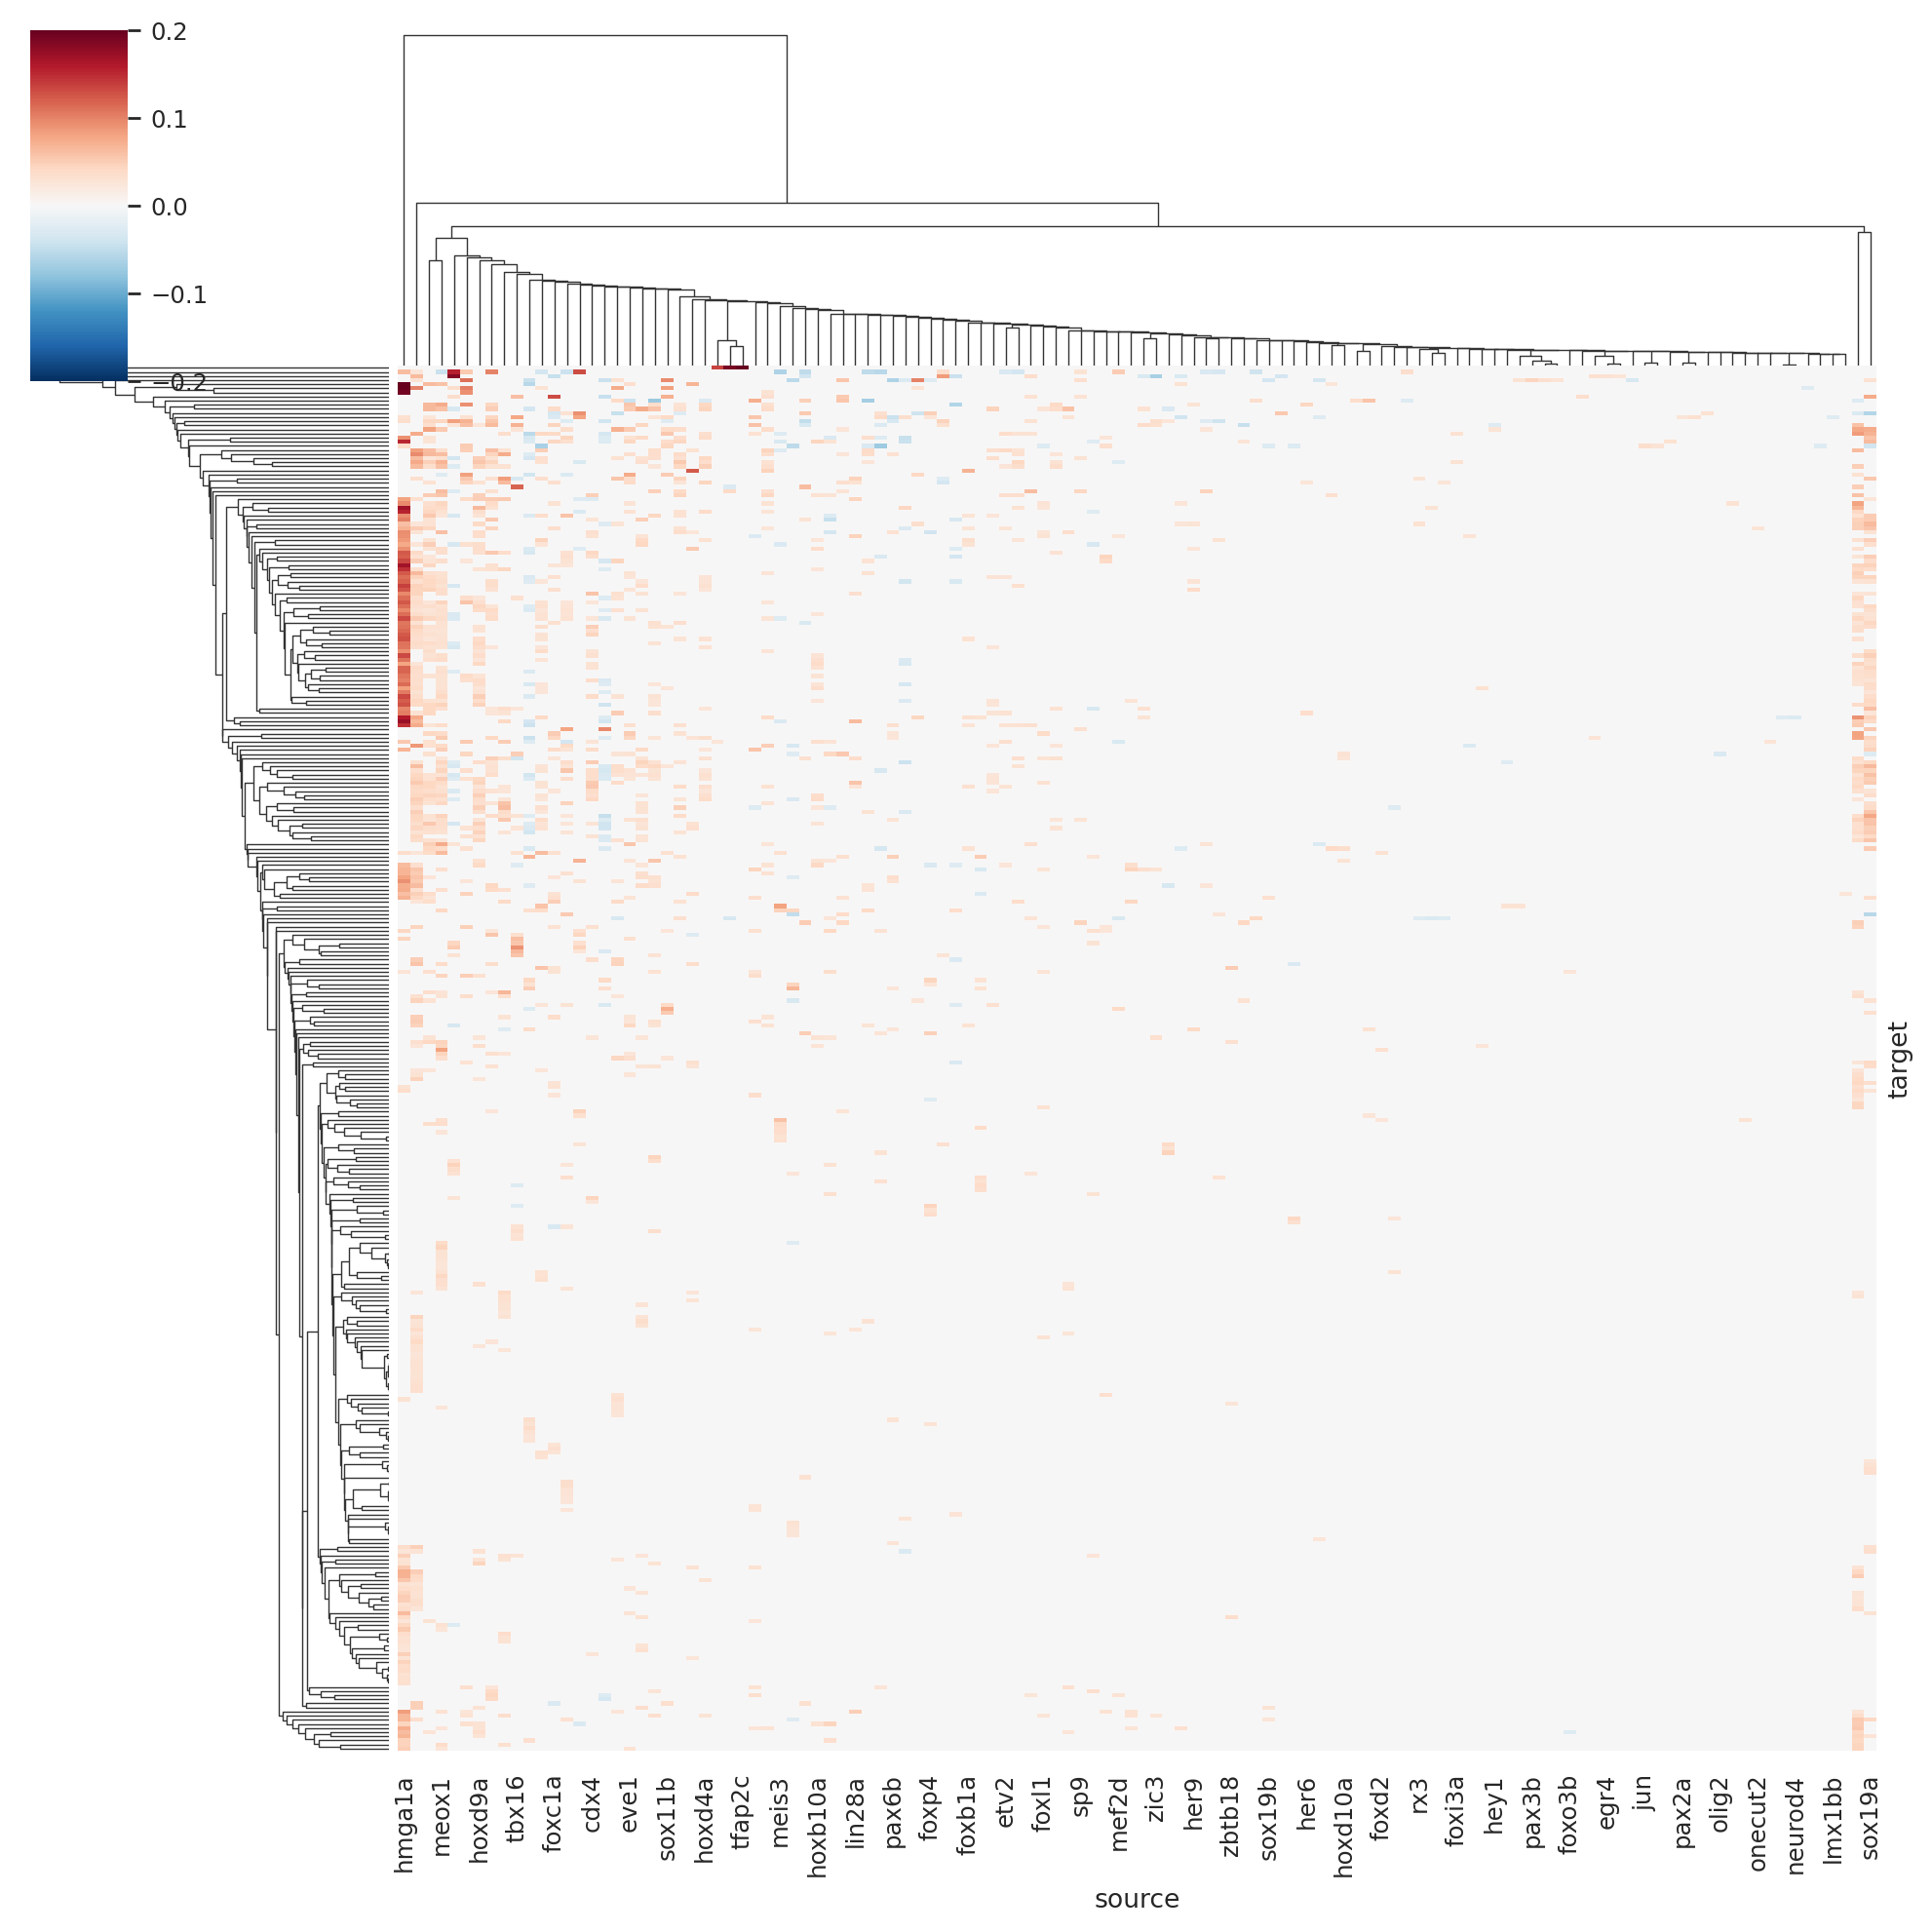

In [24]:
# Create a heatmap with hierarchical clustering
plt.figure(figsize=(12, 8))
g = sns.clustermap(df_counts, method='average', metric='euclidean', cmap='RdBu_r', standard_scale=None,
               row_cluster=True, col_cluster=True, yticklabels=False, vmax=0.2, vmin=-0.2)

# reordered_labels = df_counts.index[g.dendrogram_row.reordered_ind].tolist()
# use_labels = ["myf5","sox2","tbxta",
#               "meox1","tbx16","hes6",
#               "hbbe1.1","hbae3","hbbe3","rps16",
#               "lrrc24","krt96"]
# use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
# g.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)
# g.savefig(figpath + "clustered_heatmap_GRN_test.png")
# g.savefig(figpath + "clustered_heatmap_GRN_test.pdf")
plt.show()

In [25]:
# compute the union of dataframes (GRNs) for the first and last timepoints only (this reduces noisy visualization that are only transient in intermediate timepoints)
# For loop to plot the GRNs over timepoints
# Choose one celltype
celltype = "PSM"

# for all the rest of the timepoints (0-30 somites)
timepoints = ["TDR126", "TDR127", "TDR128", "TDR118", "TDR125", "TDR124"]

# Step 1. collect all sources and targets across all timepoints
all_sources = set()
all_targets = set()

for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    all_sources.update(df['source'].unique())
    all_targets.update(df['target'].unique())
    
# Step 2: Recreate each df_counts DataFrame
df_counts_union = {}

for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    # Pivot the original DataFrame
    df_pivot = df.pivot(index='target', columns='source', values='coef_mean').reindex(index=all_targets, columns=all_sources).fillna(0)
    df_counts_union[timepoint] = df_pivot
    
# Assuming df_counts_union is your dictionary of adjusted count matrices
timepoints = list(df_counts_union.keys())

In [30]:
# Choose one celltype
celltype = "PSM"

# extract the celltype specific GRN at one timepoint
df_sample = dict_merged_score["TDR118"][dict_merged_score["TDR118"].cluster==celltype]

df_sample.sort_values("degree_centrality_all", ascending=False)

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
meox1            109               0.236443         16              0.034707   
meis1b            87               0.188720         16              0.034707   
rarga             69               0.149675          9              0.019523   
rxraa             66               0.143167         16              0.034707   
sox5              65               0.140998         12              0.026030   
...              ...                    ...        ...                   ...   
fam222ba           1               0.002169          1              0.002169   
nr4a3              1               0.002169          0              0.000000   
tlx2               1               0.002169          0              0.000000   
rxrga              1               0.002169          1              0.002169   
ribc1              1               0.002169          1              0.002169   

          degree_out  degree_centrality_out  betweenness_centrality  \
meox1             93               0.201735                  9103.0   
meis1b            71               0.154013                  5216.0   
rarga             60               0.130152                  5512.0   
rxraa             50               0.108460                  3072.0   
sox5              53               0.114967                  3834.0   
...              ...                    ...                     ...   
fam222ba           0               0.000000                     0.0   
nr4a3              1               0.002169                     0.0   
tlx2               1               0.002169                     0.0   
rxrga              0               0.000000                     0.0   
ribc1              0               0.000000                     0.0   

          eigenvector_centrality cluster  
meox1                   0.780098     PSM  
meis1b                  0.672839     PSM  
rarga                   0.502804     PSM  
rxraa                   1.000000     PSM  
sox5                    0.842024     PSM  
...                          ...     ...  
fam222ba                0.014151     PSM  
nr4a3                   0.001584     PSM  
tlx2                    0.008594     PSM  
rxrga                   0.001142     PSM  
ribc1                   0.005309     PSM  

[462 rows x 9 columns]

In [31]:
list_top_genes = df_sample.sort_values("degree_centrality_all", ascending=False).index[0:30]
list_top_genes

Index(['meox1', 'meis1b', 'rarga', 'rxraa', 'sox5', 'hoxb3a', 'meis1a',
       'nr2f5', 'tbx16', 'raraa', 'sox13', 'rarab', 'foxp4', 'hmga1a', 'cdx4',
       'hoxc3a', 'hoxc6b', 'sox6', 'lef1', 'mef2d', 'rxrab', 'gli2a', 'pax6a',
       'pax6b', 'vox', 'thrab', 'sox3', 'zbtb16a', 'sox11a', 'tenm4'],
      dtype='object')

In [32]:
list_top_sources = df_sample.sort_values("degree_centrality_out", ascending=False).index[0:30]
list_top_sources

Index(['meox1', 'meis1b', 'rarga', 'meis1a', 'nr2f5', 'sox5', 'rxraa',
       'hoxb3a', 'sox13', 'raraa', 'rarab', 'tbx16', 'pax6a', 'hmga1a', 'sox6',
       'thrab', 'foxp4', 'rxrab', 'hoxc6b', 'sox3', 'pax6b', 'vox', 'mef2d',
       'lef1', 'sox11a', 'nr2f1b', 'meis2a', 'rfx4', 'rxrgb', 'hoxb7a'],
      dtype='object')

In [33]:
list_top_targets = df_sample.sort_values("degree_centrality_in", ascending=False).index[0:30]
list_top_targets

Index(['tenm4', 'zbtb16a', 'robo1', 'tbx16', 'cdx4', 'nucks1a', 'hoxc3a',
       'gli2a', 'trps1', 'fbn2b', 'fgfrl1a', 'qkia', 'cirbpa', 'tbx6',
       'cx43.4', 'apoc1', 'raraa', 'hoxb3a', 'efemp2b', 'meis1b', 'nrp2b',
       'msgn1', 'sulf1', 'rxraa', 'mllt3', 'fn1b', 'meox1', 'gse1', 'chsy1',
       'ncam1a'],
      dtype='object')

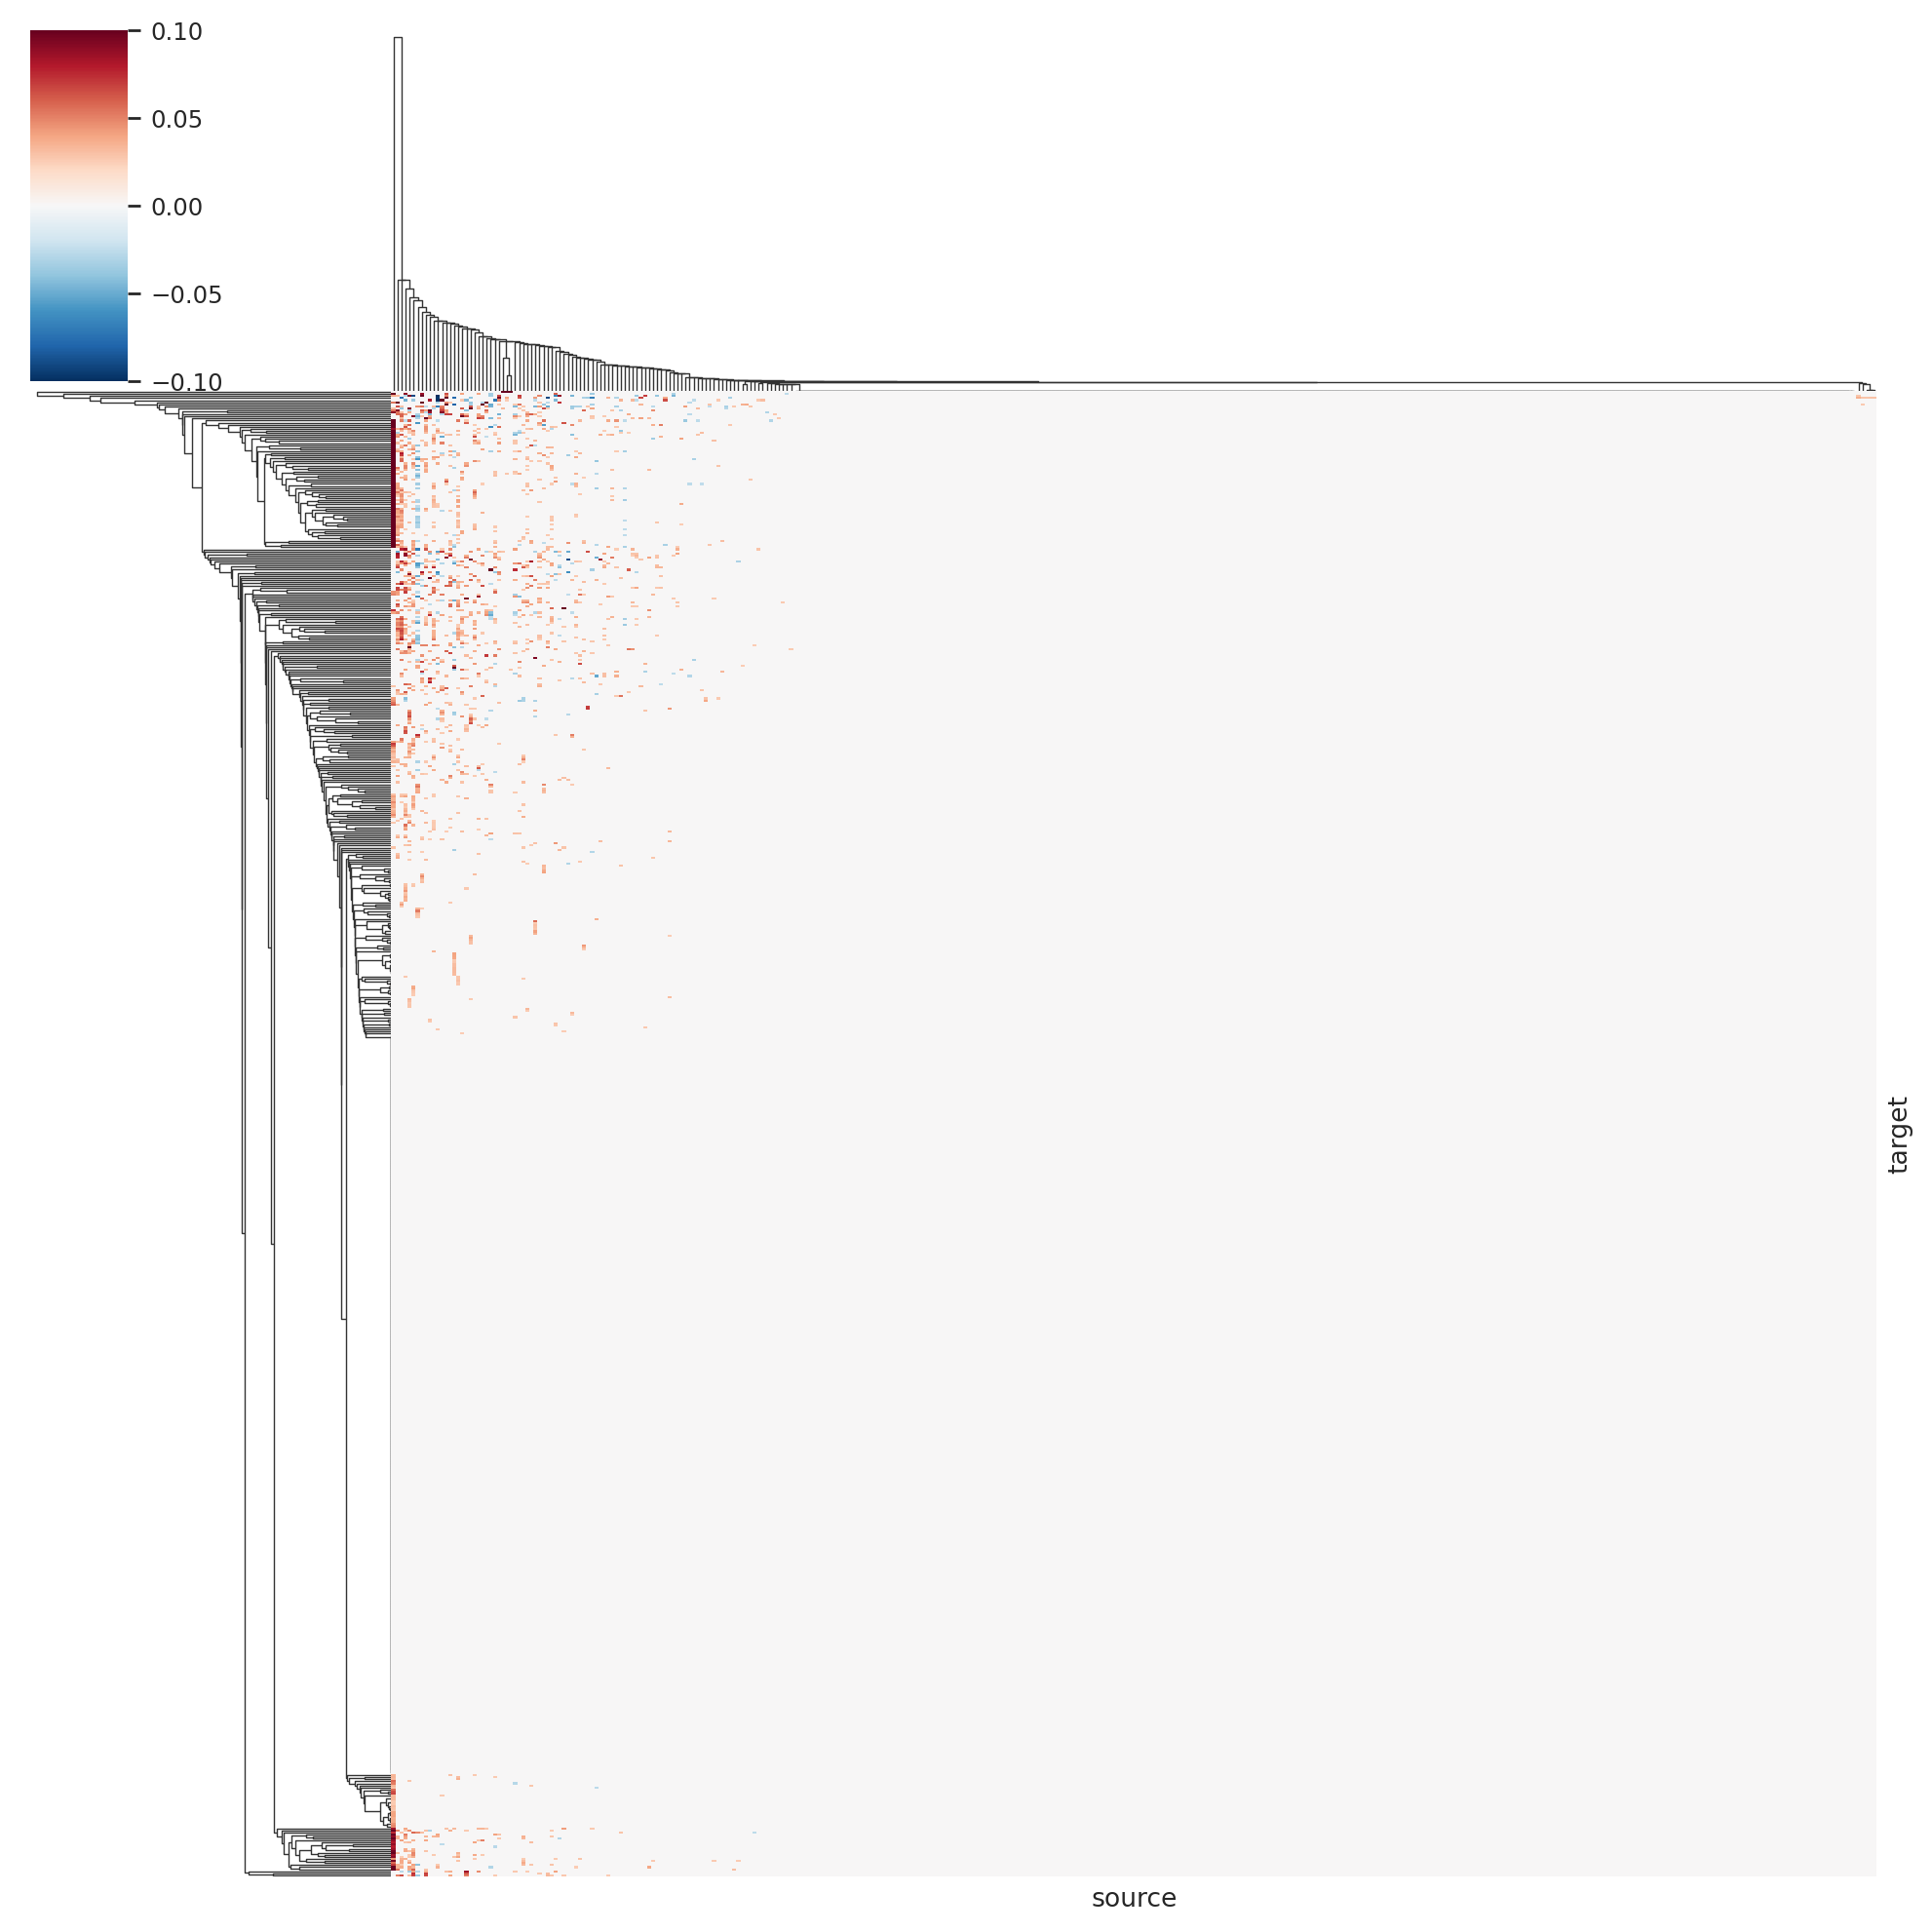

In [36]:
# first timepoint (0 somite/budstage)
df_counts = df_counts_union["TDR126"]

g1 = sns.clustermap(df_counts, method='average', metric='euclidean', cmap='RdBu_r', standard_scale=None,
                row_cluster=True, col_cluster=True, 
                xticklabels=False, yticklabels=False, 
                figsize=(10, 10),  # Adjust the figsize to fit your data
                vmax=0.1, vmin=-0.1)

# Access the axes for annotation
heatmap_ax = g1.ax_heatmap

# Determine the size of the heatmap for proper annotation placement
heatmap_size = heatmap_ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

plt.show()

## Step 1. generate the GRN heatmaps for all timepoints (for one celltype)

- here, we will pick a couple of celltypes as an example. Note that we want to take a closer look at some of the GRN modules later (if they are conserved in other species or not) 

- PSM (NOTE that the PSM GRN at 30-somites (TDR124) is very weak, likely because the number of PSM cells at 30-somites stage is very small...on the order of 10-20 cells.
- spinal_cord (a good number of cells throughout the developmental stages


### NOTE:
- we'll concatenate the df_counts from all timepoints for the "clustering" for rows and cols, respectively.



### Fine-tuning the GRN visualization (using the linkages from concatenated GRNs along the timepoints)

In [38]:
# For loop to plot the GRNs over timepoints
# Choose one celltype
celltype = "PSM"

# for all the rest of the timepoints (0-30 somites)
timepoints = ["TDR126", "TDR127", "TDR128", "TDR118", "TDR125", "TDR124"]

# Step 1. collect all sources and targets across all timepoints
all_sources = set()
all_targets = set()

# for timepoint in timepoints:
#     df = dict_filtered_GRNs[timepoint][celltype]
#     all_sources.update(df['source'].unique())
#     all_targets.update(df['target'].unique())

# union for only the first and the last two timepoints (to reduce the noisy nodes)
for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    all_sources.update(df['source'].unique())
    all_targets.update(df['target'].unique())

    
# Step 2: Recreate each df_counts DataFrame
df_counts_union = {}

for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    # Pivot the original DataFrame
    df_pivot = df.pivot(index='target', columns='source', values='coef_mean').reindex(index=all_targets, columns=all_sources).fillna(0)
    df_counts_union[timepoint] = df_pivot
    
# Assuming df_counts_union is your dictionary of adjusted count matrices
timepoints = list(df_counts_union.keys())

### GRN visualization for PSM (over time)

In [40]:
# compute the linkages from the first and the last timepoints, by augmenting the "time" components
df_counts1 = df_counts_union["TDR126"]
df_counts2 = df_counts_union["TDR127"]
df_counts3 = df_counts_union["TDR128"]
df_counts4 = df_counts_union["TDR118"]
df_counts5 = df_counts_union["TDR125"]
df_counts6 = df_counts_union["TDR124"]

df = pd.concat([df_counts1, df_counts2, df_counts3,
                df_counts4, df_counts5, df_counts6], axis=1)
df

source           nkx1.2la  gsx1  noto  neurod4  pknox2  cebpb  sp5a  lmx1al  \
target                                                                        
ptges3b               0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
si:dkey-67c22.2       0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
col11a1a              0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
anp32a                0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
ctnnb1                0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
...                   ...   ...   ...      ...     ...    ...   ...     ...   
hspa8                 0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
dut                   0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
nedd9                 0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
rpl28                 0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
sfrp1a                0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   

source           nkx6.3  onecut1  ...  vent  nkx2.4a  rorc  tbx19  nr1d1  \
target                            ...                                      
ptges3b             0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
si:dkey-67c22.2     0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
col11a1a            0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
anp32a              0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
ctnnb1              0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
...                 ...      ...  ...   ...      ...   ...    ...    ...   
hspa8               0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
dut                 0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
nedd9               0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
rpl28               0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
sfrp1a              0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   

source              irx5a  gbx2    sox11a  vax1  creb3l3a  
target                                                     
ptges3b          0.000000   0.0  0.000000   0.0       0.0  
si:dkey-67c22.2  0.000000   0.0  0.000000   0.0       0.0  
col11a1a         0.000000   0.0  0.000000   0.0       0.0  
anp32a           0.000000   0.0  0.000000   0.0       0.0  
ctnnb1           0.000000   0.0  0.000000   0.0       0.0  
...                   ...   ...       ...   ...       ...  
hspa8            0.014085   0.0  0.010993   0.0       0.0  
dut              0.000000   0.0  0.000000   0.0       0.0  
nedd9            0.000000   0.0  0.000000   0.0       0.0  
rpl28            0.000000   0.0  0.000000   0.0       0.0  
sfrp1a           0.000000   0.0  0.000000   0.0       0.0  

[727 rows x 2196 columns]

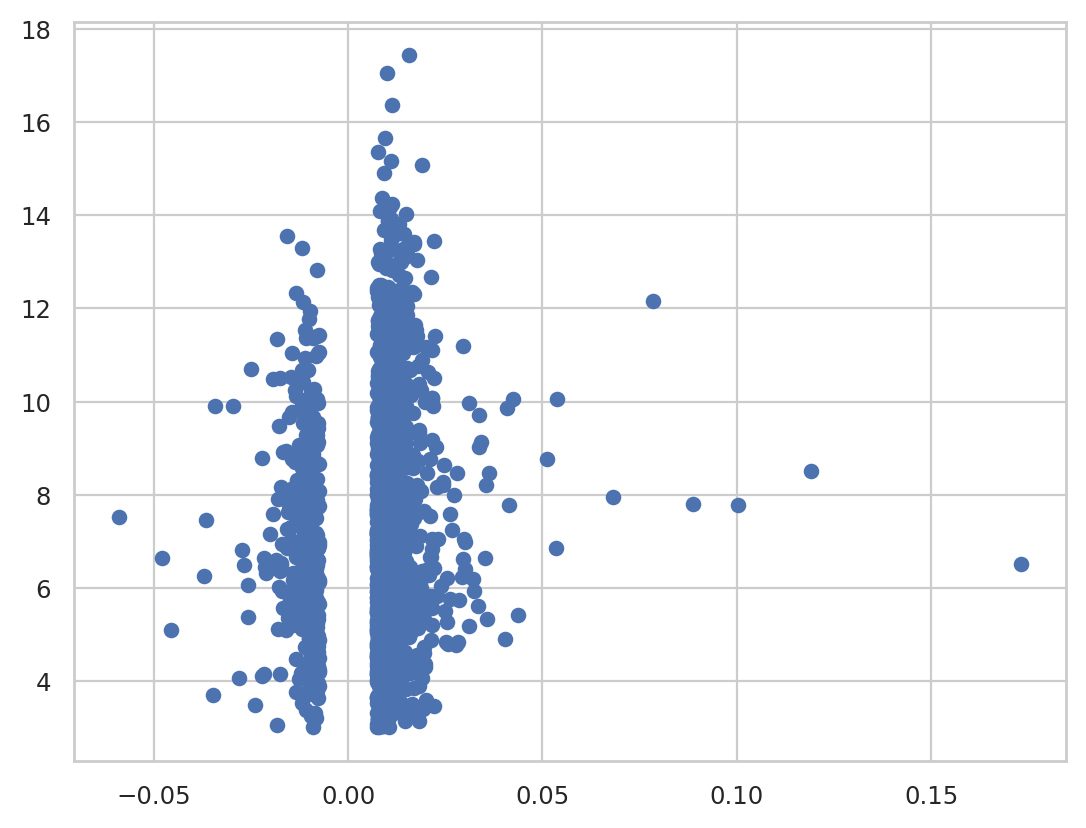

In [57]:
# Check the coef_abs (GRN edge strength_ distribution for GRN[PSM, 30-somites]
df_GRN_test = dict_filtered_GRNs["TDR124"]["PSM"]

plt.scatter(df_GRN_test["coef_mean"], df_GRN_test["-logp"])
plt.show()

### NOTE: above scatter plot shows that the GRN [PSM, 30somites] is very weak. This is likely because the number of PSM cells at 30-somites tage is very few.

### generate heatmap visualization for GRNs (PSM)

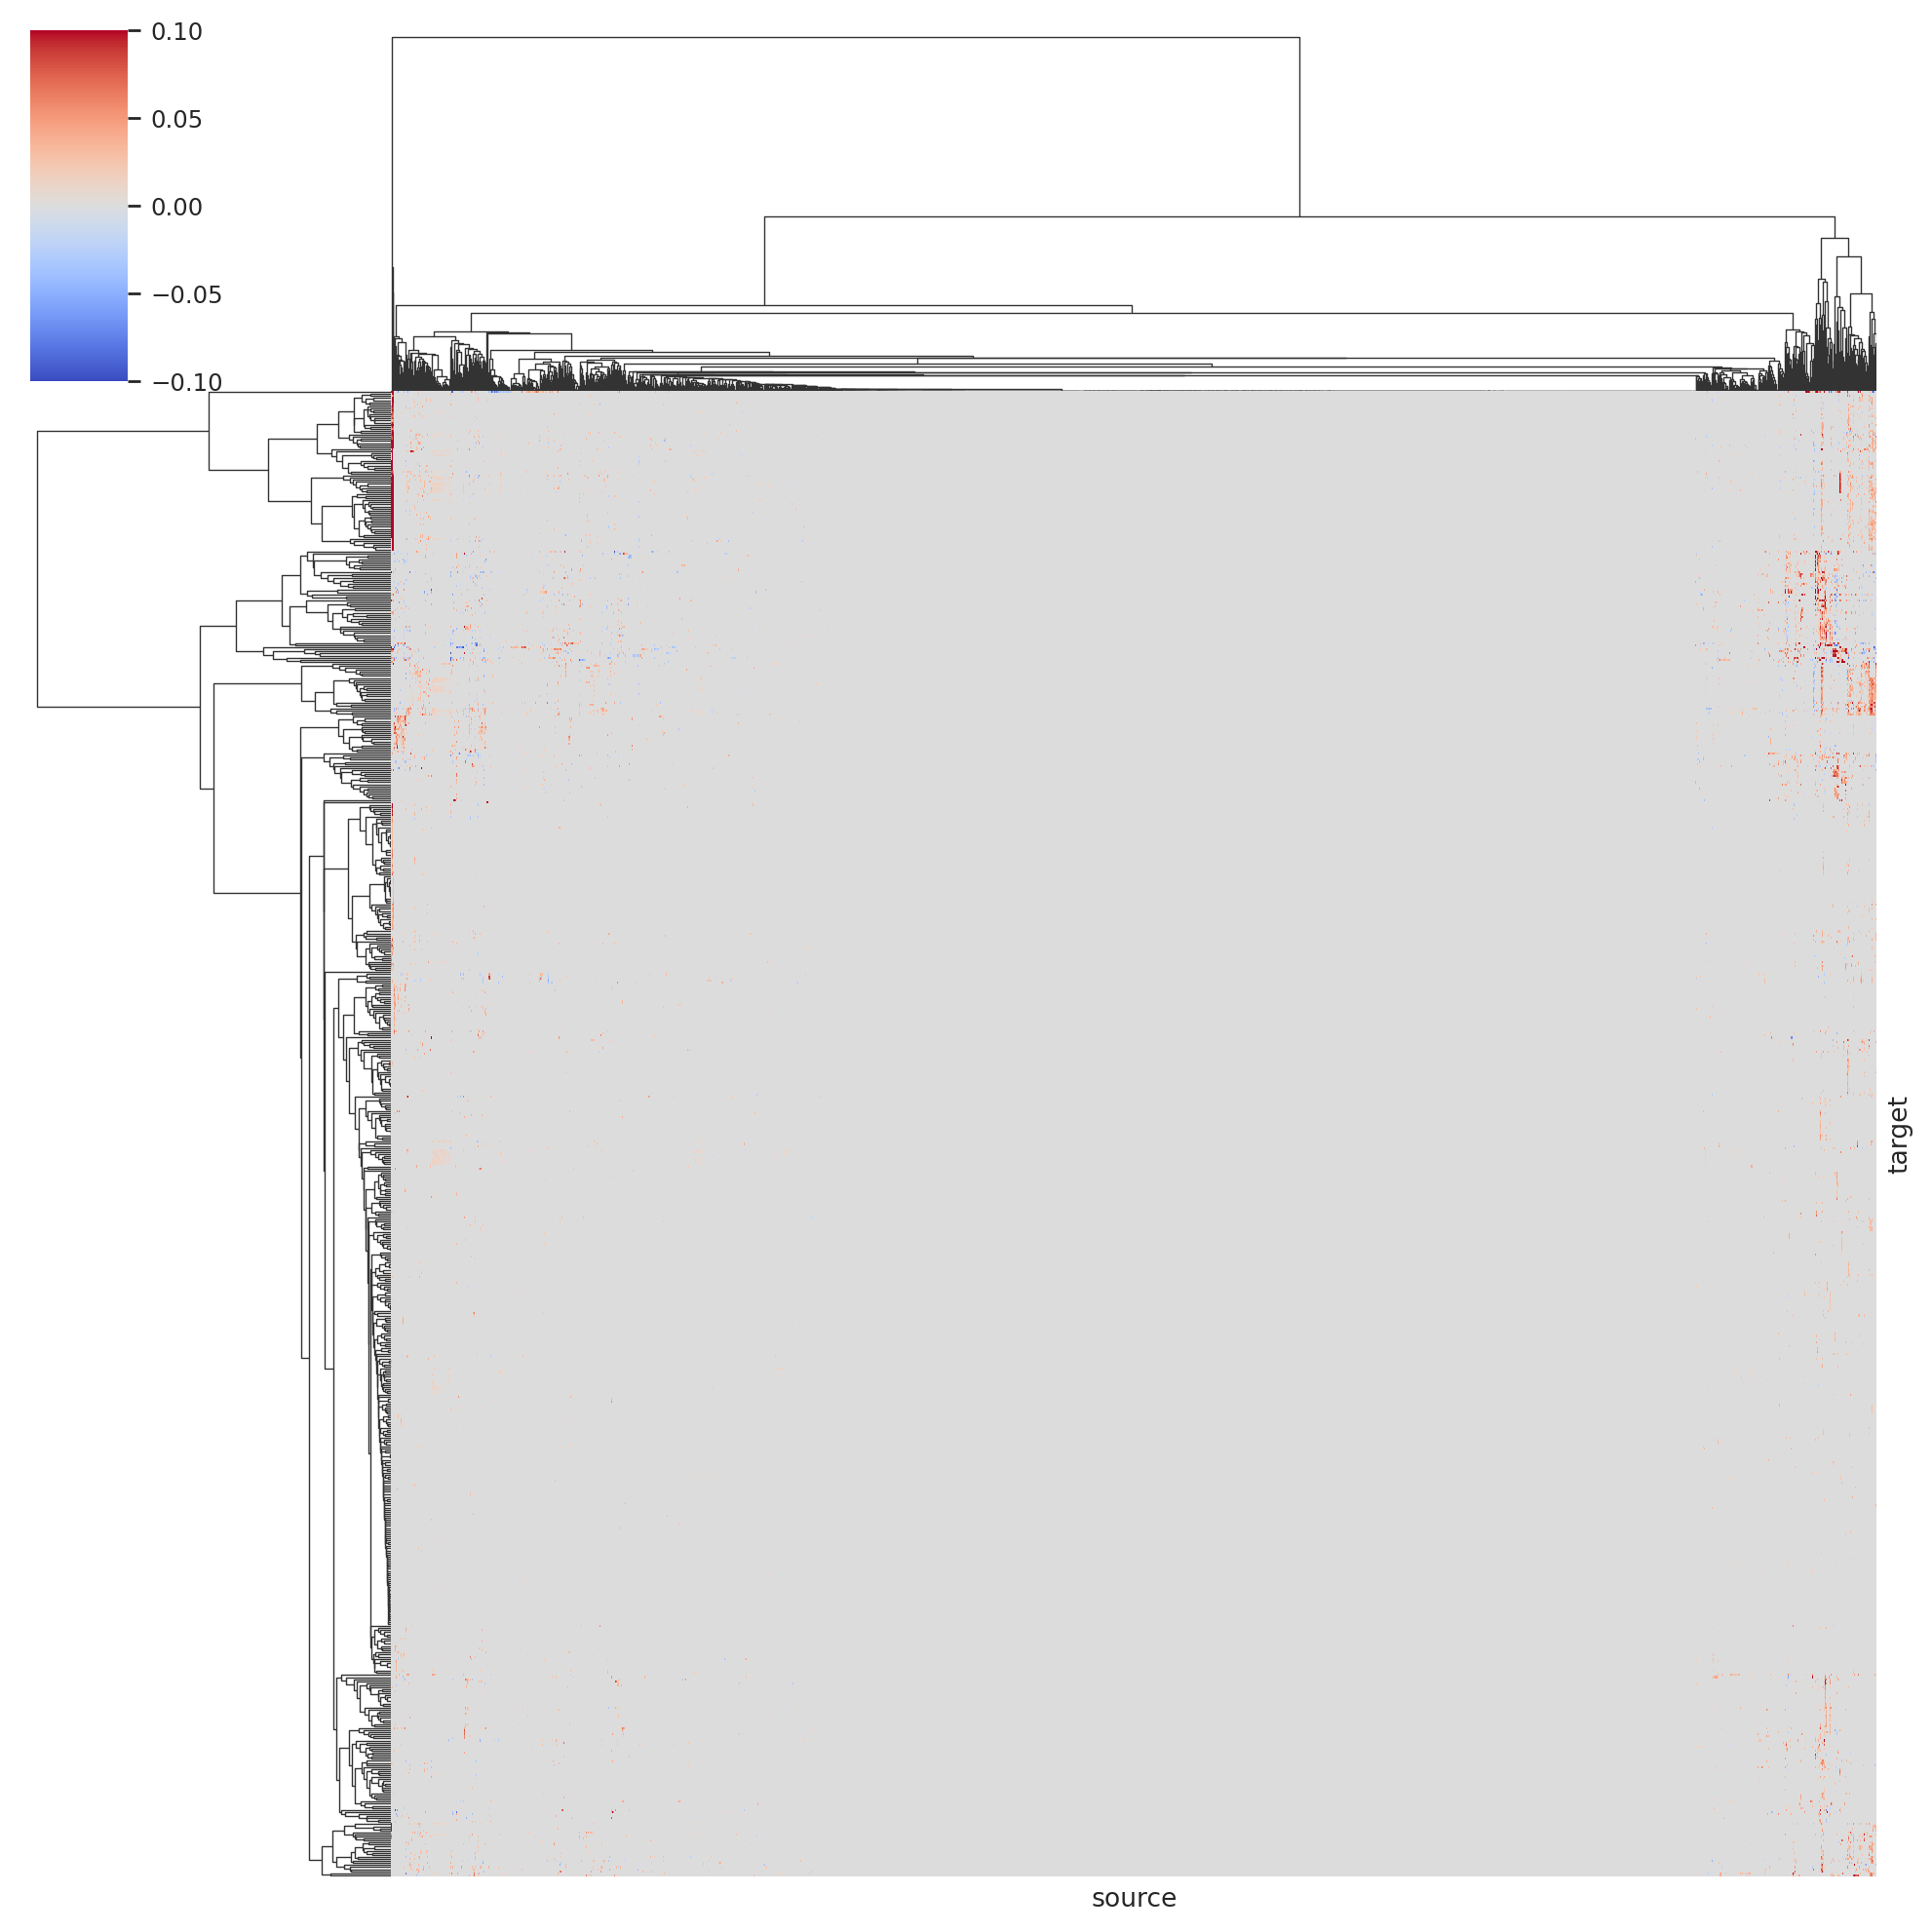

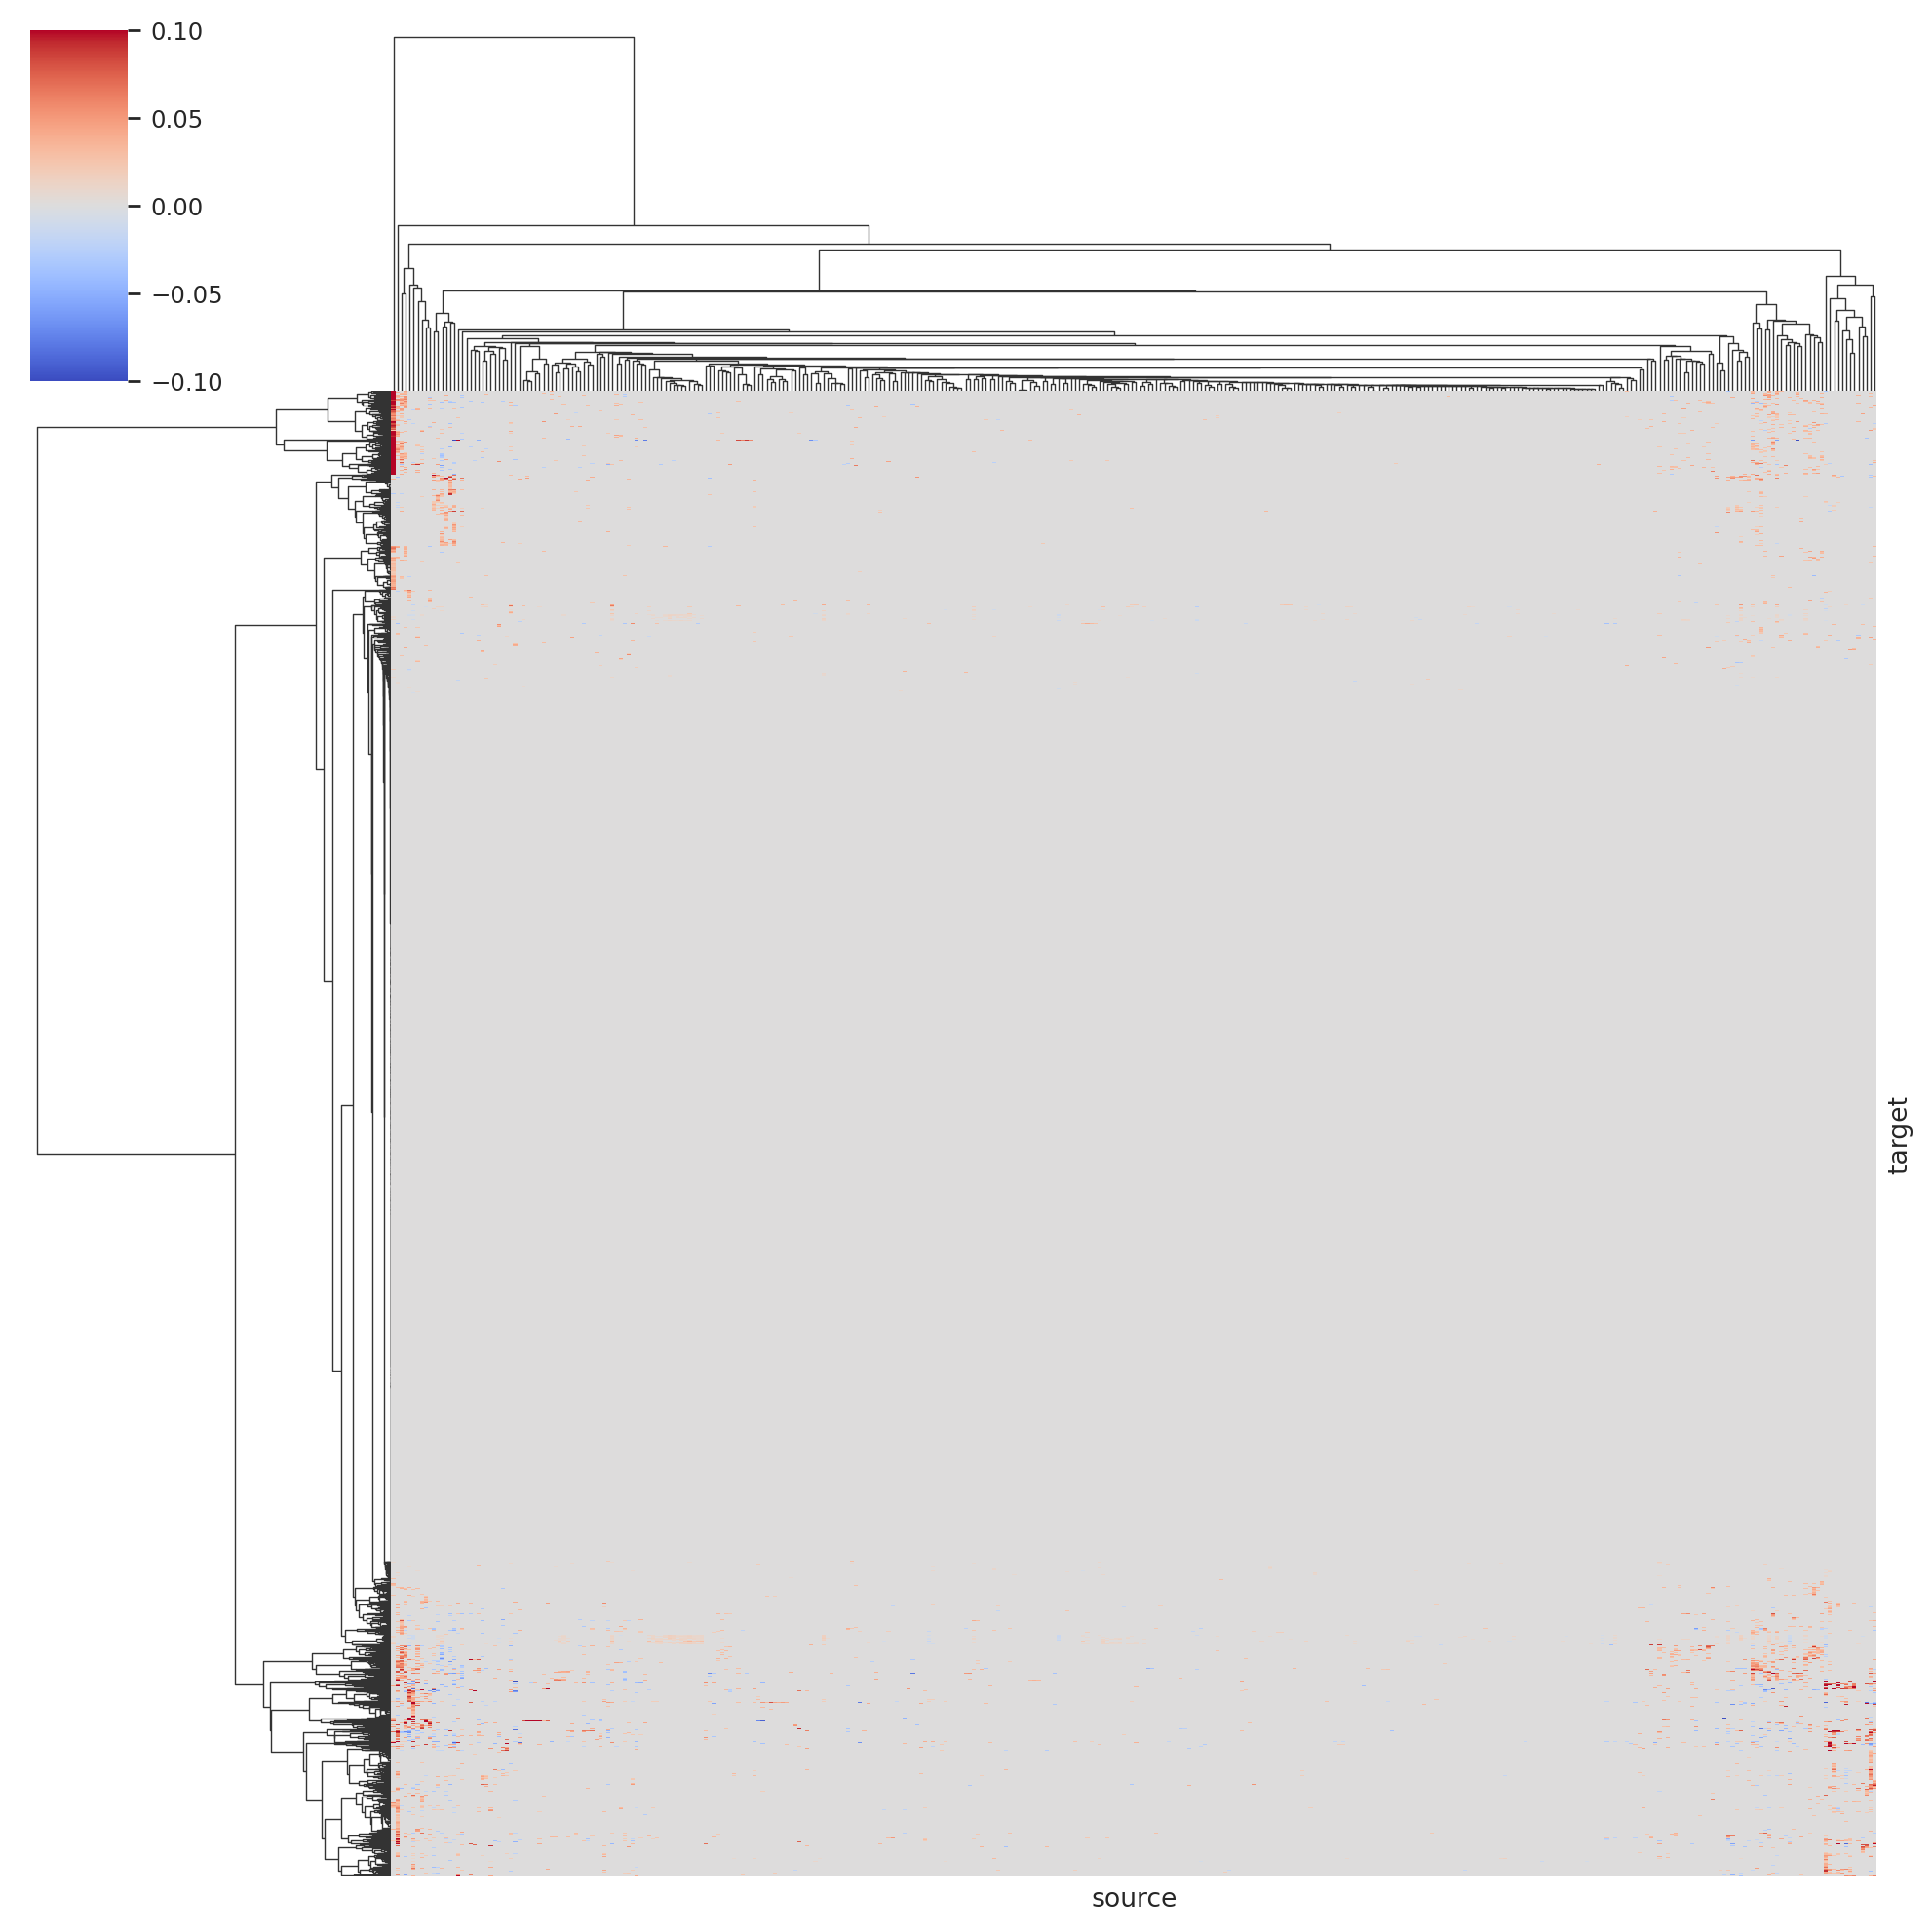

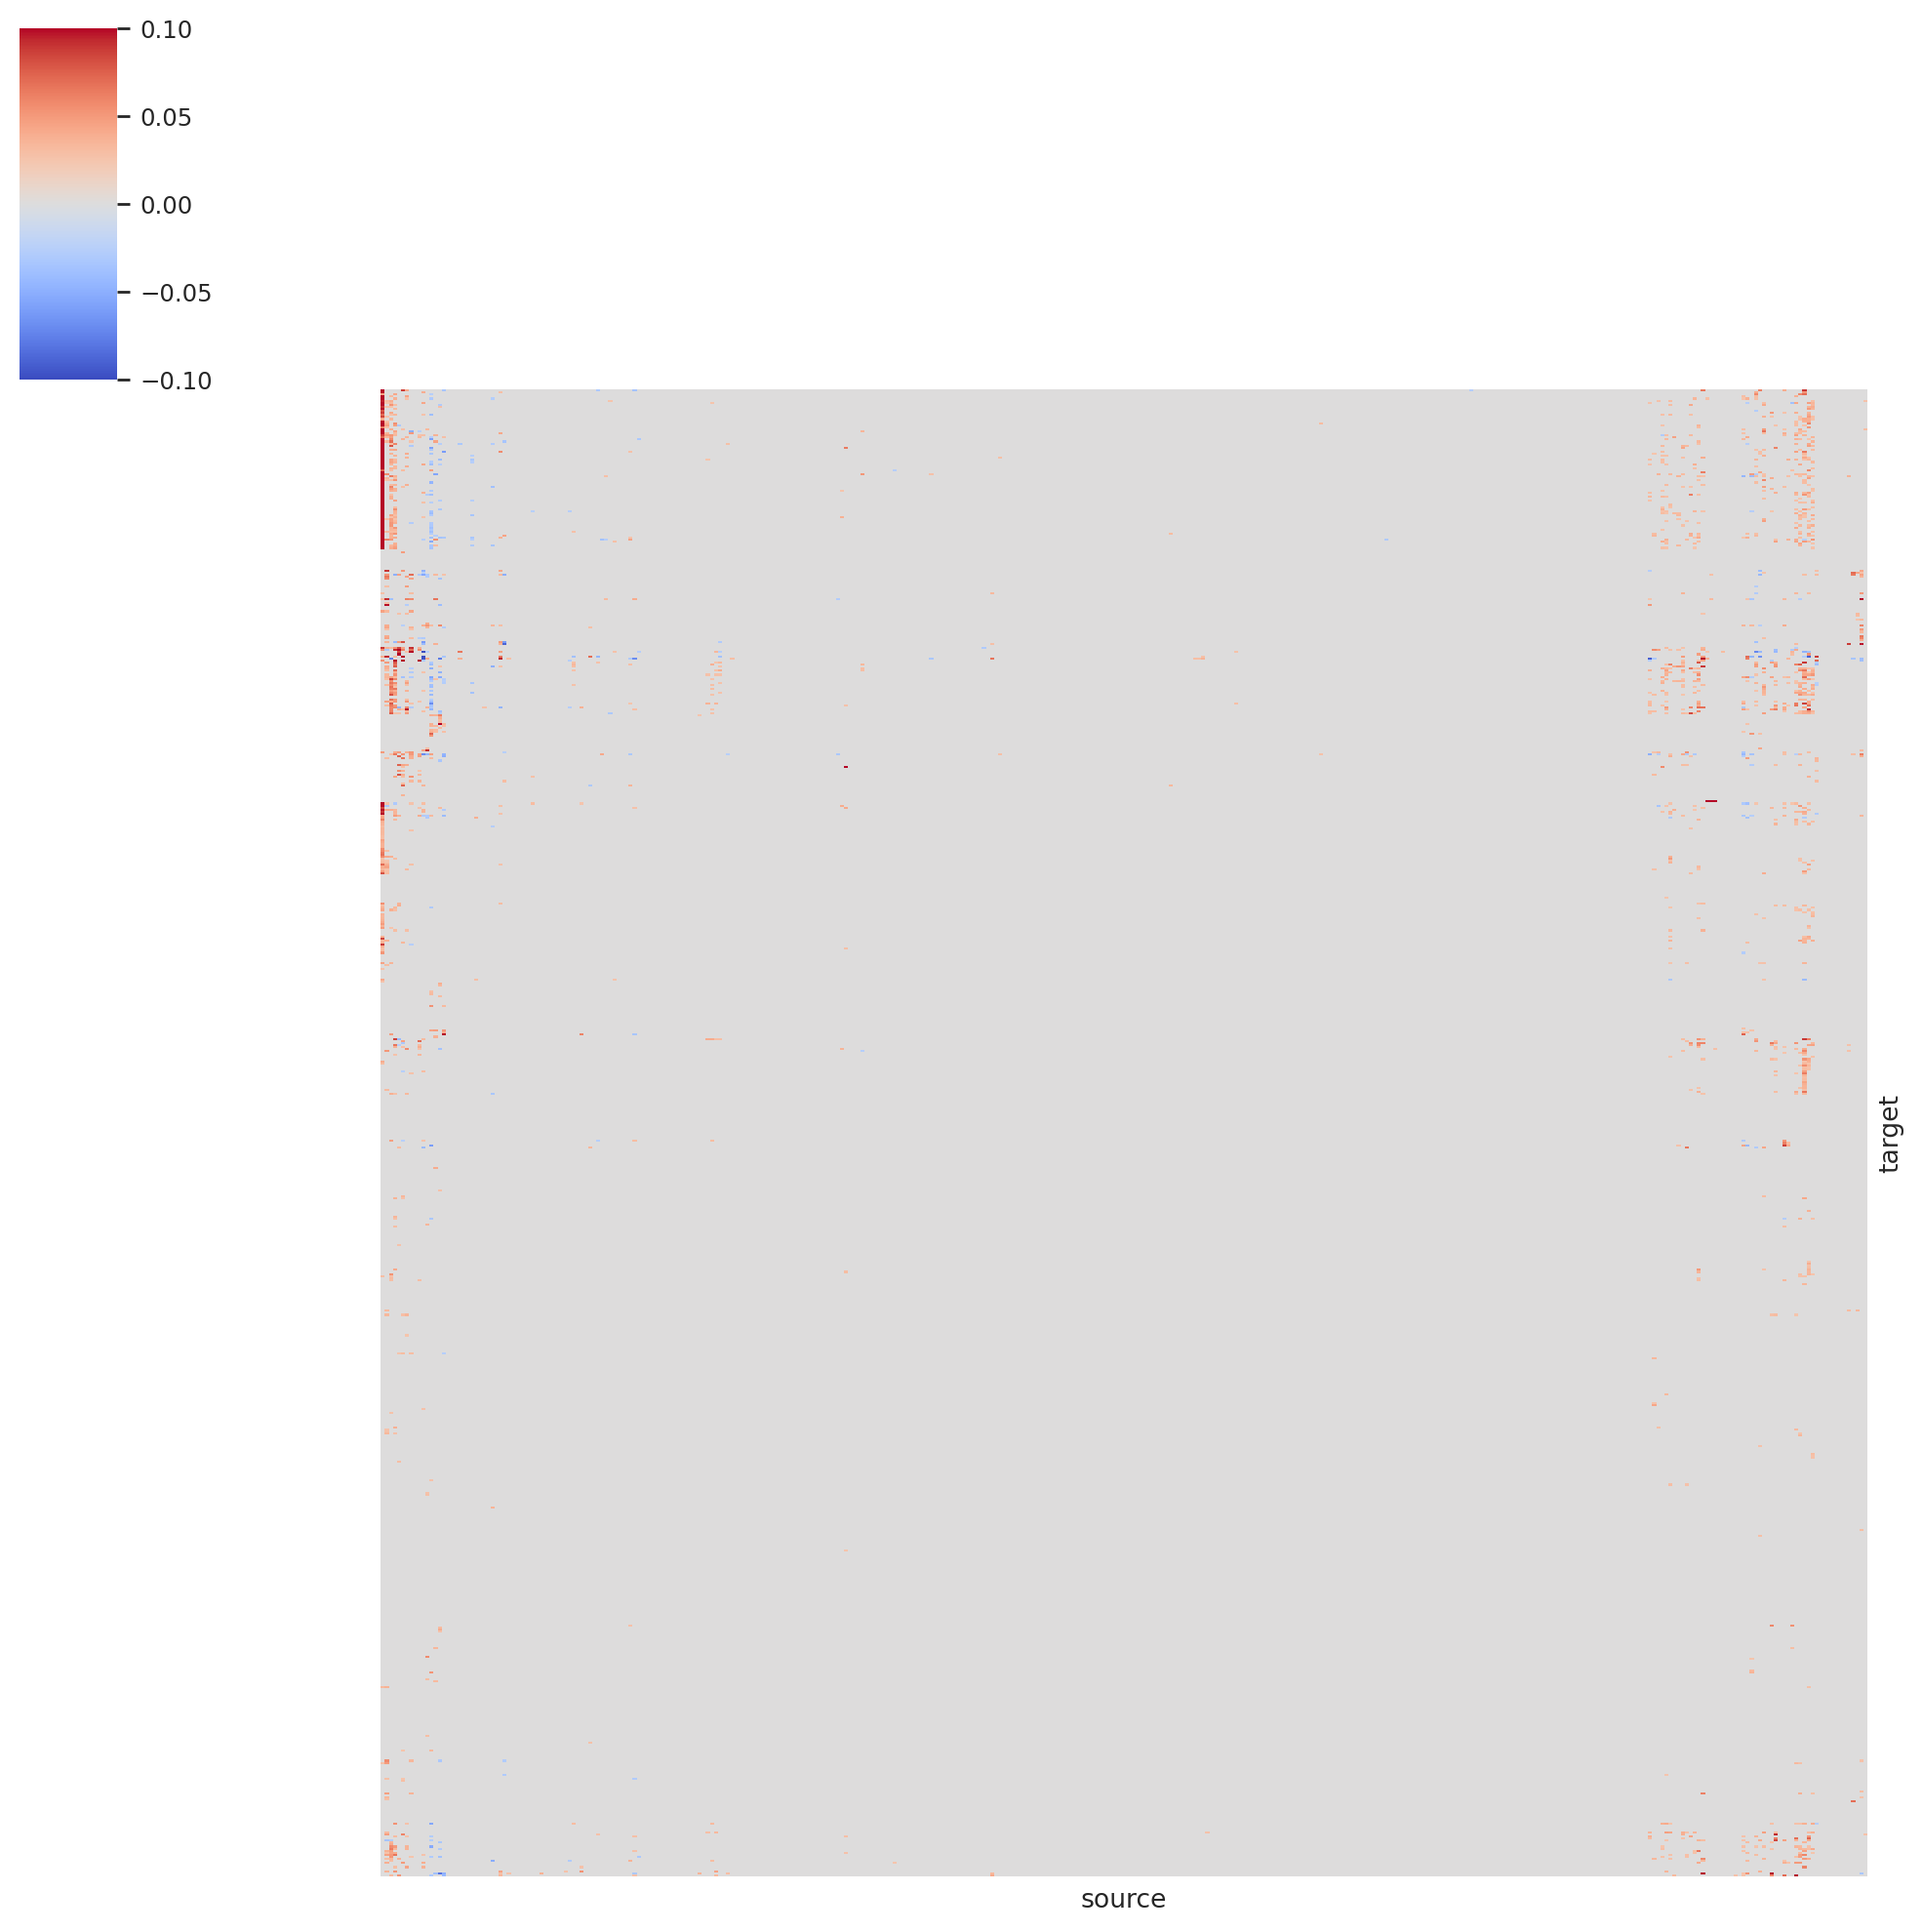

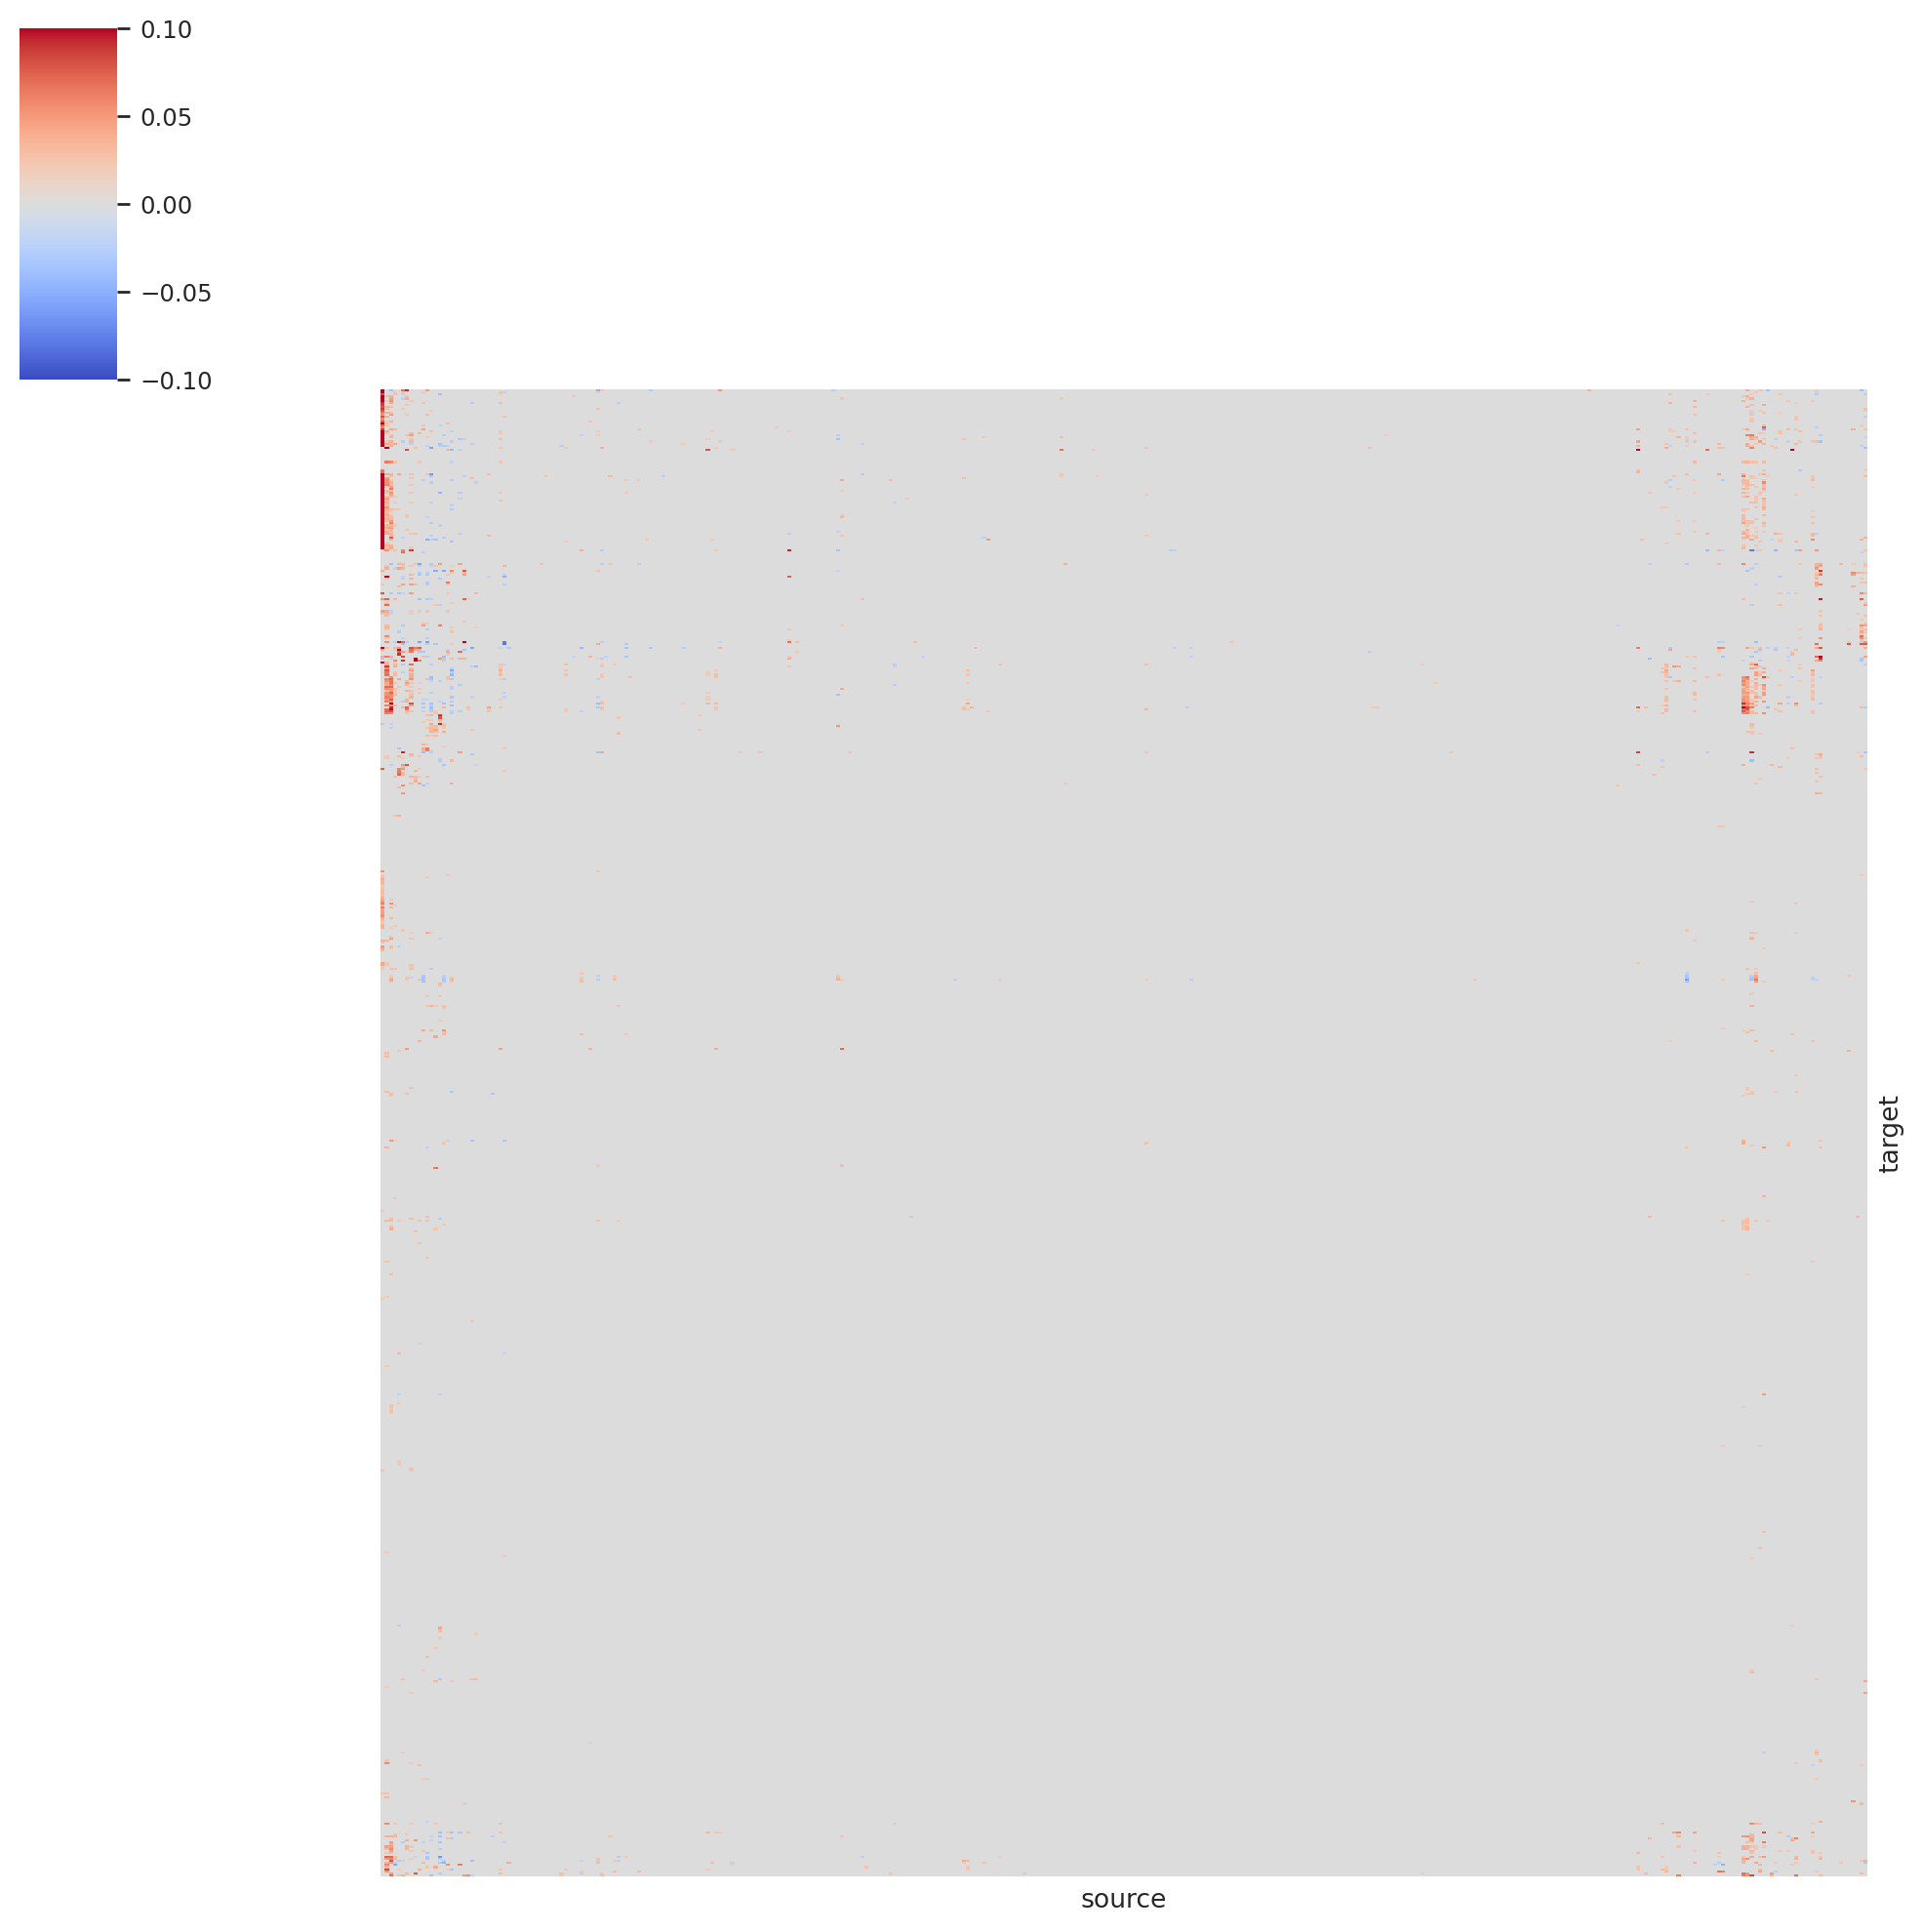

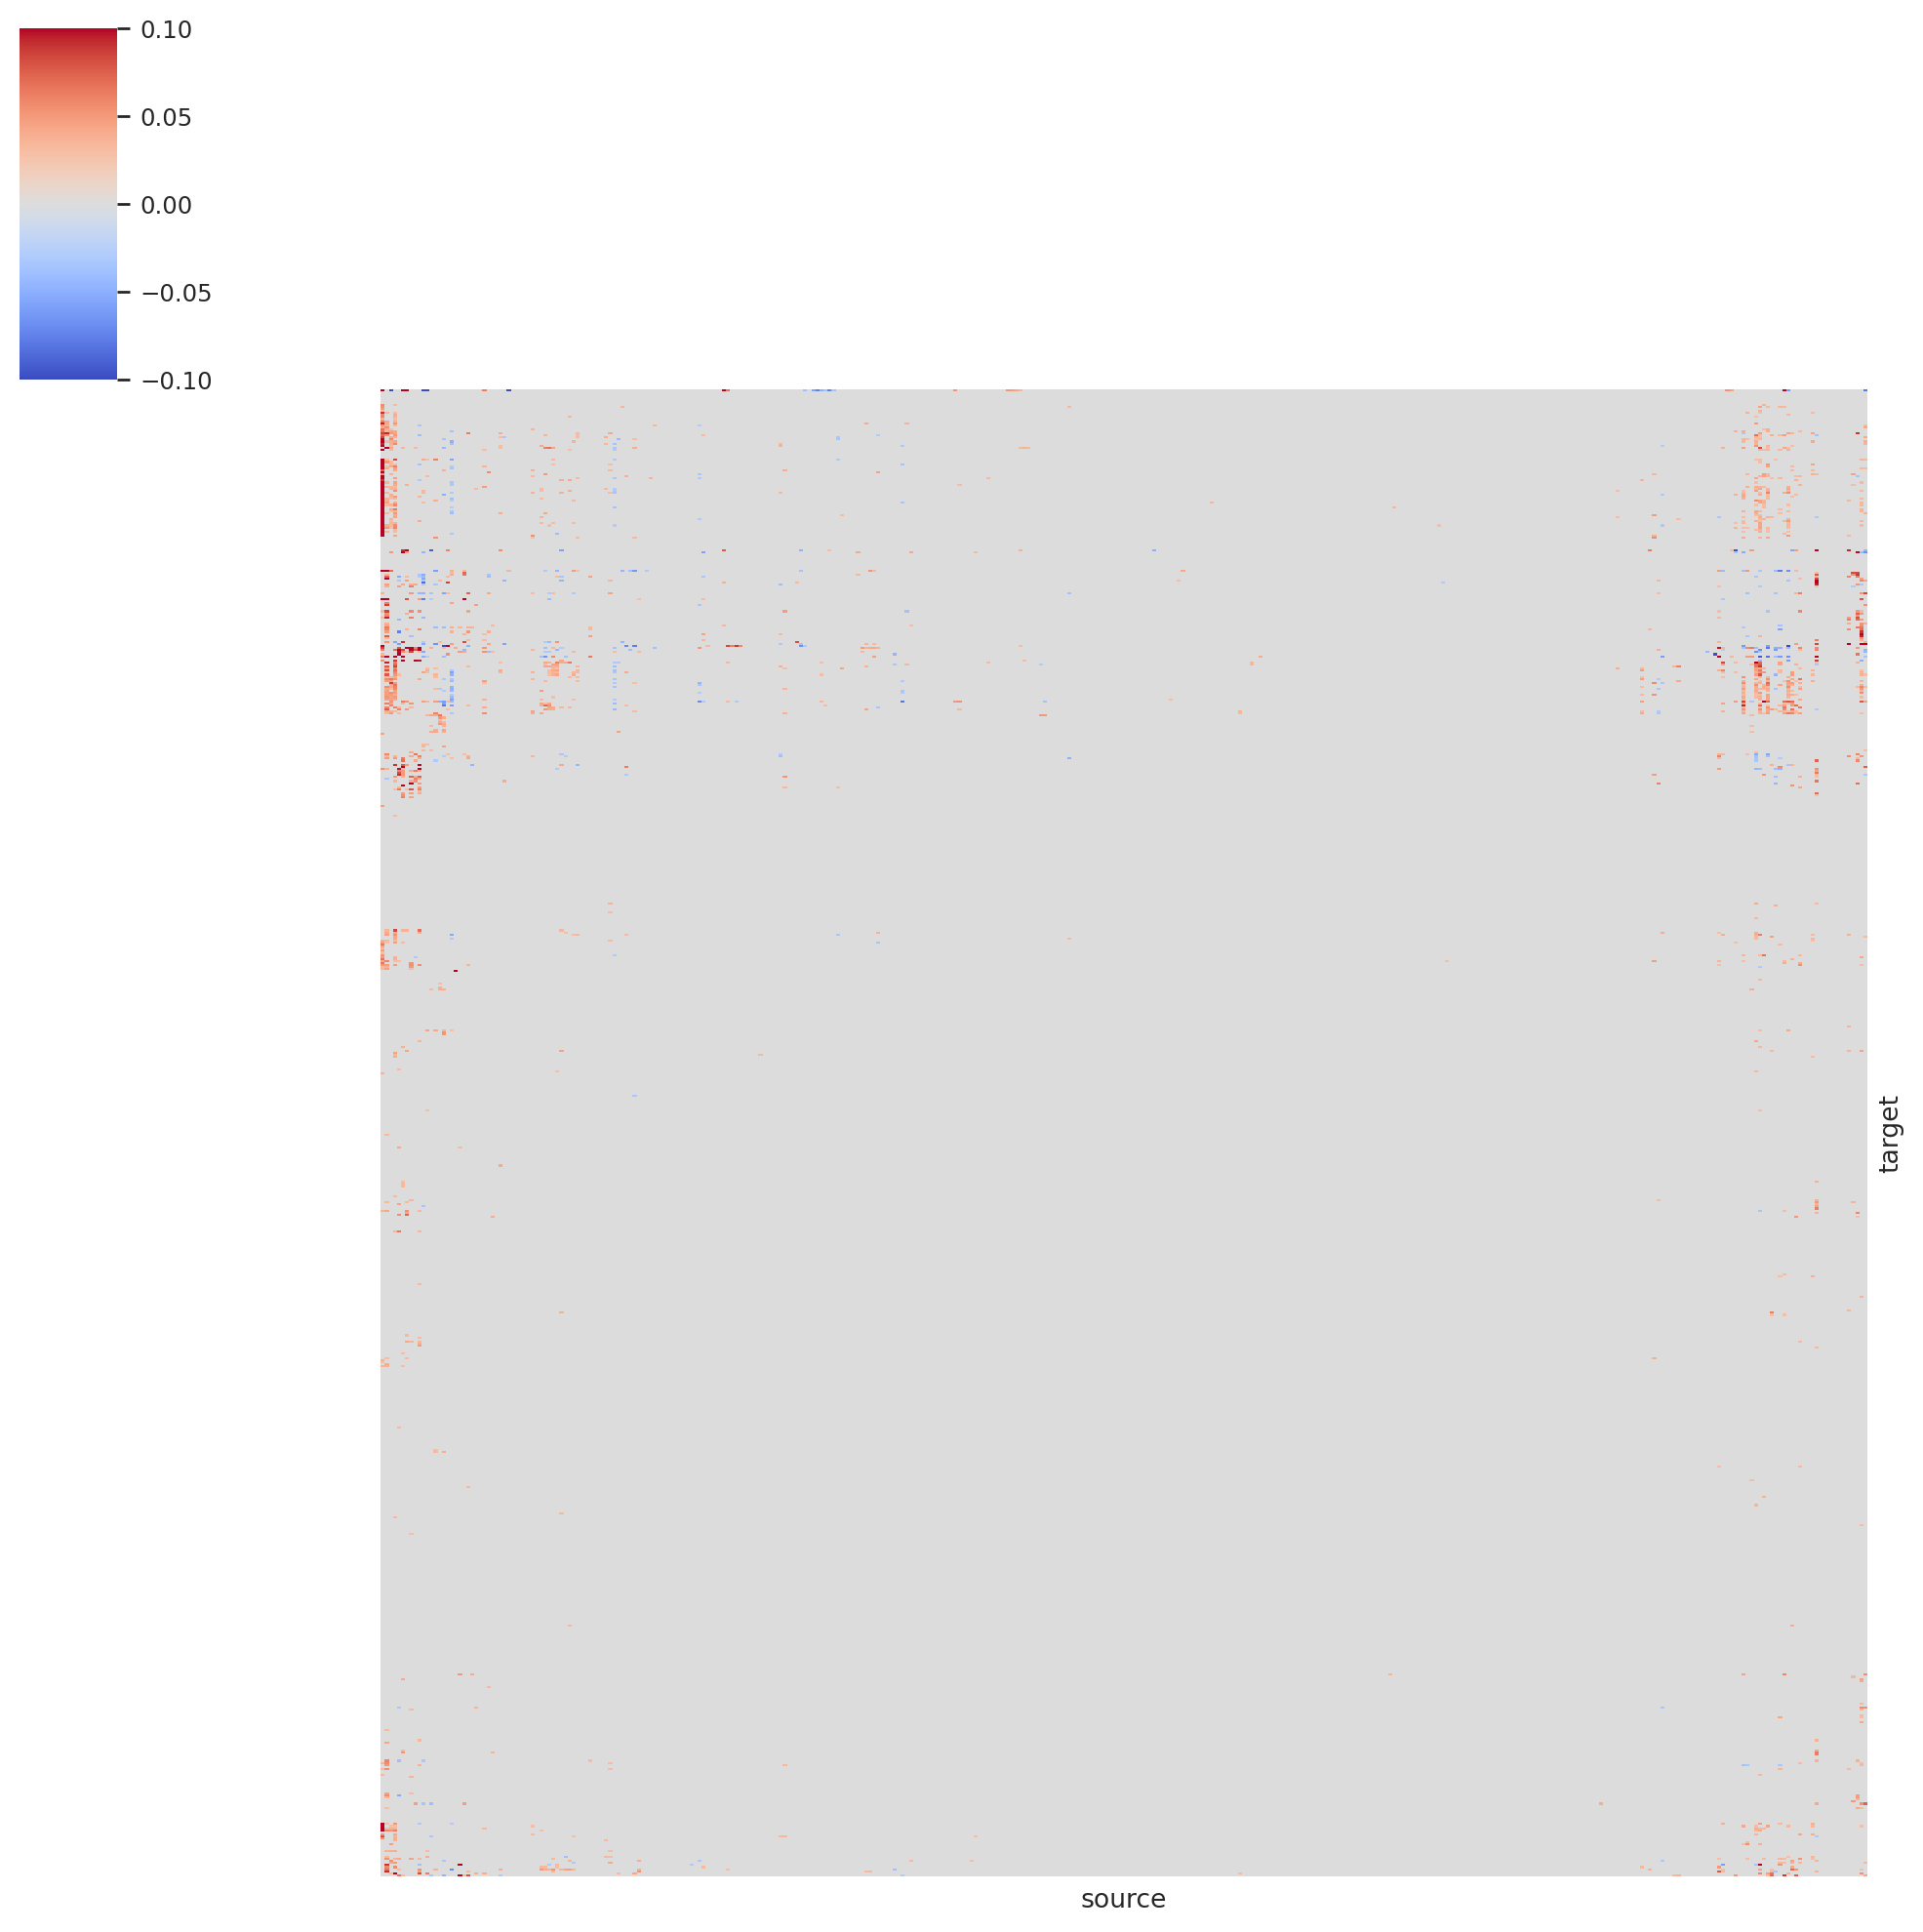

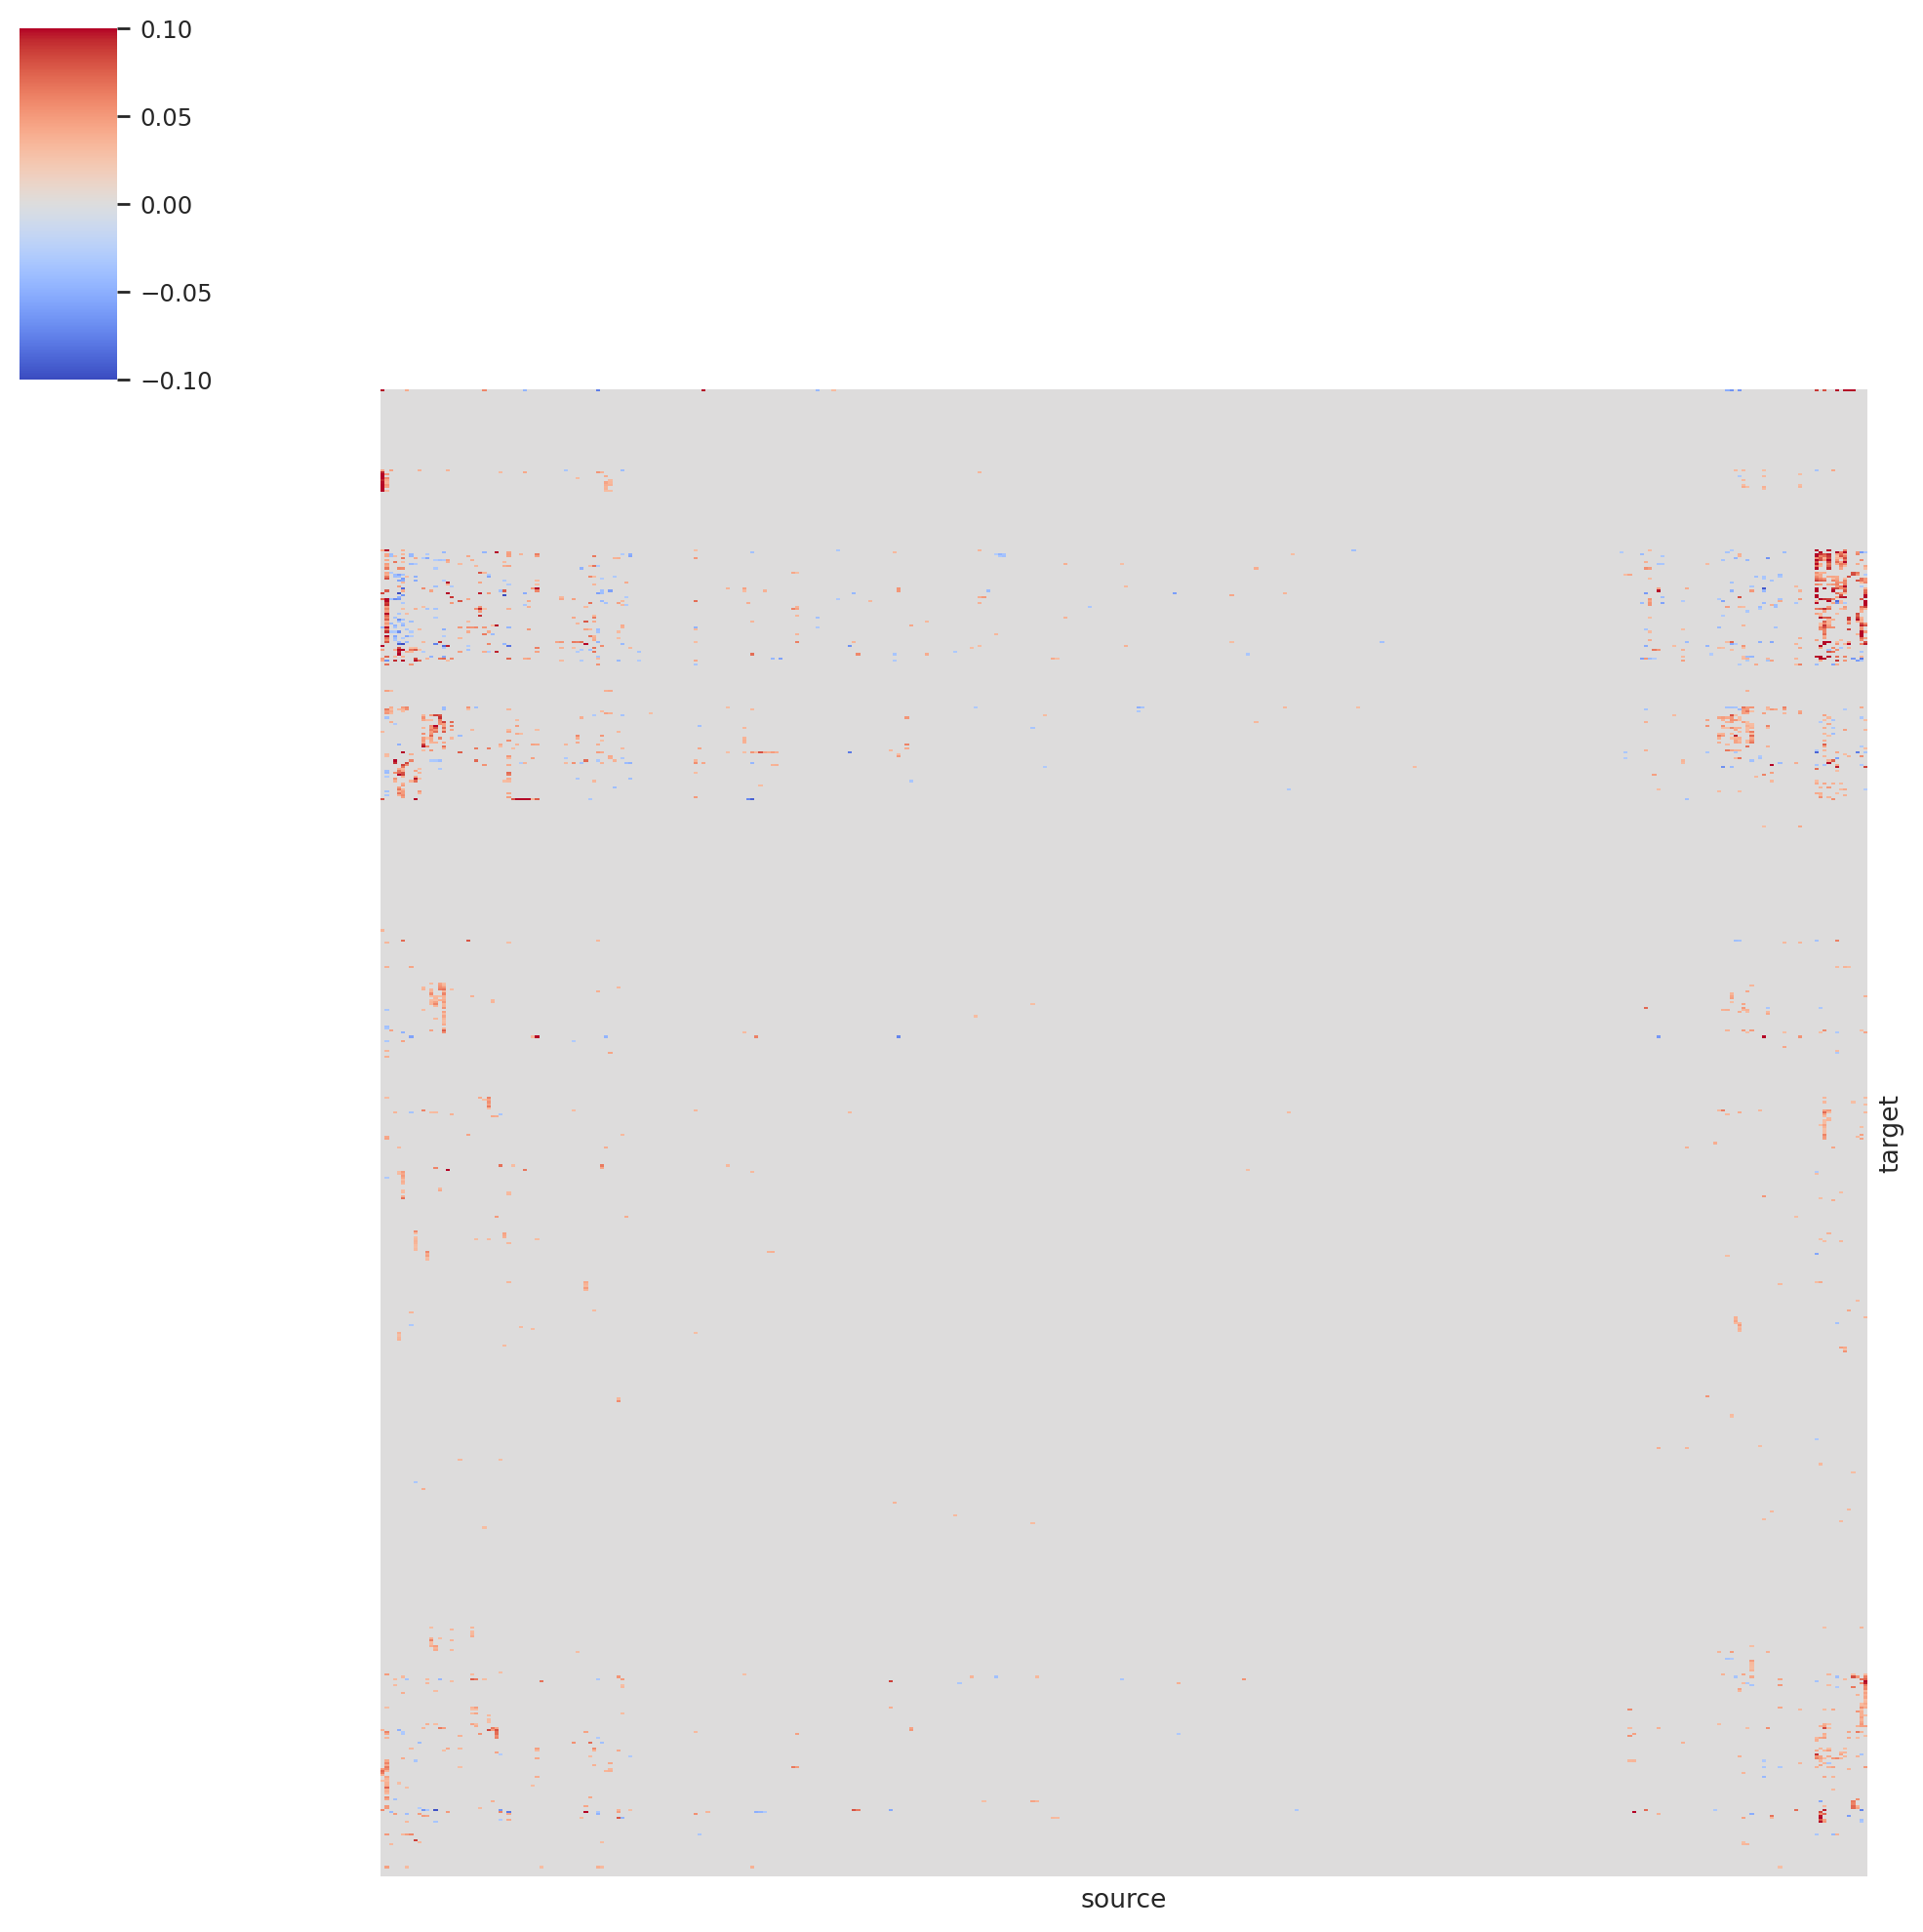

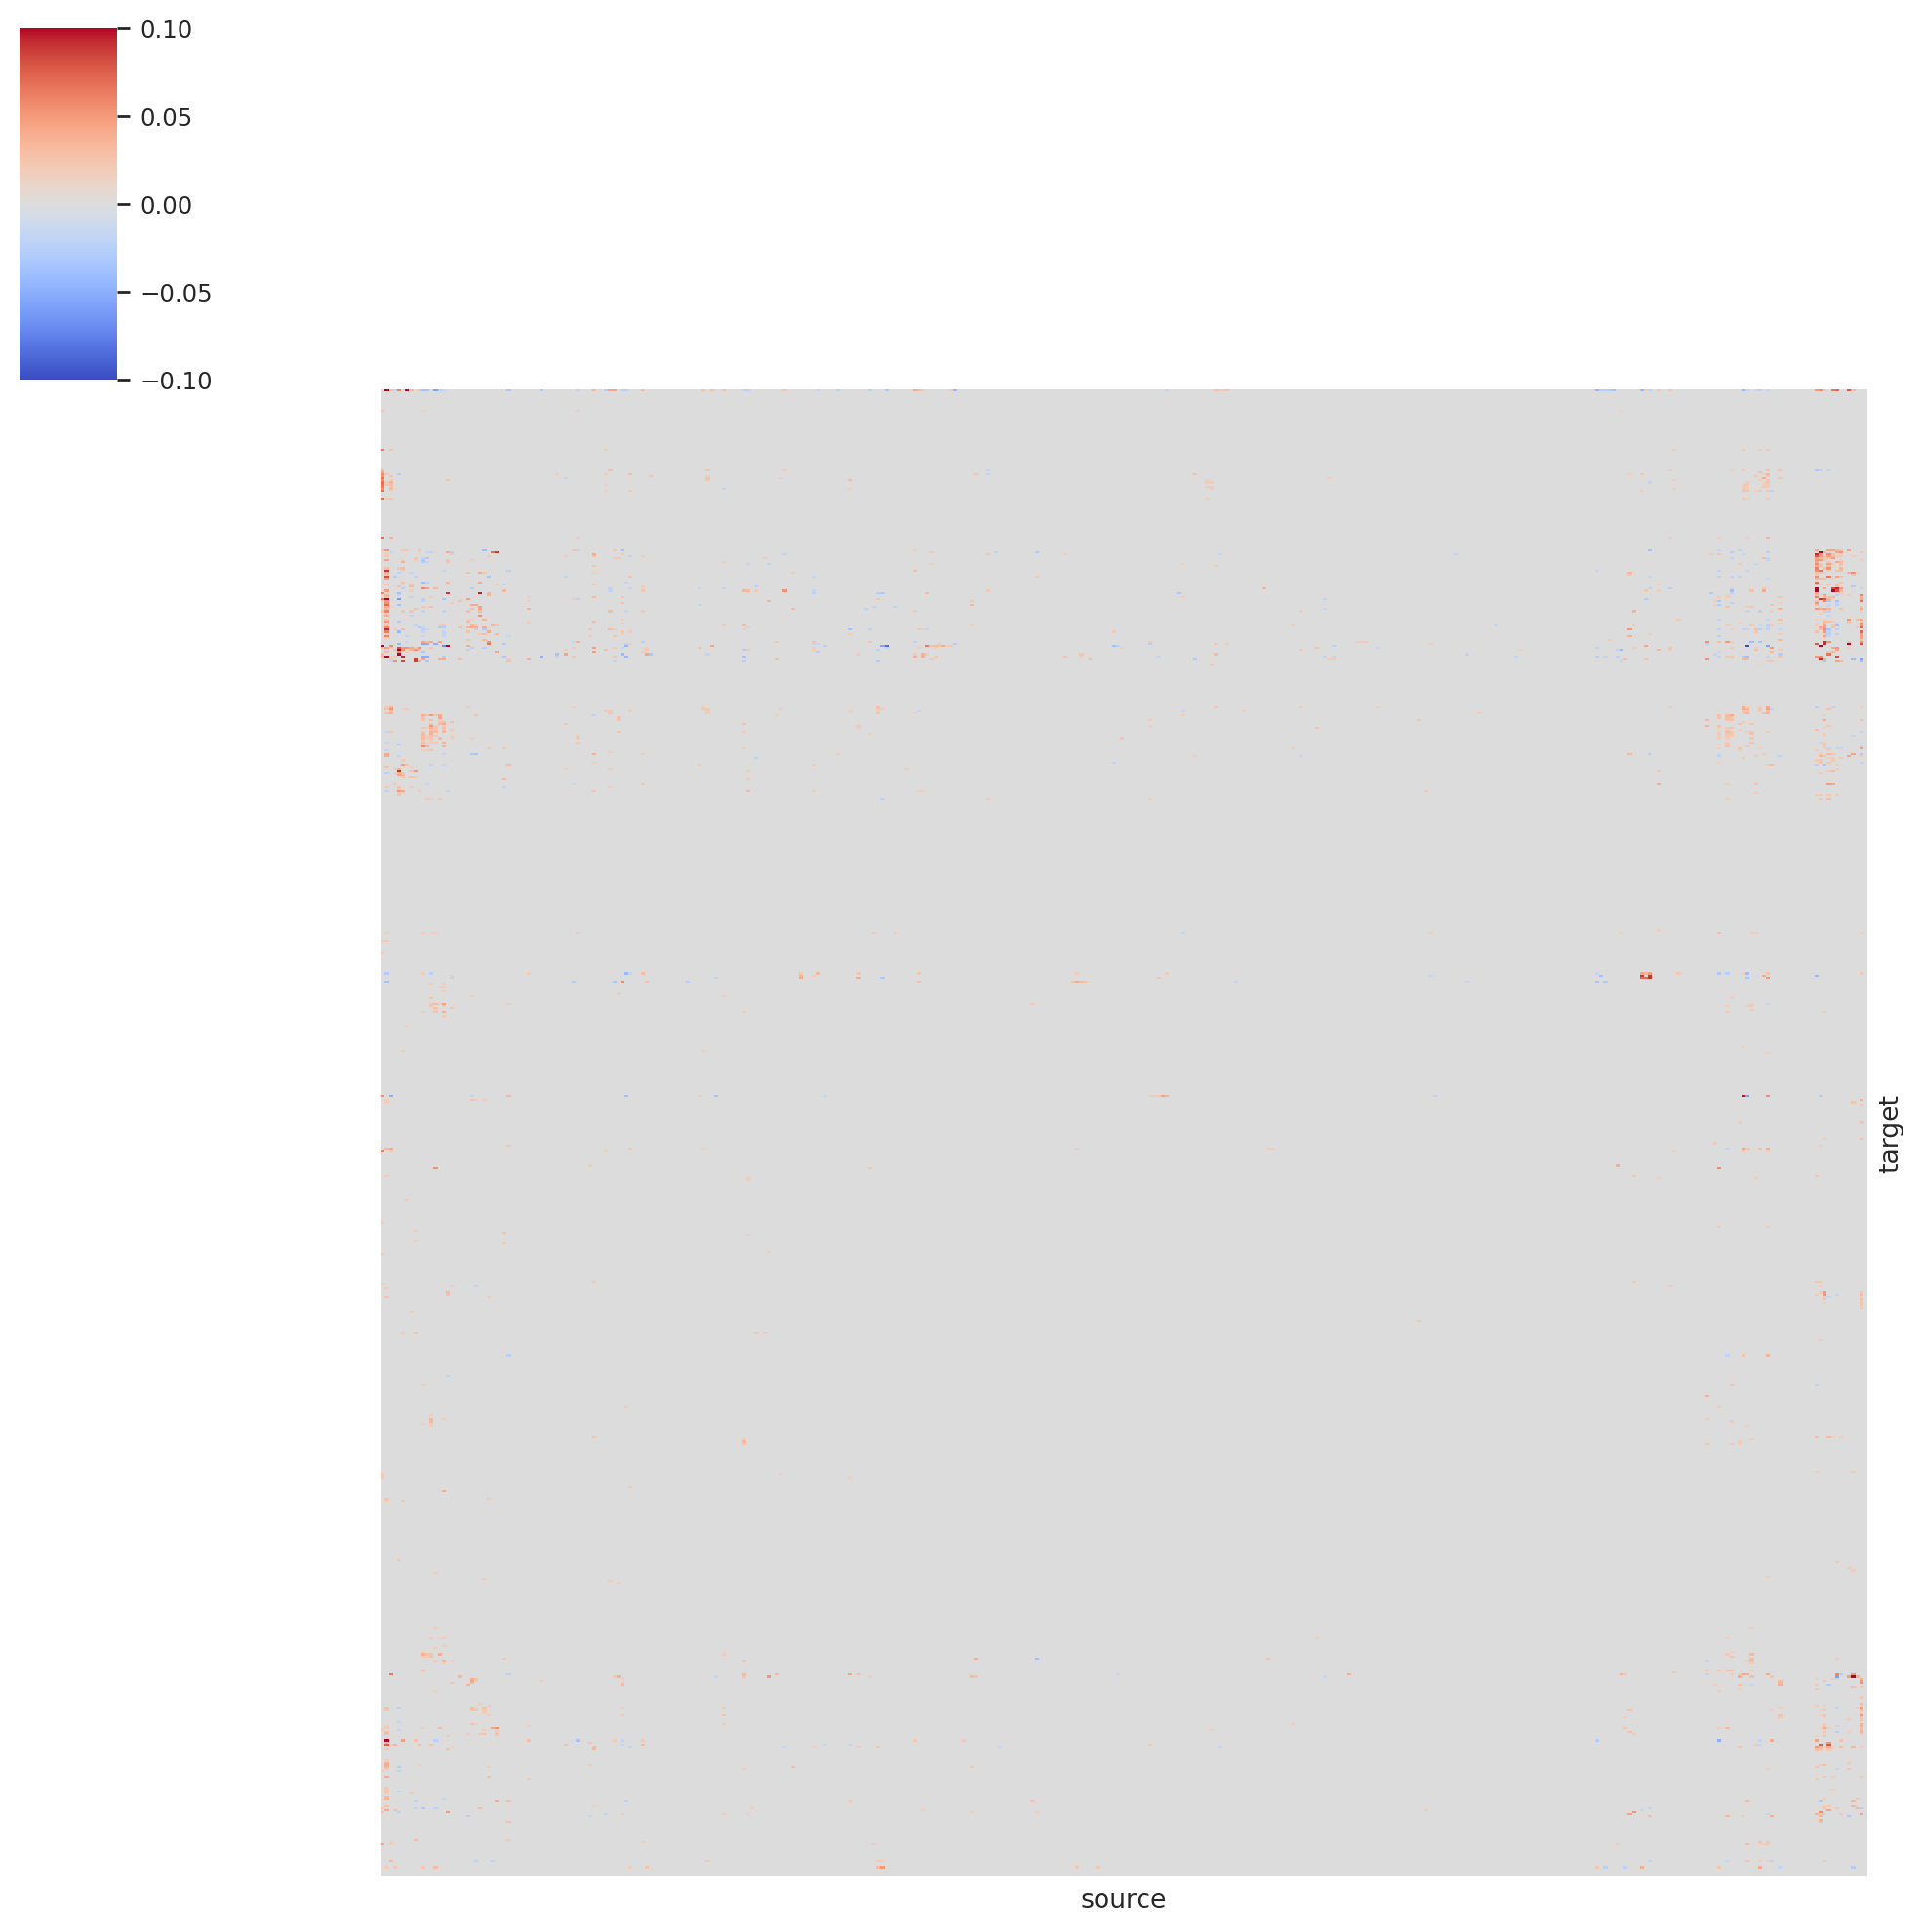

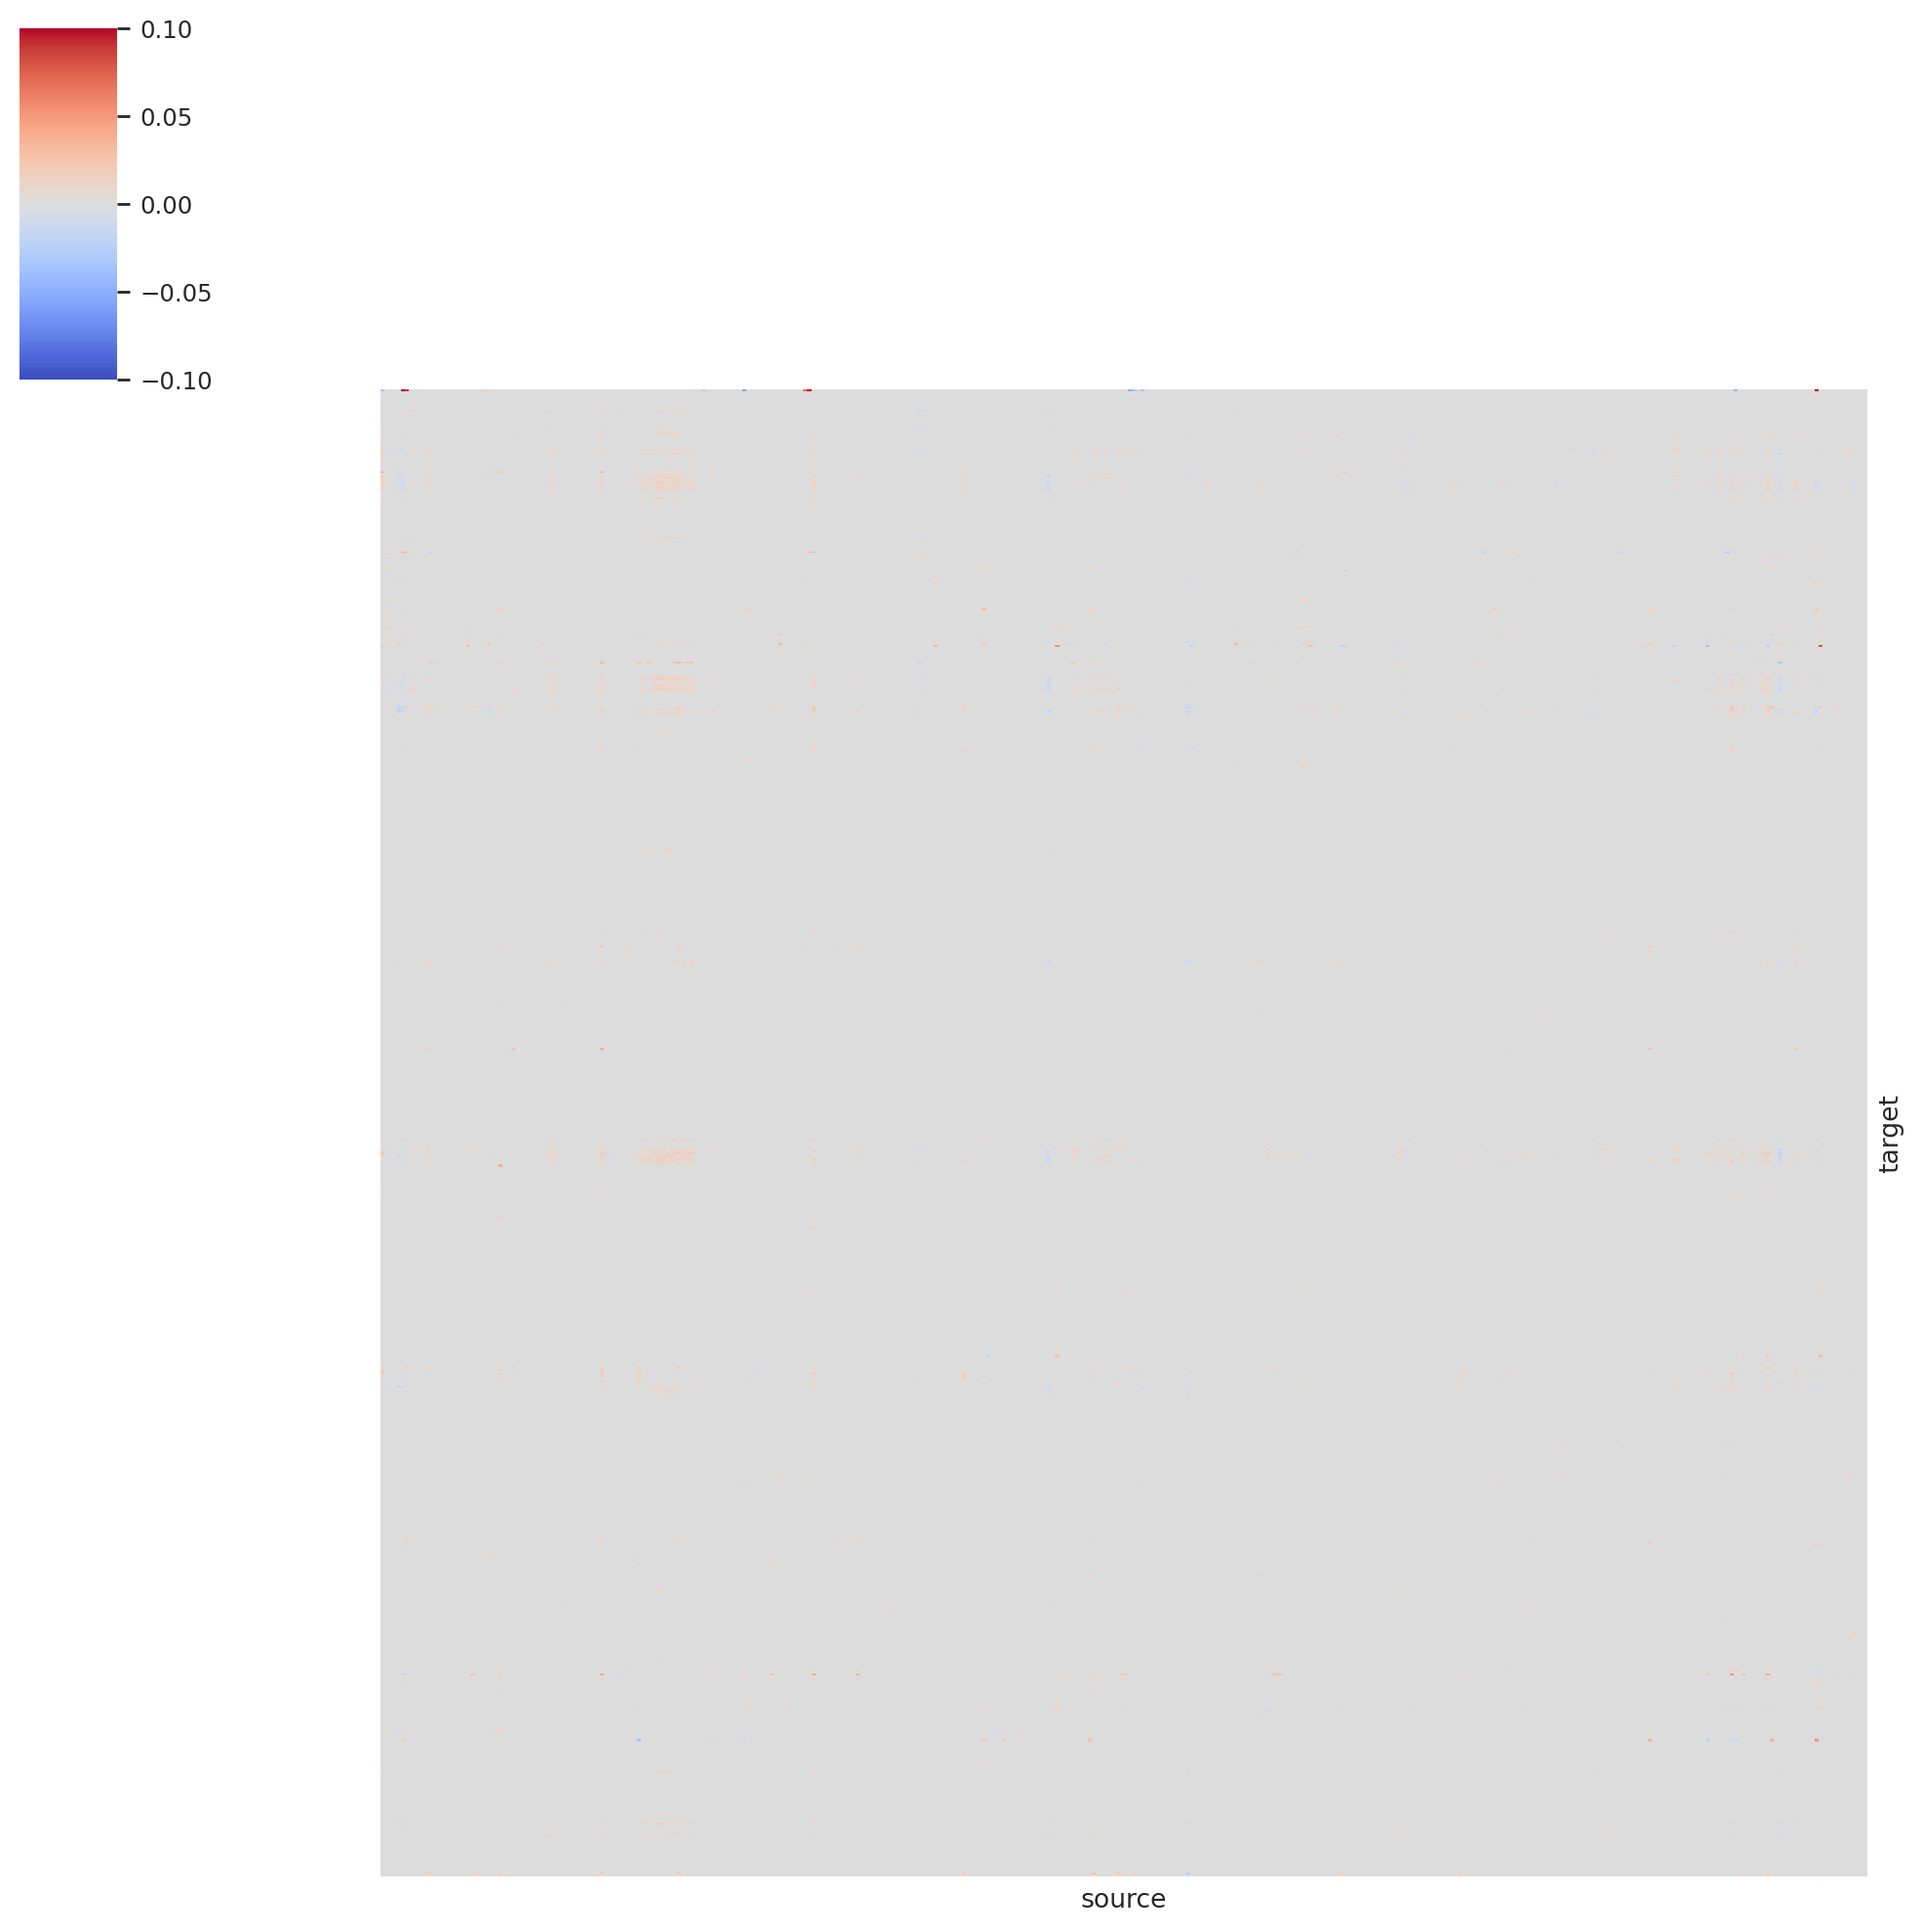

In [112]:
# For loop to plot the GRNs over timepoints
# Choose one celltype
celltype = "PSM"

# for all the rest of the timepoints (0-30 somites)
timepoints = ["TDR126", "TDR127", "TDR128", "TDR118", "TDR125", "TDR124"]
# define the dev stages corresponding to the timepoints list (for dataset IDs)
stages = ["0somites", "5somites", "10somites","15somites","20somites","30somites"]
stages

# Step 1. collect all sources and targets across all timepoints
all_sources = set()
all_targets = set()

for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    all_sources.update(df['source'].unique())
    all_targets.update(df['target'].unique())
    
# Step 2: Recreate each df_counts DataFrame
df_counts_union = {}

for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    # Pivot the original DataFrame
    df_pivot = df.pivot(index='target', columns='source', values='coef_mean').reindex(index=all_targets, columns=all_sources).fillna(0)
    df_counts_union[timepoint] = df_pivot
    
# # Assuming df_counts_union is your dictionary of adjusted count matrices
# timepoints = list(df_counts_union.keys())

# based on the histogram above, we'll define the vmax/vmin for color scale
# vmax = 0.15
# vmin = -0.15
vmax = 0.1
vmin = -0.1


# compute the linkages from the first and the last timepoints, by augmenting the "time" components
df_counts1 = df_counts_union["TDR126"]
df_counts2 = df_counts_union["TDR127"]
df_counts3 = df_counts_union["TDR128"]
df_counts4 = df_counts_union["TDR118"]
df_counts5 = df_counts_union["TDR125"]
df_counts6 = df_counts_union["TDR124"]

# concatenate over the columns
df_counts_rows = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=1)

# concatenate over the rows
df_counts_cols = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=0)

# create a clustered heatmap for the "rows"
g1 = sns.clustermap(df_counts_rows, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# create a clustered heatmap for the "cols"
g2 = sns.clustermap(df_counts_cols, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# extract the row/col indices
row_linkage = g1.dendrogram_row.linkage
col_linkage = g2.dendrogram_col.linkage

# Loop over all timepoints (using the pre-computed linkages from the first timepoint)
for idx, timepoint in enumerate(timepoints):
    # extract the df_counts at corresponding timepoint
    df_counts = df_counts_union[timepoint]
    
    # plot the clustermap
    g = sns.clustermap(df_counts, method='ward', metric='euclidean', 
                       cmap='coolwarm', standard_scale=None, 
                       row_cluster=True, col_cluster=True, 
                       xticklabels=False, yticklabels=False, 
                       vmax=vmax, vmin=vmin, 
                       row_linkage=row_linkage, col_linkage=col_linkage)
    
    # hide the dendrograms
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    
    # extract the dev stage
    stage=stages[idx]
    # save the plot
    # g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_coolwarm.pdf") # celltype is defined above where we computed df_counts_union
    # g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_coolwarm.png")

# # Display all heatmaps side by side with consistent clustering
plt.show()

### Sectioning the left-top for "decreasing over time"

In [106]:
df_counts_union.keys()

dict_keys(['TDR126', 'TDR127', 'TDR128', 'TDR118', 'TDR125', 'TDR124'])

In [111]:
df_counts_union["TDR126"]

source           nkx1.2la  gsx1  noto  neurod4  pknox2  cebpb  sp5a  lmx1al  \
target                                                                        
ptges3b               0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
si:dkey-67c22.2       0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
col11a1a              0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
anp32a                0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
ctnnb1                0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
...                   ...   ...   ...      ...     ...    ...   ...     ...   
hspa8                 0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
dut                   0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
nedd9                 0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
rpl28                 0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   
sfrp1a                0.0   0.0   0.0      0.0     0.0    0.0   0.0     0.0   

source           nkx6.3  onecut1  ...  vent  nkx2.4a  rorc  tbx19  nr1d1  \
target                            ...                                      
ptges3b             0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
si:dkey-67c22.2     0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
col11a1a            0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
anp32a              0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
ctnnb1              0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
...                 ...      ...  ...   ...      ...   ...    ...    ...   
hspa8               0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
dut                 0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
nedd9               0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
rpl28               0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   
sfrp1a              0.0      0.0  ...   0.0      0.0   0.0    0.0    0.0   

source           irx5a  gbx2    sox11a  vax1  creb3l3a  
target                                                  
ptges3b            0.0   0.0  0.000000   0.0       0.0  
si:dkey-67c22.2    0.0   0.0  0.028794   0.0       0.0  
col11a1a           0.0   0.0  0.000000   0.0       0.0  
anp32a             0.0   0.0  0.000000   0.0       0.0  
ctnnb1             0.0   0.0  0.027309   0.0       0.0  
...                ...   ...       ...   ...       ...  
hspa8              0.0   0.0  0.000000   0.0       0.0  
dut                0.0   0.0  0.000000   0.0       0.0  
nedd9              0.0   0.0  0.000000   0.0       0.0  
rpl28              0.0   0.0  0.000000   0.0       0.0  
sfrp1a             0.0   0.0  0.000000   0.0       0.0  

[727 rows x 366 columns]

In [110]:
# Check the GRN at the first timepoint
df_counts = df_counts_union["TDR126"]

# Assuming you have determined your cluster size and its position (last N rows and M columns)
N = 50  # The number of rows in the cluster, replace with the actual number
M = 5  # The number of columns in the cluster, replace with the actual number

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g.dendrogram_row.reordered_ind[0:N]
col_indices = g.dendrogram_col.reordered_ind[0:M]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source              hmga1a     meox1    sox19a       vox     tbx16
target                                                            
apoc1             0.296917  0.000000  0.000000  0.000000  0.000000
u2af2b            0.097756  0.000000  0.000000  0.000000  0.000000
dut               0.045461  0.000000  0.000000  0.042787  0.000000
bzw1a             0.146815  0.000000  0.032549  0.000000  0.000000
marcksb           0.129412  0.000000  0.000000  0.037676  0.000000
eif5a2            0.094876  0.029633  0.038652  0.000000  0.000000
aldoaa            0.105316  0.025409  0.031386  0.000000  0.000000
anp32e            0.136693  0.000000  0.052257  0.029508  0.000000
fbl               0.090248  0.026377  0.025611  0.000000  0.000000
srrm2             0.128063  0.000000  0.000000  0.031265  0.000000
mdkb              0.079583  0.000000  0.000000  0.000000  0.000000
eif4a1a           0.087982  0.000000  0.041373  0.000000  0.000000
ppp2cb            0.069841  0.000000  0.027314  0.034229  0.00

In [113]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union["TDR126"]

df_counts_0somites_upreg = df_counts.loc[row_names, col_names]
df_counts_0somites_upreg

source              hmga1a     meox1    sox19a       vox     tbx16
target                                                            
apoc1             0.296917  0.000000  0.000000  0.000000  0.000000
u2af2b            0.097756  0.000000  0.000000  0.000000  0.000000
dut               0.045461  0.000000  0.000000  0.042787  0.000000
bzw1a             0.146815  0.000000  0.032549  0.000000  0.000000
marcksb           0.129412  0.000000  0.000000  0.037676  0.000000
eif5a2            0.094876  0.029633  0.038652  0.000000  0.000000
aldoaa            0.105316  0.025409  0.031386  0.000000  0.000000
anp32e            0.136693  0.000000  0.052257  0.029508  0.000000
fbl               0.090248  0.026377  0.025611  0.000000  0.000000
srrm2             0.128063  0.000000  0.000000  0.031265  0.000000
mdkb              0.079583  0.000000  0.000000  0.000000  0.000000
eif4a1a           0.087982  0.000000  0.041373  0.000000  0.000000
ppp2cb            0.069841  0.000000  0.027314  0.034229  0.000000
anp32a            0.084693  0.026104  0.000000  0.000000  0.000000
ppig              0.041352  0.000000  0.032896  0.000000  0.000000
ube2v2            0.096596  0.028912  0.000000  0.000000  0.000000
metap2b           0.102340  0.038654  0.000000  0.055235  0.000000
rsl1d1            0.107134  0.045762  0.000000  0.047146 -0.031414
cd3eap            0.062700  0.027816  0.000000  0.000000  0.000000
top1l             0.121157  0.000000  0.038587  0.000000  0.000000
dkc1              0.117420  0.000000  0.000000  0.043549  0.000000
nop56             0.099329  0.036328  0.000000  0.031124  0.000000
cnbpb             0.088263  0.048440  0.052207  0.033262  0.000000
hnrnpa1b          0.073647  0.033462  0.047643  0.000000  0.000000
tubb2b            0.127840  0.000000  0.057801  0.000000  0.000000
eef1g             0.150804  0.034266  0.070476  0.000000  0.000000
anp32b            0.124822  0.000000  0.027503  0.059913  0.000000
cbx3a             0.135827  0.000000  0.079586  0.000000  0.000000
rpl5b             0.261669  0.000000  0.000000  0.000000  0.000000
eef1a1l1          0.187946  0.000000  0.039959  0.043298  0.000000
snrpg             0.193163  0.000000  0.000000  0.000000  0.000000
rpl12             0.195000  0.000000  0.035811  0.000000  0.000000
rplp2l            0.198905  0.000000  0.000000  0.036495  0.000000
pabpc1a           0.186085  0.000000  0.000000  0.000000  0.000000
tma7              0.131071  0.000000  0.043753  0.032010  0.000000
rps24             0.158123  0.000000  0.043831  0.035046  0.000000
ubc               0.143738  0.000000  0.034571  0.000000  0.000000
eef2b             0.180978  0.000000  0.000000  0.033310  0.000000
rpl29             0.165861  0.000000  0.035943  0.033493  0.000000
mki67             0.075132  0.000000  0.029440  0.000000  0.000000
rrm2              0.186573  0.000000  0.000000  0.000000  0.000000
nop58             0.146266  0.056569  0.000000  0.000000  0.000000
cfl1              0.122664  0.000000  0.062523  0.038200  0.000000
ncl               0.259855  0.033538  0.000000  0.027434  0.000000
npm1a             0.157469  0.027116  0.027895  0.052923  0.000000
hmgn2             0.198301  0.000000  0.000000  0.000000  0.000000
si:ch73-281n10.2  0.168253  0.000000  0.030901  0.035786  0.000000
hsp90ab1          0.196928  0.000000  0.059903  0.000000  0.000000
ptmab             0.209939  0.000000  0.048333  0.039032  0.000000
hmgb2a            0.189838  0.000000  0.039209  0.036143  0.000000

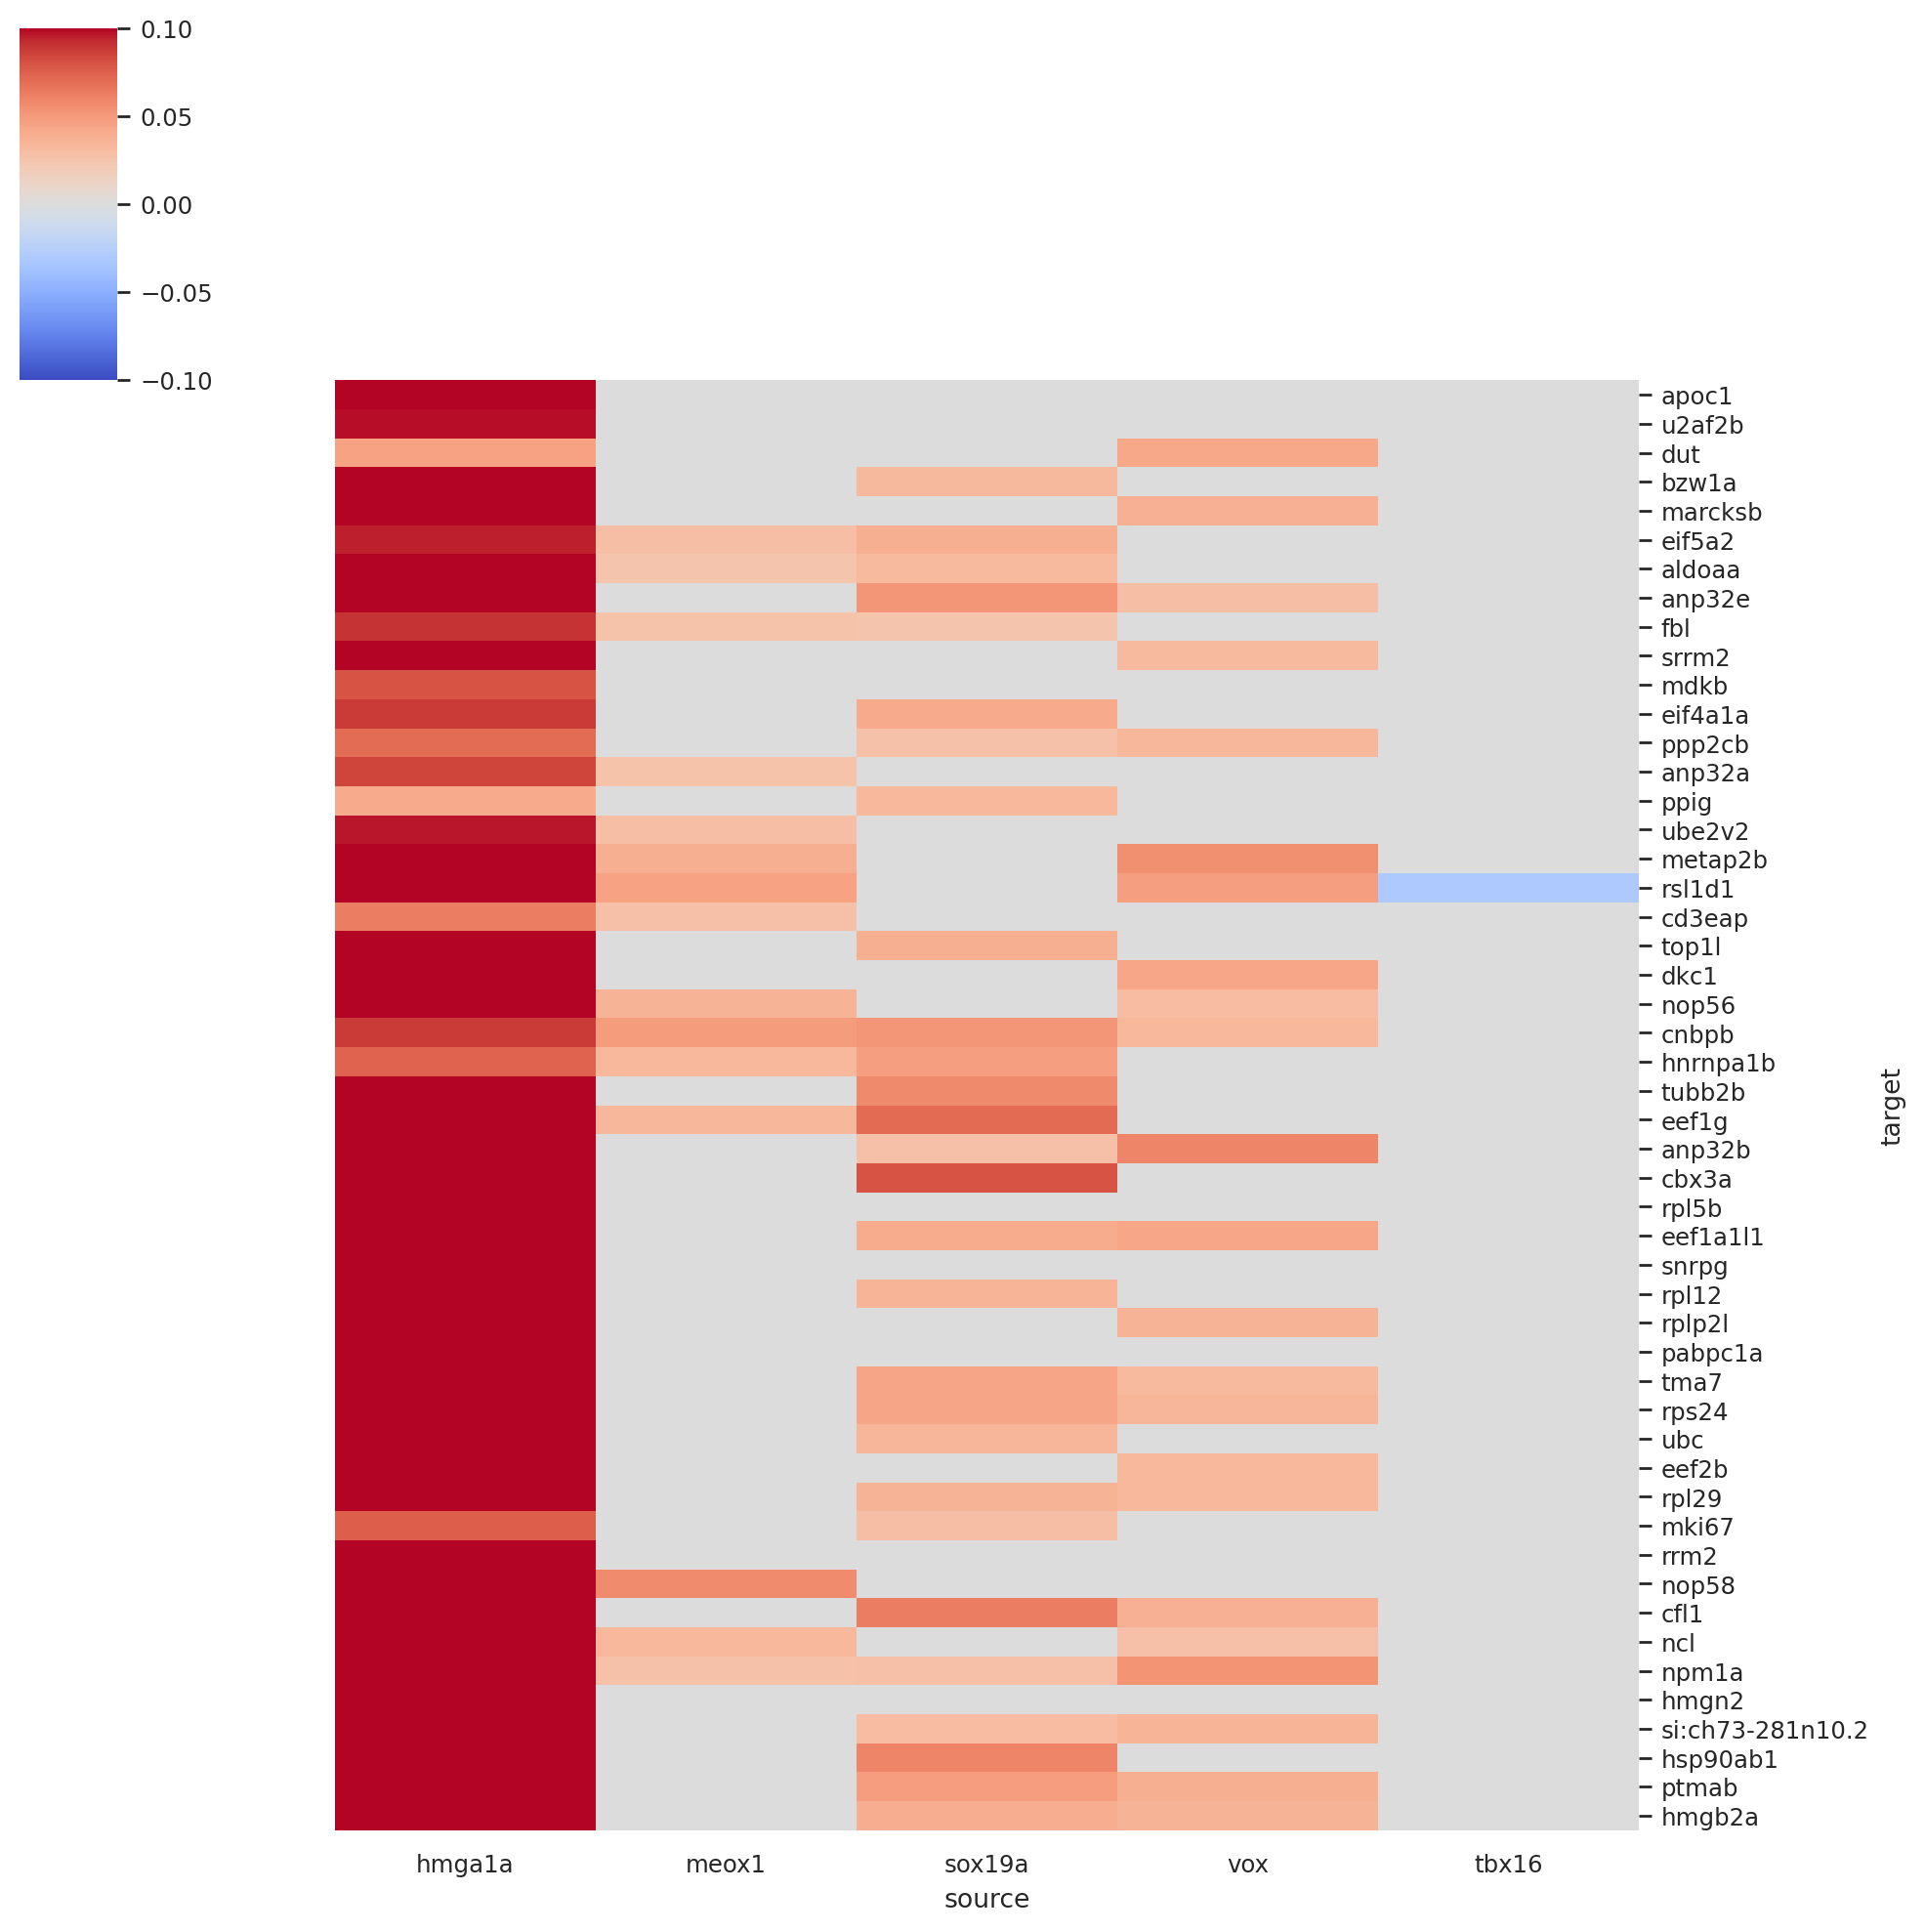

In [114]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_0somites_upreg, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "PSM"
stage = "0somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}.png")

plt.show()

### Spinal_cord (as an alternative to PSM)

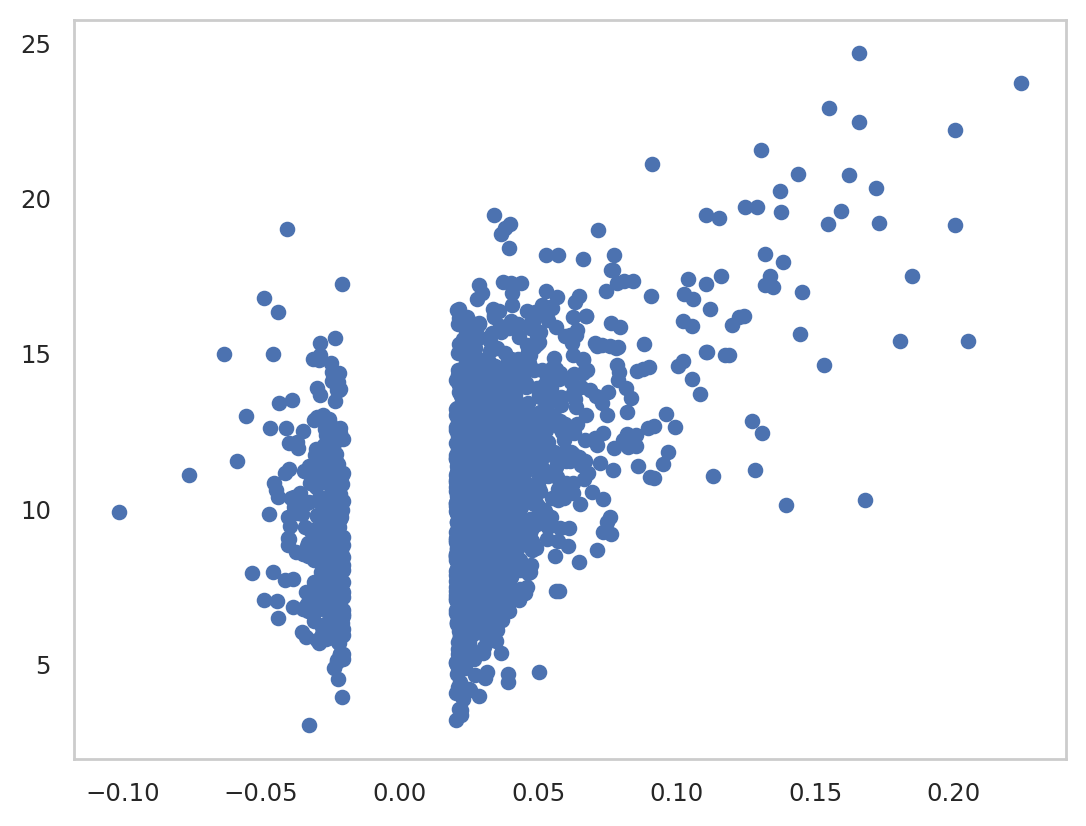

In [115]:
# Check the coef_abs (GRN edge strength_ distribution for GRN[ct, 30-somites]
df_GRN_test = dict_filtered_GRNs["TDR127"]["spinal_cord"]

plt.scatter(df_GRN_test["coef_mean"], df_GRN_test["-logp"])
plt.grid(False)
plt.show()

From here, we'll use the 0.1 and -0.1 as v_max and v_min.

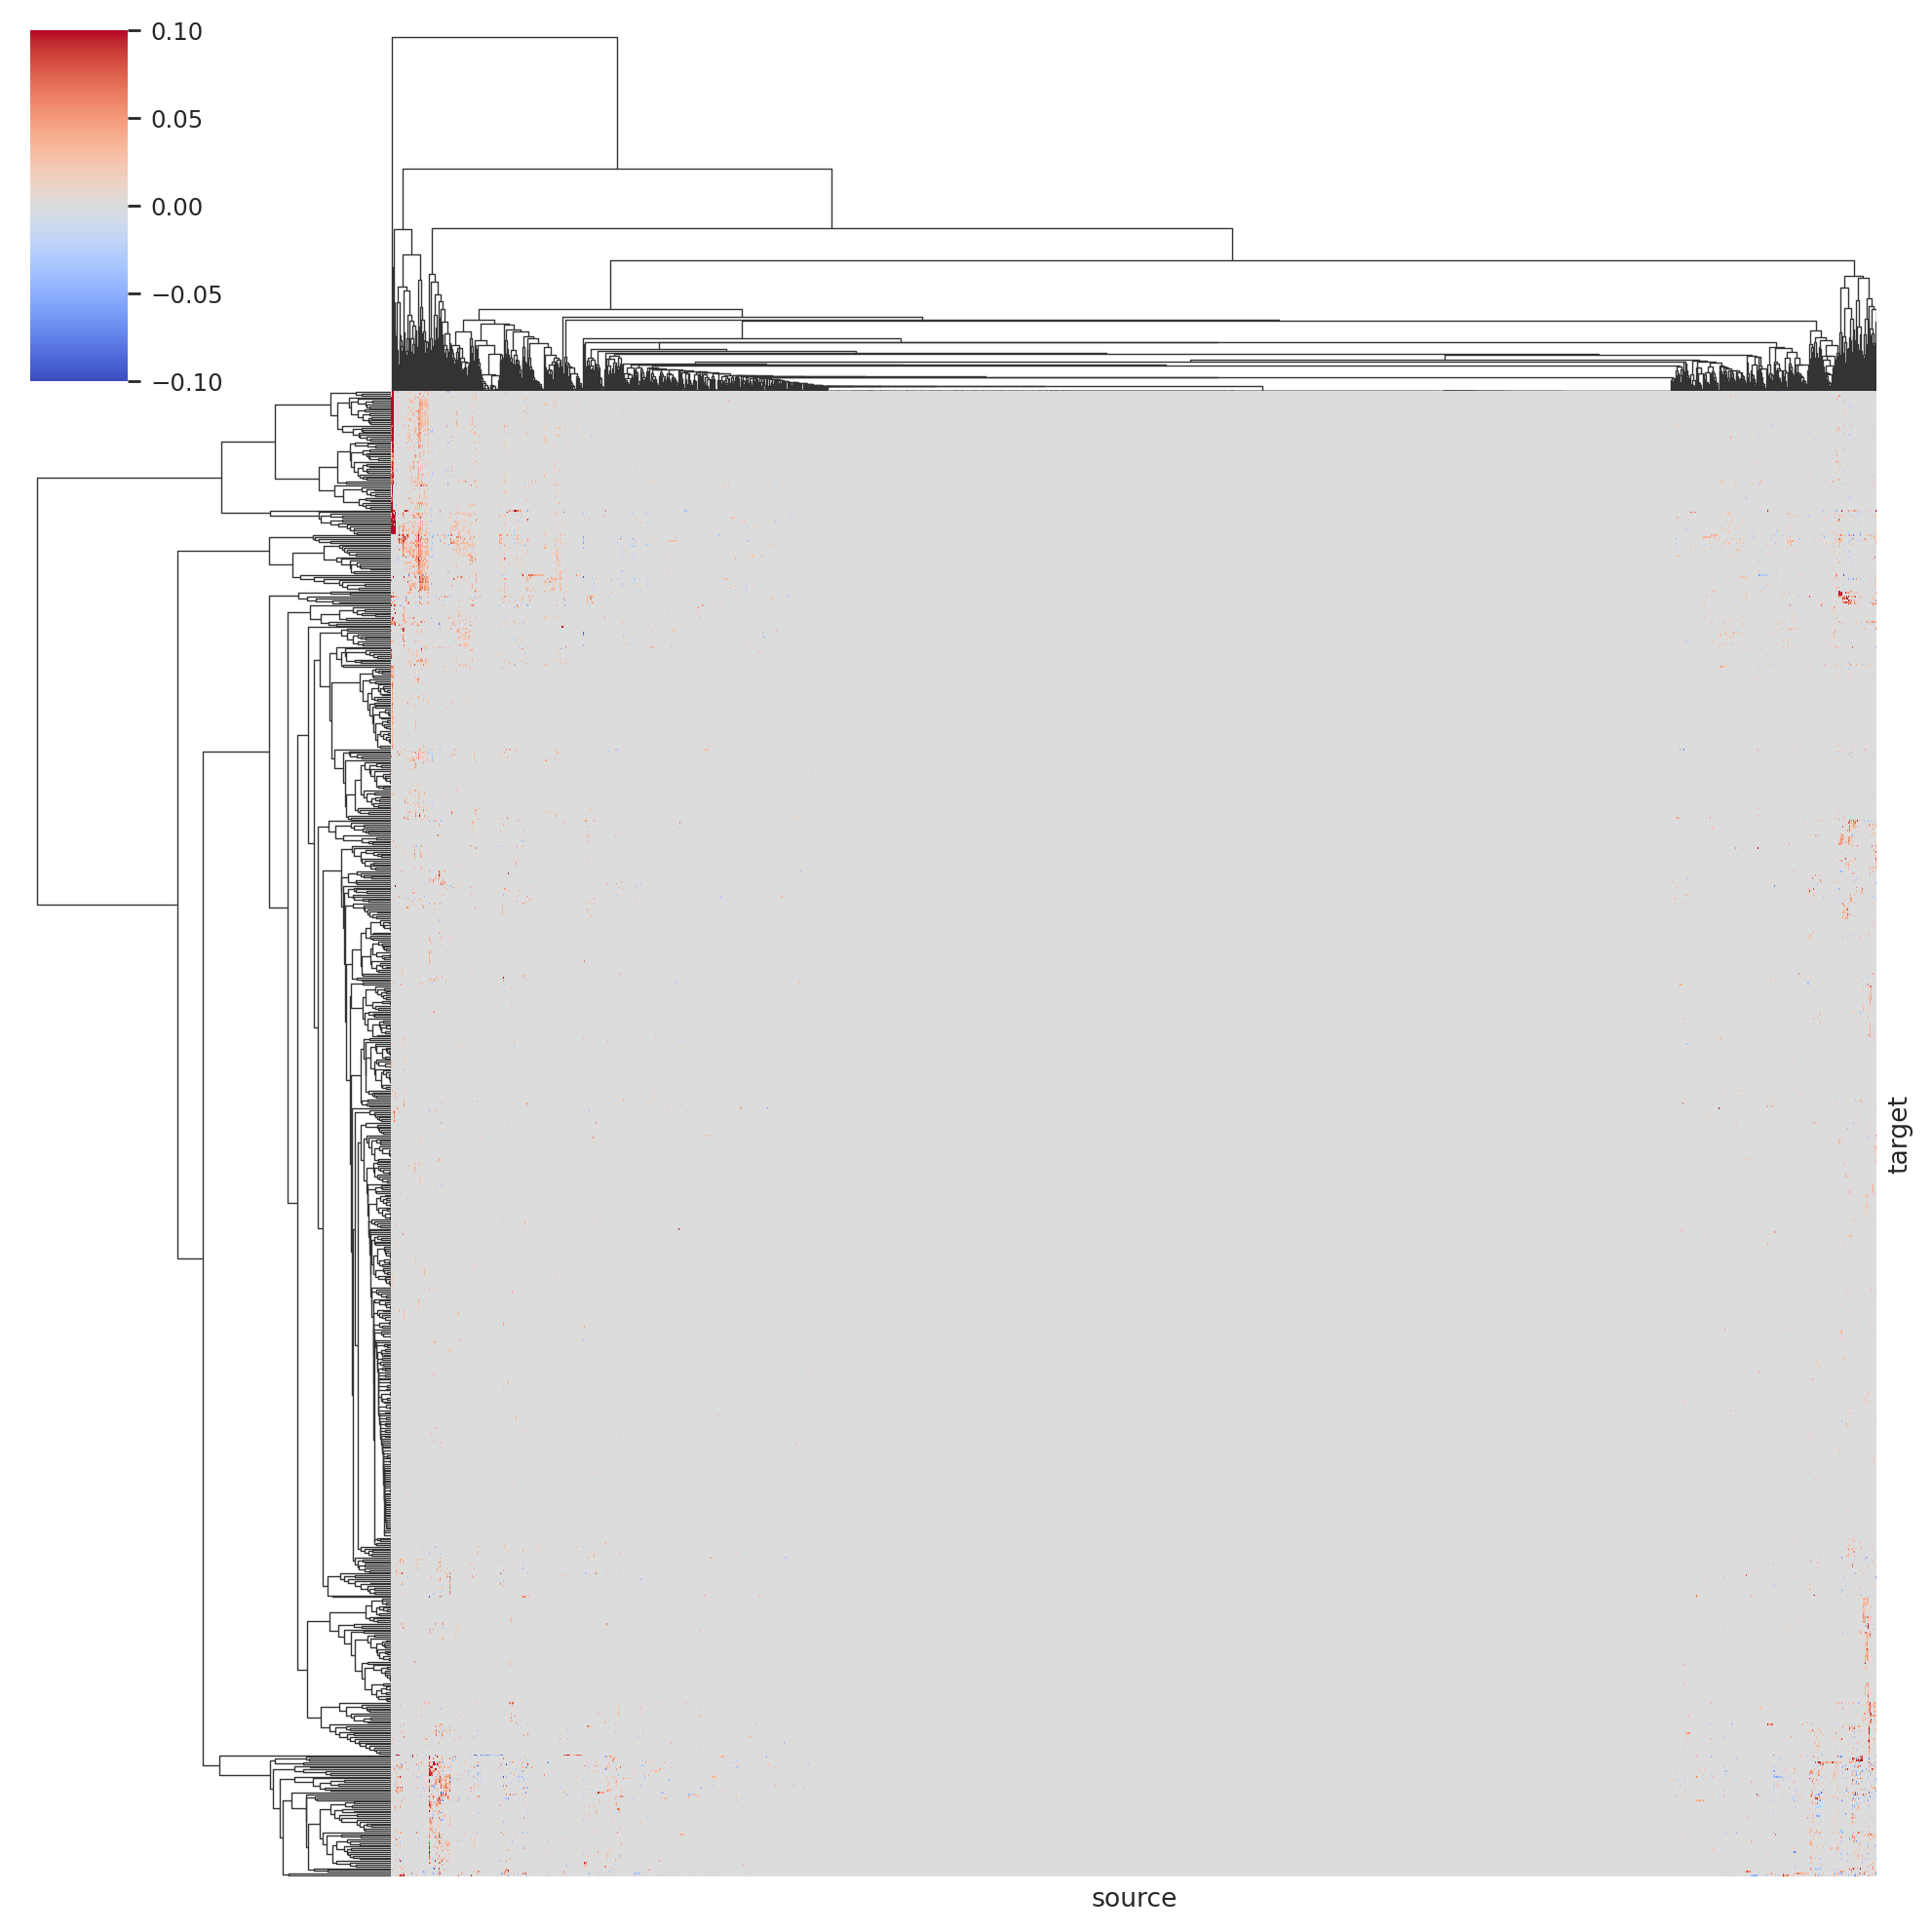

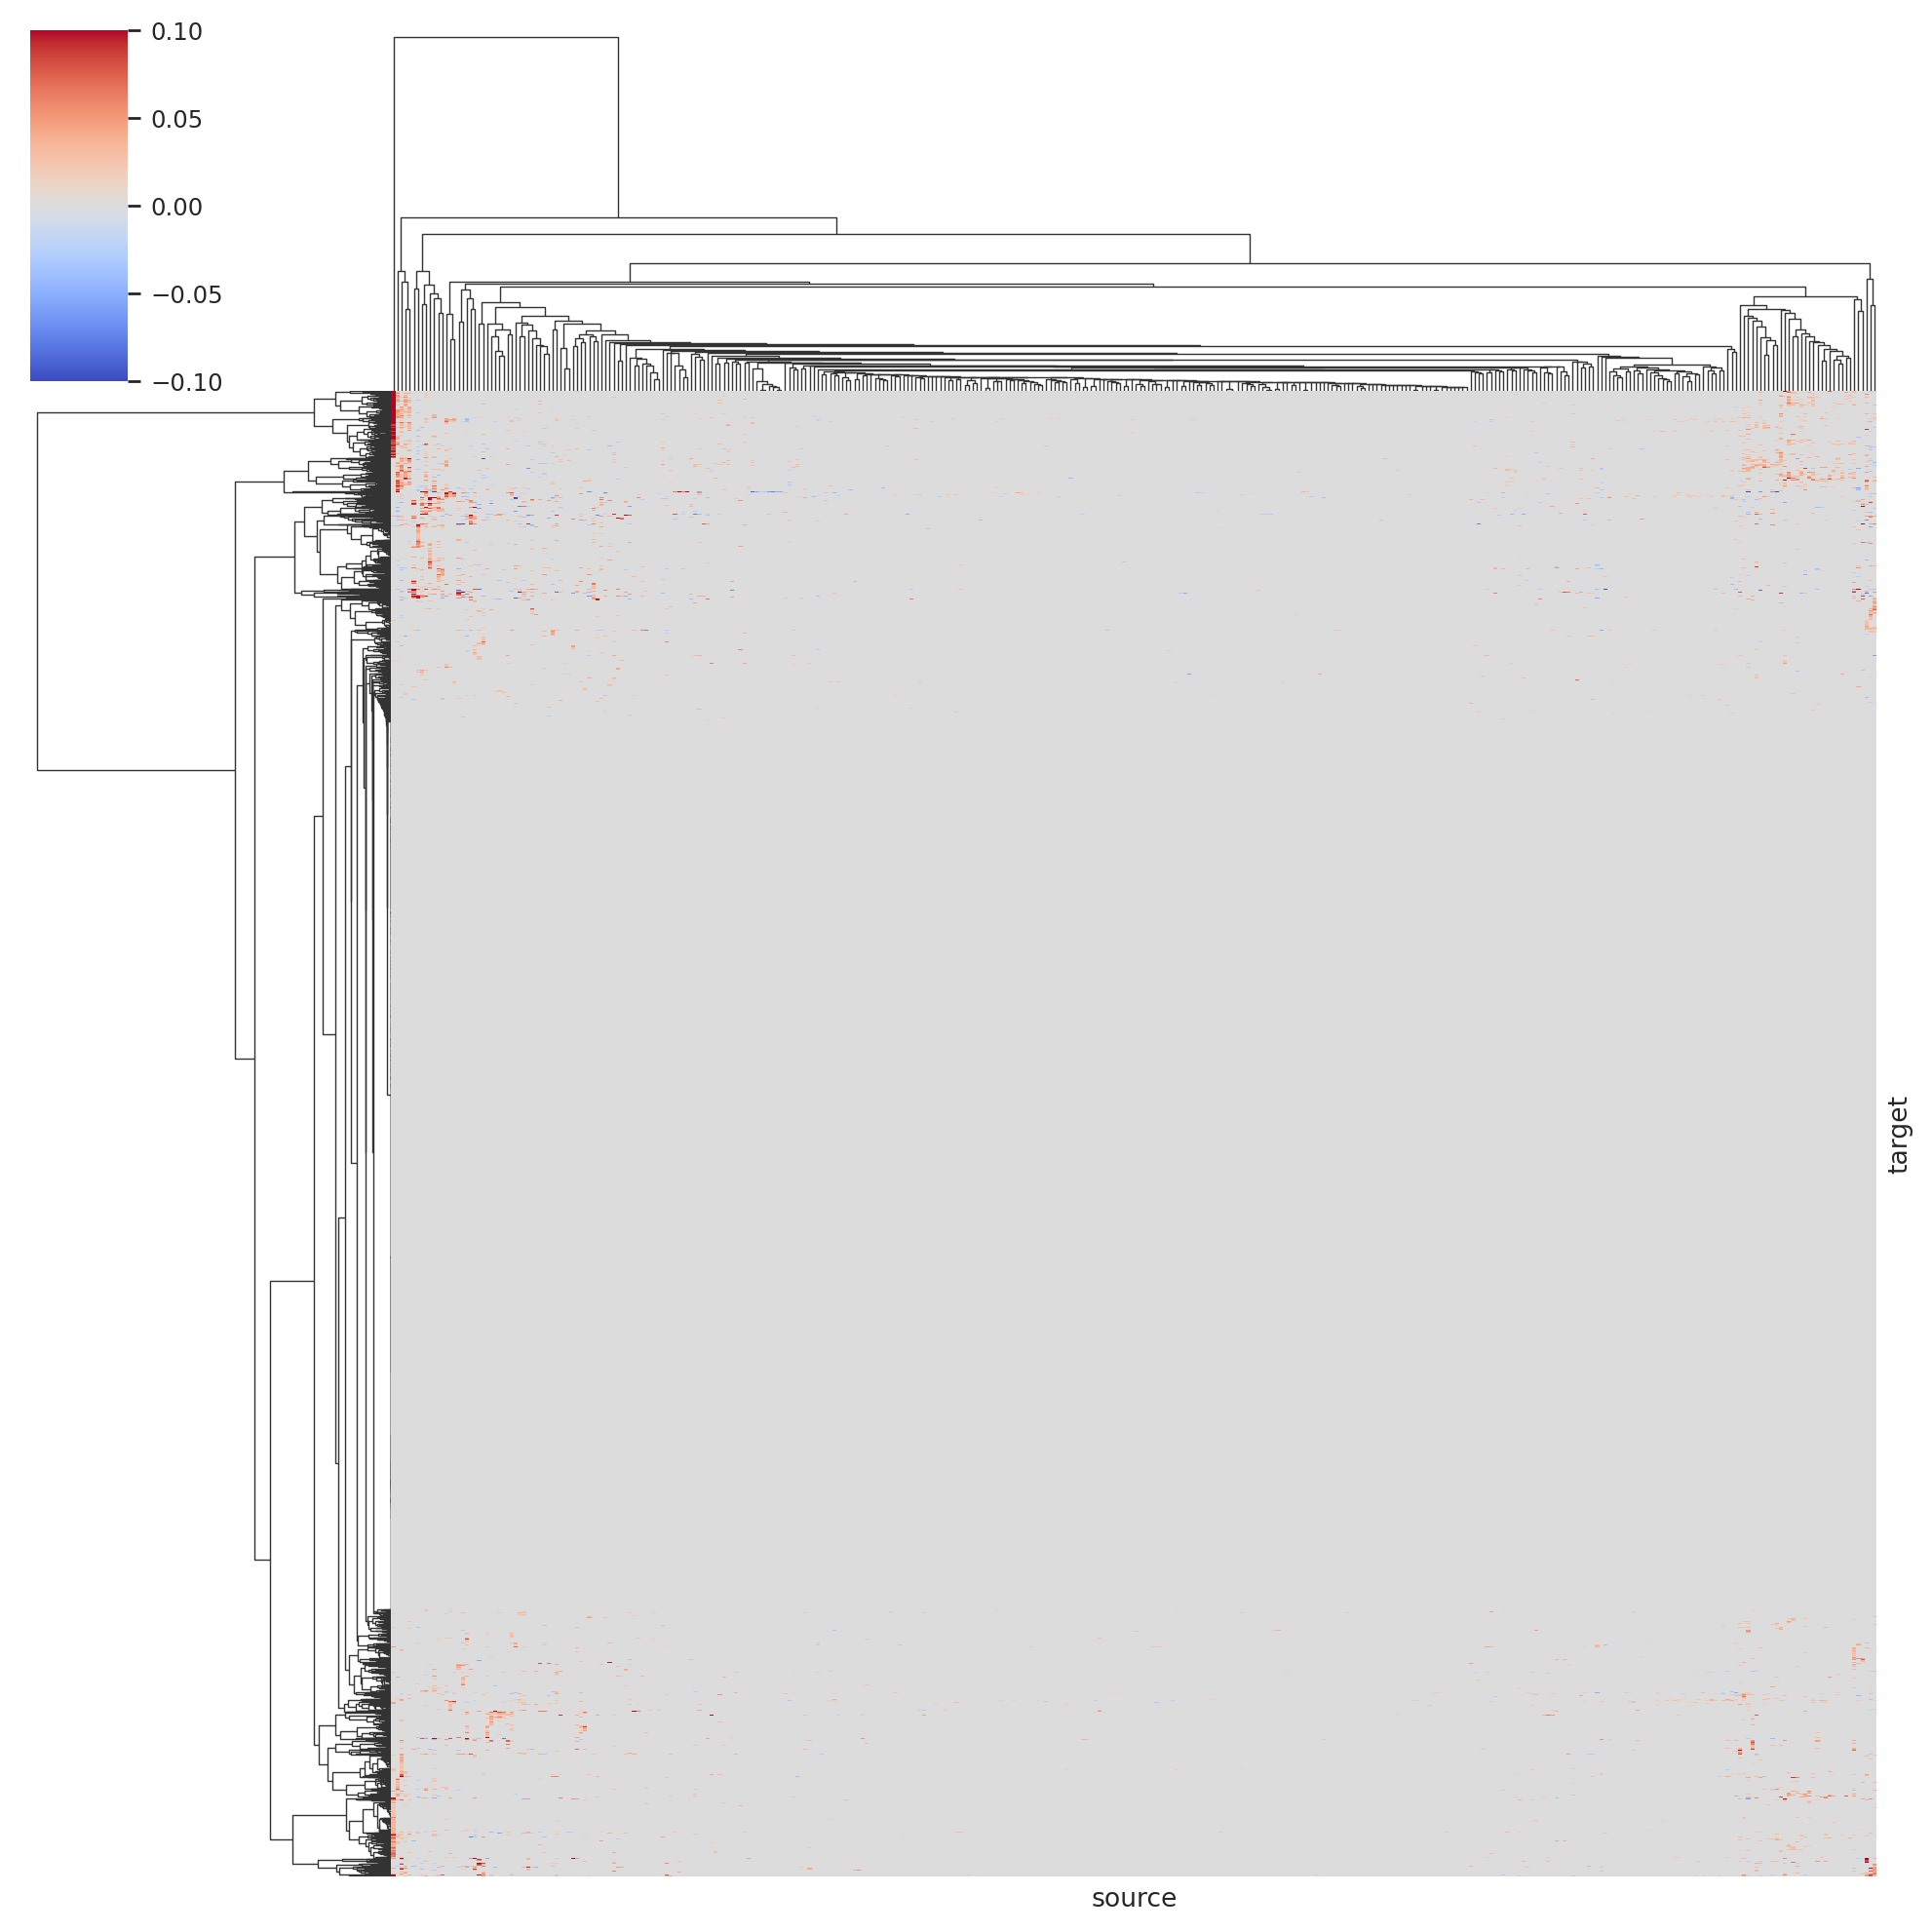

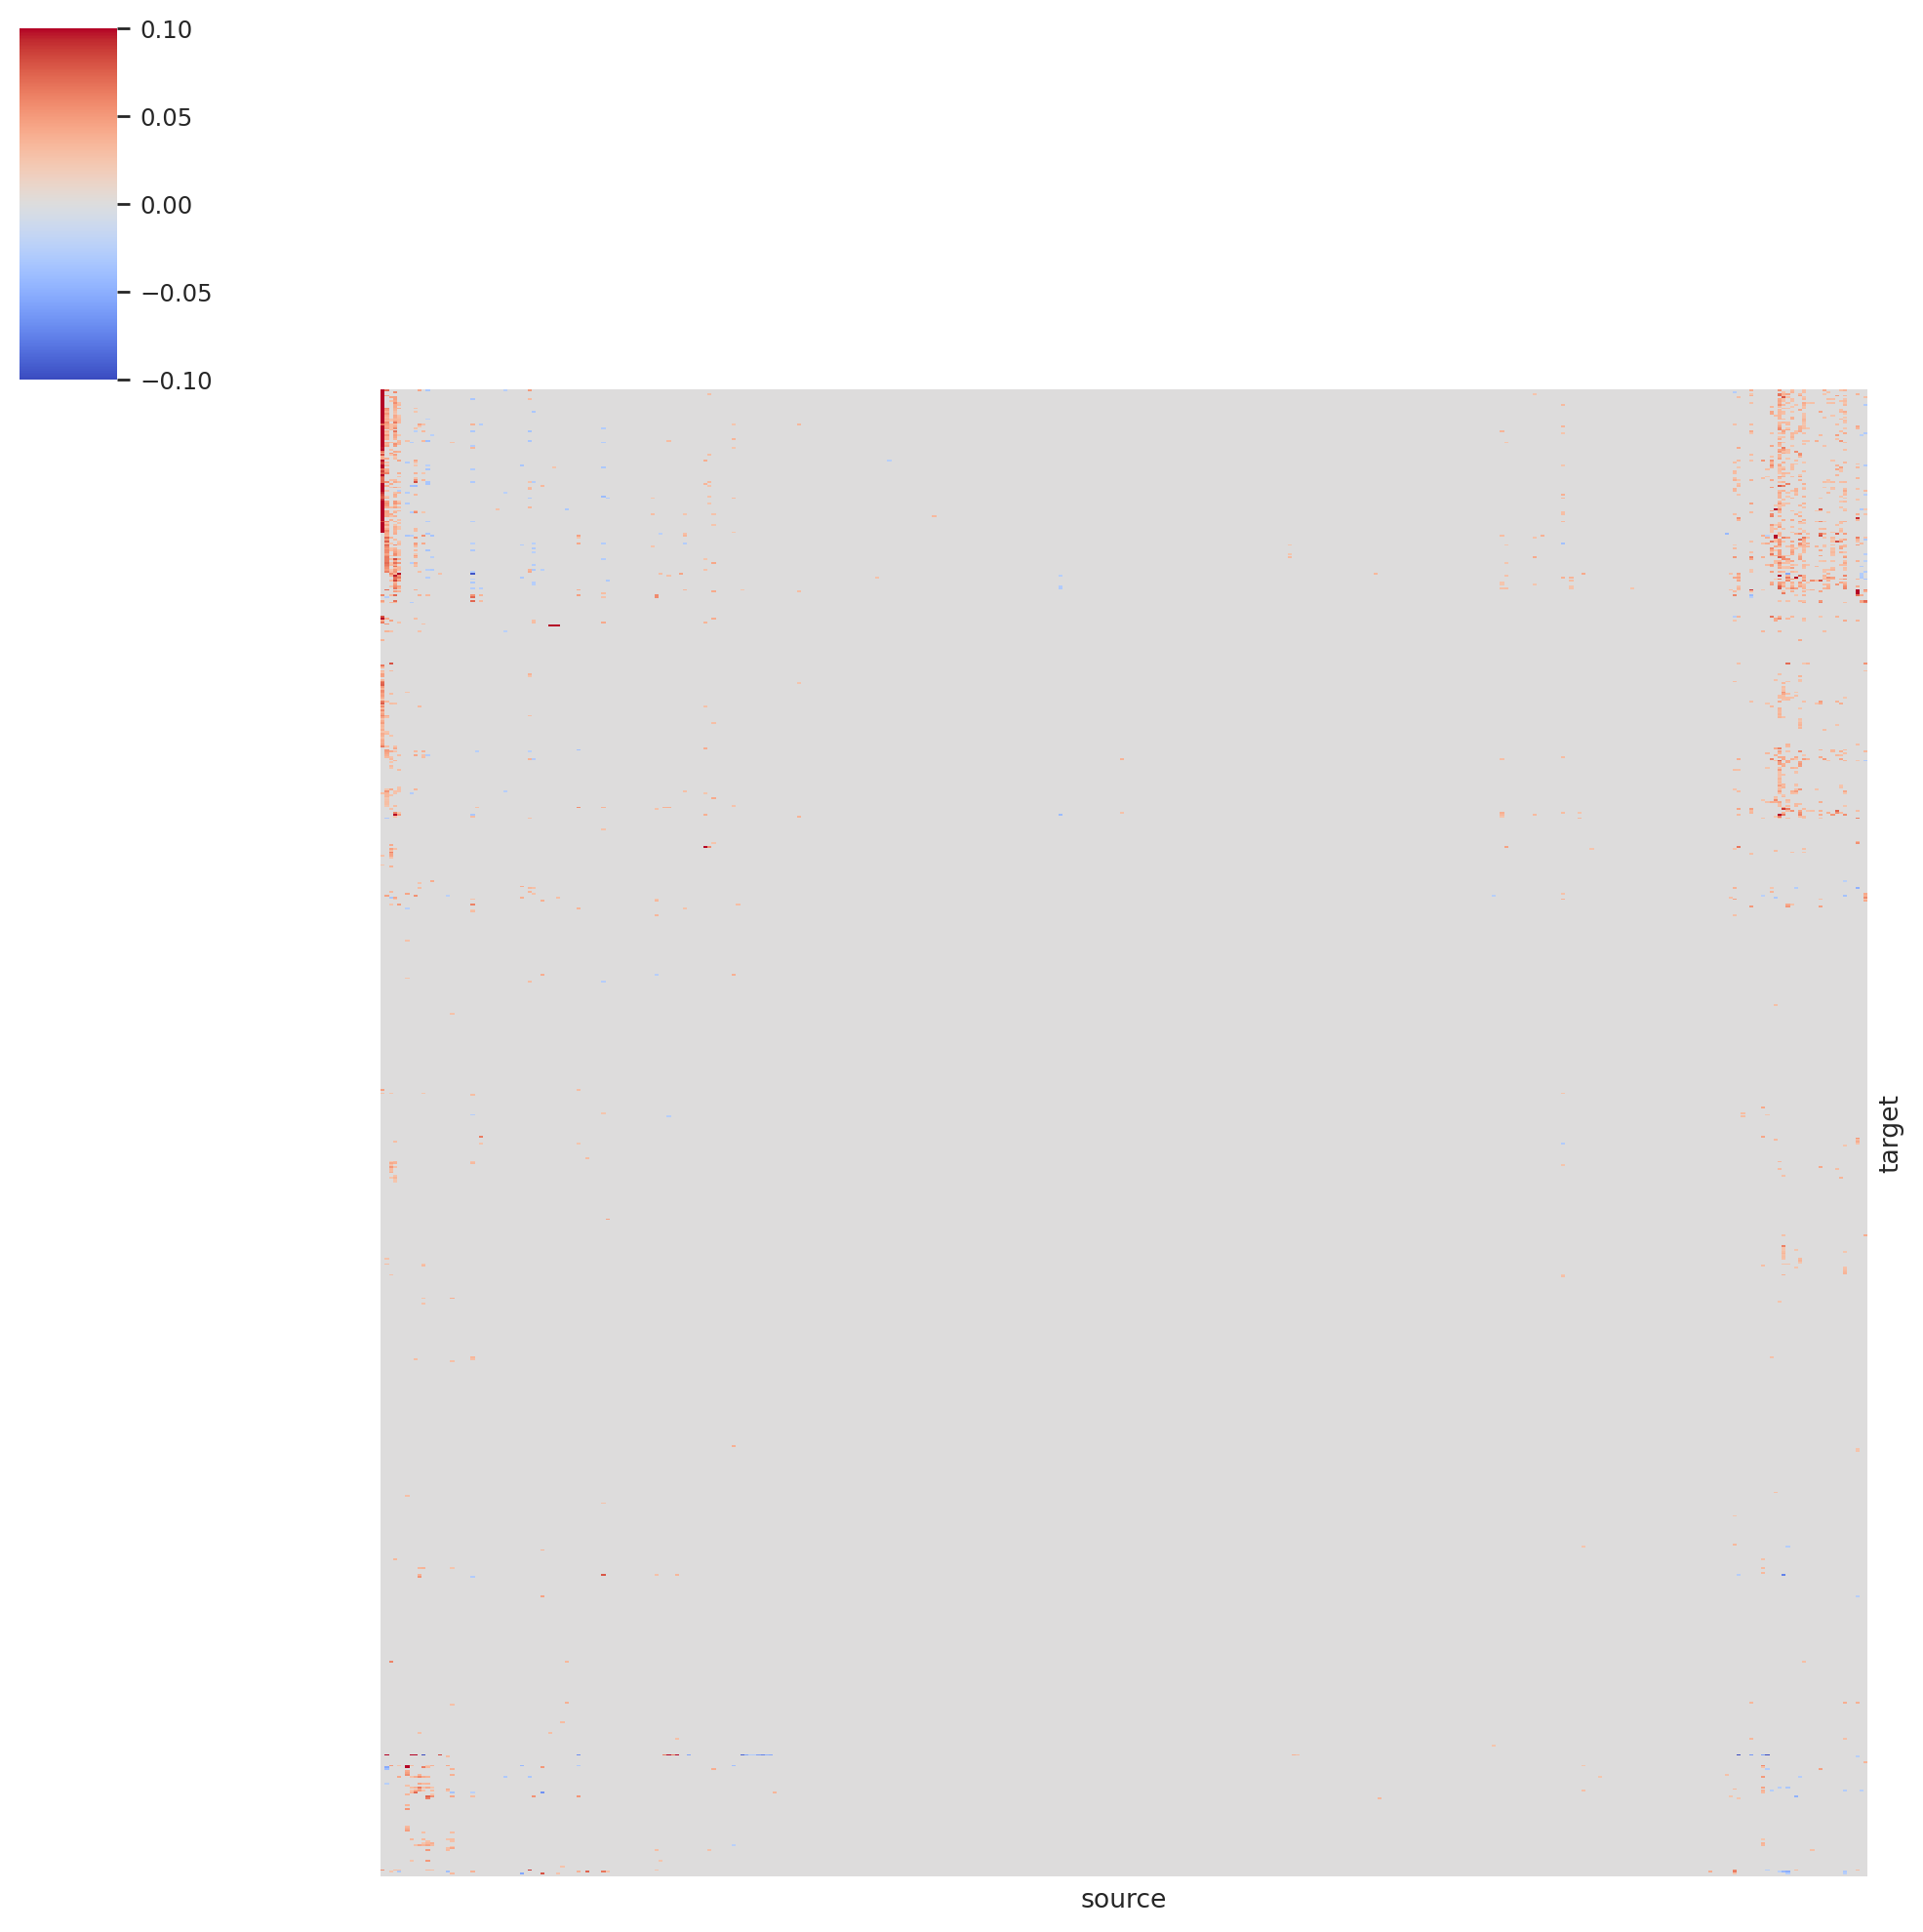

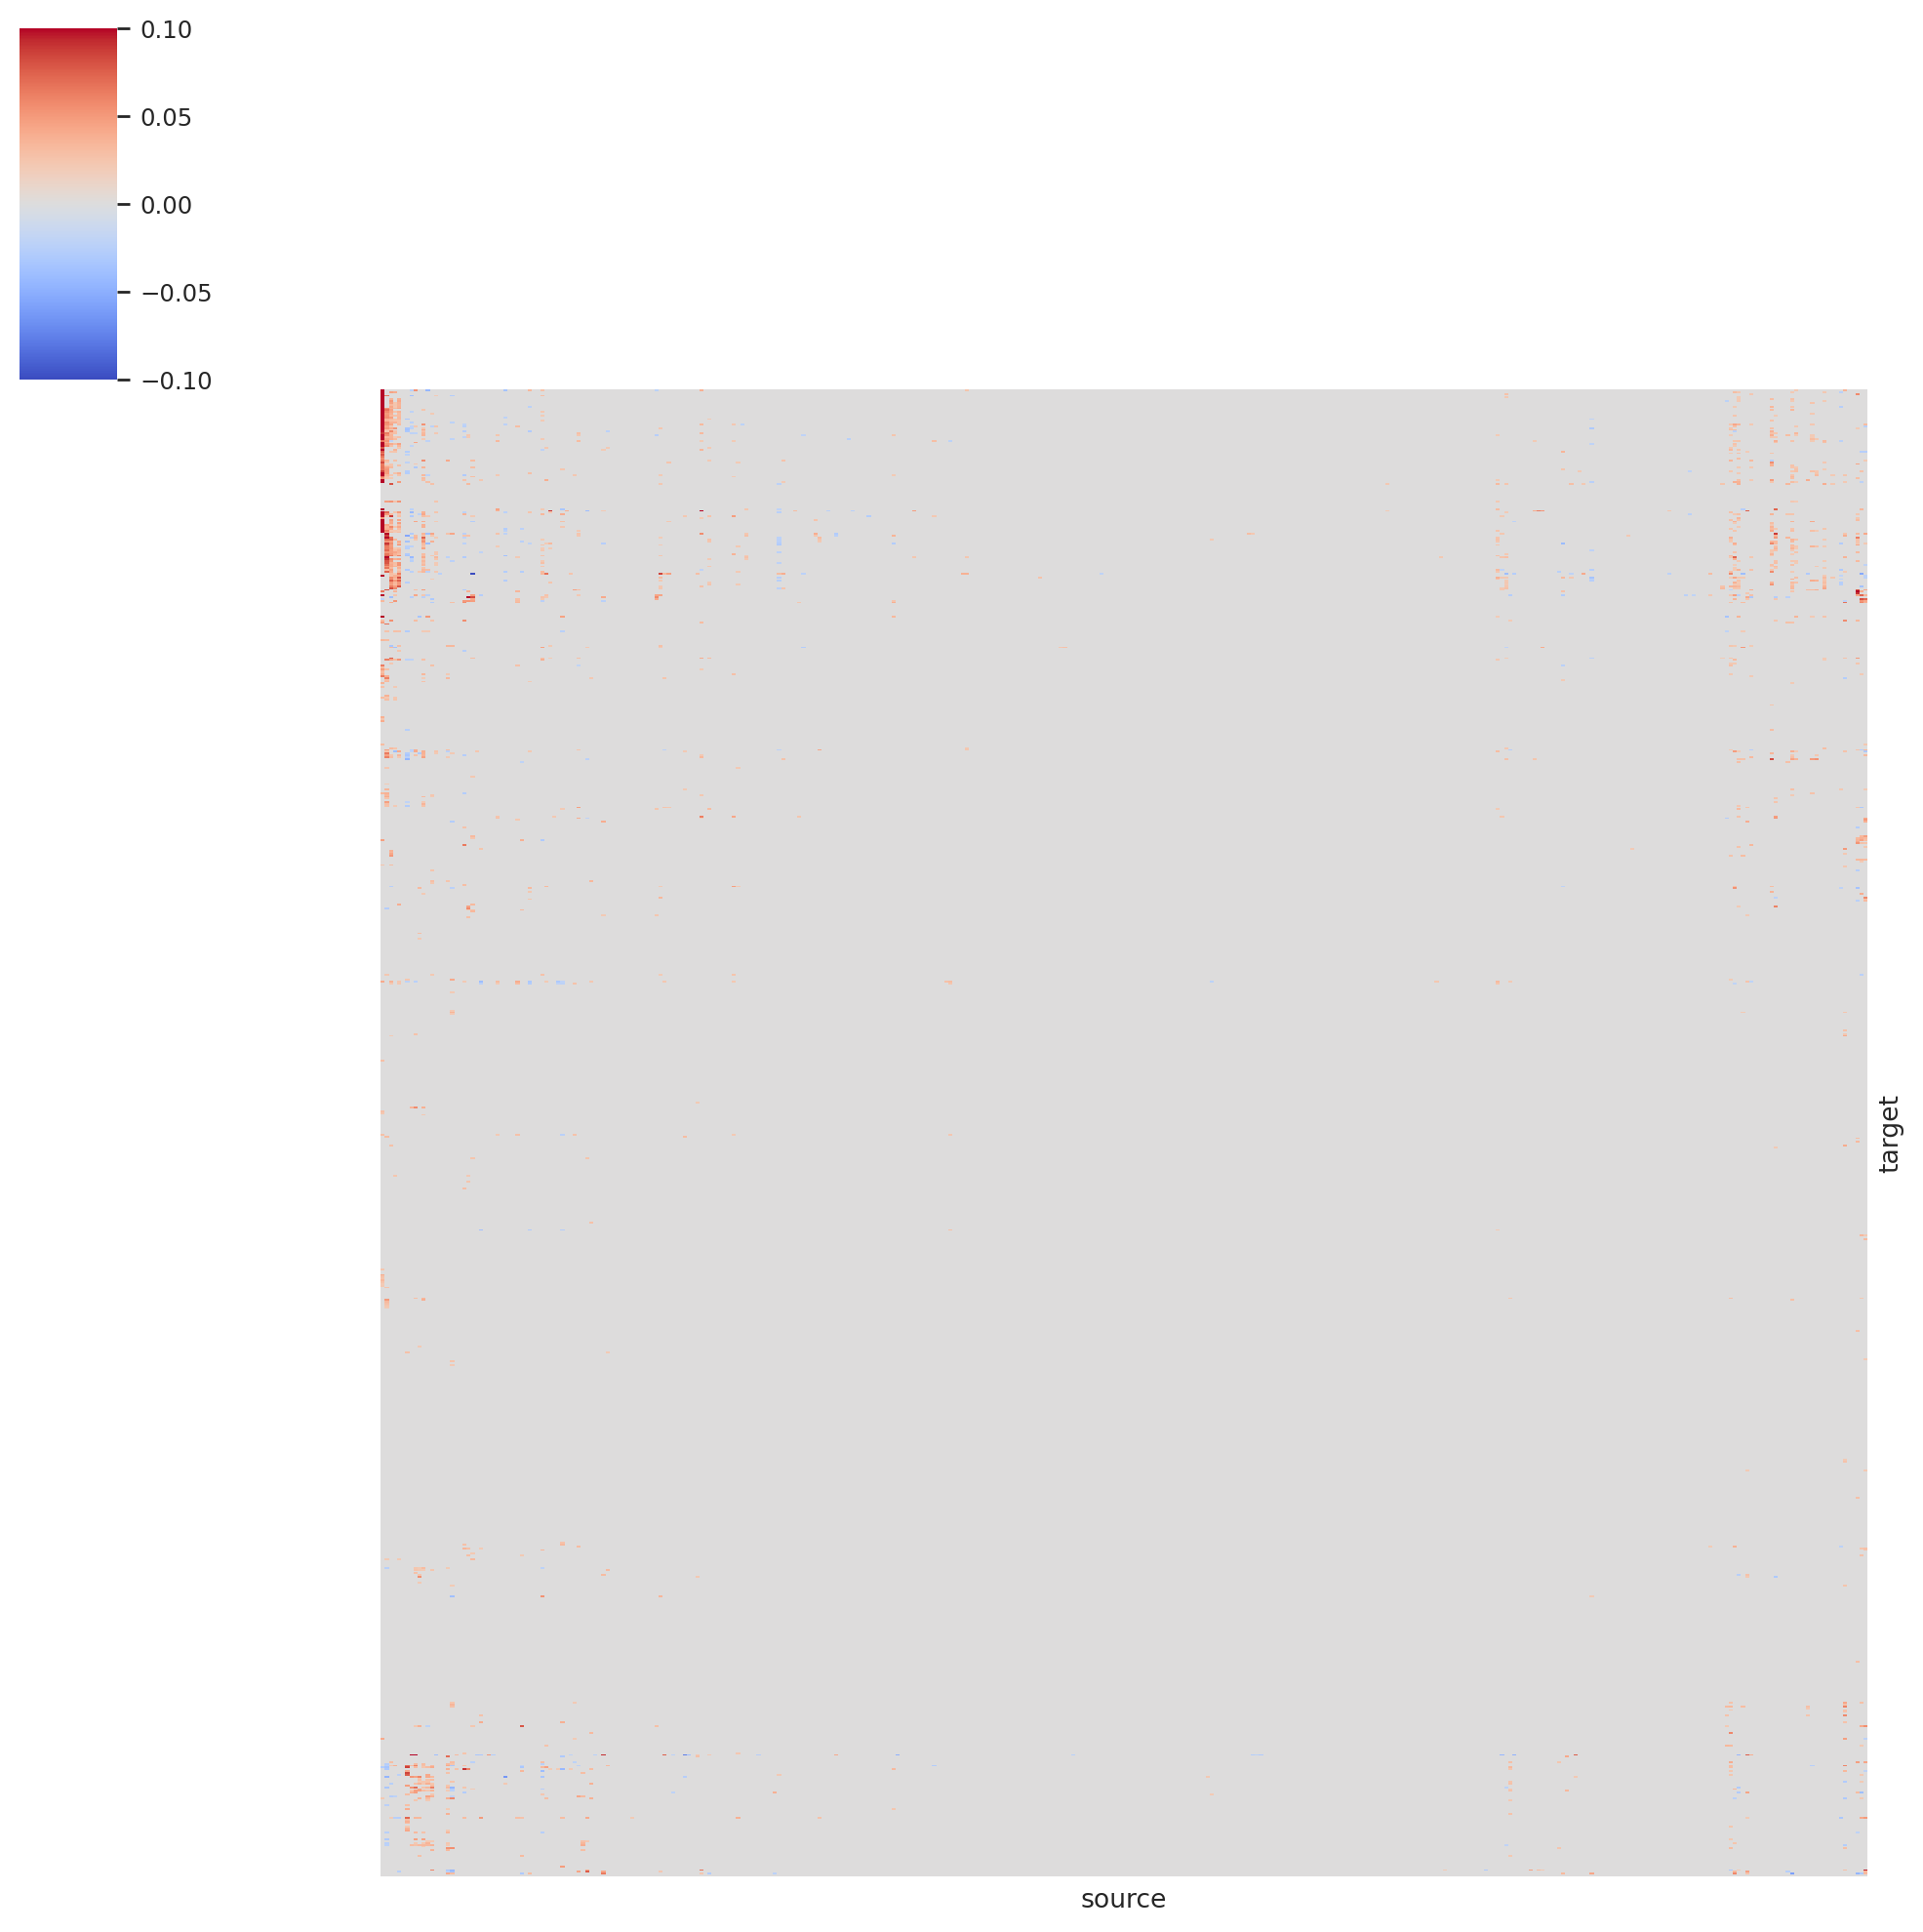

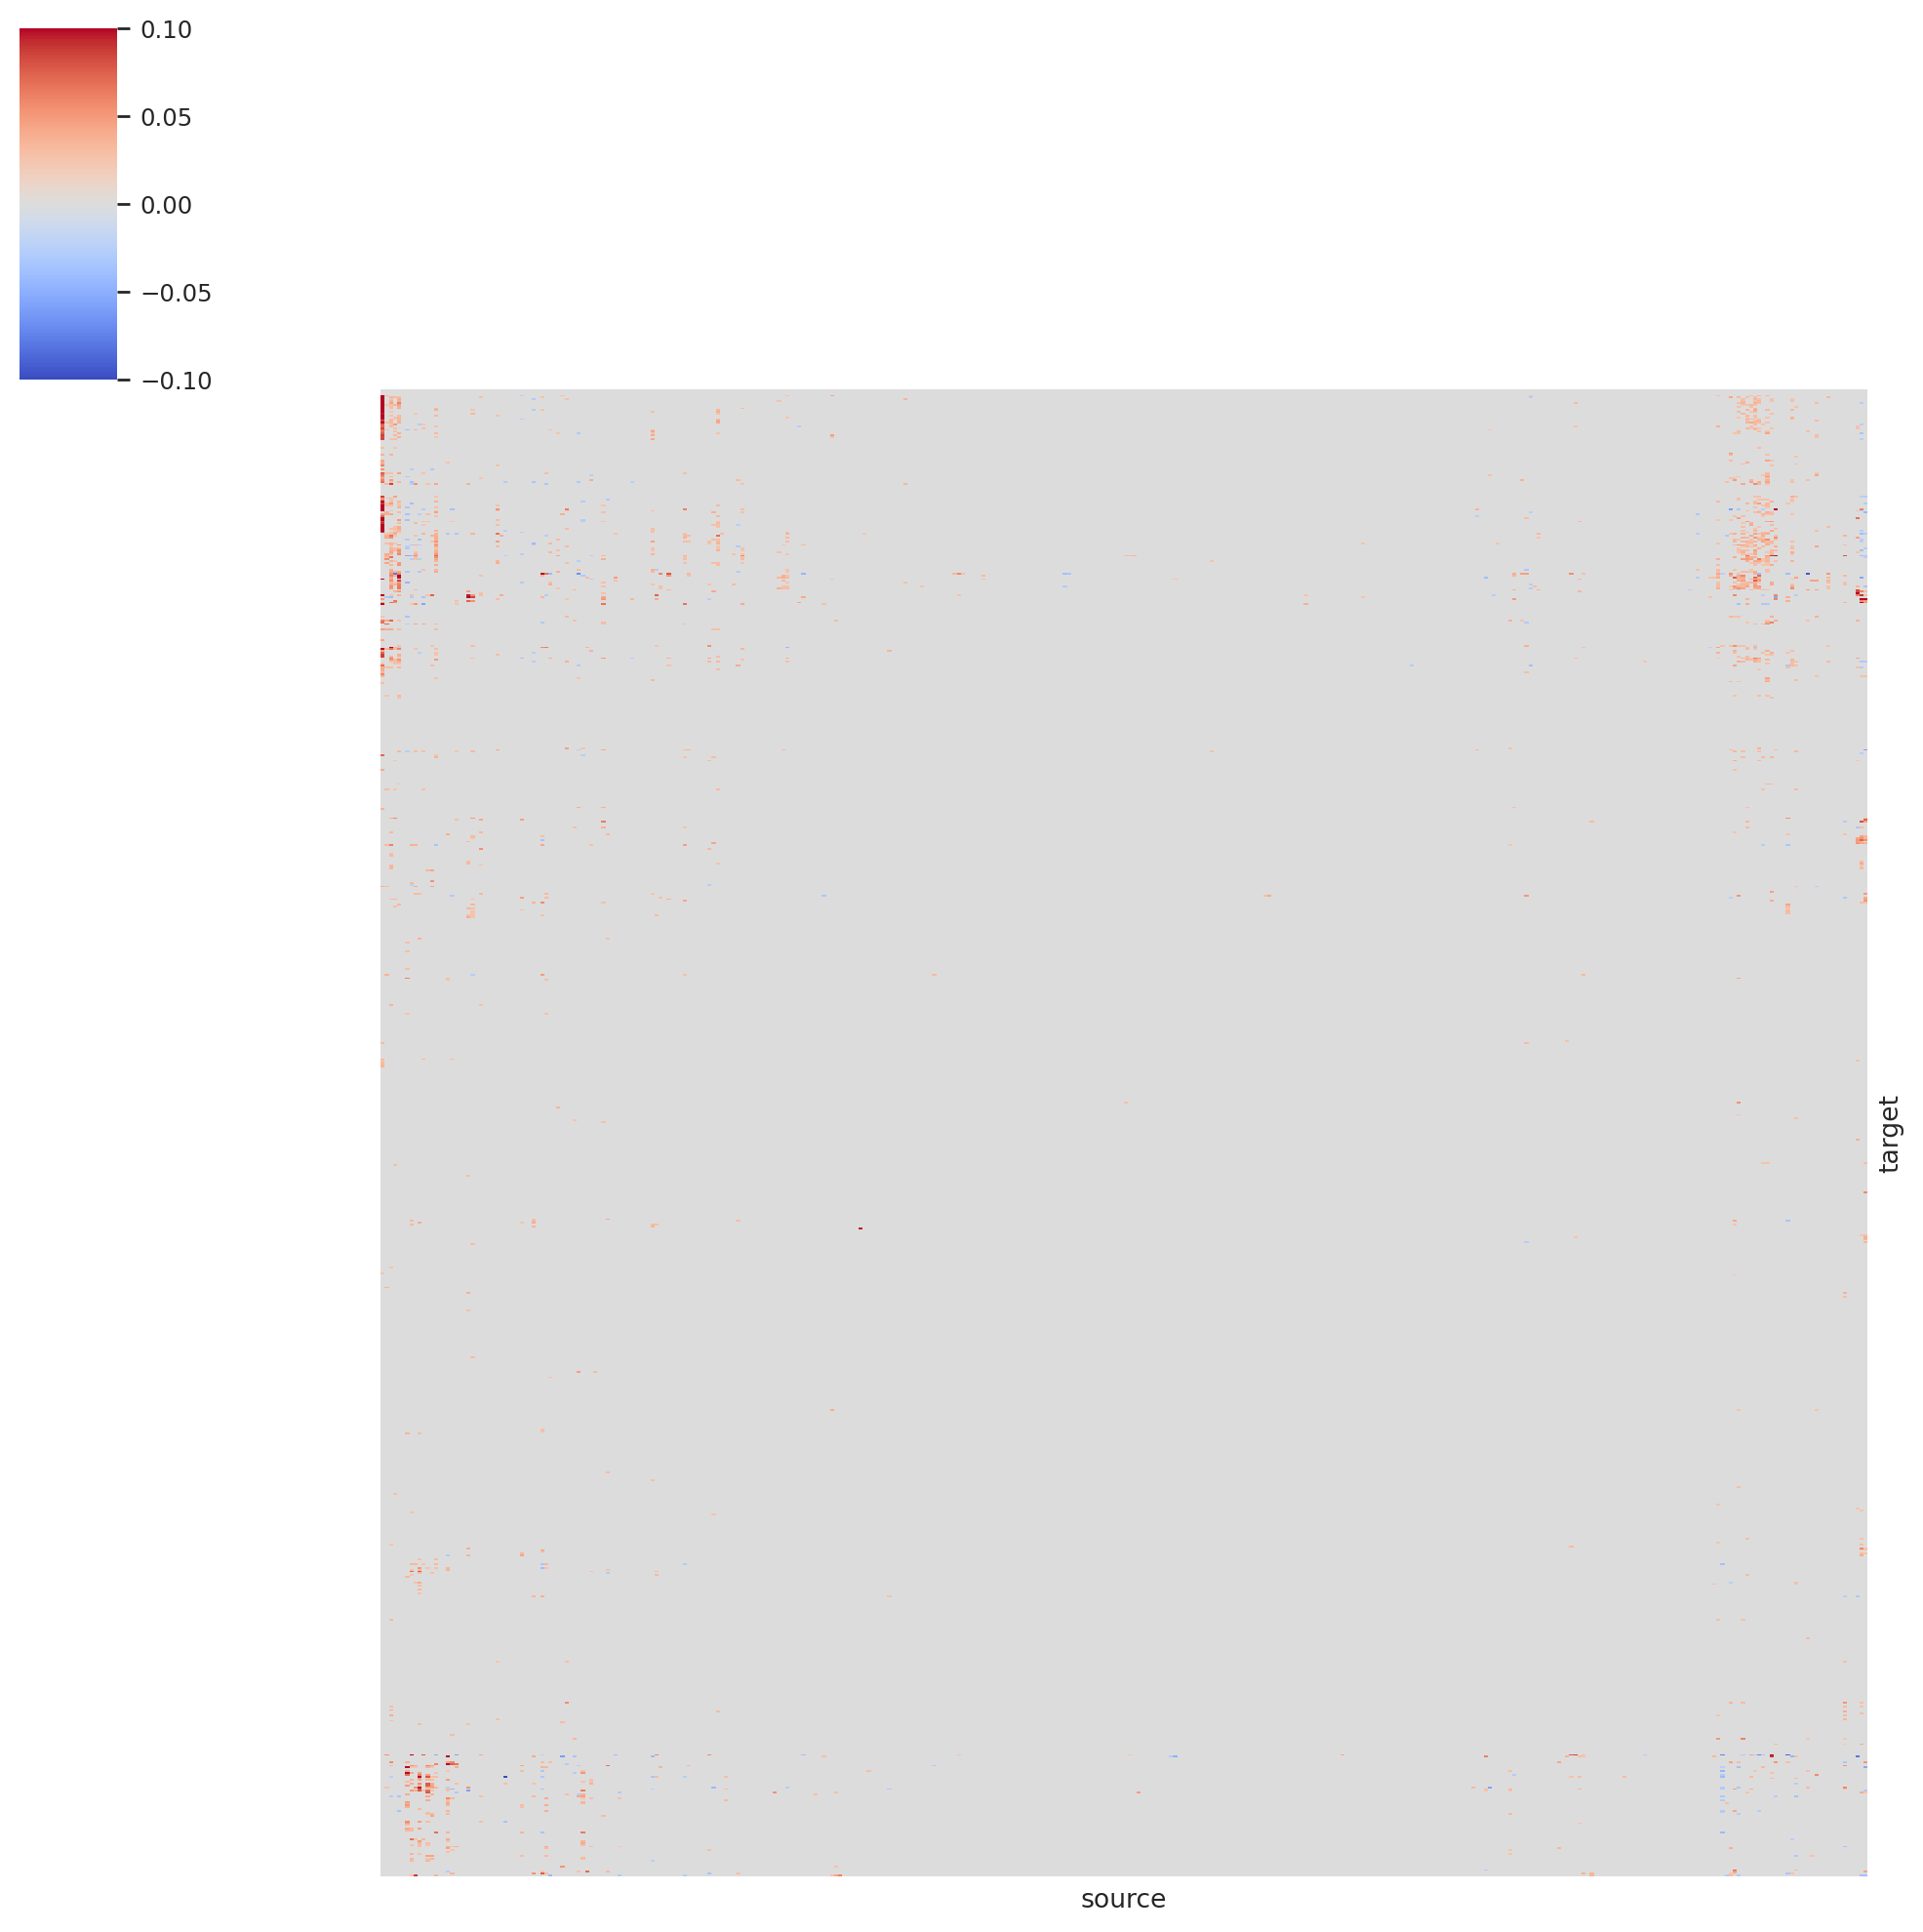

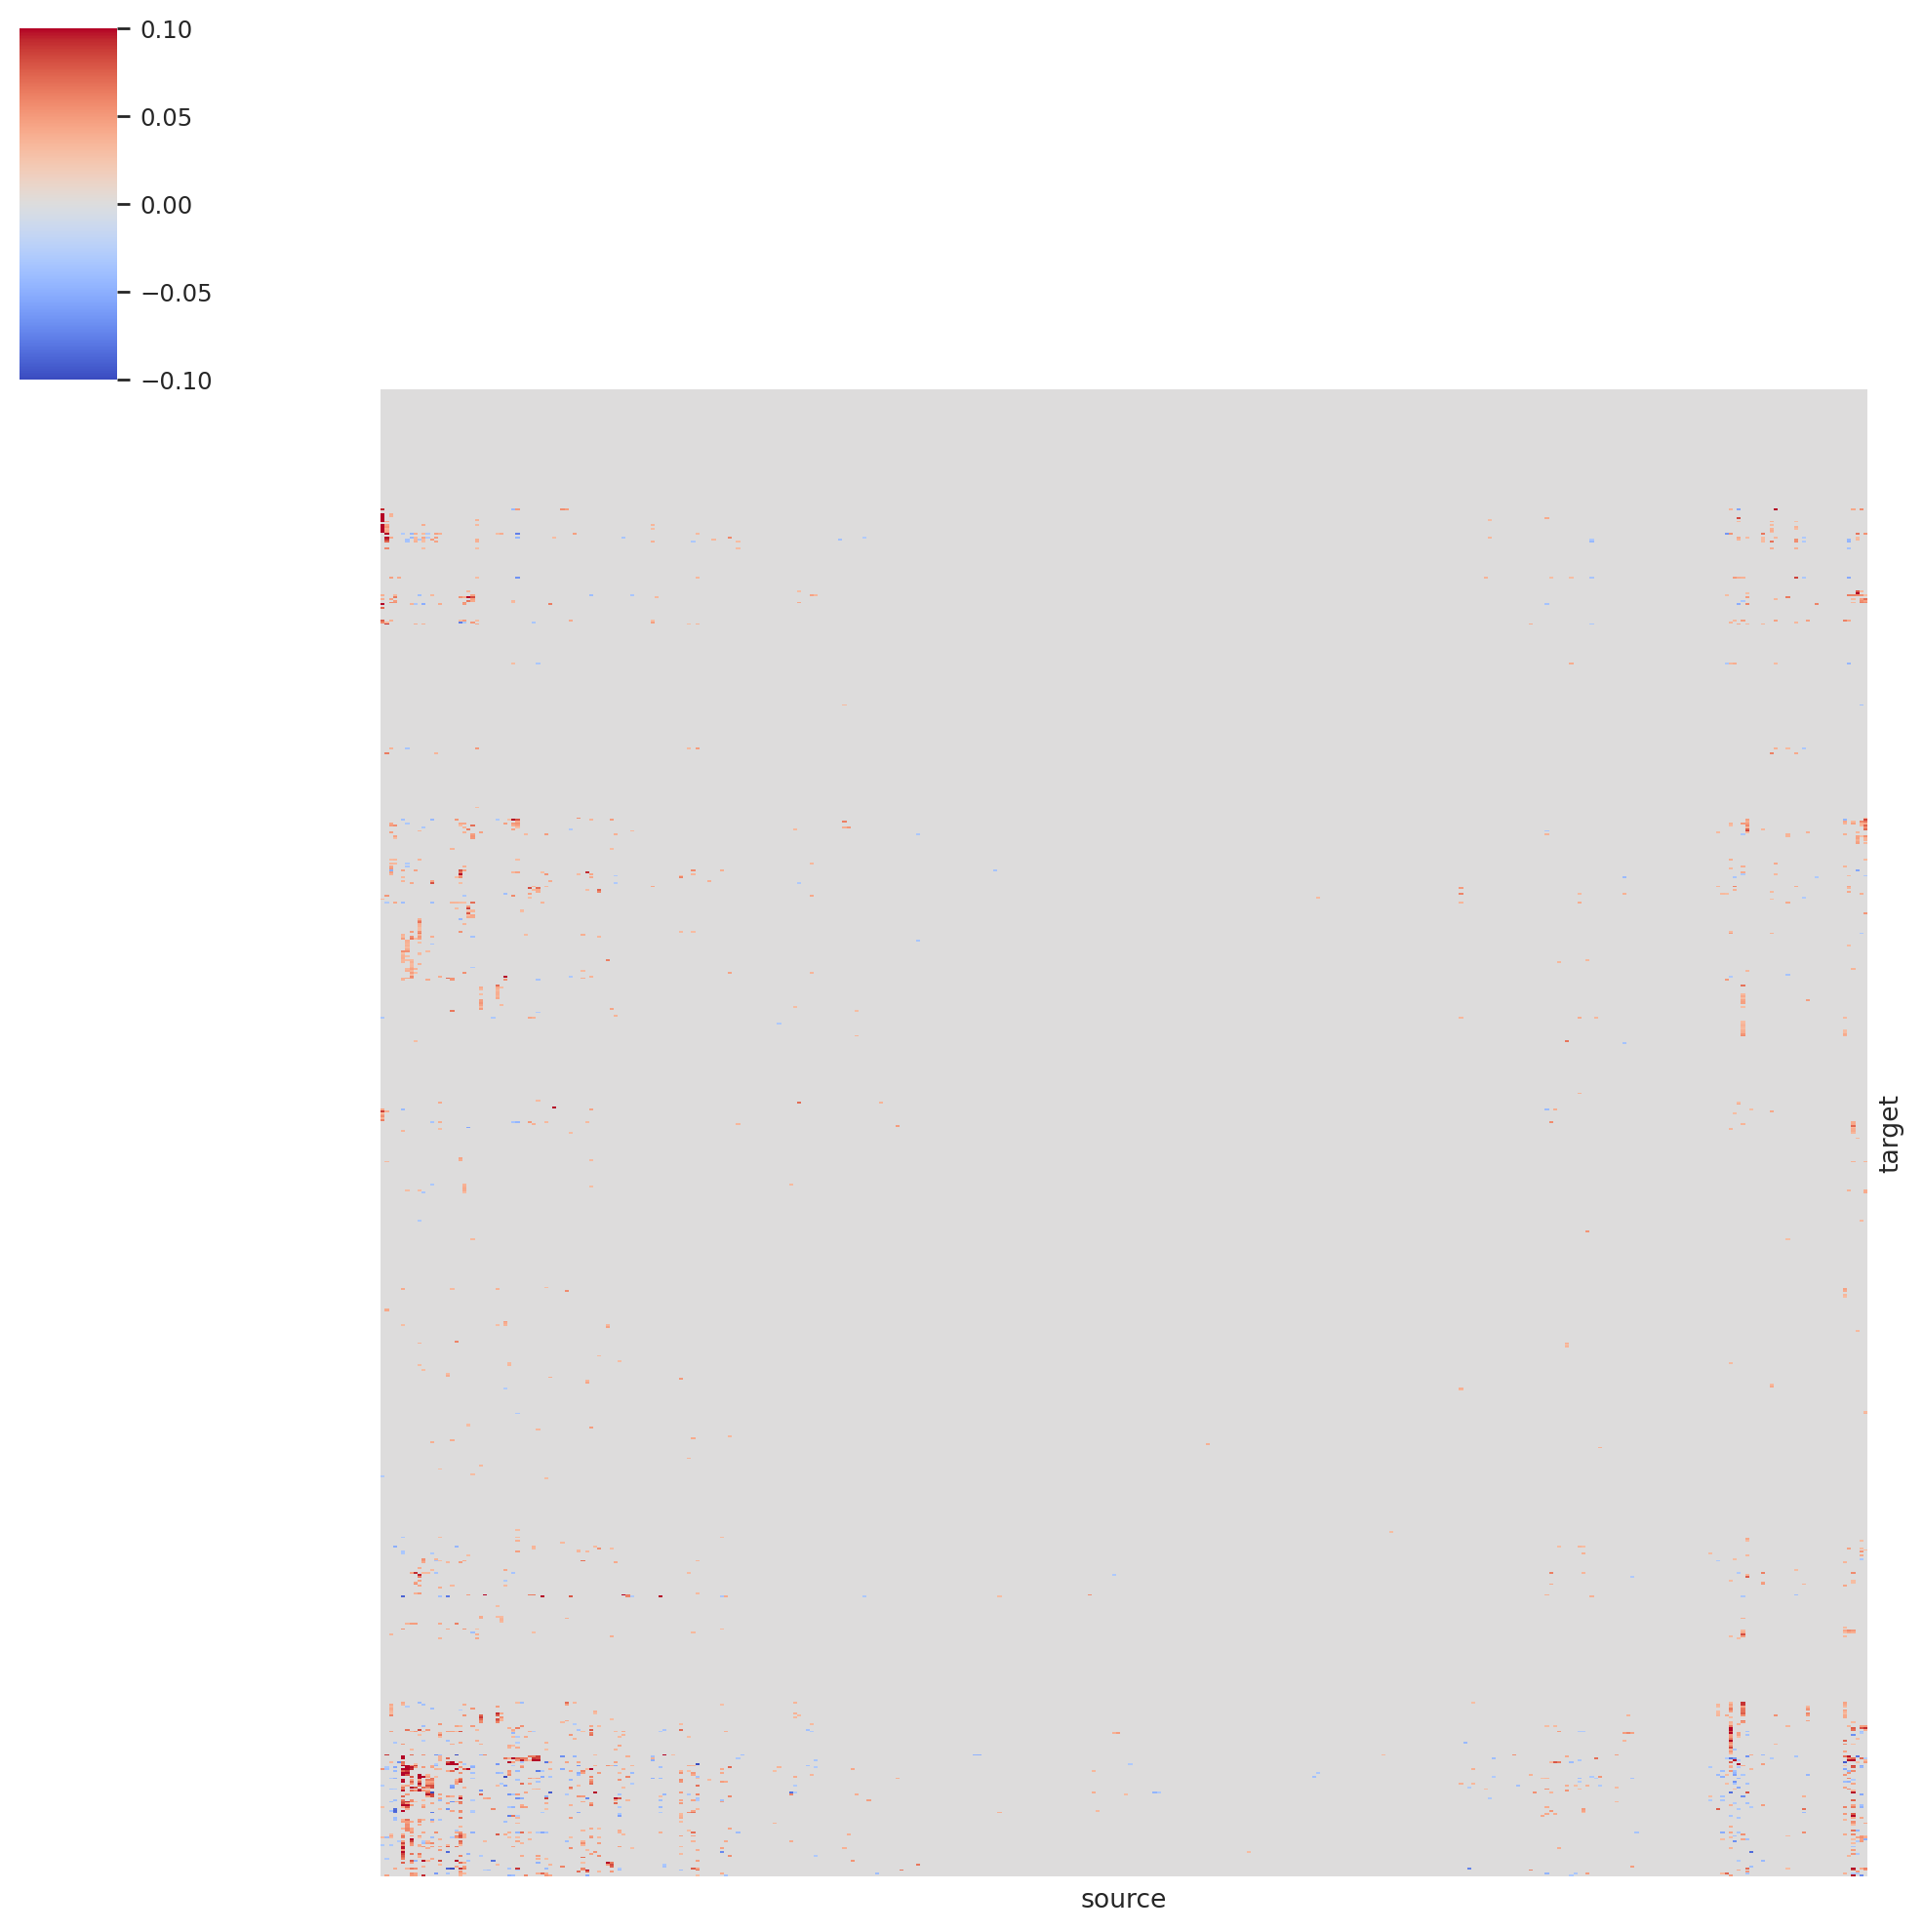

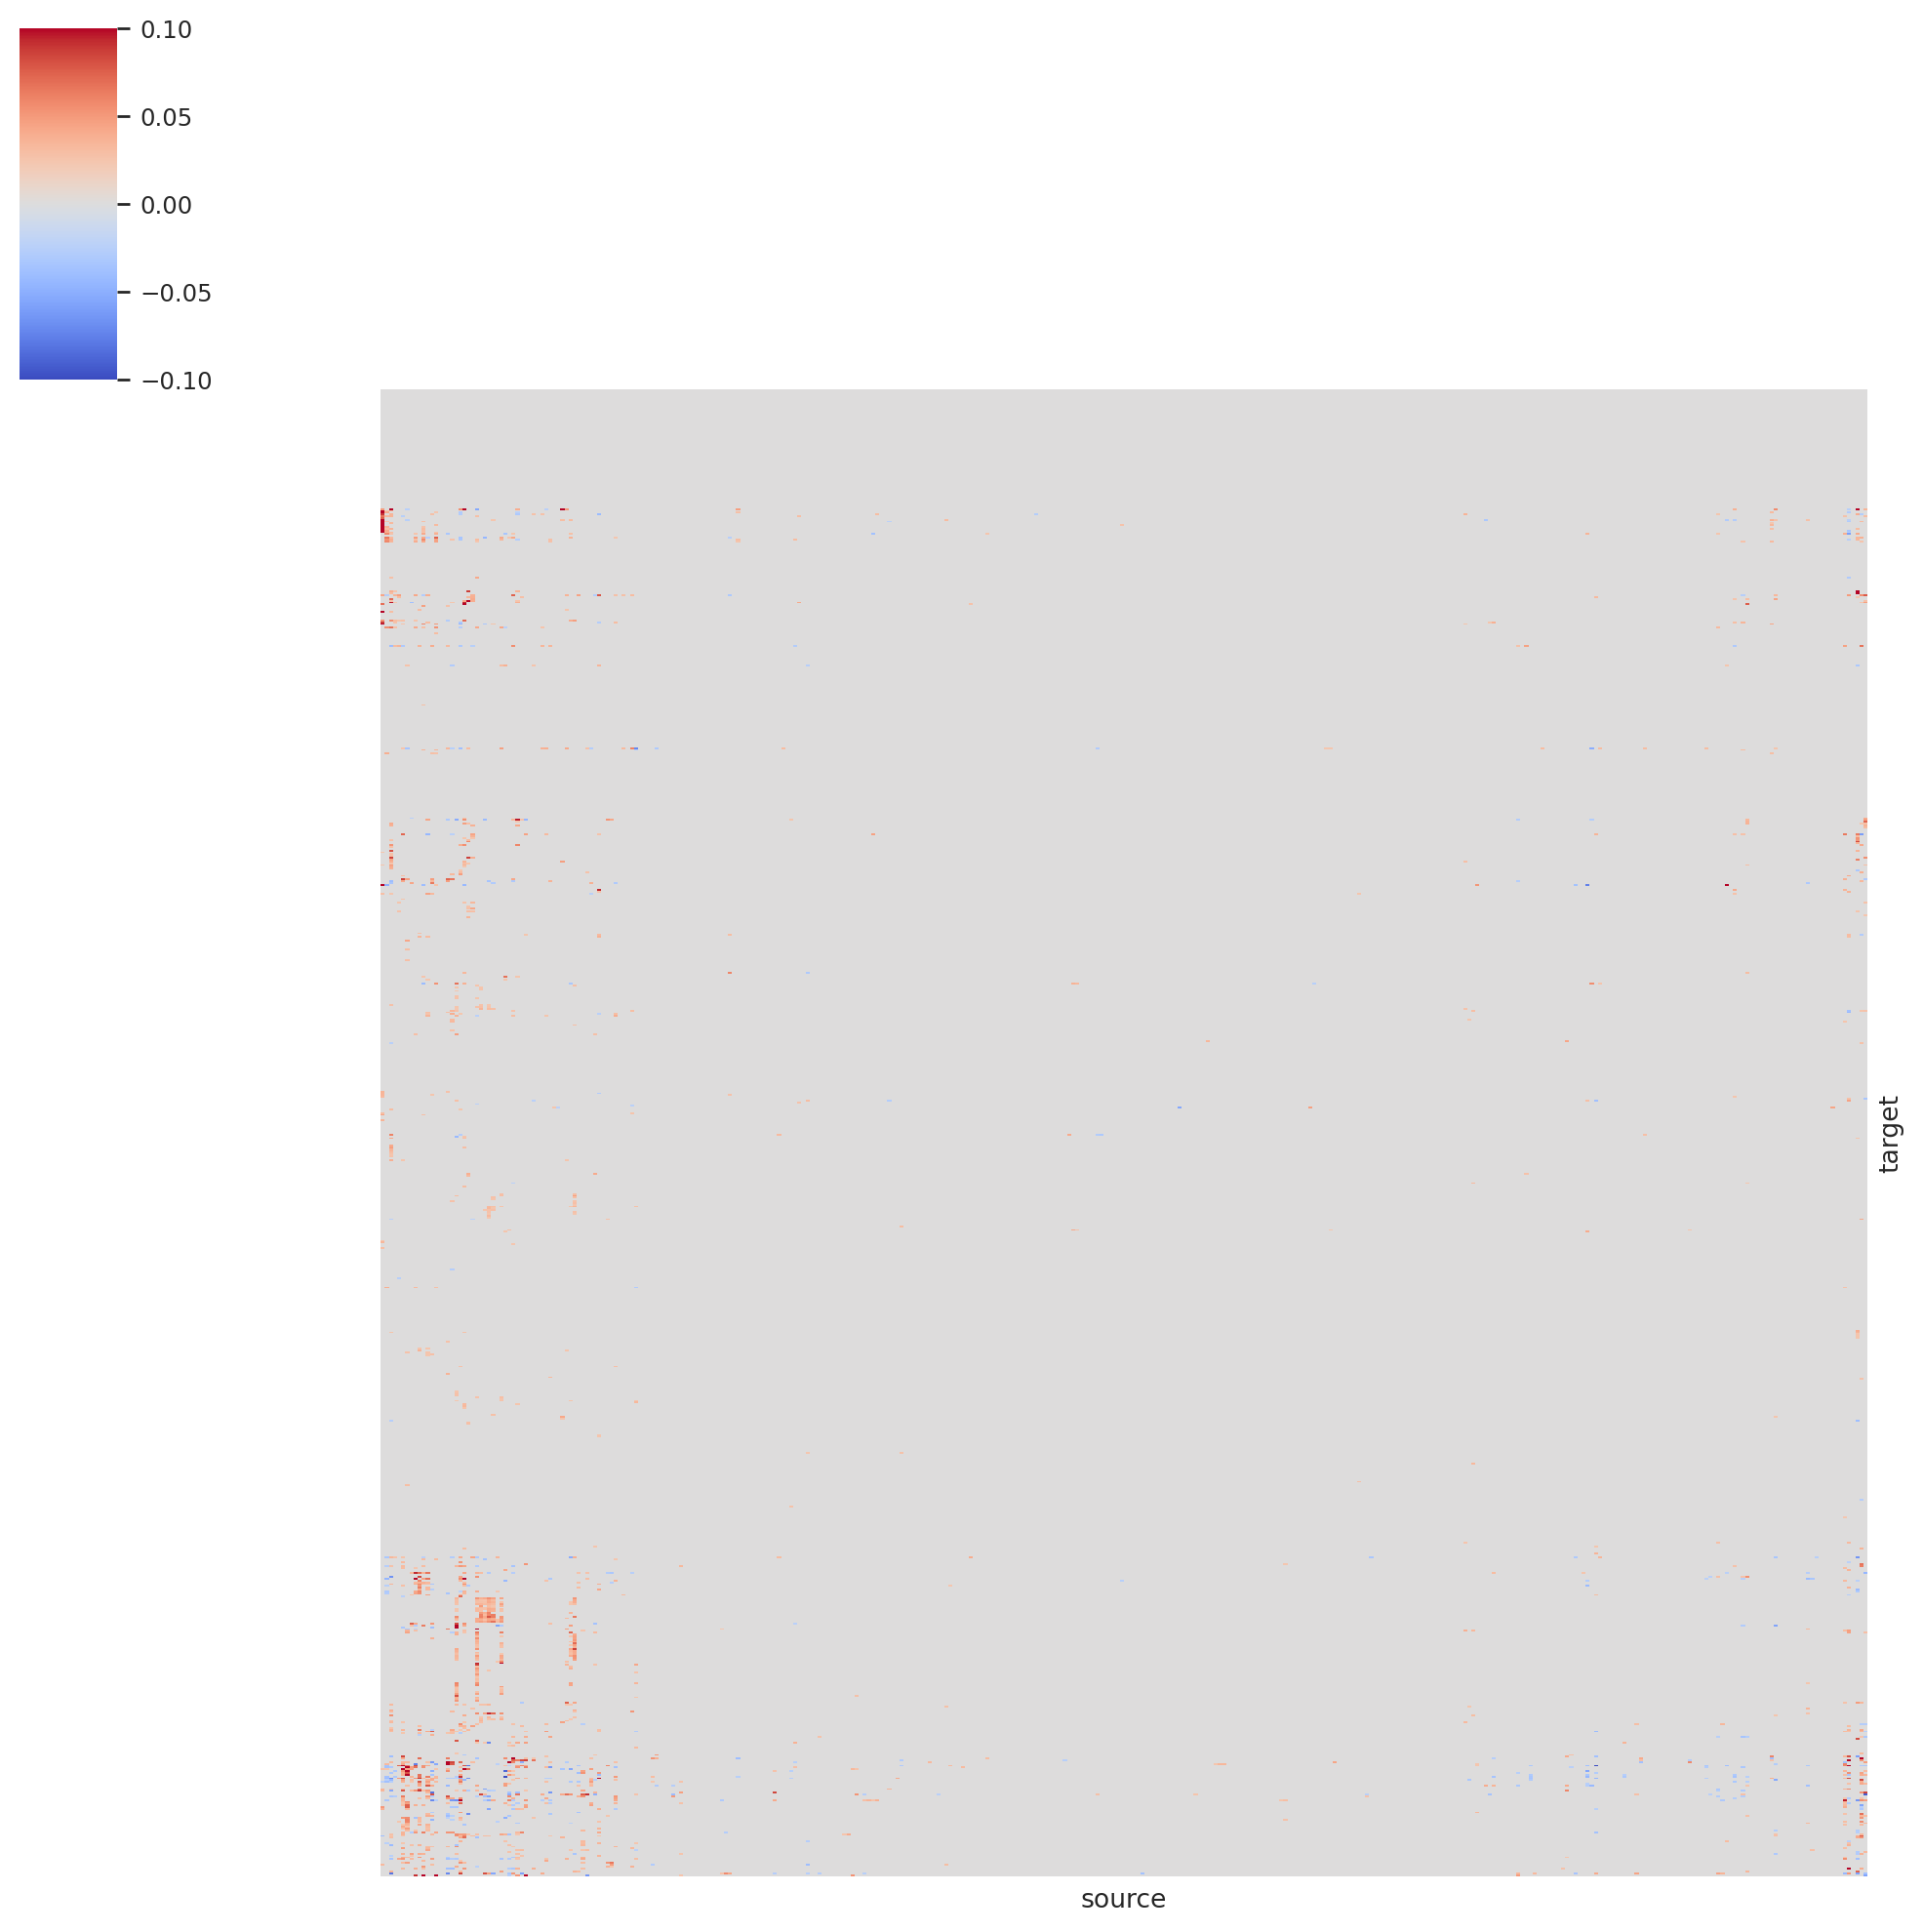

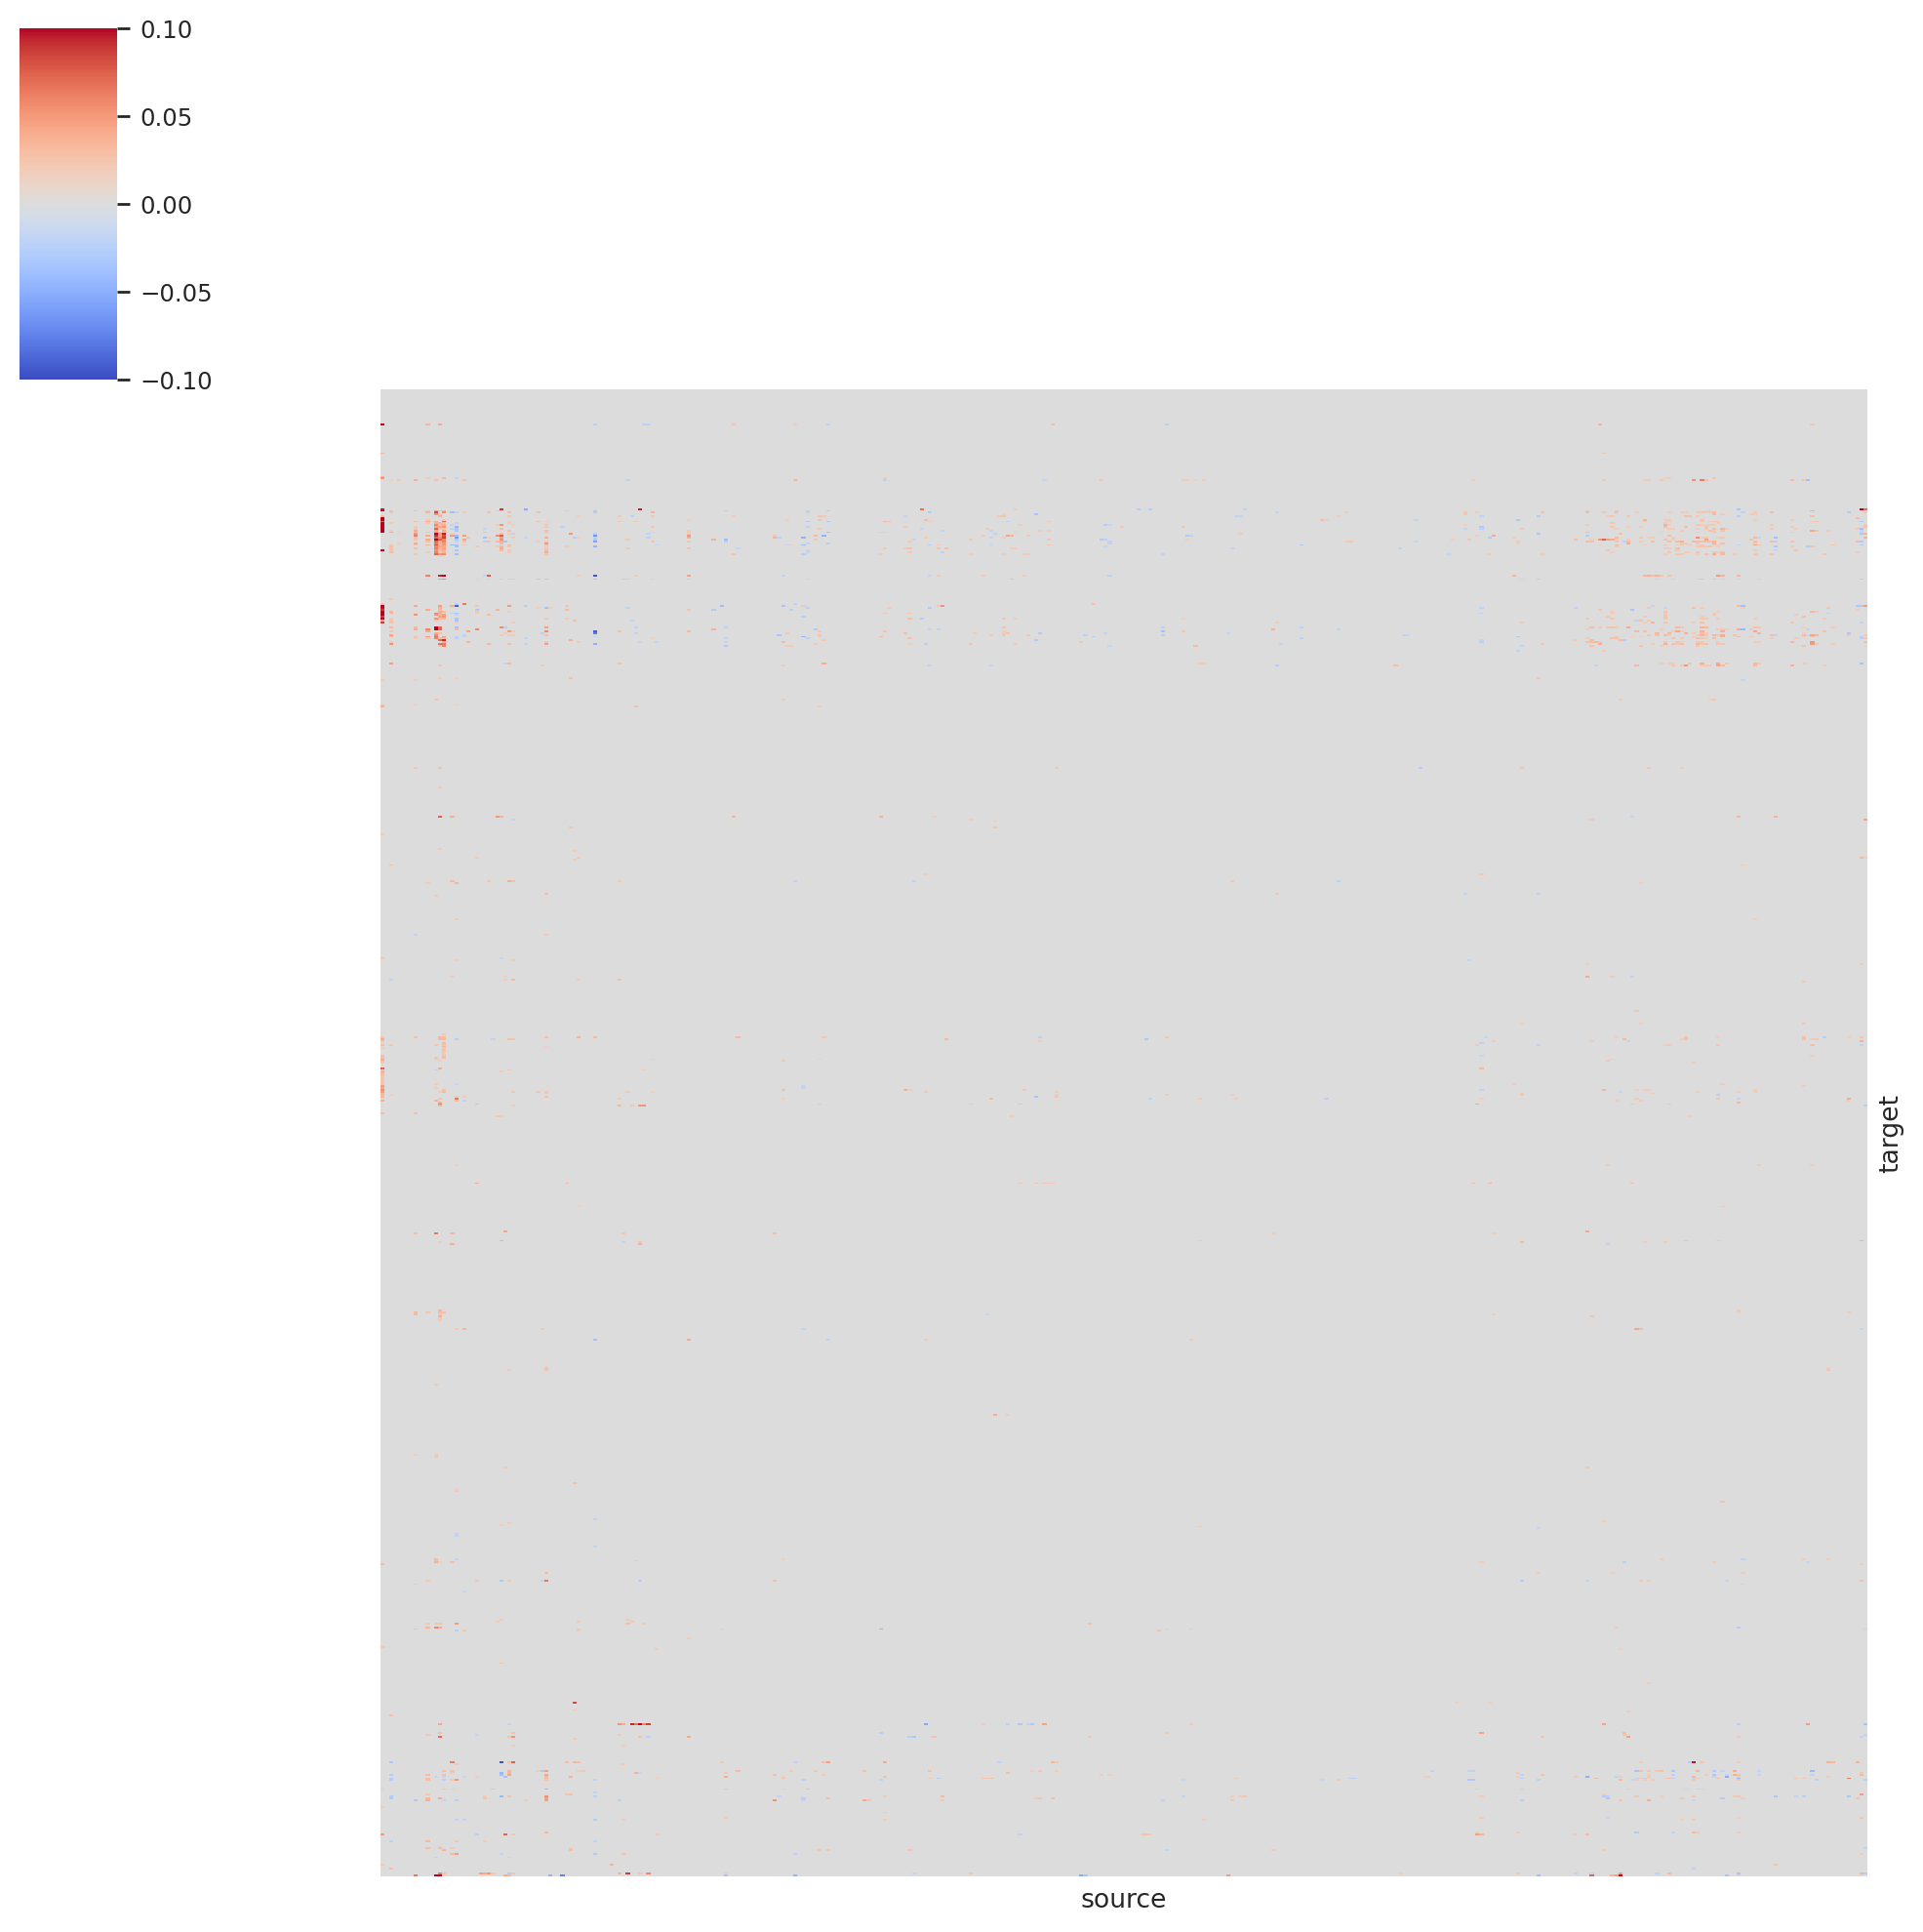

In [116]:
# For loop to plot the GRNs over timepoints
# Choose one celltype
celltype = "spinal_cord"

# for all the rest of the timepoints (0-30 somites)
timepoints = ["TDR126", "TDR127", "TDR128", "TDR118", "TDR125", "TDR124"]
# define the dev stages corresponding to the timepoints list (for dataset IDs)
stages = ["0somites", "5somites", "10somites","15somites","20somites","30somites"]
stages

# Step 1. collect all sources and targets across all timepoints
all_sources = set()
all_targets = set()

for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    all_sources.update(df['source'].unique())
    all_targets.update(df['target'].unique())
    
# Step 2: Recreate each df_counts DataFrame
df_counts_union = {}

for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    # Pivot the original DataFrame
    df_pivot = df.pivot(index='target', columns='source', values='coef_mean').reindex(index=all_targets, columns=all_sources).fillna(0)
    df_counts_union[timepoint] = df_pivot
    
# # Assuming df_counts_union is your dictionary of adjusted count matrices
# timepoints = list(df_counts_union.keys())

# based on the histogram above, we'll define the vmax/vmin for color scale
# vmax = 0.15
# vmin = -0.15
vmax = 0.1
vmin = -0.1


# compute the linkages from the first and the last timepoints, by augmenting the "time" components
df_counts1 = df_counts_union["TDR126"]
df_counts2 = df_counts_union["TDR127"]
df_counts3 = df_counts_union["TDR128"]
df_counts4 = df_counts_union["TDR118"]
df_counts5 = df_counts_union["TDR125"]
df_counts6 = df_counts_union["TDR124"]

# concatenate over the columns
df_counts_rows = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=1)

# concatenate over the rows
df_counts_cols = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=0)

# create a clustered heatmap for the "rows"
g1 = sns.clustermap(df_counts_rows, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# create a clustered heatmap for the "cols"
g2 = sns.clustermap(df_counts_cols, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# extract the row/col indices
row_linkage = g1.dendrogram_row.linkage
col_linkage = g2.dendrogram_col.linkage

# Loop over all timepoints (using the pre-computed linkages from the first timepoint)
for idx, timepoint in enumerate(timepoints):
    # extract the df_counts at corresponding timepoint
    df_counts = df_counts_union[timepoint]
    
    # plot the clustermap
    g = sns.clustermap(df_counts, method='ward', metric='euclidean', 
                       cmap='coolwarm', standard_scale=None, 
                       row_cluster=True, col_cluster=True, 
                       xticklabels=False, yticklabels=False, 
                       vmax=vmax, vmin=vmin, 
                       row_linkage=row_linkage, col_linkage=col_linkage)
    
    # hide the dendrograms
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    
    # extract the dev stage
    stage=stages[idx]
    # save the plot
    # g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_coolwarm.pdf") # celltype is defined above where we computed df_counts_union
    # g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_coolwarm.png")

# # Display all heatmaps side by side with consistent clustering
plt.show()

### NOTES:

- left top and right top sections "decrease" over developemental time (0->30 somites stages)
- left bottom section "increases" over developemental time

### Sectioning the left-top for "decreasing over time"

In [36]:
df_counts_union.keys()

dict_keys(['TDR126', 'TDR127', 'TDR128', 'TDR118', 'TDR125', 'TDR124'])

In [117]:
df_counts_union["TDR126"]

source           nkx1.2la  cebpb  noto  neurod4  pknox2  gsx1  sp5a  klf2a  \
target                                                                       
ptges3b               0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   
si:dkey-67c22.2       0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   
col11a1a              0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   
anp32a                0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   
ctnnb1                0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   
...                   ...    ...   ...      ...     ...   ...   ...    ...   
itm2cb                0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   
hspa8                 0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   
dut                   0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   
nedd9                 0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   
rpl28                 0.0    0.0   0.0      0.0     0.0   0.0   0.0    0.0   

source           foxf2b  wt1b  ...  myog  barhl1b  tbx2b  pax2a      vent  \
target                         ...                                          
ptges3b             0.0   0.0  ...   0.0      0.0    0.0    0.0  0.000000   
si:dkey-67c22.2     0.0   0.0  ...   0.0      0.0    0.0    0.0  0.000000   
col11a1a            0.0   0.0  ...   0.0      0.0    0.0    0.0  0.000000   
anp32a              0.0   0.0  ...   0.0      0.0    0.0    0.0  0.000000   
ctnnb1              0.0   0.0  ...   0.0      0.0    0.0    0.0  0.000000   
...                 ...   ...  ...   ...      ...    ...    ...       ...   
itm2cb              0.0   0.0  ...   0.0      0.0    0.0    0.0  0.000000   
hspa8               0.0   0.0  ...   0.0      0.0    0.0    0.0  0.000000   
dut                 0.0   0.0  ...   0.0      0.0    0.0    0.0  0.000000   
nedd9               0.0   0.0  ...   0.0      0.0    0.0    0.0  0.000000   
rpl28               0.0   0.0  ...   0.0      0.0    0.0    0.0 -0.028222   

source           nkx2.4a  irx5a  gbx2    sox11a  vax1  
target                                                 
ptges3b              0.0    0.0   0.0  0.000000   0.0  
si:dkey-67c22.2      0.0    0.0   0.0  0.034665   0.0  
col11a1a             0.0    0.0   0.0  0.000000   0.0  
anp32a               0.0    0.0   0.0  0.000000   0.0  
ctnnb1               0.0    0.0   0.0  0.043365   0.0  
...                  ...    ...   ...       ...   ...  
itm2cb               0.0    0.0   0.0  0.000000   0.0  
hspa8                0.0    0.0   0.0  0.043717   0.0  
dut                  0.0    0.0   0.0  0.000000   0.0  
nedd9                0.0    0.0   0.0  0.000000   0.0  
rpl28                0.0    0.0   0.0  0.000000   0.0  

[827 rows x 364 columns]

In [121]:
# Check the GRN at the first timepoint
df_counts = df_counts_union["TDR126"]

# Assuming you have determined your cluster size and its position (last N rows and M columns)
N = 48  # The number of rows in the cluster, replace with the actual number
M = 5  # The number of columns in the cluster, replace with the actual number

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g.dendrogram_row.reordered_ind[0:N]
col_indices = g.dendrogram_col.reordered_ind[0:M]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source      hmga1a    sox19a     meox1       vox       ved
target                                                    
prmt1     0.176295  0.069810  0.000000  0.000000  0.000000
rps13     0.178890  0.000000  0.000000  0.057211  0.000000
rps3a     0.174185  0.000000  0.000000  0.000000  0.000000
ran       0.203433  0.043355  0.000000  0.000000  0.000000
metap2b   0.136577  0.000000  0.044989  0.046190  0.000000
rpl18a    0.129660  0.000000  0.000000  0.046175  0.000000
rpl11     0.135824  0.000000  0.027413  0.042150  0.000000
rps19     0.154546  0.000000  0.000000  0.056036  0.027788
rpl32     0.157471  0.000000  0.000000  0.041187  0.031927
rpl23a    0.158866  0.000000  0.000000  0.042957  0.000000
cirbpb    0.207347  0.055910  0.000000  0.038709  0.038295
hnrnpaba  0.173937  0.048837  0.000000  0.036649  0.000000
rpl4      0.133159  0.038424  0.000000  0.029905  0.000000
khdrbs1a  0.135241  0.051208  0.000000  0.027247  0.000000
rps14     0.125282  0.039987  0.000000  0.042188  0.0253

In [122]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union["TDR126"]

df_counts_0somites_upreg = df_counts.loc[row_names, col_names]
df_counts_0somites_upreg

source      hmga1a    sox19a     meox1       vox       ved
target                                                    
prmt1     0.176295  0.069810  0.000000  0.000000  0.000000
rps13     0.178890  0.000000  0.000000  0.057211  0.000000
rps3a     0.174185  0.000000  0.000000  0.000000  0.000000
ran       0.203433  0.043355  0.000000  0.000000  0.000000
metap2b   0.136577  0.000000  0.044989  0.046190  0.000000
rpl18a    0.129660  0.000000  0.000000  0.046175  0.000000
rpl11     0.135824  0.000000  0.027413  0.042150  0.000000
rps19     0.154546  0.000000  0.000000  0.056036  0.027788
rpl32     0.157471  0.000000  0.000000  0.041187  0.031927
rpl23a    0.158866  0.000000  0.000000  0.042957  0.000000
cirbpb    0.207347  0.055910  0.000000  0.038709  0.038295
hnrnpaba  0.173937  0.048837  0.000000  0.036649  0.000000
rpl4      0.133159  0.038424  0.000000  0.029905  0.000000
khdrbs1a  0.135241  0.051208  0.000000  0.027247  0.000000
rps14     0.125282  0.039987  0.000000  0.042188  0.025393
rpl13     0.133064  0.035629  0.000000  0.040505  0.028706
rpl9      0.137517  0.042838  0.027377  0.030294  0.032727
rpl10a    0.108748  0.034860  0.024805  0.039429  0.032145
rps18     0.144300  0.055540  0.000000  0.065064  0.032384
cnbpb     0.069367  0.046289  0.029220  0.031848  0.000000
eef1g     0.103037  0.042148  0.030248  0.040157  0.000000
rps6      0.146691  0.046250  0.027362  0.057420  0.000000
hmgn6     0.141087  0.000000  0.033030  0.000000  0.000000
anp32b    0.121770  0.038813  0.000000  0.065769  0.000000
cbx3a     0.110669  0.031009  0.000000  0.037830  0.000000
seta      0.125109  0.050397  0.000000  0.045322  0.024260
rpl24     0.120575  0.036597  0.000000  0.042669  0.000000
tuba8l4   0.110163  0.037613  0.000000  0.034951  0.000000
marcksb   0.104839  0.000000  0.000000  0.000000  0.034243
bzw1a     0.123496  0.043124  0.032738  0.025767  0.037485
rpl35     0.138842  0.036173  0.000000  0.054032  0.034742
rpl28     0.127351  0.045555  0.000000  0.049082  0.000000
srrm2     0.096824  0.000000  0.000000  0.000000  0.000000
u2af2b    0.101233  0.000000  0.027829  0.000000  0.000000
dut       0.066581  0.000000  0.000000  0.042293  0.037560
cd3eap    0.042283  0.000000  0.049085  0.000000  0.000000
rsl1d1    0.083266  0.000000  0.027087  0.046827  0.000000
mcm6      0.038995  0.000000  0.000000  0.024975  0.000000
polr2gl   0.041083  0.041186  0.000000  0.028974  0.000000
top1l     0.115829  0.000000  0.000000  0.000000  0.043067
eif4a1a   0.086109  0.028203  0.000000  0.000000  0.000000
anp32a    0.083957  0.000000  0.000000  0.000000  0.000000
anp32e    0.111458  0.033929  0.000000  0.000000  0.000000
aldoaa    0.101115  0.000000  0.000000  0.000000  0.000000
ppp2cb    0.071183  0.038359  0.000000  0.000000  0.000000
eif5a2    0.087910  0.044447  0.000000  0.000000  0.000000
hnrnpa1b  0.076041  0.060937  0.000000  0.000000  0.038178
setb      0.099497  0.000000  0.000000  0.000000  0.000000

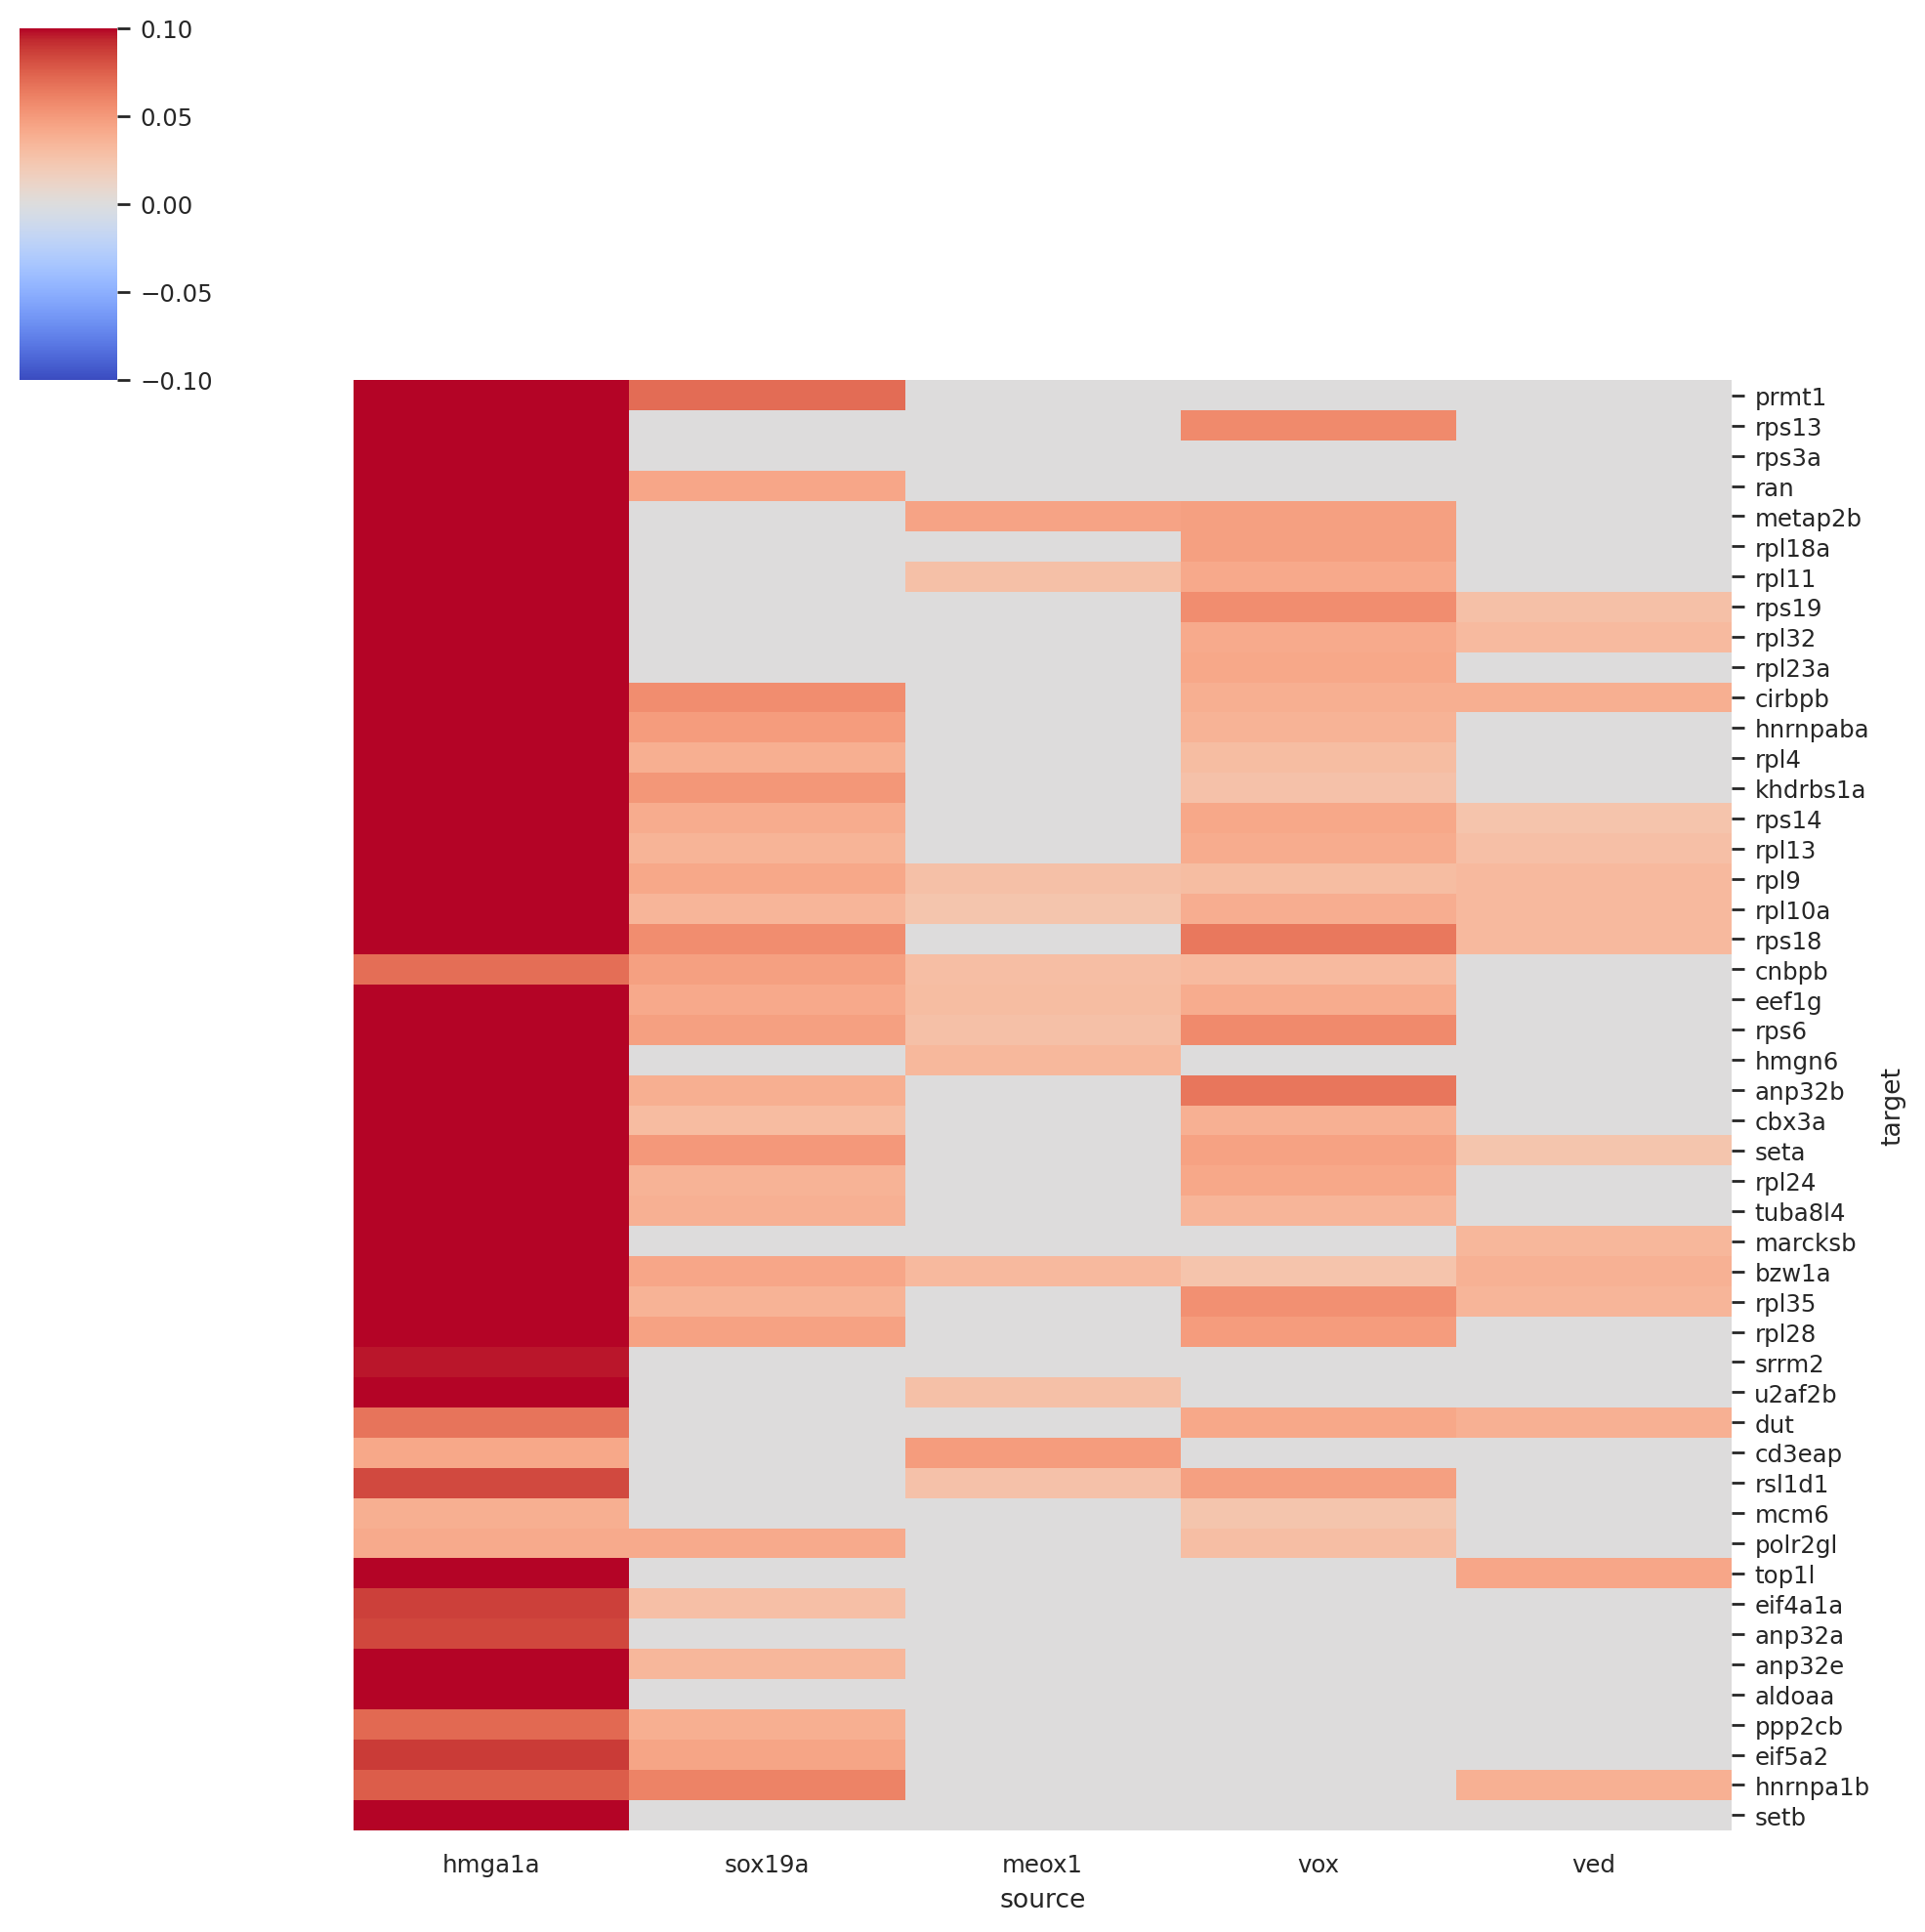

In [123]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_0somites_upreg, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "spinal_cord"
stage = "0somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}.png")

plt.show()

### Sectioning the right top (decreasing over time)

In [125]:
# Check the GRN at the first timepoint
df_counts = df_counts_union["TDR126"]

# Assuming you have determined your cluster size and its position (last N rows and M columns)
N = 50  # The number of rows in the cluster, replace with the actual number
M = -10  # The number of columns in the cluster, replace with the actual number

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g1.dendrogram_row.reordered_ind[20:80]
col_indices = g2.dendrogram_col.reordered_ind[-27:-15]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source    msx1a    sox11b    sox19b      cdx4      myf5     tgif1     etv5b  \
target                                                                        
prmt1       0.0  0.000000  0.000000  0.000000  0.000000  0.052632  0.000000   
rps13       0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.028306   
rps3a       0.0  0.000000  0.000000  0.000000  0.000000  0.067291  0.037181   
ran         0.0  0.000000  0.000000  0.000000  0.000000  0.069019  0.032662   
metap2b     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.079540   
rpl18a      0.0  0.000000  0.000000  0.000000  0.000000  0.041140  0.025825   
rpl11       0.0  0.000000  0.000000  0.000000  0.000000  0.044196  0.028094   
rps19       0.0  0.000000  0.000000  0.000000  0.000000  0.040233  0.000000   
rpl32       0.0  0.000000  0.000000  0.000000  0.000000  0.052750  0.034204   
rpl23a      0.0  0.000000  0.000000  0.034805  0.000000  0.029829  0.000000   
cirbpb      0.0  0.000000  0.000000  0.000000  0.000

In [99]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union["TDR126"]

df_counts_0somites_upreg2 = df_counts.loc[row_names, col_names]
df_counts_0somites_upreg2

source      msx1b  cdx4  sox21a  sp5l  eve1  uncx4.1    sox11b  sox2  etv5a  \
target                                                                        
apoc1    0.059883   0.0     0.0   0.0   0.0      0.0  0.039395   0.0    0.0   
u2af2b   0.000000   0.0     0.0   0.0   0.0      0.0  0.000000   0.0    0.0   
dut      0.000000   0.0     0.0   0.0   0.0      0.0  0.000000   0.0    0.0   
bzw1a    0.000000   0.0     0.0   0.0   0.0      0.0  0.000000   0.0    0.0   
marcksb  0.000000   0.0     0.0   0.0   0.0      0.0  0.000000   0.0    0.0   
...           ...   ...     ...   ...   ...      ...       ...   ...    ...   
phc2a    0.000000   0.0     0.0   0.0   0.0      0.0  0.000000   0.0    0.0   
ism1     0.000000   0.0     0.0   0.0   0.0      0.0  0.000000   0.0    0.0   
hoxb3a   0.000000   0.0     0.0   0.0   0.0      0.0  0.000000   0.0    0.0   
hoxc3a   0.000000   0.0     0.0   0.0   0.0      0.0  0.000000   0.0    0.0   
meox1    0.000000   0.0     0.0   0.0   0.0      0.0  0.000000   0.0    0.0   

source     foxc1a  
target             
apoc1    0.000000  
u2af2b   0.000000  
dut      0.000000  
bzw1a    0.038195  
marcksb  0.000000  
...           ...  
phc2a    0.000000  
ism1     0.000000  
hoxb3a   0.000000  
hoxc3a   0.000000  
meox1    0.034291  

[100 rows x 10 columns]

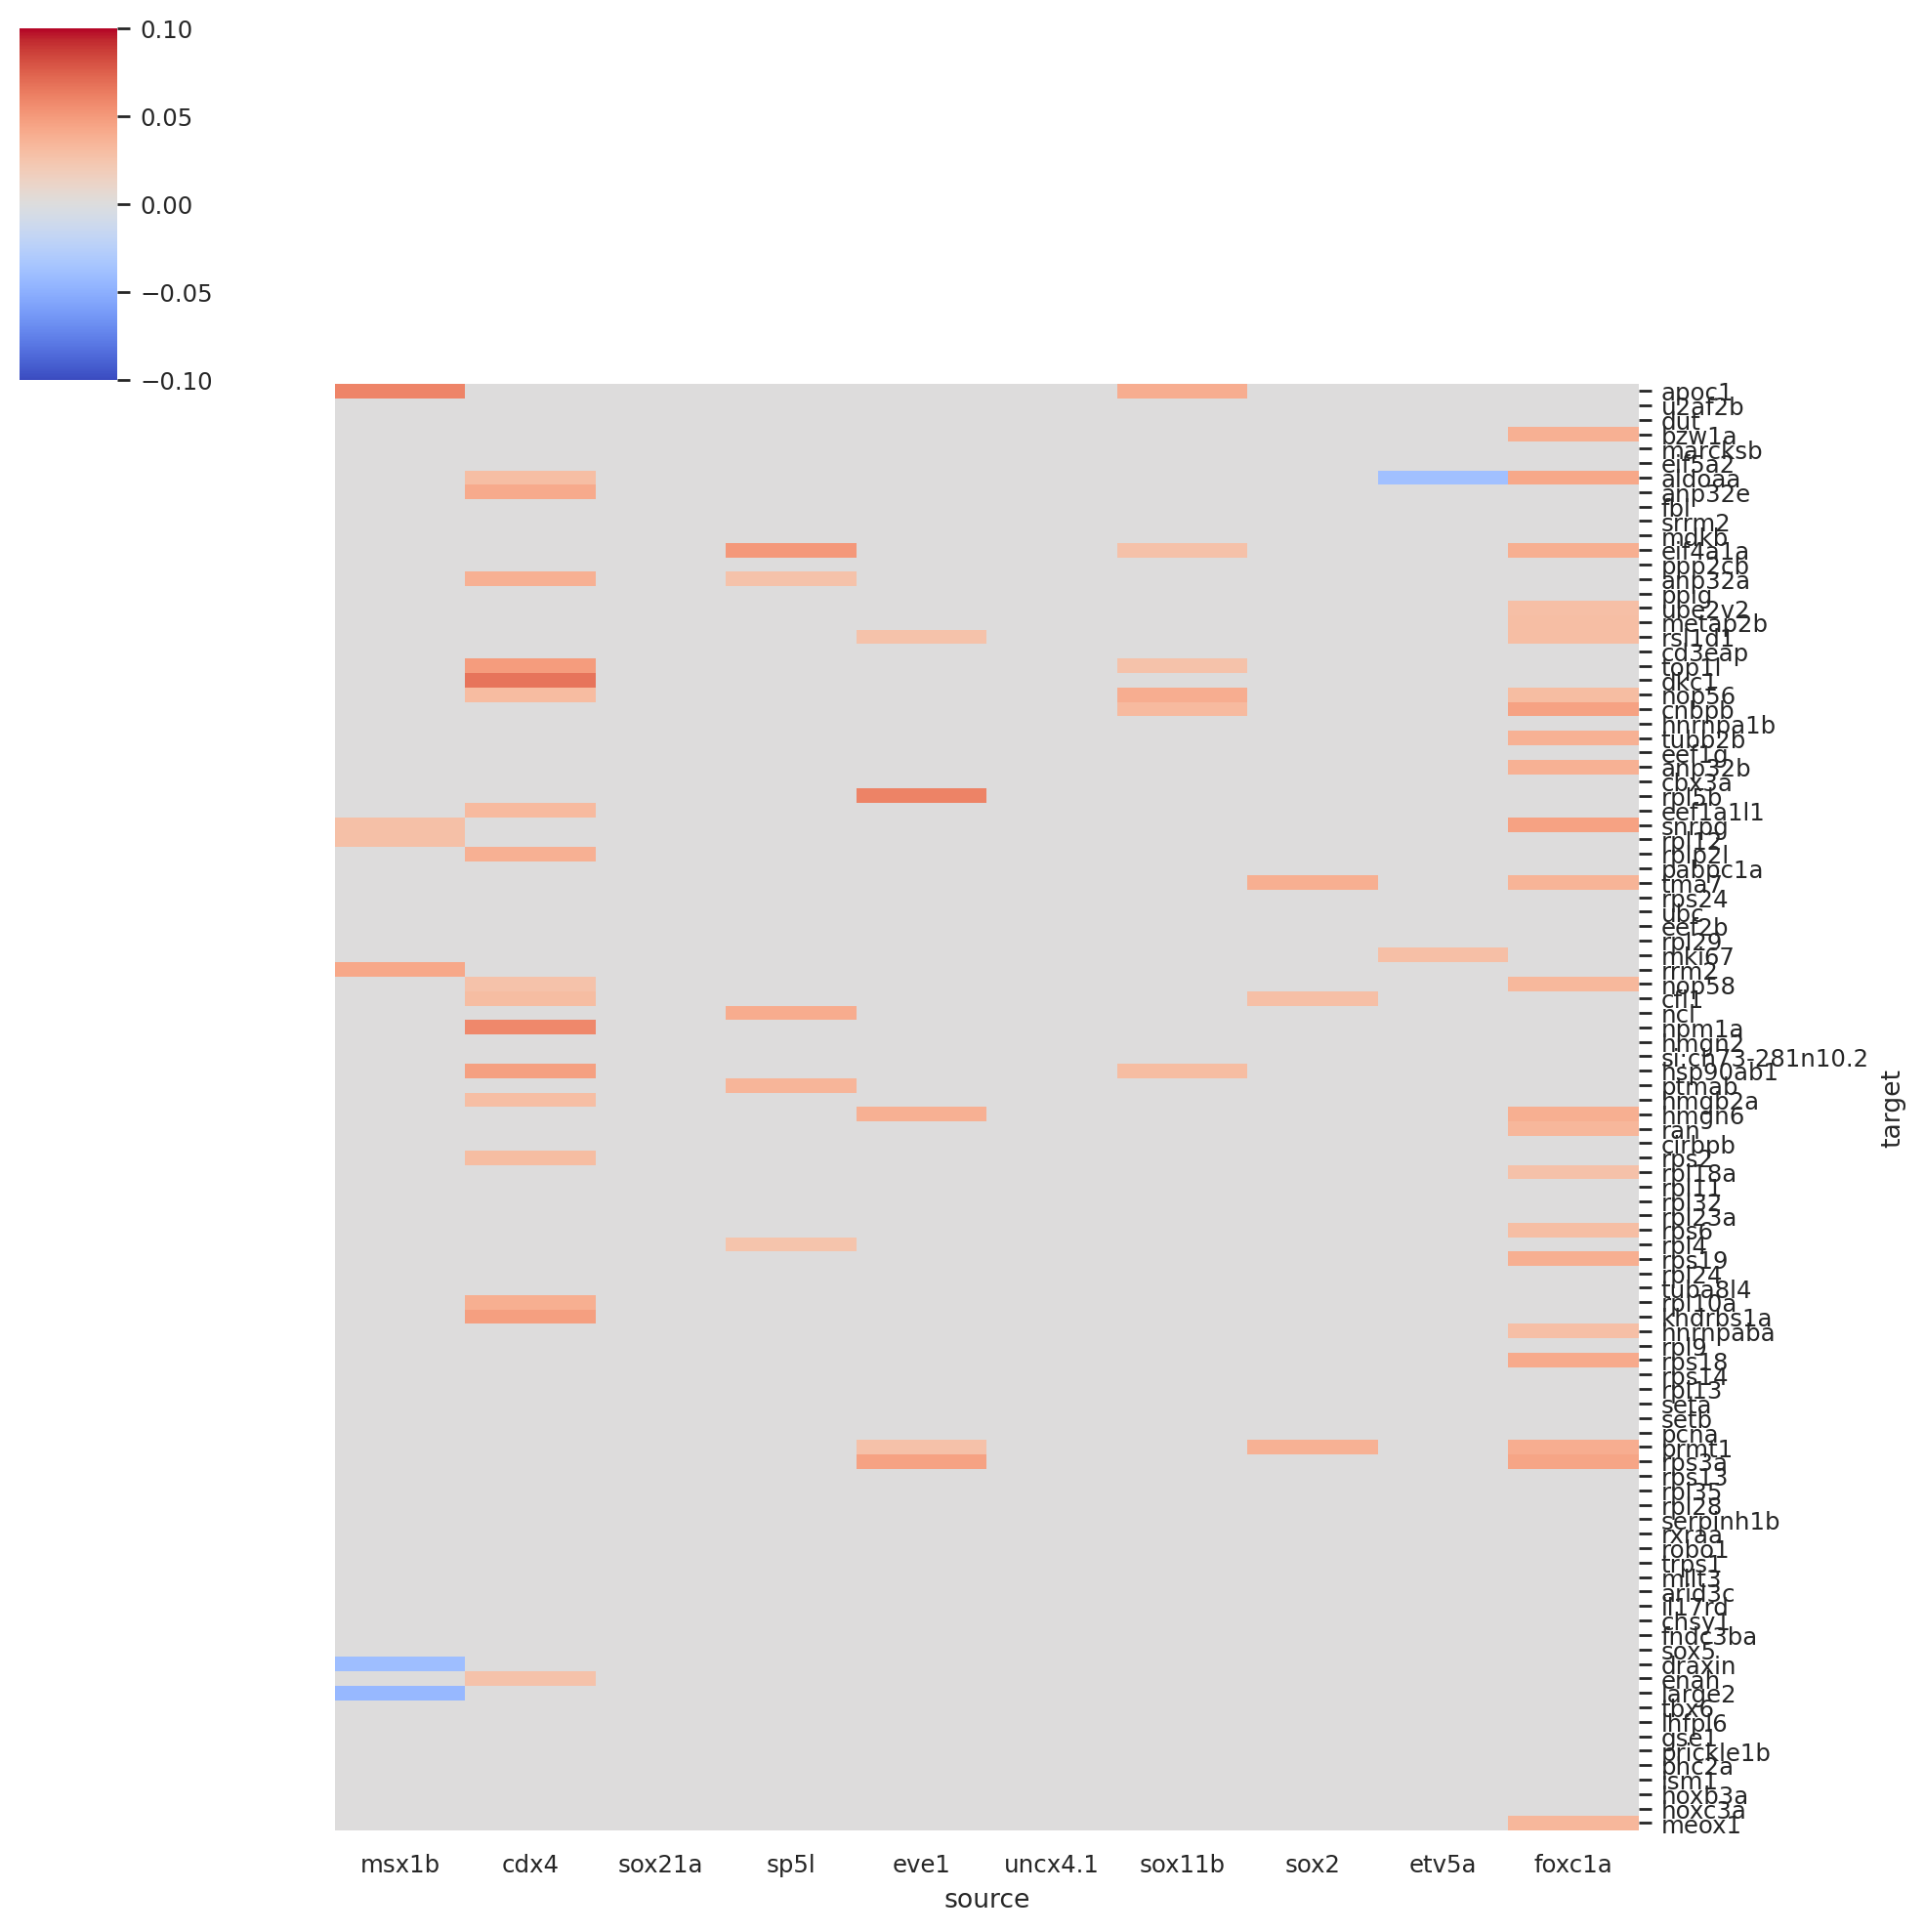

In [100]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_0somites_upreg2, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "spinal_cord"
stage = "0somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_2.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_2.png")

plt.show()

### Sectioning the left-bottom for "increasing over time"

In [127]:
df_counts = df_counts_union["TDR125"]

In [139]:
# Assuming you have determined your cluster size and its position (last N rows and M columns)
N = 1  # The number of rows in the cluster, replace with the actual number
M = 14  # The number of columns in the cluster, replace with the actual number

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g1.dendrogram_row.reordered_ind[-49:-4]
col_indices = g2.dendrogram_col.reordered_ind[5:14]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source     meis1b      rfx4  sox13    sox11a     foxp4      sox3  pax6a  \
target                                                                    
rgs3a    0.000000  0.000000    0.0  0.000000  0.000000  0.000000    0.0   
pho      0.000000  0.000000    0.0  0.000000  0.000000  0.000000    0.0   
chrd     0.000000  0.000000    0.0  0.000000  0.000000  0.000000    0.0   
notch1b  0.085047  0.000000    0.0  0.000000  0.000000  0.000000    0.0   
hoxb3a   0.041205  0.000000    0.0  0.000000  0.070258  0.000000    0.0   
...           ...       ...    ...       ...       ...       ...    ...   
pax6b    0.000000  0.000000    0.0  0.000000  0.000000  0.034002    0.0   
ptprfb   0.030693  0.046815    0.0  0.000000  0.000000  0.000000    0.0   
pleca    0.000000  0.000000    0.0  0.000000  0.000000  0.000000    0.0   
meis1a   0.000000  0.000000    0.0  0.000000  0.000000  0.051060    0.0   
mllt3    0.033427  0.000000    0.0  0.037516  0.000000  0.027021    0.0   

source      pax6b  sox21

In [140]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union["TDR125"]

df_counts_20somites_upreg = df_counts.loc[row_names, col_names]
df_counts_20somites_upreg

source       meis1b      rfx4     sox13    sox11a     foxp4      sox3  \
target                                                                  
epha4a     0.026029  0.000000  0.000000  0.000000  0.065640  0.000000   
nova2      0.078118  0.000000  0.031407  0.053438  0.089618  0.029745   
cdh11      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
bcam       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
pcdh19     0.063511  0.000000  0.000000  0.000000  0.000000  0.000000   
fgfr3      0.035311  0.000000  0.000000  0.000000  0.028588  0.000000   
adamts3    0.035836  0.000000  0.000000  0.000000  0.000000  0.000000   
arvcfb     0.027501  0.057651  0.000000  0.000000  0.000000  0.000000   
dacha      0.024680  0.046688  0.000000  0.000000  0.000000  0.000000   
foxp4      0.028683  0.074662  0.000000  0.037861  0.000000  0.036966   
oc90       0.000000  0.074357  0.000000  0.000000  0.000000  0.000000   
cep131     0.000000  0.032706  0.000000  0.000000  0.000000  0.000000   
zeb2a      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ek1        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
nfia       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
angptl2b   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
chsy1      0.051585  0.056569  0.000000 -0.036581  0.032146  0.000000   
gnao1a     0.000000  0.059919  0.000000  0.000000  0.031124  0.000000   
adgrv1     0.000000  0.059028  0.000000  0.000000  0.031935  0.000000   
lmo3       0.000000  0.041287  0.000000  0.000000  0.000000  0.000000   
sulf2a     0.023942  0.035536  0.000000  0.000000  0.043205  0.000000   
skia       0.040841  0.024000  0.000000  0.000000  0.000000  0.000000   
lrp2a      0.026112  0.048235  0.000000  0.000000  0.000000  0.000000   
ctnnd2b    0.000000  0.030897  0.000000  0.027127  0.000000  0.000000   
cdh7a      0.035449  0.000000 -0.029445  0.050664  0.000000  0.061834   
gli2a      0.036395  0.000000  0.000000  0.000000  0.000000  0.000000   
robo1      0.025704  0.000000  0.000000  0.000000  0.000000  0.000000   
trps1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
map7d1a    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
cadm1a     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
prickle2b  0.024423  0.000000  0.000000  0.000000  0.000000  0.000000   
rfx4       0.000000  0.000000  0.028063  0.000000  0.036339  0.000000   
plekhh1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
fgfr2      0.046128  0.000000  0.000000  0.000000  0.000000  0.000000   
sox11a     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
nfasca     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ank2b      0.036733  0.000000  0.045993  0.000000  0.039661  0.036452   
pvrl2l     0.000000  0.000000  0.024023  0.000000  0.000000  0.000000   
ptprfa     0.038856  0.031749  0.000000  0.000000  0.049893  0.000000   
wnt4       0.051082  0.000000  0.032063  0.000000  0.000000  0.000000   
pax6b      0.000000  0.000000  0.000000  0.000000  0.000000  0.034002   
ptprfb     0.030693  0.046815  0.000000  0.000000  0.000000  0.000000   
pleca      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
meis1a     0.000000  0.000000  0.000000  0.000000  0.000000  0.051060   
mllt3      0.033427  0.000000  0.000000  0.037516  0.000000  0.027021   

source        pax6a     pax6b    sox21a  
target                                   
epha4a     0.000000  0.000000  0.000000  
nova2      0.048030  0.000000  0.000000  
cdh11      0.033886 -0.081613  0.000000  
bcam       0.000000  0.080687  0.000000  
pcdh19     0.048171 -0.028780  0.000000  
fgfr3      0.029059  0.000000  0.000000  
adamts3    0.000000 -0.070187 -0.025572  
arvcfb     0.000000  0.000000  0.000000  
dacha      0.000000  0.000000  0.000000  
foxp4      0.000000  0.000000  0.000000  
oc90       0.000000  0.000000  0.000000  
cep131     0.000000  0

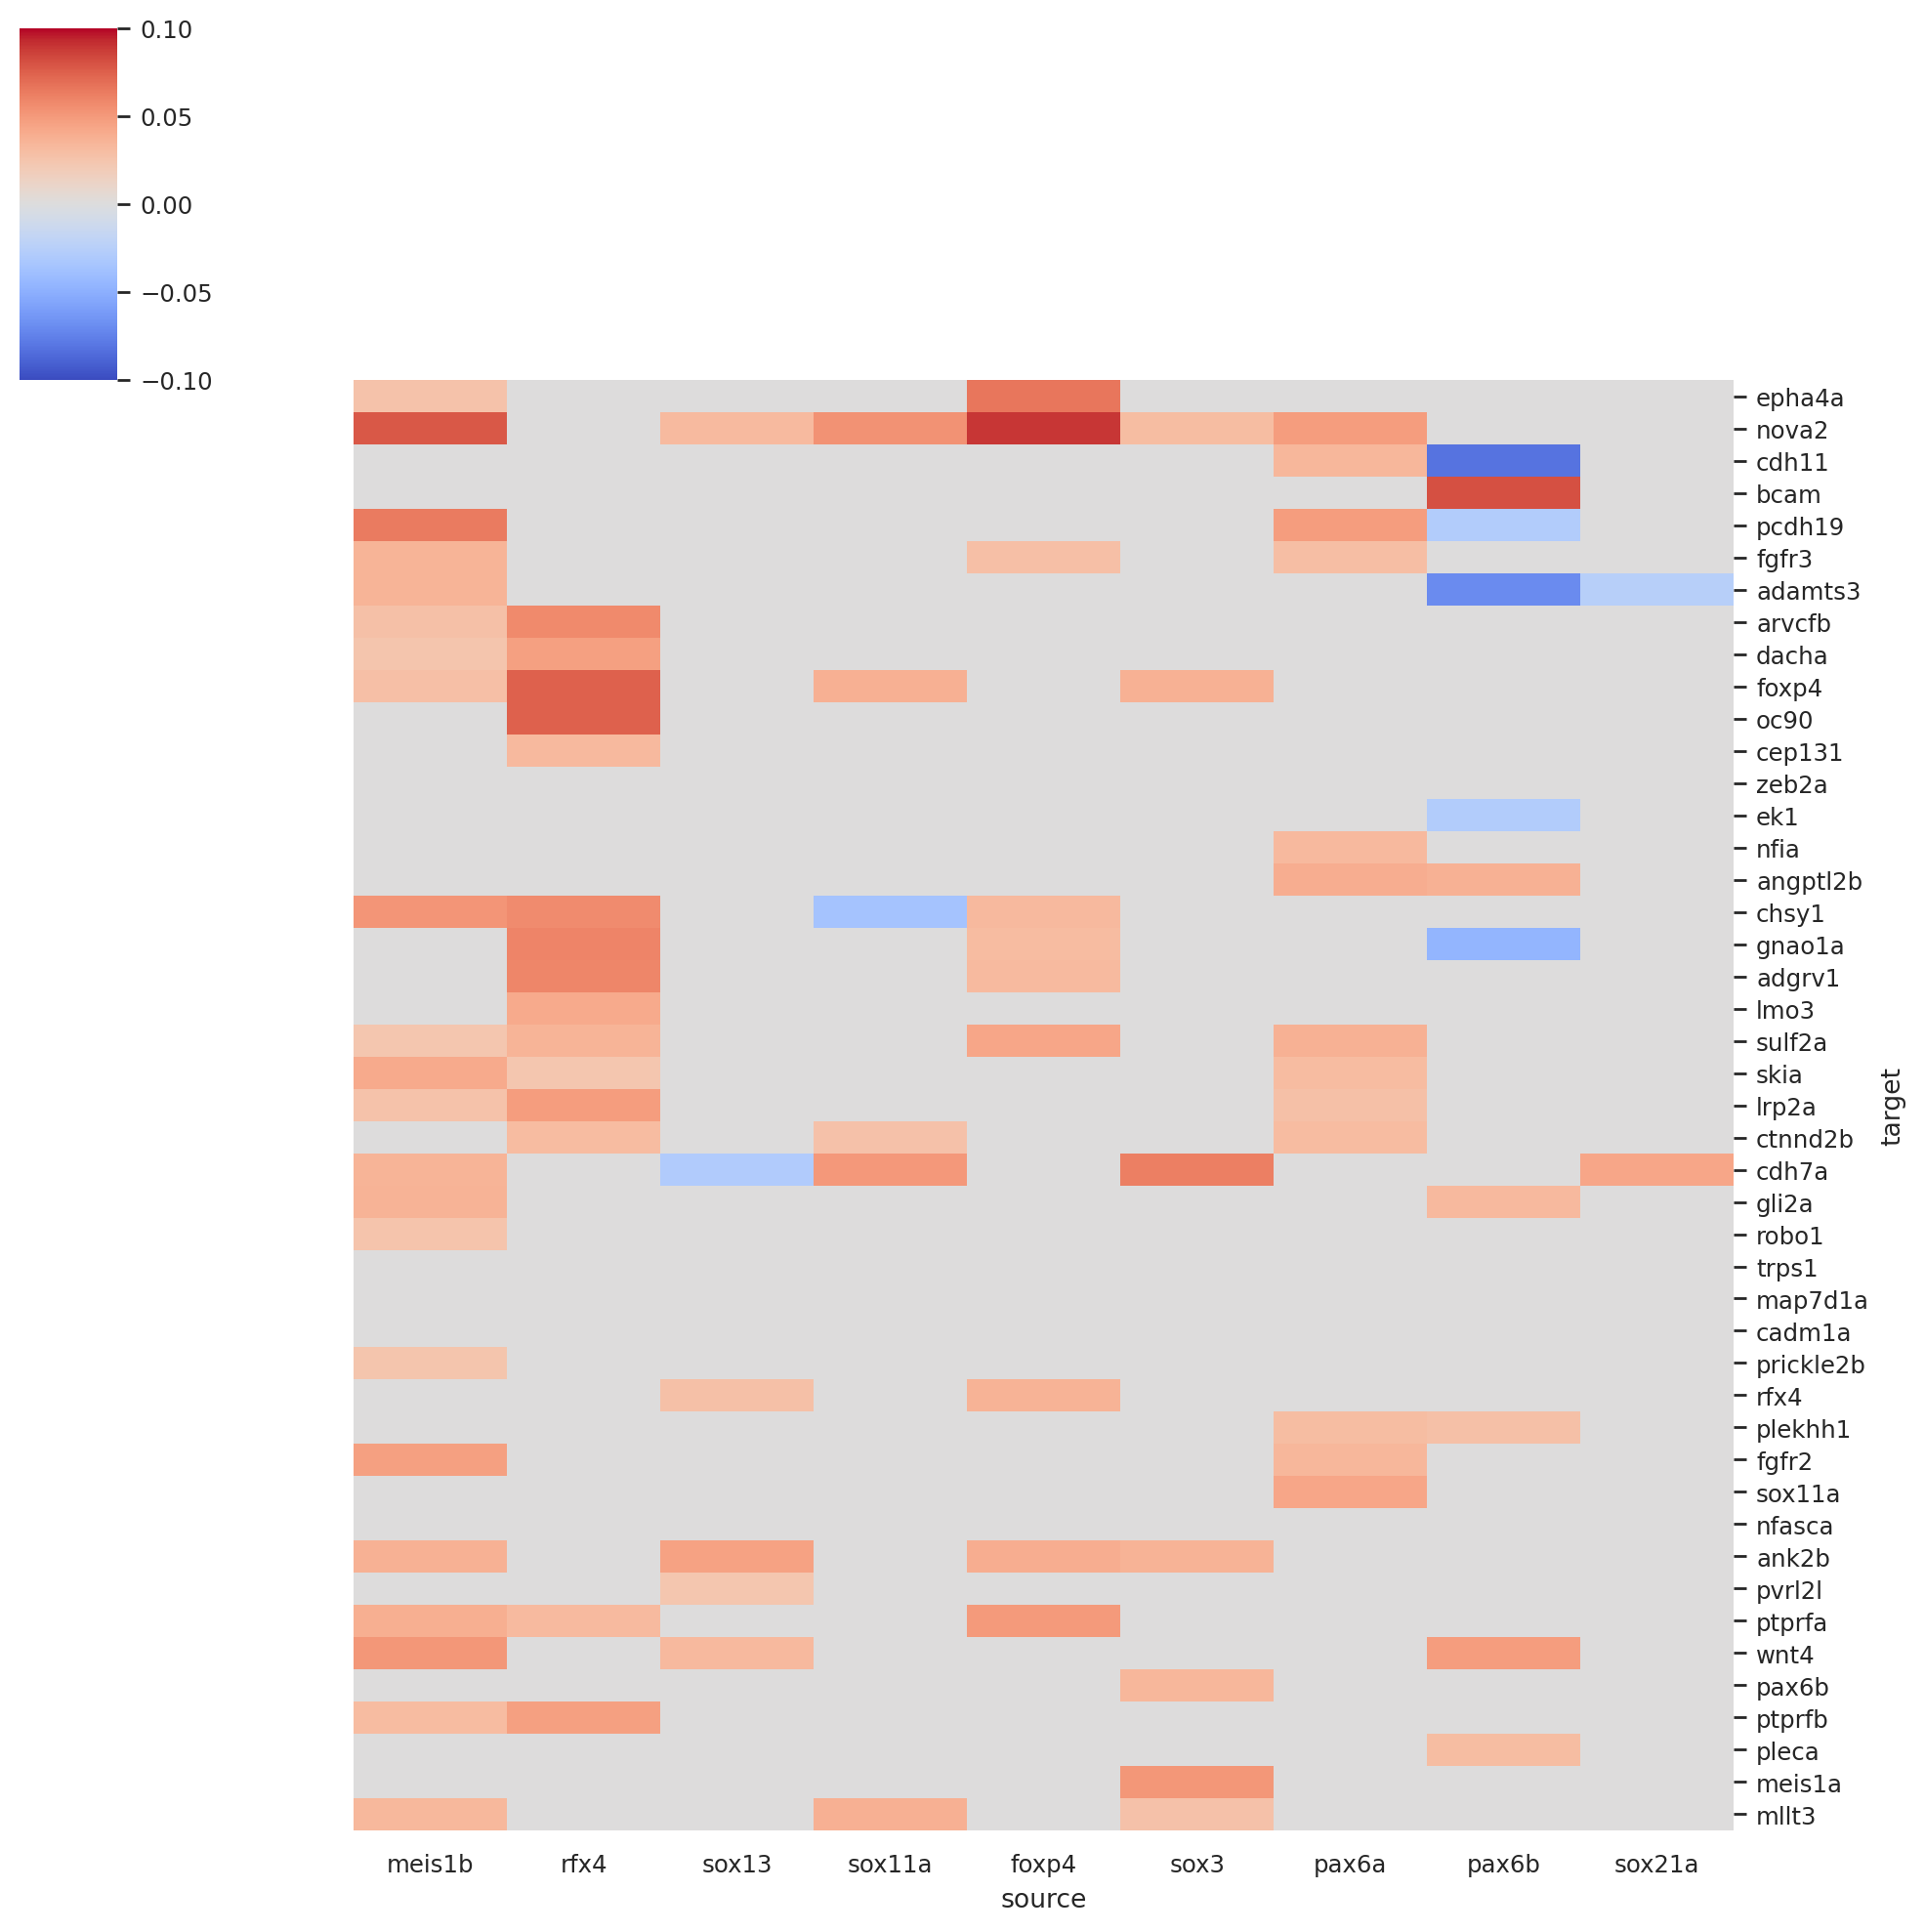

In [141]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_20somites_upreg, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "spinal_cord"
stage = "20somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg.png")

plt.show()

### other block of sub-GRN that is activated until 20-somites, and disappear after 30 somites

In [127]:
df_counts = df_counts_union["TDR125"]

In [145]:
# Assuming you have determined your cluster size and its position (last N rows and M columns)
N = 1  # The number of rows in the cluster, replace with the actual number
M = 14  # The number of columns in the cluster, replace with the actual number

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g1.dendrogram_row.reordered_ind[-67:-50]
col_indices = g2.dendrogram_col.reordered_ind[5:14]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source       meis1b      rfx4     sox13    sox11a     foxp4      sox3  \
target                                                                  
notch1b    0.085047  0.000000  0.000000  0.000000  0.000000  0.000000   
hoxb3a     0.041205  0.000000  0.000000  0.000000  0.070258  0.000000   
hoxc3a     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
tenm4      0.034603  0.034293  0.000000  0.000000  0.000000  0.000000   
chl1a      0.042131  0.000000  0.000000 -0.075735  0.000000  0.000000   
greb1l     0.099554  0.065371  0.000000  0.083381  0.000000  0.055359   
col18a1a   0.000000  0.114814  0.046122  0.067223  0.000000  0.053856   
zbtb16a    0.138662  0.044161  0.045007  0.000000  0.000000  0.000000   
ntn1a      0.049708  0.119639  0.000000  0.000000  0.000000  0.000000   
epha4b     0.038223  0.079996  0.000000  0.000000  0.000000  0.000000   
cntfr      0.037398  0.112220  0.000000  0.000000  0.066687  0.000000   
rnf220a    0.000000  0.000000  0.036418  0.000000  

In [146]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union["TDR125"]

df_counts_20somites_upreg2 = df_counts.loc[row_names, col_names]
df_counts_20somites_upreg2

source       meis1b      rfx4     sox13    sox11a     foxp4      sox3  \
target                                                                  
notch1b    0.085047  0.000000  0.000000  0.000000  0.000000  0.000000   
hoxb3a     0.041205  0.000000  0.000000  0.000000  0.070258  0.000000   
hoxc3a     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
tenm4      0.034603  0.034293  0.000000  0.000000  0.000000  0.000000   
chl1a      0.042131  0.000000  0.000000 -0.075735  0.000000  0.000000   
greb1l     0.099554  0.065371  0.000000  0.083381  0.000000  0.055359   
col18a1a   0.000000  0.114814  0.046122  0.067223  0.000000  0.053856   
zbtb16a    0.138662  0.044161  0.045007  0.000000  0.000000  0.000000   
ntn1a      0.049708  0.119639  0.000000  0.000000  0.000000  0.000000   
epha4b     0.038223  0.079996  0.000000  0.000000  0.000000  0.000000   
cntfr      0.037398  0.112220  0.000000  0.000000  0.066687  0.000000   
rnf220a    0.000000  0.000000  0.036418  0.000000  0.065731  0.000000   
col28a2a   0.081213  0.000000  0.000000  0.051972  0.089422  0.033771   
ncam1b     0.045437  0.000000  0.030797  0.000000  0.000000  0.000000   
ncam1a     0.038495  0.000000  0.024635  0.000000  0.077781  0.000000   
gli3       0.000000  0.000000  0.000000  0.000000  0.046311  0.000000   
hs3st3b1b  0.000000  0.029601  0.000000  0.000000  0.041294  0.000000   

source        pax6a     pax6b    sox21a  
target                                   
notch1b    0.000000  0.000000  0.000000  
hoxb3a     0.000000  0.000000  0.000000  
hoxc3a     0.000000  0.000000  0.000000  
tenm4      0.027622 -0.062892  0.000000  
chl1a      0.000000  0.000000 -0.053638  
greb1l     0.041188  0.000000  0.000000  
col18a1a   0.000000  0.000000  0.000000  
zbtb16a    0.000000  0.000000  0.025660  
ntn1a      0.000000 -0.049488  0.000000  
epha4b     0.000000  0.000000  0.000000  
cntfr      0.000000 -0.035933  0.000000  
rnf220a    0.063267  0.000000  0.033620  
col28a2a   0.000000  0.040072  0.035271  
ncam1b     0.034487  0.041279  0.000000  
ncam1a     0.046852  0.000000  0.031251  
gli3       0.033352  0.000000  0.000000  
hs3st3b1b  0.077882  0.041906  0.000000

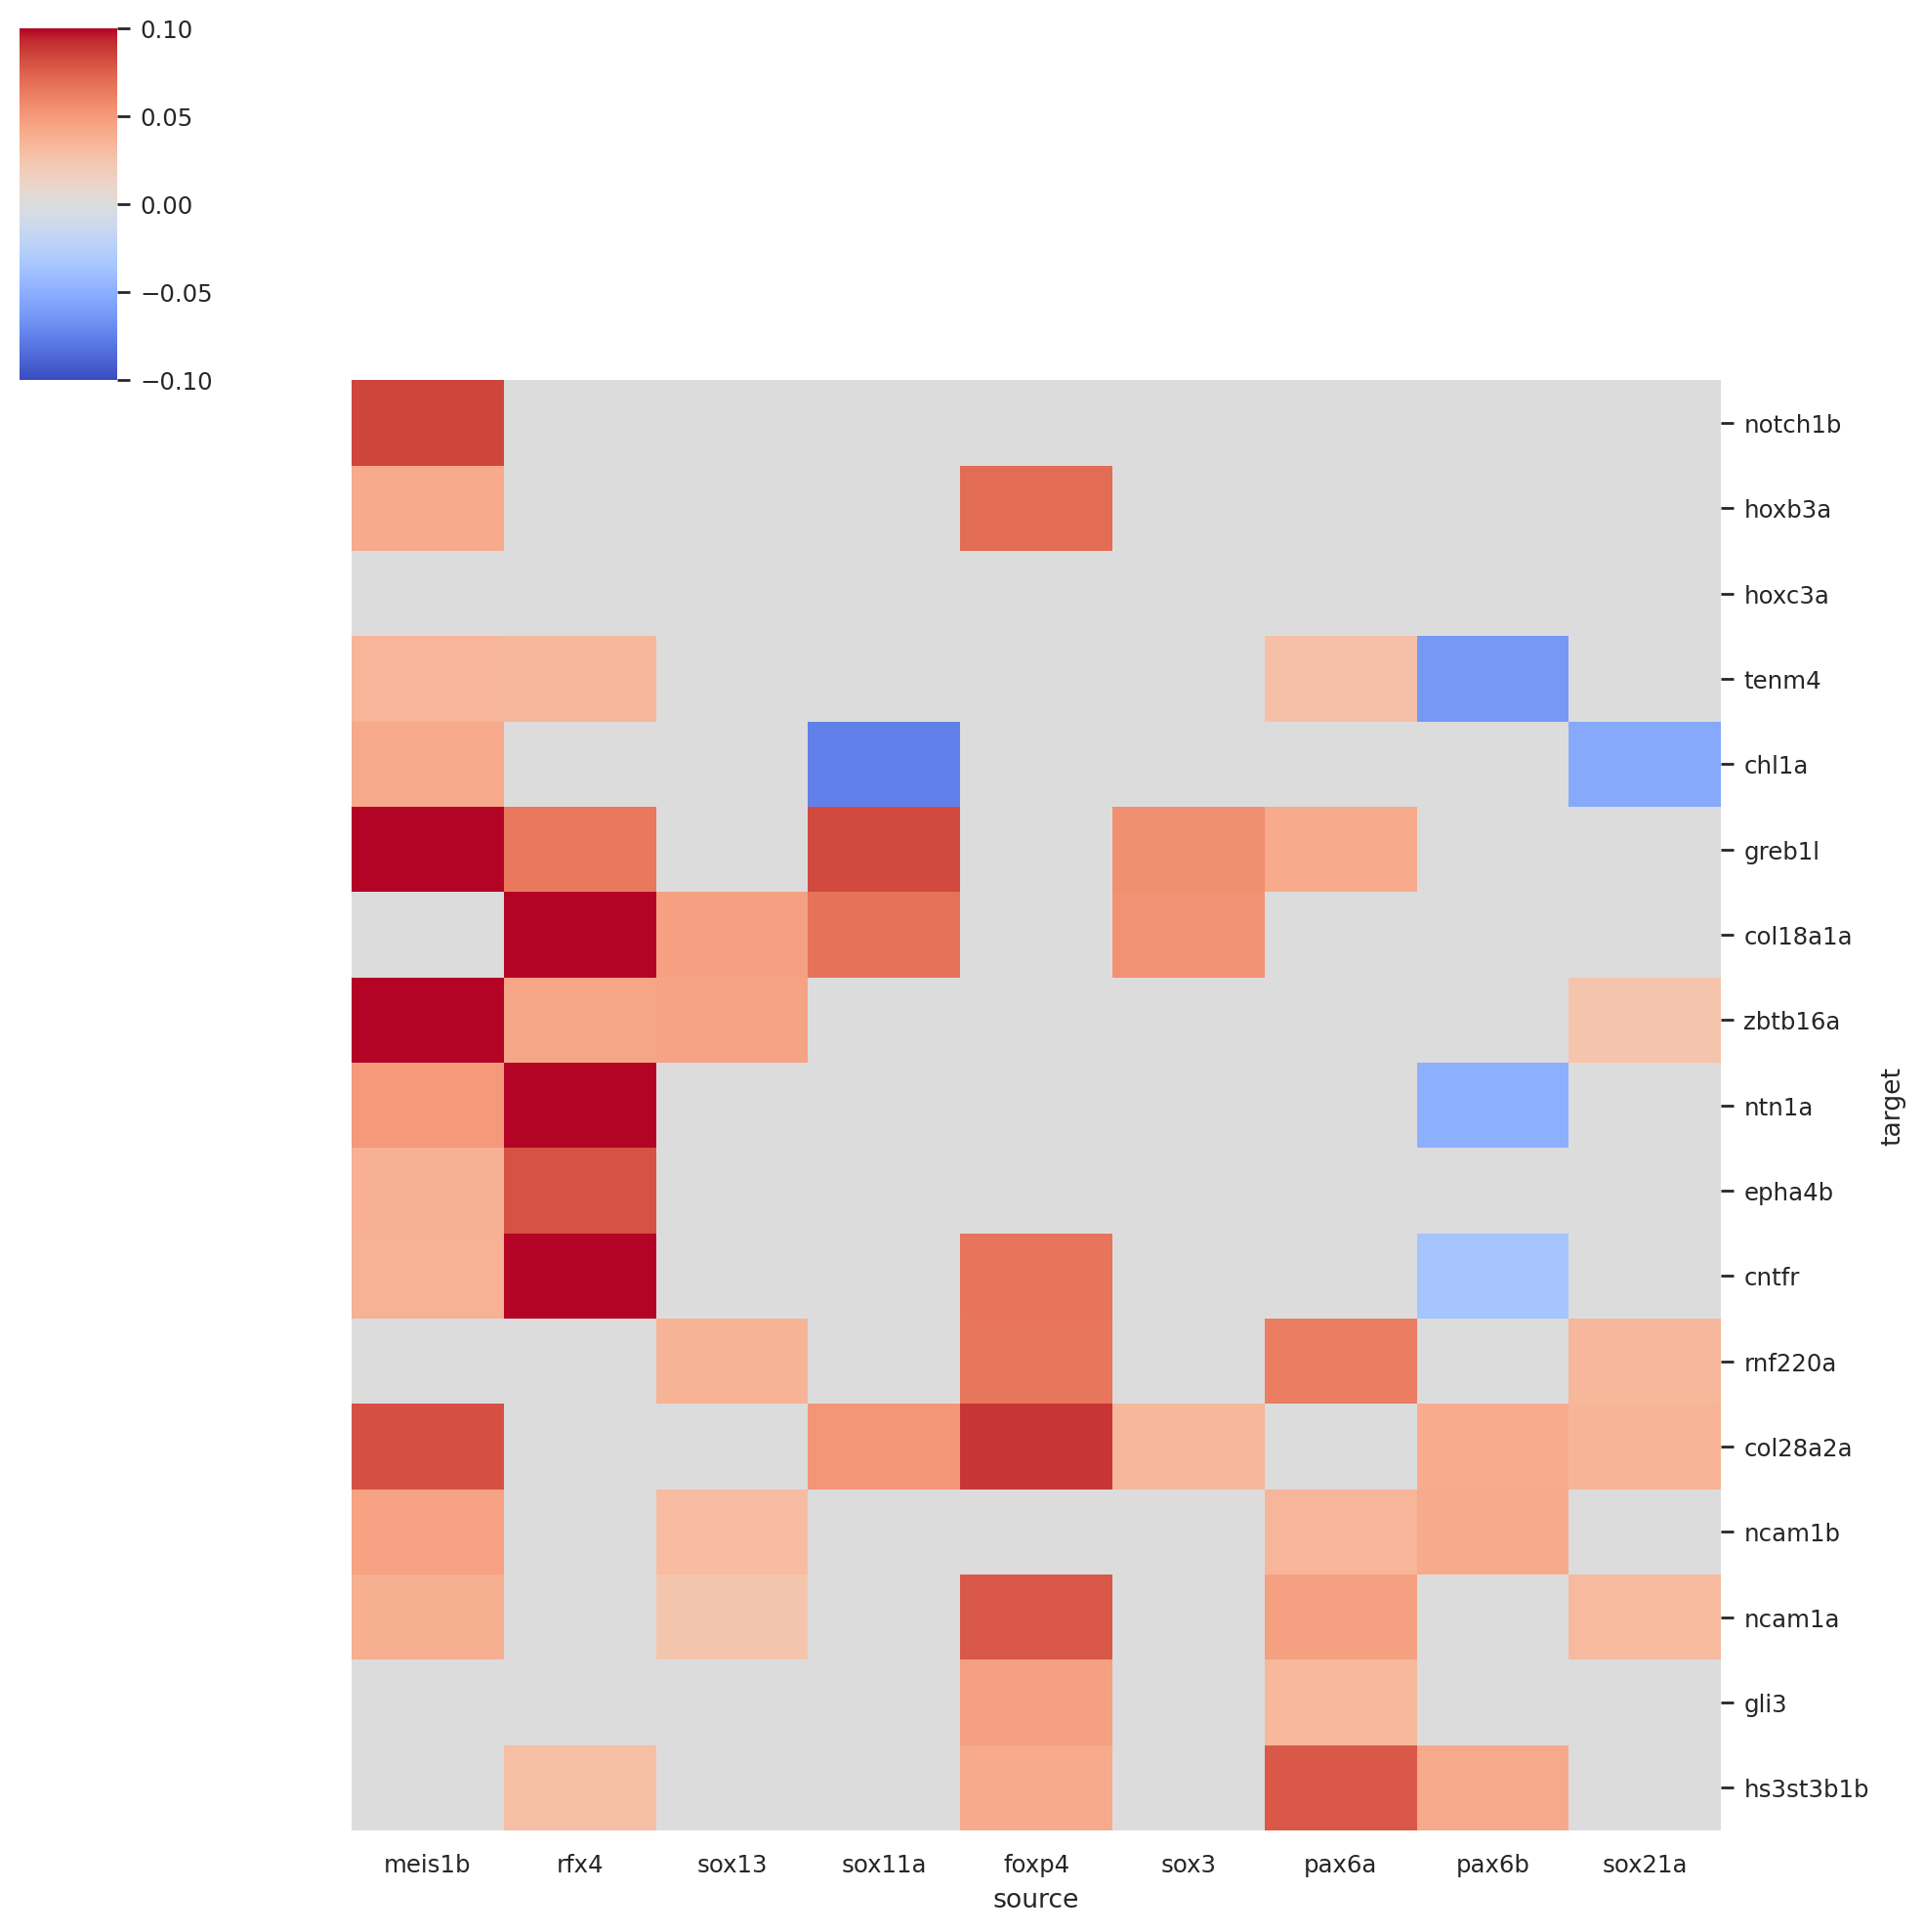

In [147]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_20somites_upreg2, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "spinal_cord"
stage = "20somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg2.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg2.png")

plt.show()

### sum of the first and the second blocks


In [148]:
df_counts = df_counts_union["TDR125"]

In [149]:
# Assuming you have determined your cluster size and its position (last N rows and M columns)
N = 1  # The number of rows in the cluster, replace with the actual number
M = 14  # The number of columns in the cluster, replace with the actual number

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g1.dendrogram_row.reordered_ind[-67:-4]
col_indices = g2.dendrogram_col.reordered_ind[5:14]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source     meis1b      rfx4  sox13    sox11a     foxp4      sox3     pax6a  \
target                                                                       
notch1b  0.085047  0.000000    0.0  0.000000  0.000000  0.000000  0.000000   
hoxb3a   0.041205  0.000000    0.0  0.000000  0.070258  0.000000  0.000000   
hoxc3a   0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000   
tenm4    0.034603  0.034293    0.0  0.000000  0.000000  0.000000  0.027622   
chl1a    0.042131  0.000000    0.0 -0.075735  0.000000  0.000000  0.000000   
...           ...       ...    ...       ...       ...       ...       ...   
pax6b    0.000000  0.000000    0.0  0.000000  0.000000  0.034002  0.000000   
ptprfb   0.030693  0.046815    0.0  0.000000  0.000000  0.000000  0.000000   
pleca    0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000   
meis1a   0.000000  0.000000    0.0  0.000000  0.000000  0.051060  0.000000   
mllt3    0.033427  0.000000    0.0  0.037516  0.000000  0.027021

In [150]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union["TDR125"]

df_counts_20somites_upreg = df_counts.loc[row_names, col_names]
df_counts_20somites_upreg

source     meis1b      rfx4  sox13    sox11a     foxp4      sox3     pax6a  \
target                                                                       
notch1b  0.085047  0.000000    0.0  0.000000  0.000000  0.000000  0.000000   
hoxb3a   0.041205  0.000000    0.0  0.000000  0.070258  0.000000  0.000000   
hoxc3a   0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000   
tenm4    0.034603  0.034293    0.0  0.000000  0.000000  0.000000  0.027622   
chl1a    0.042131  0.000000    0.0 -0.075735  0.000000  0.000000  0.000000   
...           ...       ...    ...       ...       ...       ...       ...   
pax6b    0.000000  0.000000    0.0  0.000000  0.000000  0.034002  0.000000   
ptprfb   0.030693  0.046815    0.0  0.000000  0.000000  0.000000  0.000000   
pleca    0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000   
meis1a   0.000000  0.000000    0.0  0.000000  0.000000  0.051060  0.000000   
mllt3    0.033427  0.000000    0.0  0.037516  0.000000  0.027021  0.000000   

source      pax6b    sox21a  
target                       
notch1b  0.000000  0.000000  
hoxb3a   0.000000  0.000000  
hoxc3a   0.000000  0.000000  
tenm4   -0.062892  0.000000  
chl1a    0.000000 -0.053638  
...           ...       ...  
pax6b    0.000000  0.000000  
ptprfb   0.000000  0.000000  
pleca    0.029908  0.000000  
meis1a   0.000000  0.000000  
mllt3    0.000000  0.000000  

[63 rows x 9 columns]

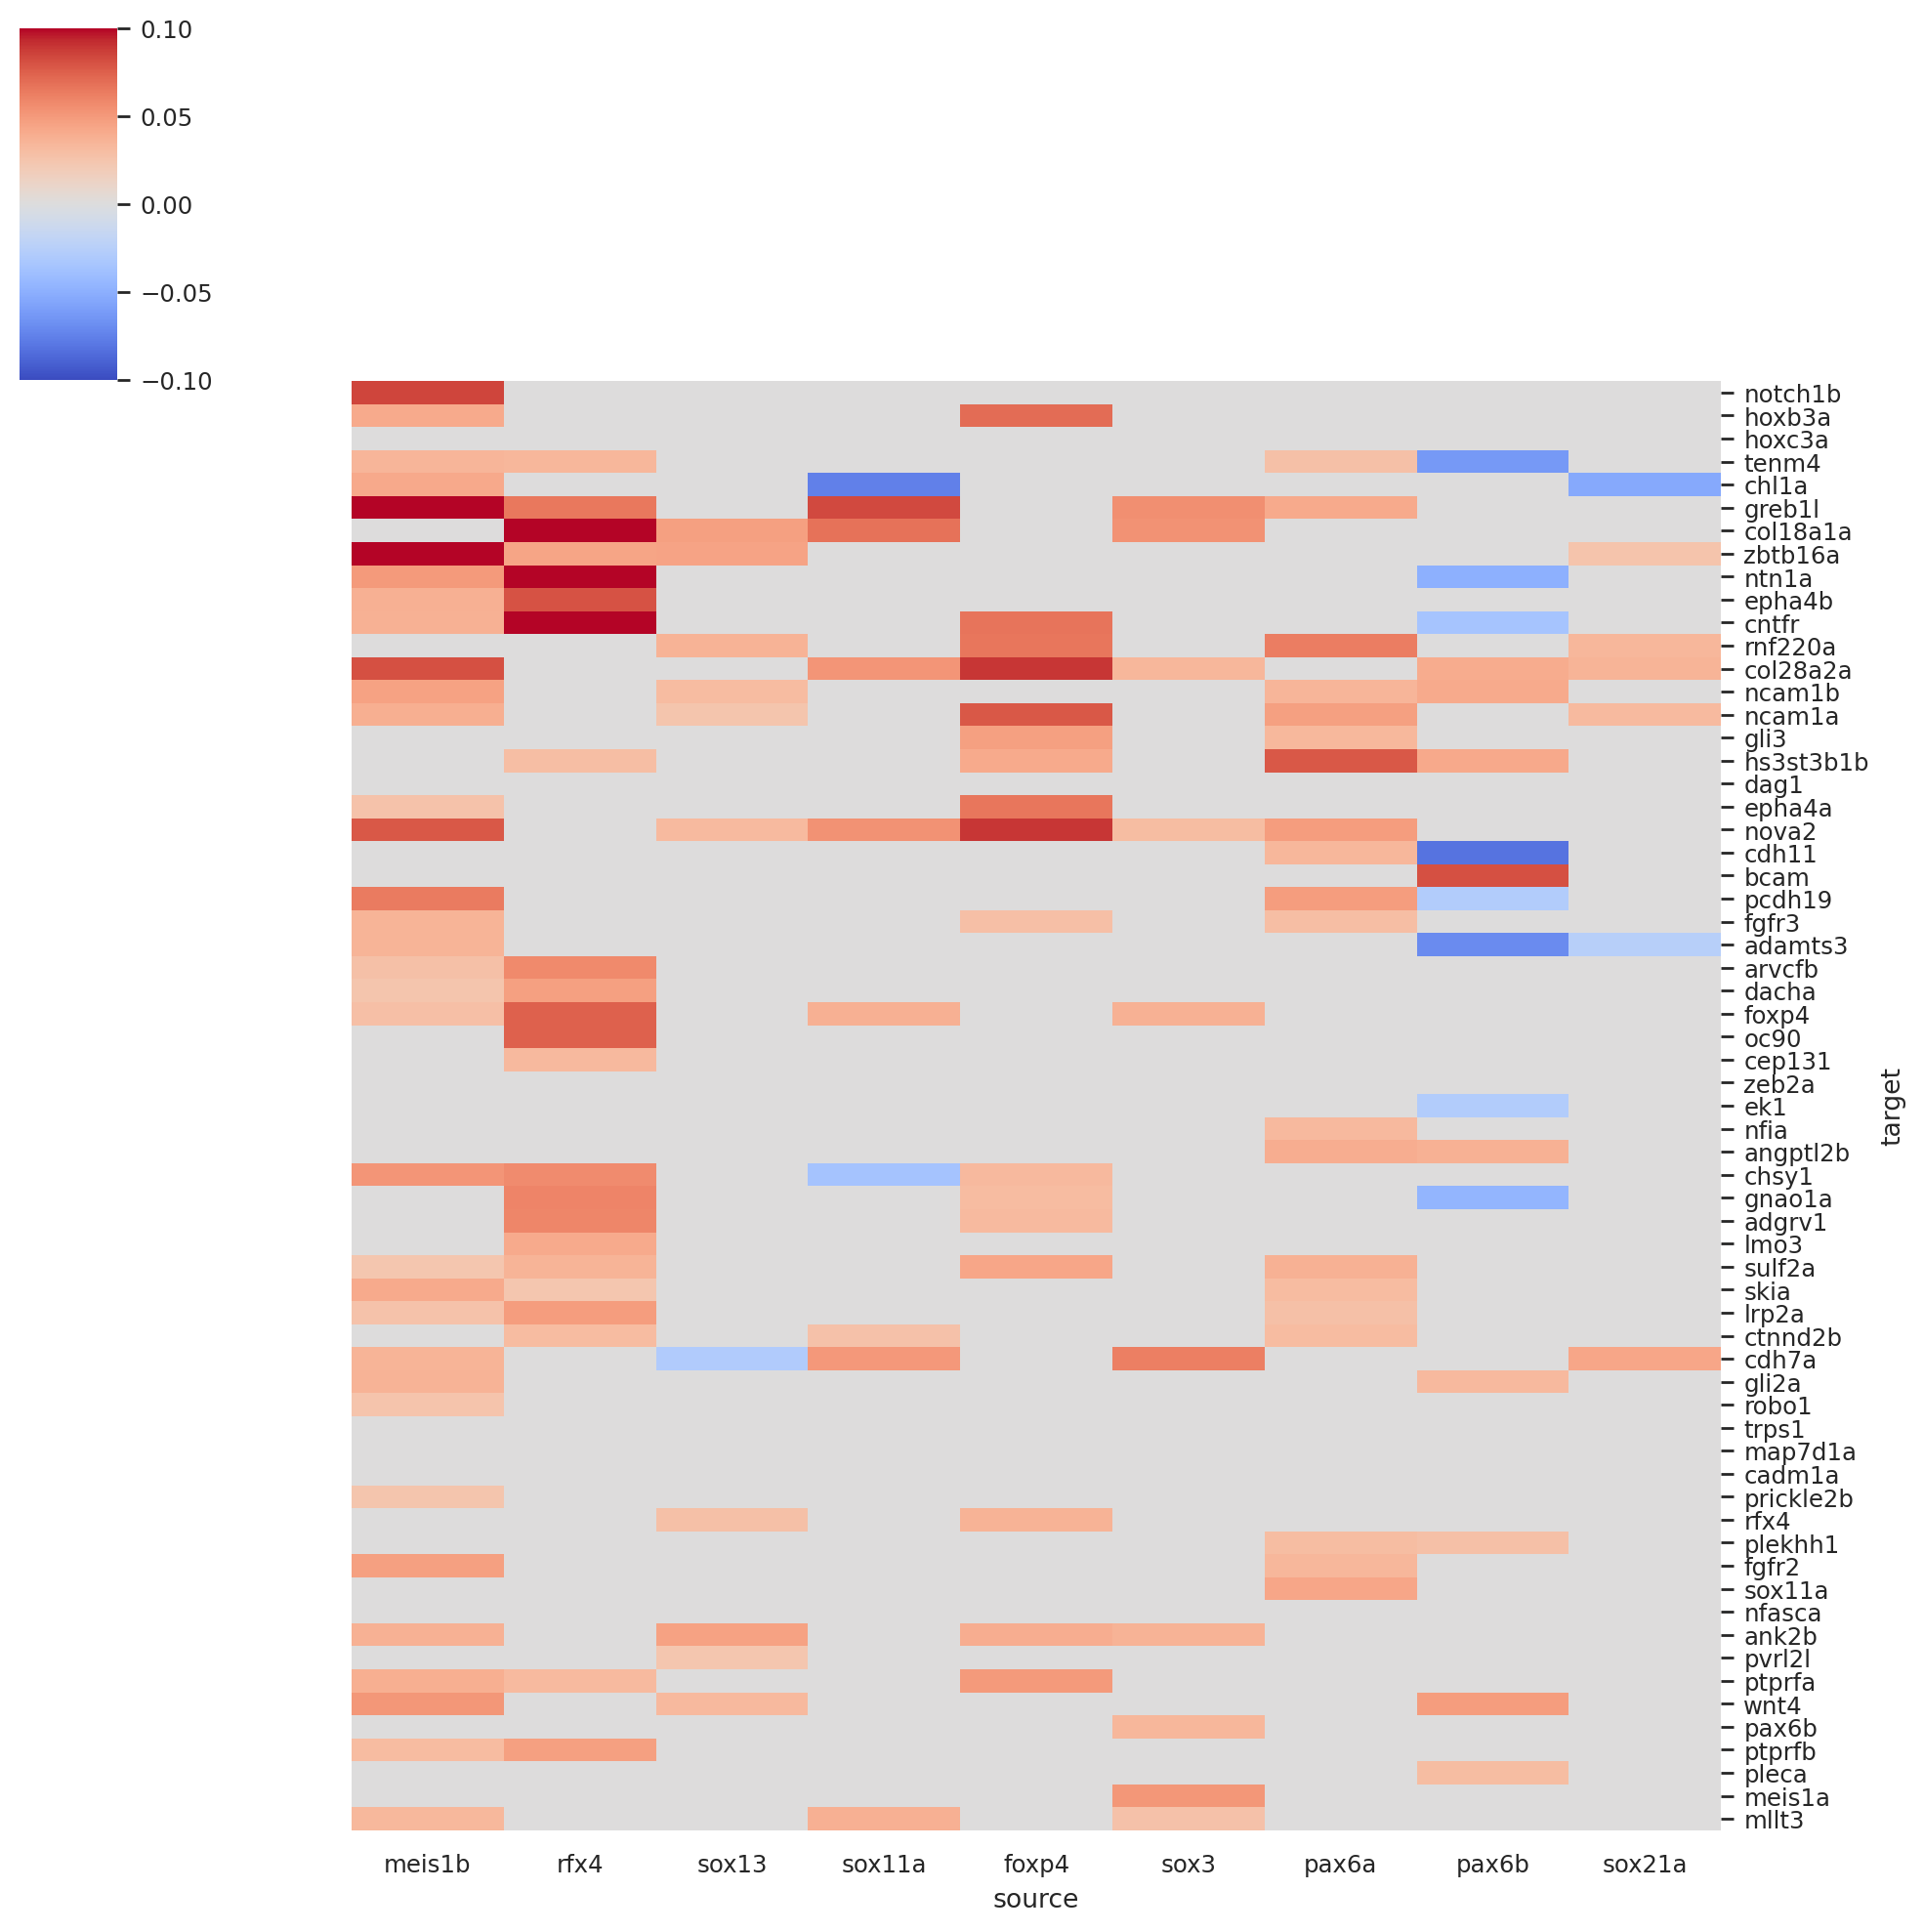

In [151]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_20somites_upreg, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "spinal_cord"
stage = "20somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg_3.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg_3.png")

plt.show()

### Conclusion - "spinal_cord" GRNs over time


### [OLD] Conclusion - "PSM" GRNs over time

- "hmga1a"'s regulation is down-regulated over time. "hmga" family of TFs are small non-histone proteins that can bind to DNA and modify chromatin states - likely accessilibilty of regulatory TFs to DNA (Vignali and Marracci, Int.J.Mol.Sci, 2020).
- We looked at "up-regulated/activated" GRNs over time - 30-somites stage is qualitatively very different from the previous stages, so we characterized two sub-GRNs: (1) activated at 30-somites, and (2) activated at 20-somites stage.

## Step2. Evolution of GRNs along the celltypes

- there are several approaches to this. We can either pick one timepoint, check the GRN evolution along the NMP trajectories, 
- or, we can see how this works over certain "modules" that we identified above (temporal dynamics)



In [152]:
# check the list of celltypes
dict_filtered_GRNs["TDR128"].keys()

dict_keys(['NMPs', 'PSM', 'fast_muscle', 'neural_posterior', 'somites', 'spinal_cord', 'tail_bud'])

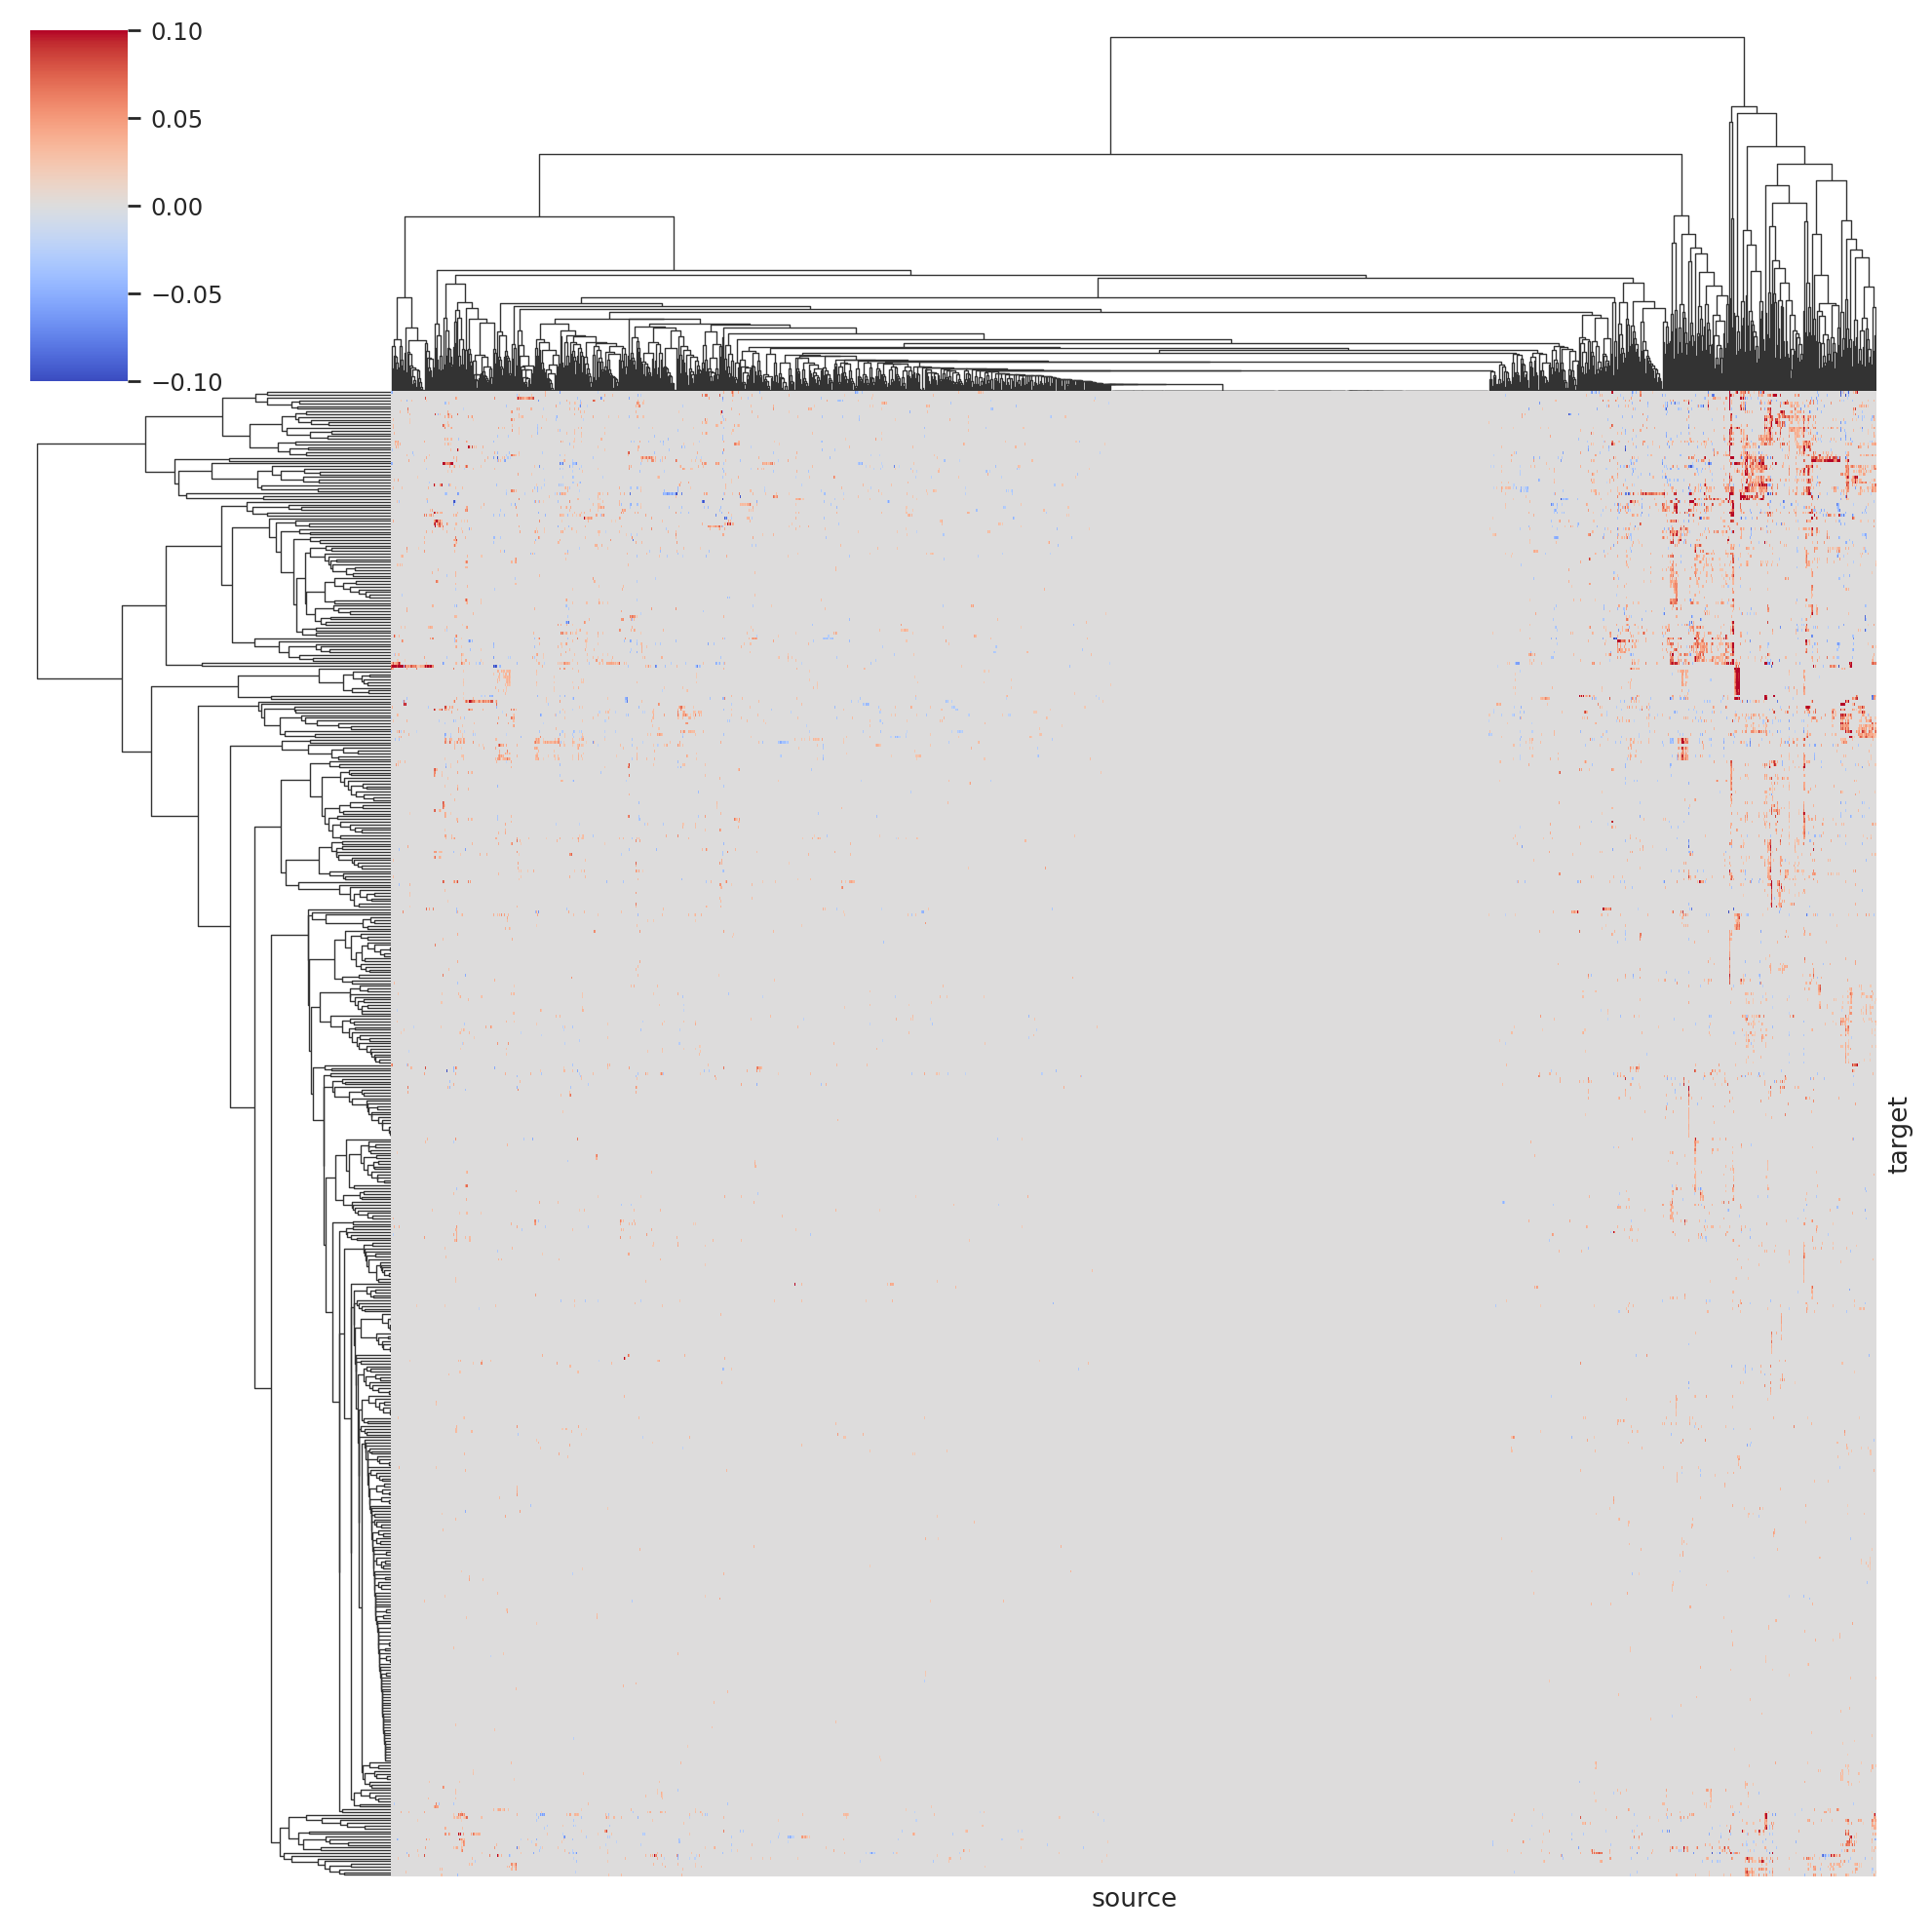

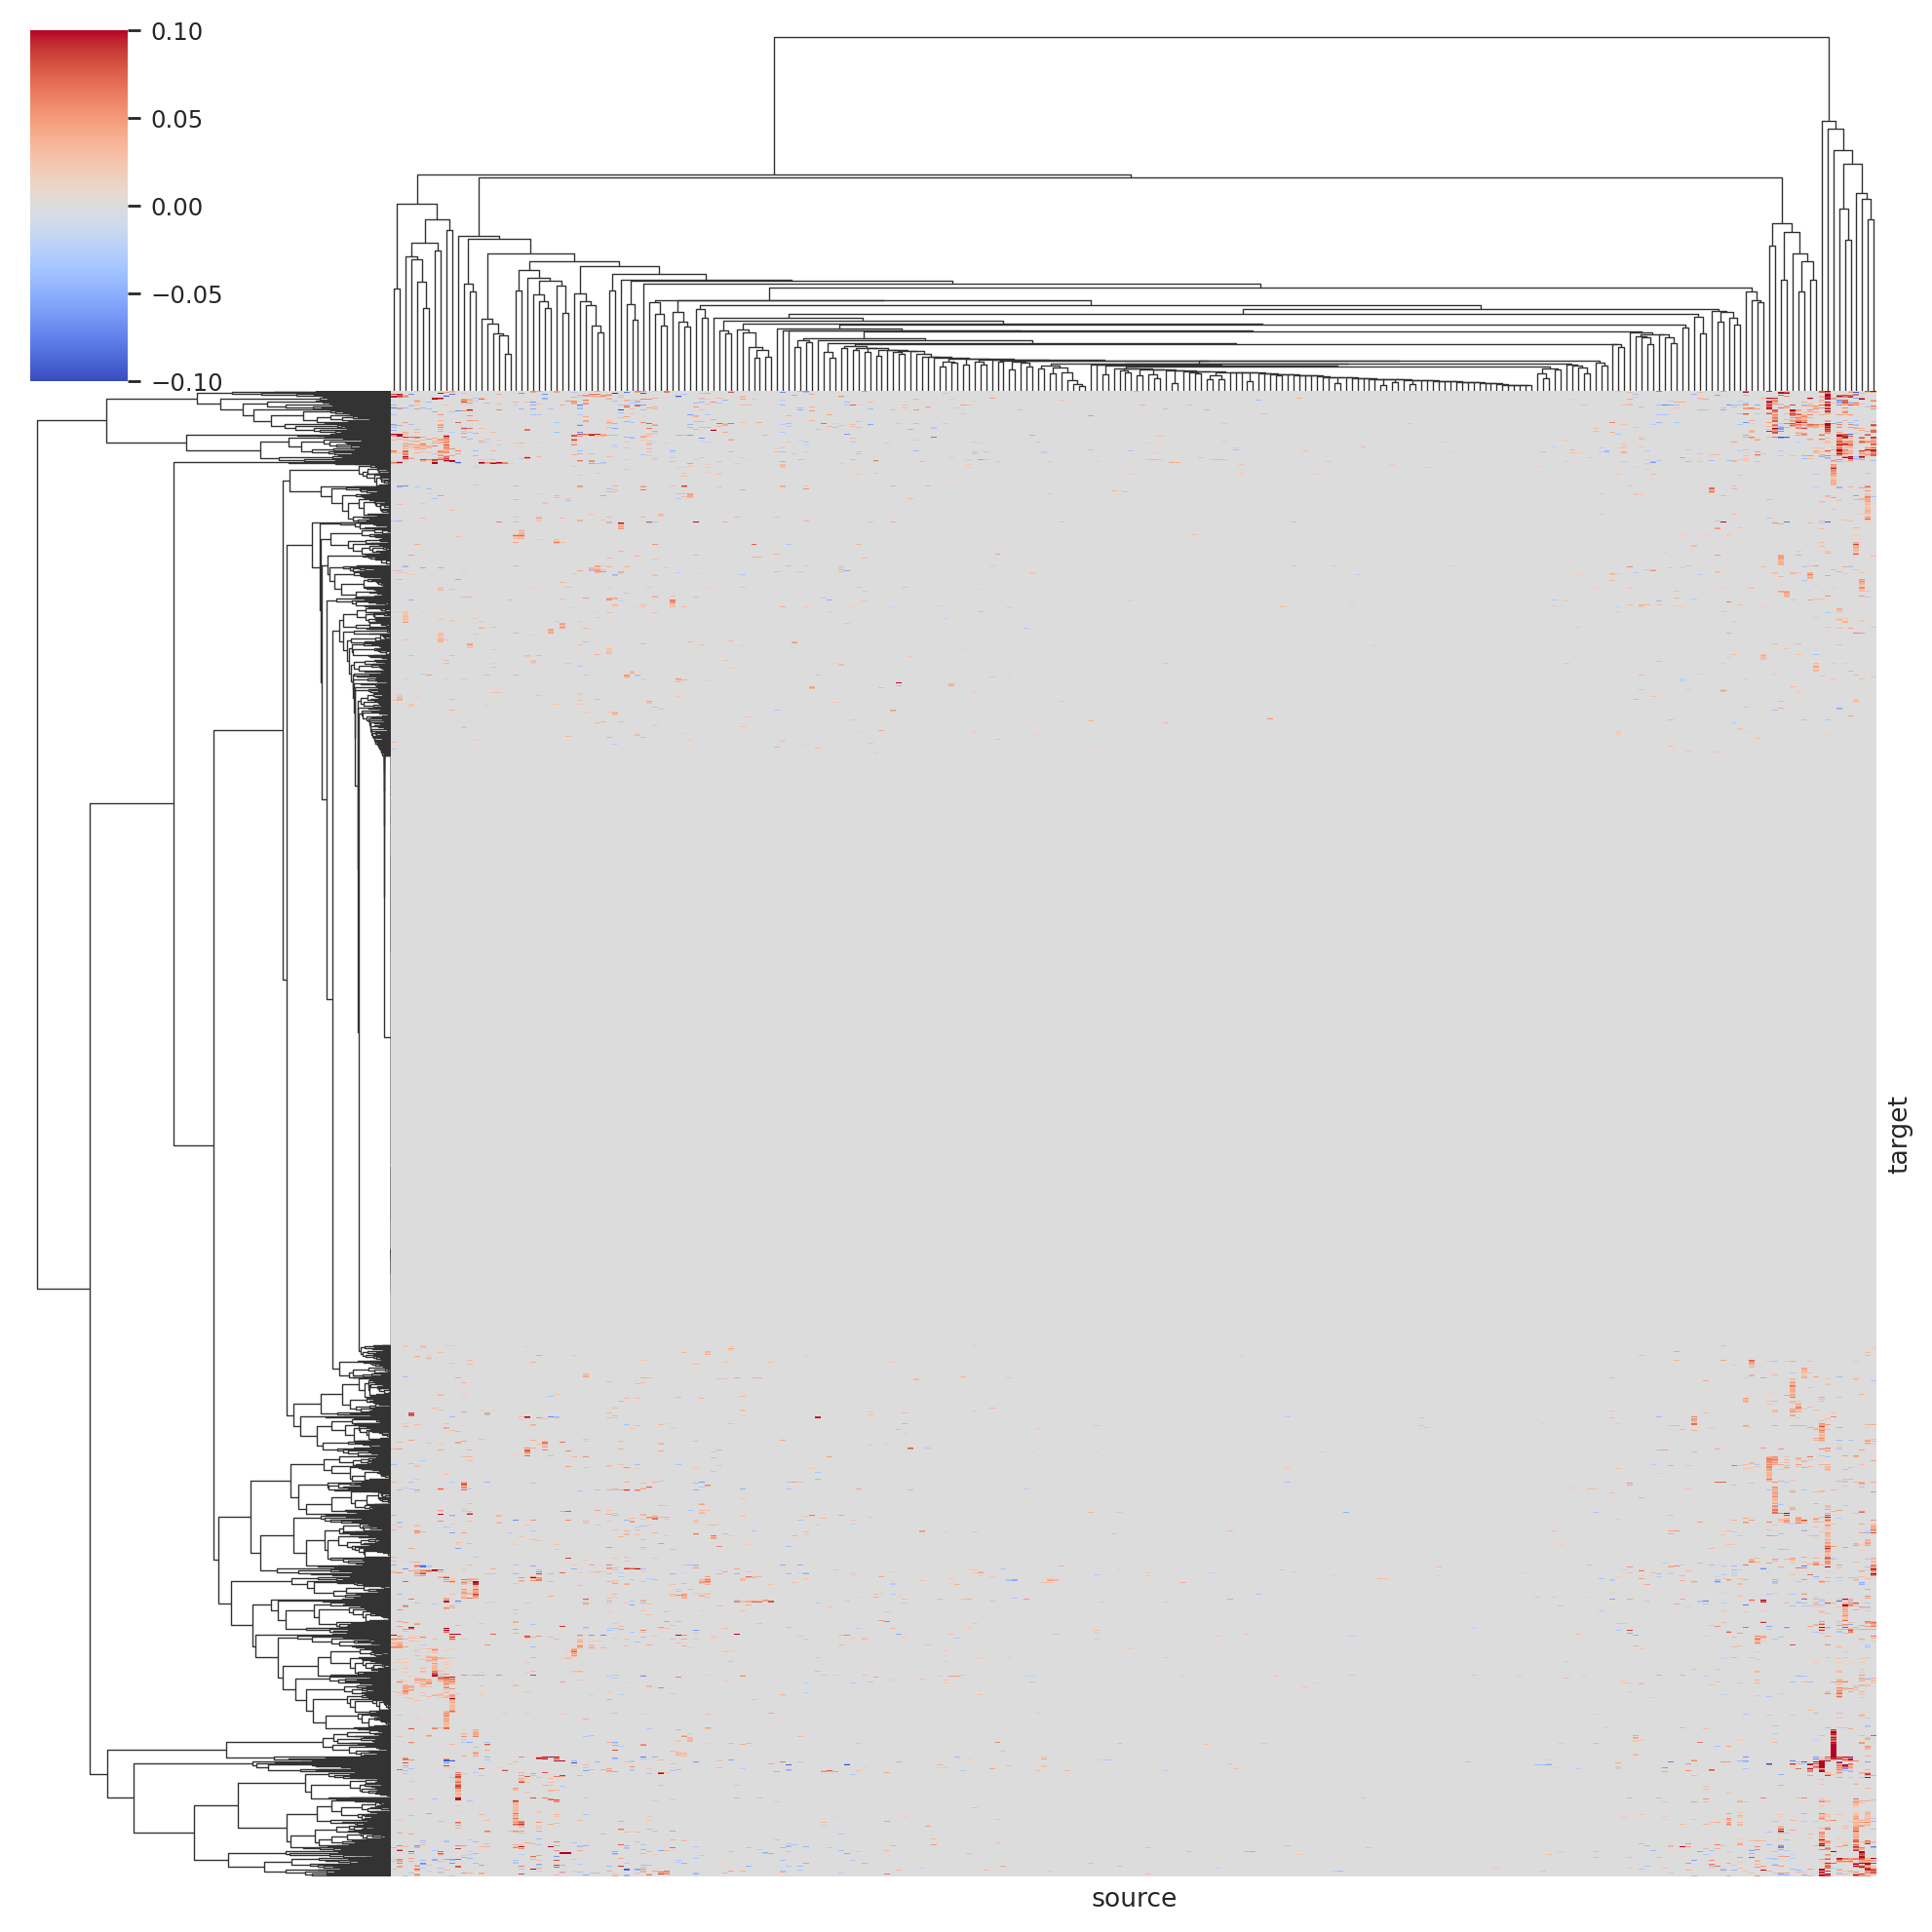

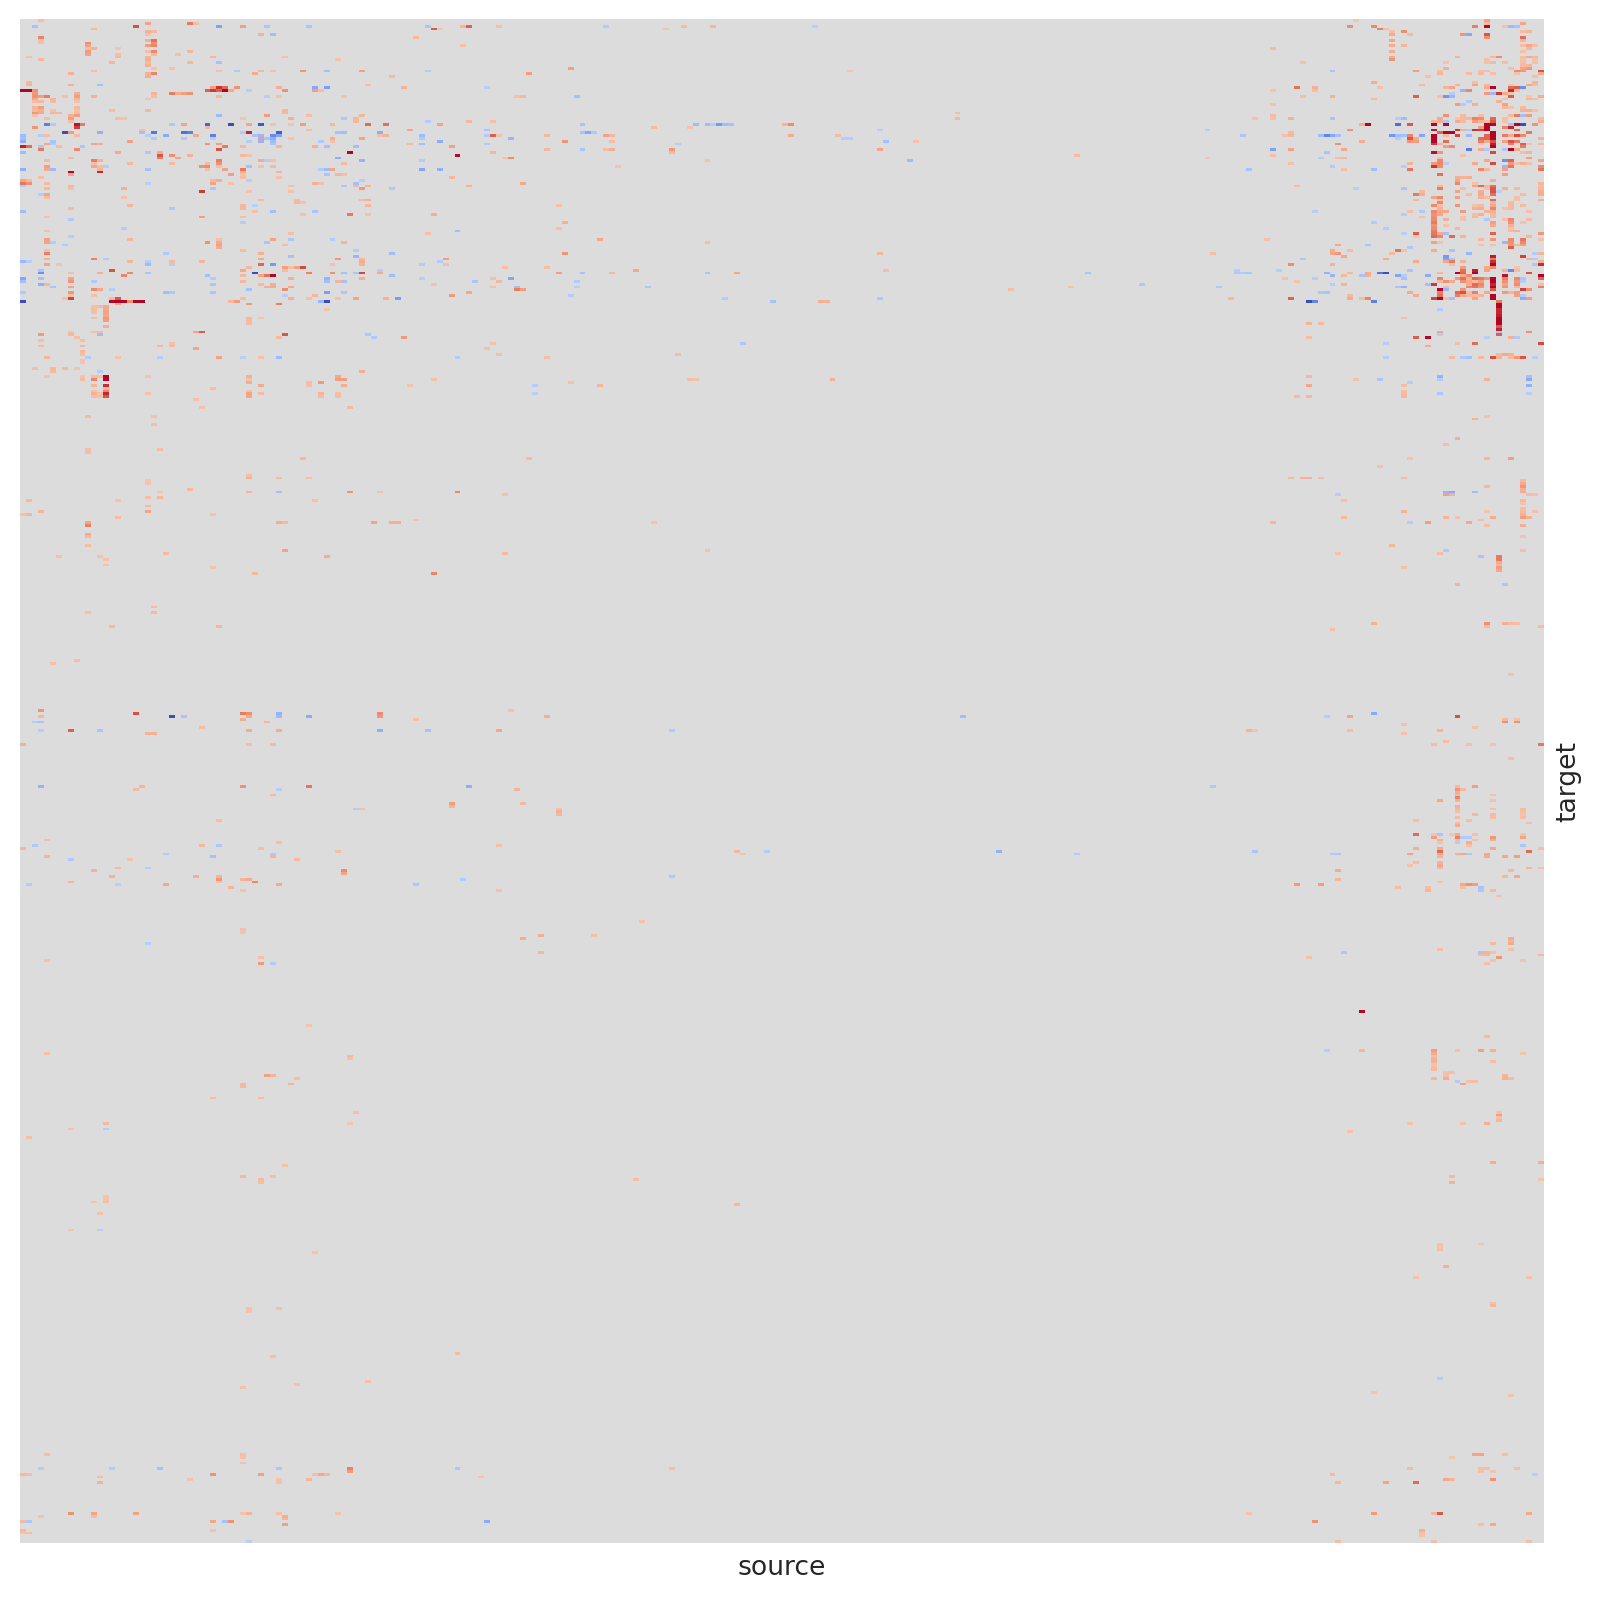

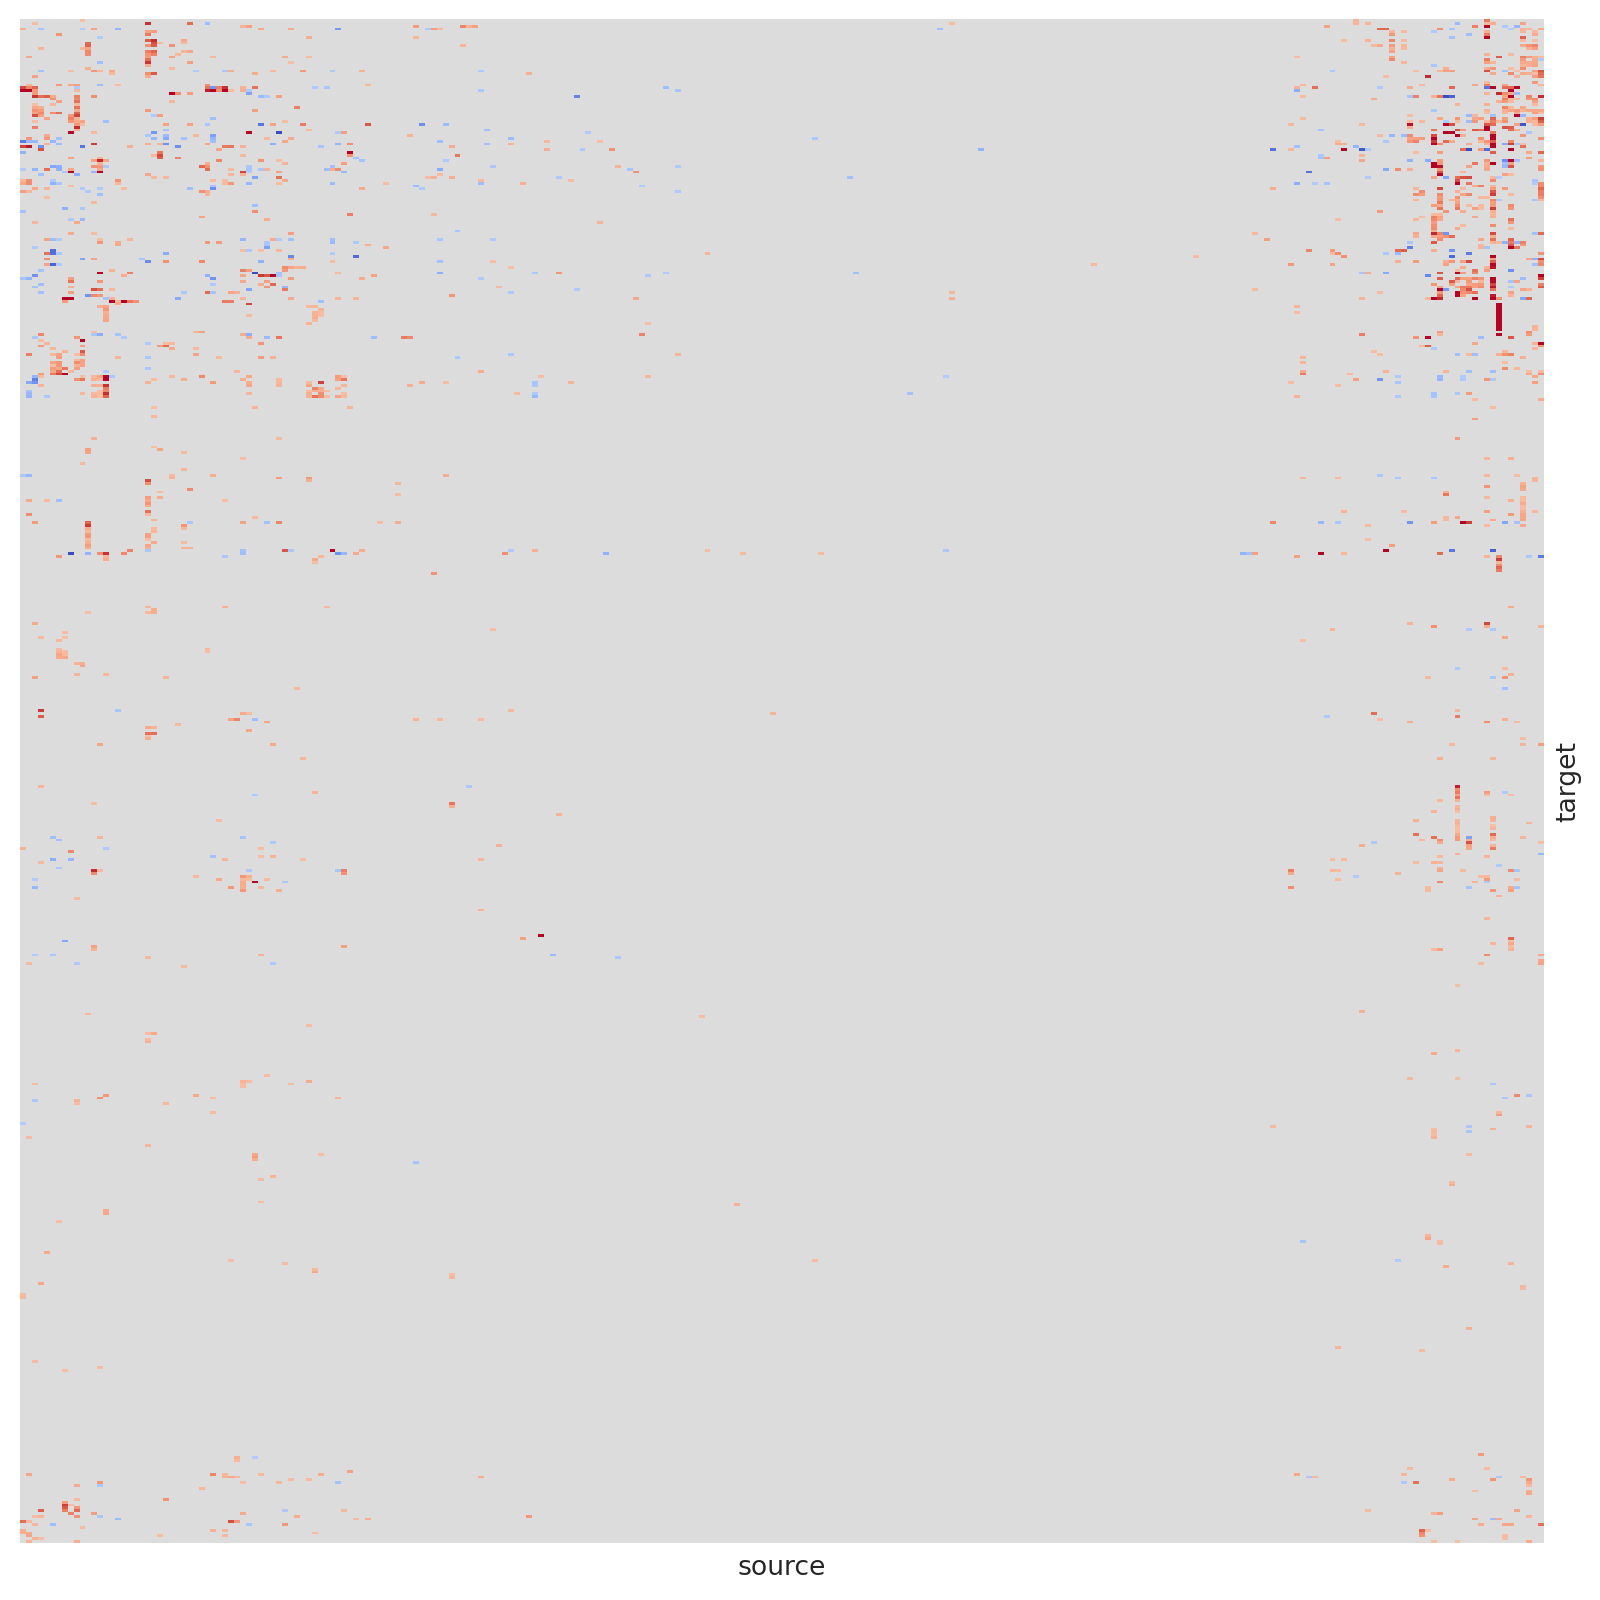

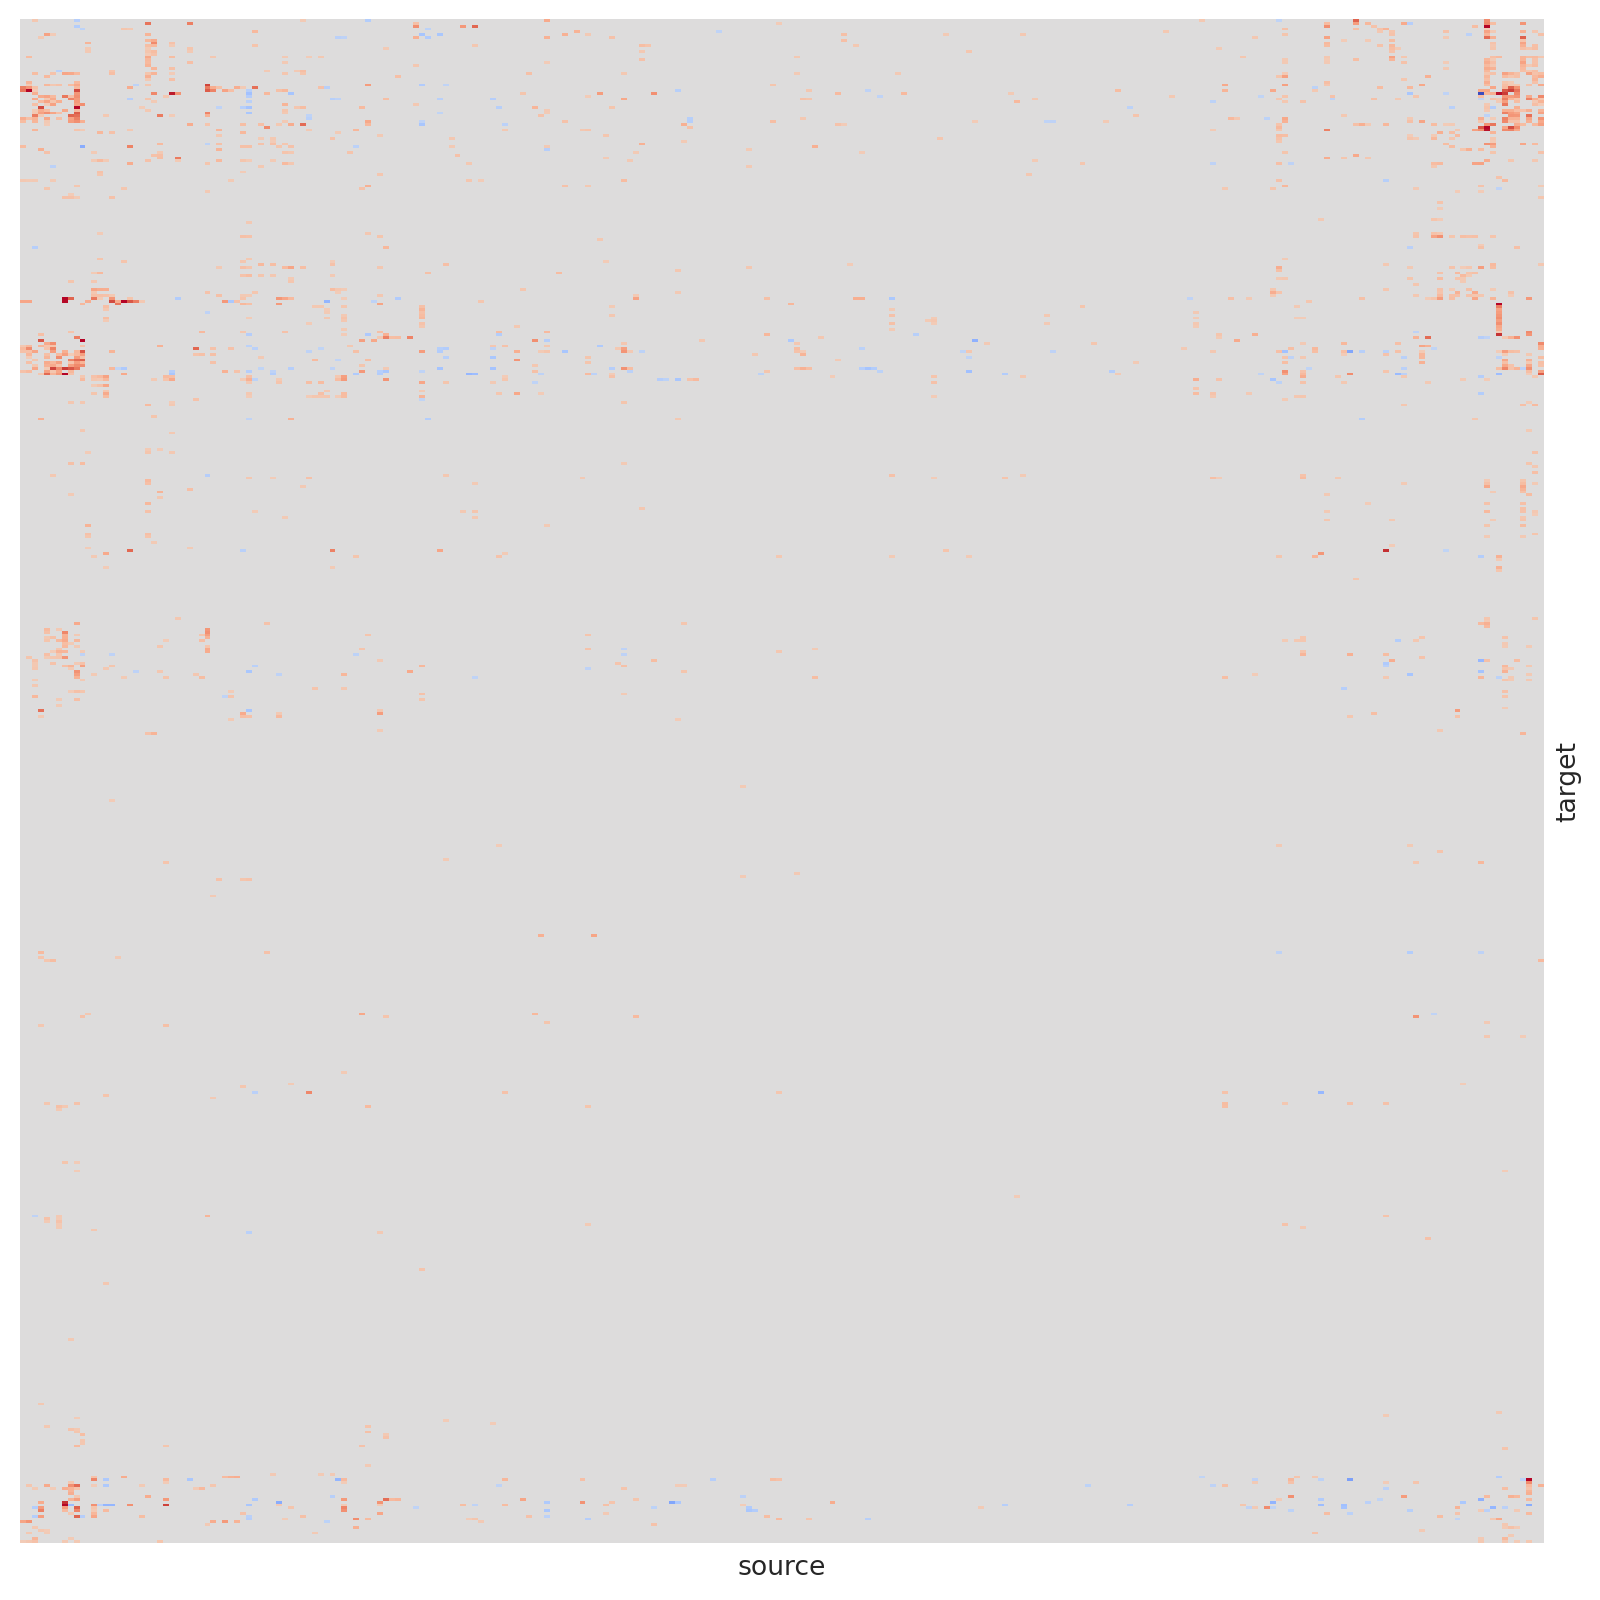

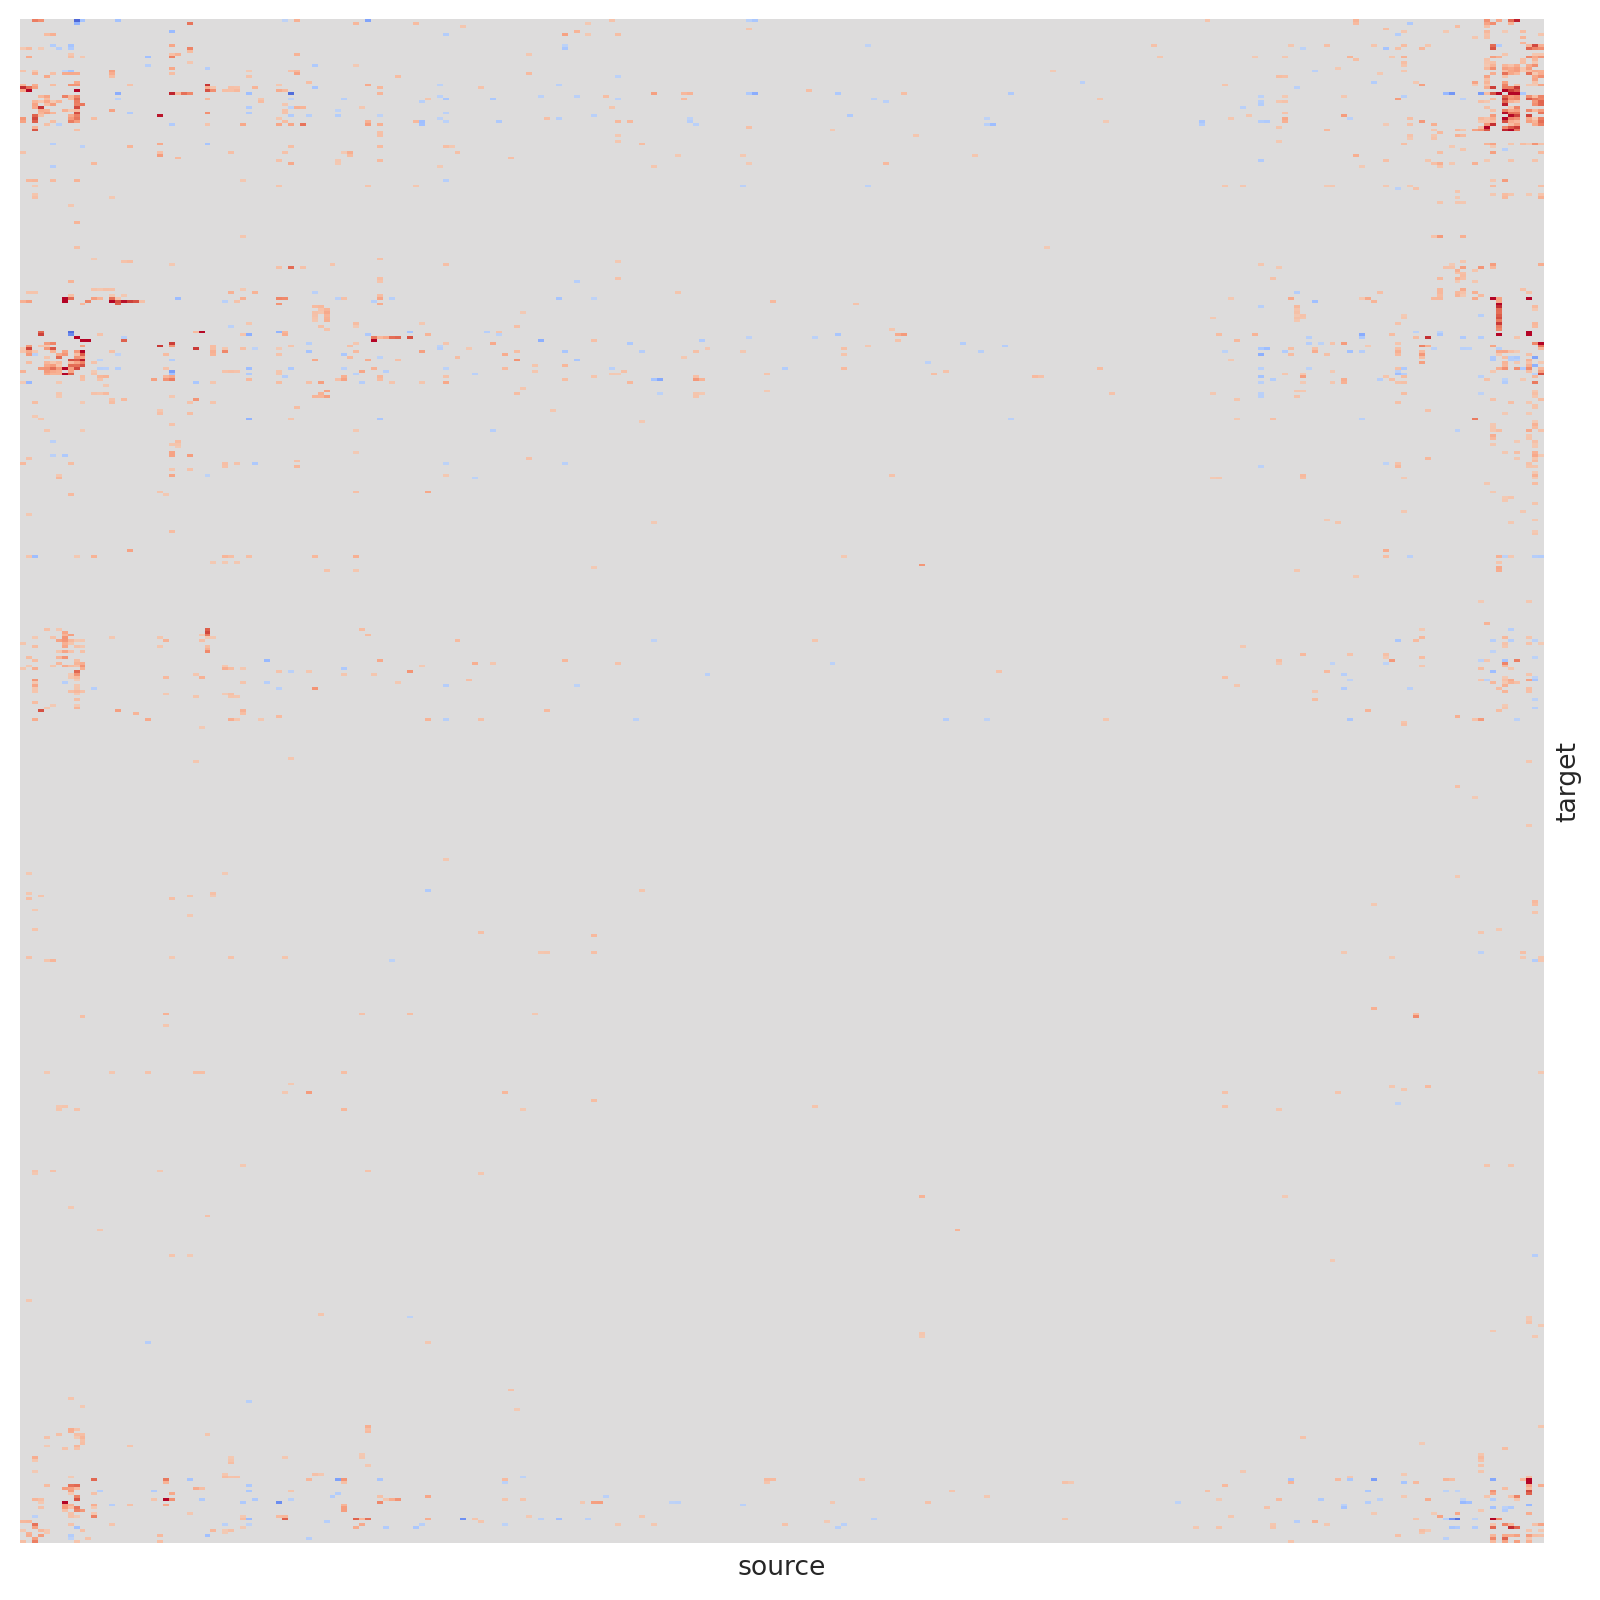

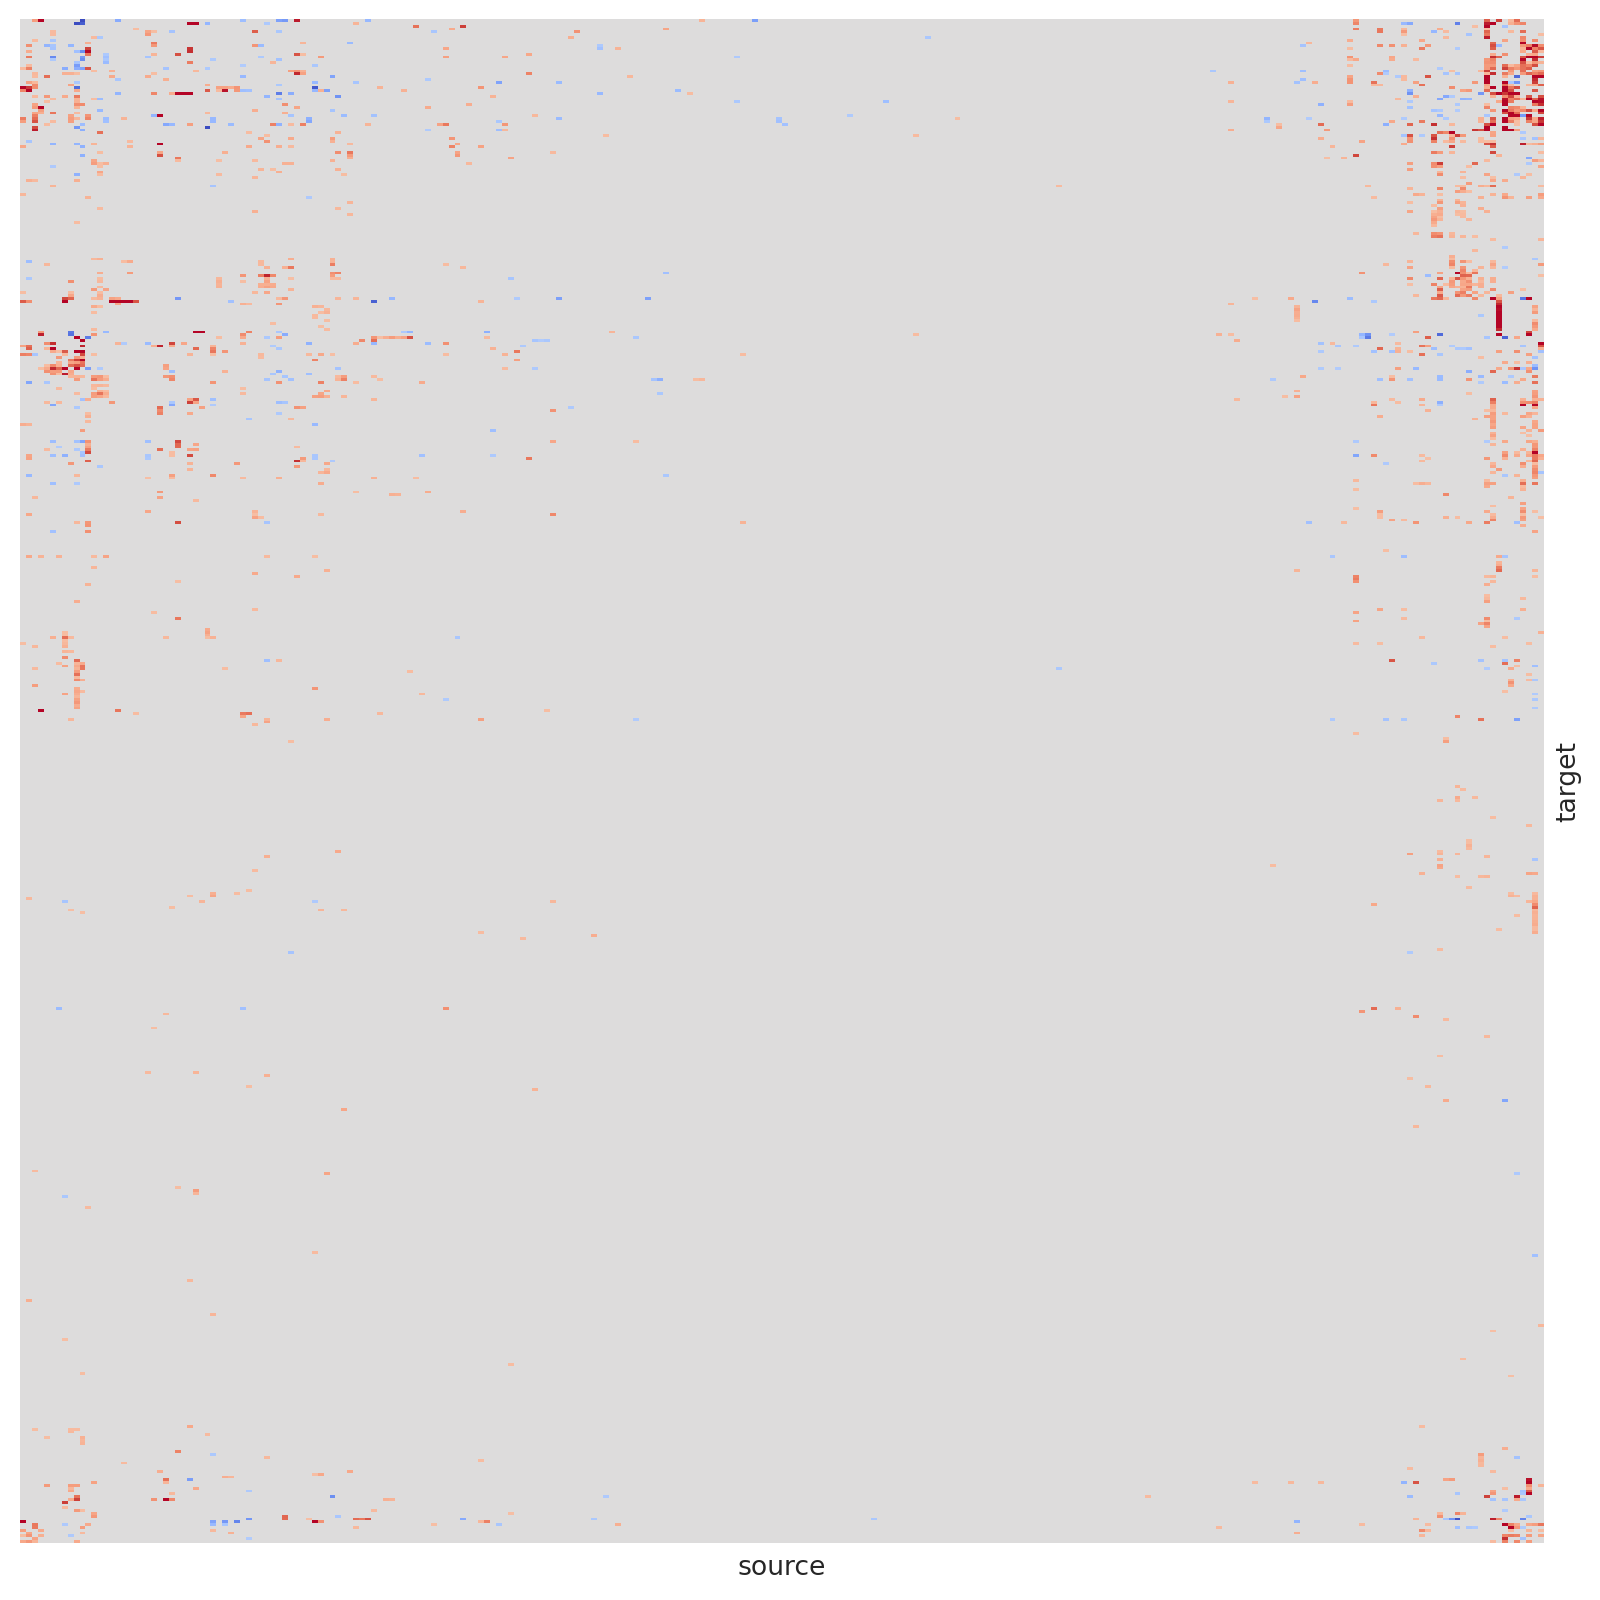

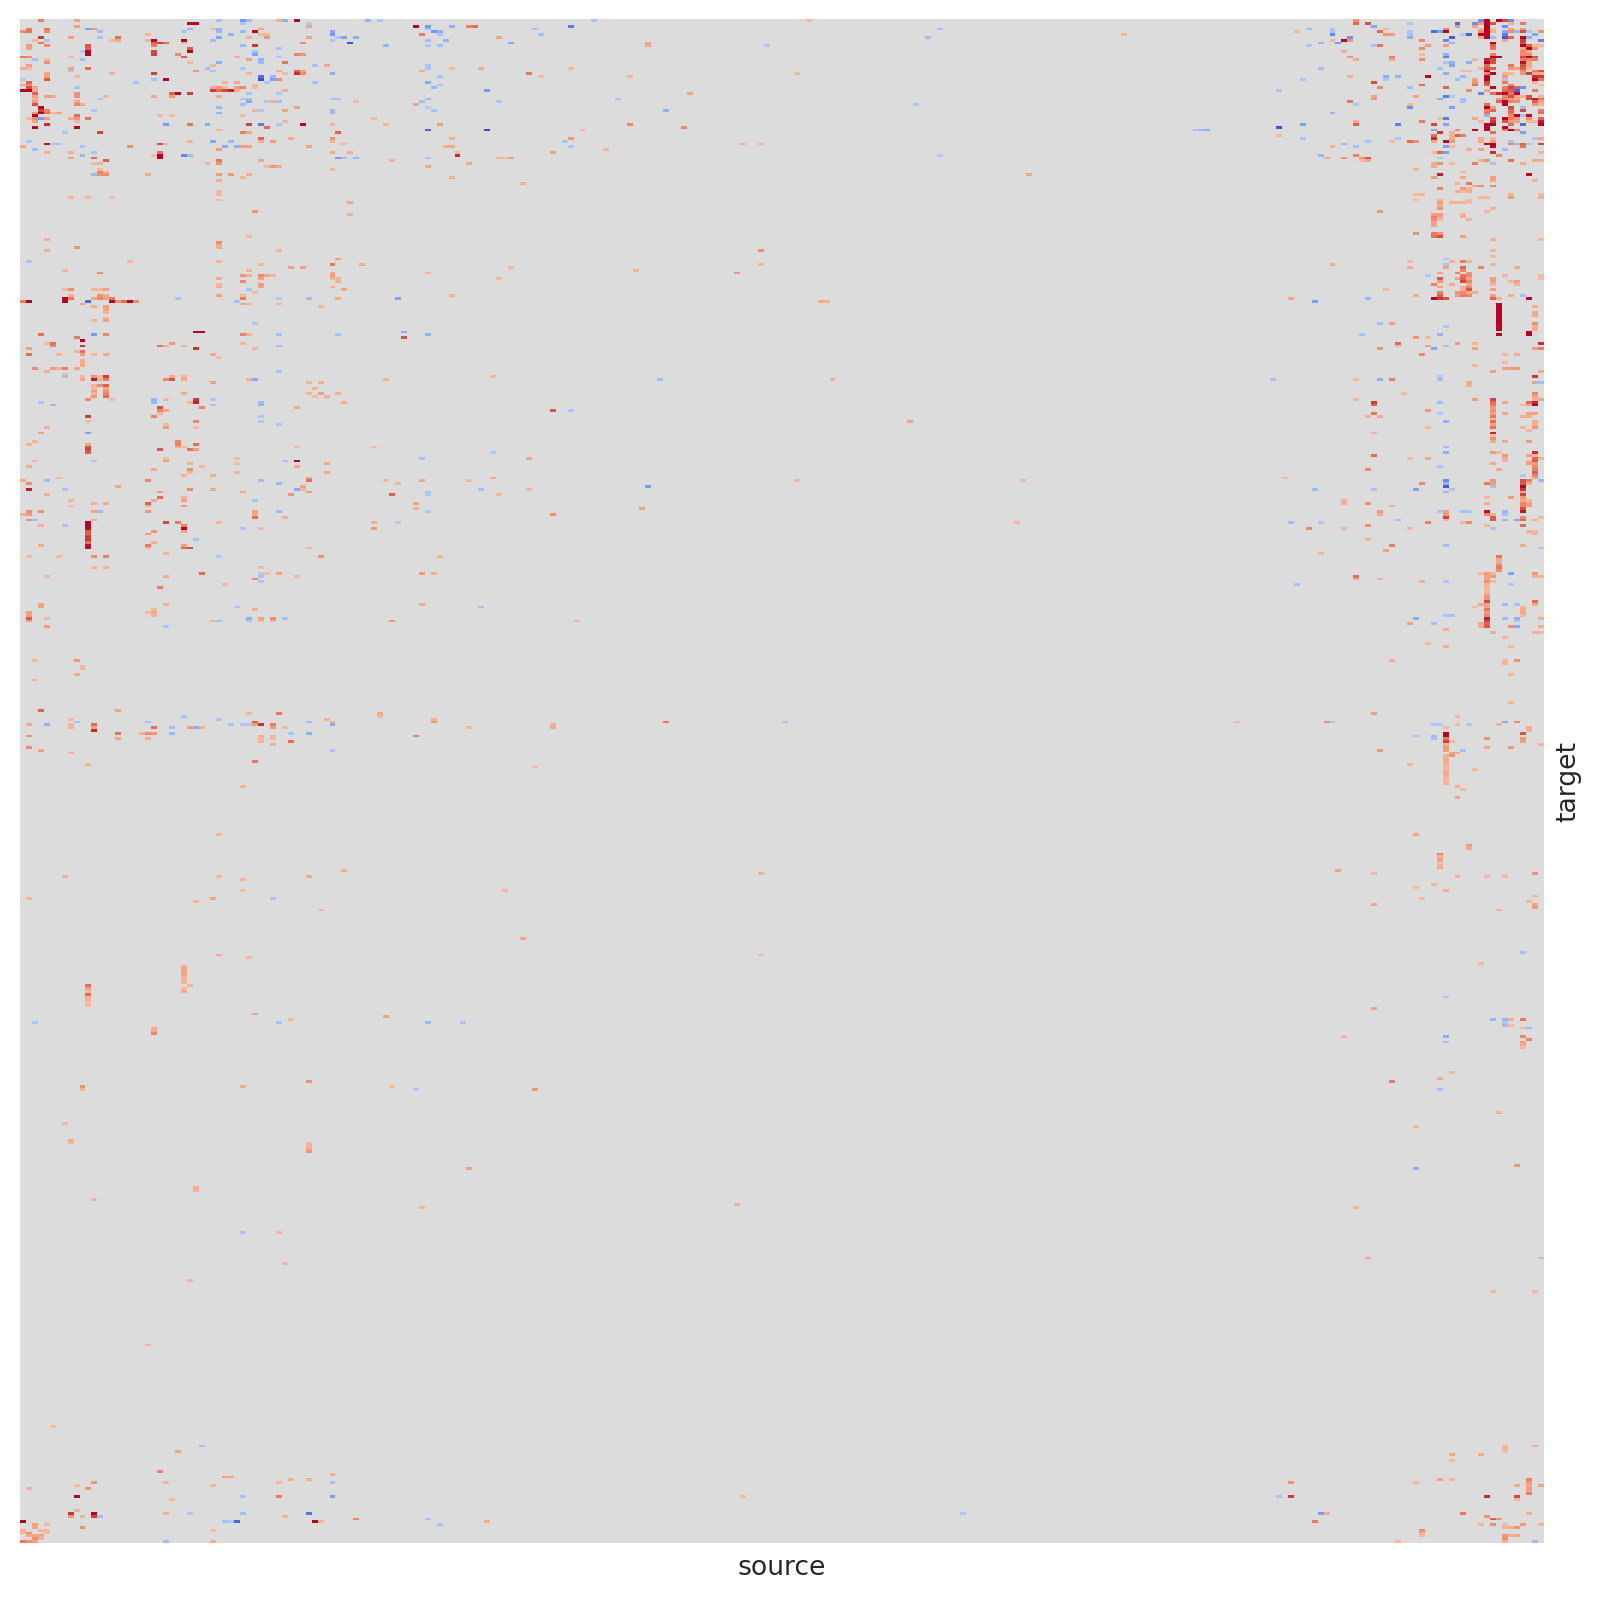

In [153]:
# For loop to plot the GRNs over celltypes (dev trajectories)
# Choose one timepoint and define the "stage"
timepoint = "TDR118"
# define the dev stage
stage = "15somites"
# timepoints = ["TDR126", "TDR127", "TDR128", "TDR118reseq", "TDR125reseq", "TDR124reseq"]

# for all the rest of the timepoints (0-30 somites)
# mesoderm_lineages = ["neural_posterior", "spinal_cord",
#                      "NMPs","tail_bud","PSM","somites","fast_muscle"]
NMP_lineages = ["neural_posterior", "spinal_cord",
                     "NMPs","tail_bud","PSM","somites"]

# Step 1. collect all sources and targets across all celltypes
all_sources = set()
all_targets = set()

for celltype in NMP_lineages:
    df = dict_filtered_GRNs[timepoint][celltype]
    all_sources.update(df['source'].unique())
    all_targets.update(df['target'].unique())
    
# Step 2: Recreate each df_counts DataFrame
df_counts_union_NMP_lin = {}

for celltype in NMP_lineages:
    df = dict_filtered_GRNs[timepoint][celltype]
    # Pivot the original DataFrame
    df_pivot = df.pivot(index='target', columns='source', values='coef_mean').reindex(index=all_targets, columns=all_sources).fillna(0)
    df_counts_union_NMP_lin[celltype] = df_pivot
    
# list of all celltypes
list_celltypes = list(df_counts_union_NMP_lin.keys())

# based on the histogram above, we'll define the vmax/vmin for color scale
vmax = 0.1
vmin = -0.1

# compute the linkages from the first and the last timepoints, by augmenting the "time" components
df_counts1 = df_counts_union_NMP_lin["neural_posterior"]
df_counts2 = df_counts_union_NMP_lin["spinal_cord"]
df_counts3 = df_counts_union_NMP_lin["NMPs"]
df_counts4 = df_counts_union_NMP_lin["tail_bud"]
df_counts5 = df_counts_union_NMP_lin["PSM"]
df_counts6 = df_counts_union_NMP_lin["somites"]

# concatenate over the columns
df_counts_rows = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=1)

# concatenate over the rows
df_counts_cols = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=0)

# create a clustered heatmap for the "rows"
g1 = sns.clustermap(df_counts_rows, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# create a clustered heatmap for the "cols"
g2 = sns.clustermap(df_counts_cols, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# extract the row/col indices
row_linkage = g1.dendrogram_row.linkage
col_linkage = g2.dendrogram_col.linkage

# Loop over all timepoints (using the pre-computed linkages from the first timepoint)
for idx, celltype in enumerate(NMP_lineages):

    df_counts = df_counts_union_NMP_lin[celltype]
    
    # plot the clustermap
    g = sns.clustermap(df_counts, method='ward', metric='euclidean', 
                       cmap='coolwarm', standard_scale=None, 
                       row_cluster=True, col_cluster=True, 
                       xticklabels=False, yticklabels=False, 
                       vmax=vmax, vmin=vmin, 
                       row_linkage=row_linkage, col_linkage=col_linkage)
    
    # hide the dendrograms
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    # hide the colorbar
    g.cax.set_visible(False)
    
    # save the plot
    g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_NMPtraj.pdf") # celltype is defined above where we computed df_counts_union
    g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_NMPtraj.png")
# # Since sns.clustermap uses its own figure by default, we adjust our approach slightly:
# plt.close(g1.fig)  # Close the first plot's figure to prevent it from showing twice

# # Display all heatmaps side by side with consistent clustering
plt.show()

### sectioning out the sub-GRN (up-regulated along the lineages)

- neuronal trajectory
- mesoderm trajectory

In [168]:
df_counts = df_counts_union_NMP_lin["neural_posterior"]

# Assuming you have determined your cluster size and its position (last N rows and M columns)
# N = 1  # The number of rows in the cluster, replace with the actual number
# M = 14  # The number of columns in the cluster, replace with the actual number

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g1.dendrogram_row.reordered_ind[22:50]
col_indices = g2.dendrogram_col.reordered_ind[-19:-9]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source         rfx4     sox13     meis3    meis2a     foxp4     pax6a  \
target                                                                  
fbn2b      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
fndc3ba    0.000000  0.000000  0.000000  0.000000  0.037612  0.000000   
hoxb3a     0.000000  0.000000  0.036465  0.045133  0.000000  0.000000   
hoxc3a     0.000000  0.000000  0.000000  0.000000  0.000000 -0.046452   
apoc1      0.000000  0.000000  0.000000 -0.028612  0.000000  0.000000   
mllt3      0.000000  0.028969 -0.065279 -0.043795  0.000000  0.000000   
fn1b       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
serpinh1b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
sox5       0.000000  0.000000  0.000000  0.000000  0.048869 -0.029249   
prickle1b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
arid3c     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
il17rd     0.000000  0.000000  0.000000  0.000000  

In [169]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union_NMP_lin["neural_posterior"]

df_counts_neuronal_upreg = df_counts.loc[row_names, col_names]
df_counts_neuronal_upreg

source         rfx4     sox13     meis3    meis2a     foxp4     pax6a  \
target                                                                  
fbn2b      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
fndc3ba    0.000000  0.000000  0.000000  0.000000  0.037612  0.000000   
hoxb3a     0.000000  0.000000  0.036465  0.045133  0.000000  0.000000   
hoxc3a     0.000000  0.000000  0.000000  0.000000  0.000000 -0.046452   
apoc1      0.000000  0.000000  0.000000 -0.028612  0.000000  0.000000   
mllt3      0.000000  0.028969 -0.065279 -0.043795  0.000000  0.000000   
fn1b       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
serpinh1b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
sox5       0.000000  0.000000  0.000000  0.000000  0.048869 -0.029249   
prickle1b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
arid3c     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
il17rd     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
rxraa      0.000000  0.000000  0.054306  0.000000  0.000000  0.032692   
robo1      0.000000  0.042658  0.000000  0.000000  0.026292  0.031746   
trps1      0.036259  0.039429 -0.034050  0.000000  0.042008  0.033101   
tenm4      0.106991  0.000000  0.126891  0.000000  0.000000  0.000000   
sipa1l2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
agrn       0.096438  0.000000  0.000000  0.000000  0.089629  0.039556   
chl1a      0.000000  0.072306  0.115442  0.134624  0.000000  0.000000   
cntfr      0.174123  0.000000  0.032607  0.000000  0.085132  0.000000   
epha4b     0.155292  0.000000  0.000000  0.000000  0.000000  0.000000   
ntn1a      0.105869  0.000000  0.070458  0.000000  0.000000  0.000000   
greb1l     0.087879  0.037944  0.000000  0.000000  0.000000  0.000000   
notch1b    0.000000  0.000000  0.048977  0.057492  0.000000  0.000000   
cdh11      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ptprfb     0.097647  0.050816  0.000000  0.000000  0.000000  0.000000   
pleca      0.000000  0.000000  0.000000  0.000000  0.000000  0.027274   
meis1a     0.000000  0.028775  0.000000  0.000000  0.000000  0.000000   

source        pax6b    foxp1b     thrab     nr2f5  
target                                             
fbn2b      0.000000  0.030111  0.000000  0.000000  
fndc3ba    0.000000  0.044824  0.000000  0.034267  
hoxb3a     0.000000  0.000000  0.000000  0.042219  
hoxc3a     0.058354  0.000000  0.000000  0.000000  
apoc1      0.000000  0.000000  0.000000  0.049725  
mllt3      0.000000  0.000000  0.000000  0.000000  
fn1b       0.000000  0.000000  0.000000  0.000000  
serpinh1b -0.031147  0.000000  0.000000  0.000000  
sox5       0.000000  0.038702  0.000000  0.000000  
prickle1b  0.000000  0.000000  0.000000  0.000000  
arid3c     0.000000  0.000000  0.000000  0.000000  
il17rd     0.000000  0.000000  0.000000  0.000000  
rxraa      0.000000  0.000000  0.030493  0.000000  
robo1      0.034683  0.060268  0.056529  0.000000  
trps1      0.000000  0.048450  0.036208  0.031247  
tenm4      0.000000  0.000000  0.000000  0.114490  
sipa1l2    0.000000  0.000000  0.049071  0.162833  
agrn      -0.033489  0.089321  0.086175  0.107000  
chl1a      0.000000  0.000000  0.000000  0.000000  
cntfr     -0.043325  0.000000  0.000000  0.073268  
epha4b     0.000000  0.000000  0.071121  0.073496  
ntn1a      0.000000  0.000000  0.061842  0.041660  
greb1l     0.000000  0.000000  0.027430  0.000000  
notch1b    0.000000  0.000000  0.000000  0.000000  
cdh11     -0.078072  0.000000  0.040842 -0.029356  
ptprfb     0.000000  0.000000  0.000000  0.000000  
pleca      0.000000  0.000000  0.000000  0.000000  
meis1a     0.000000  0.000000  0.000000  0.000000

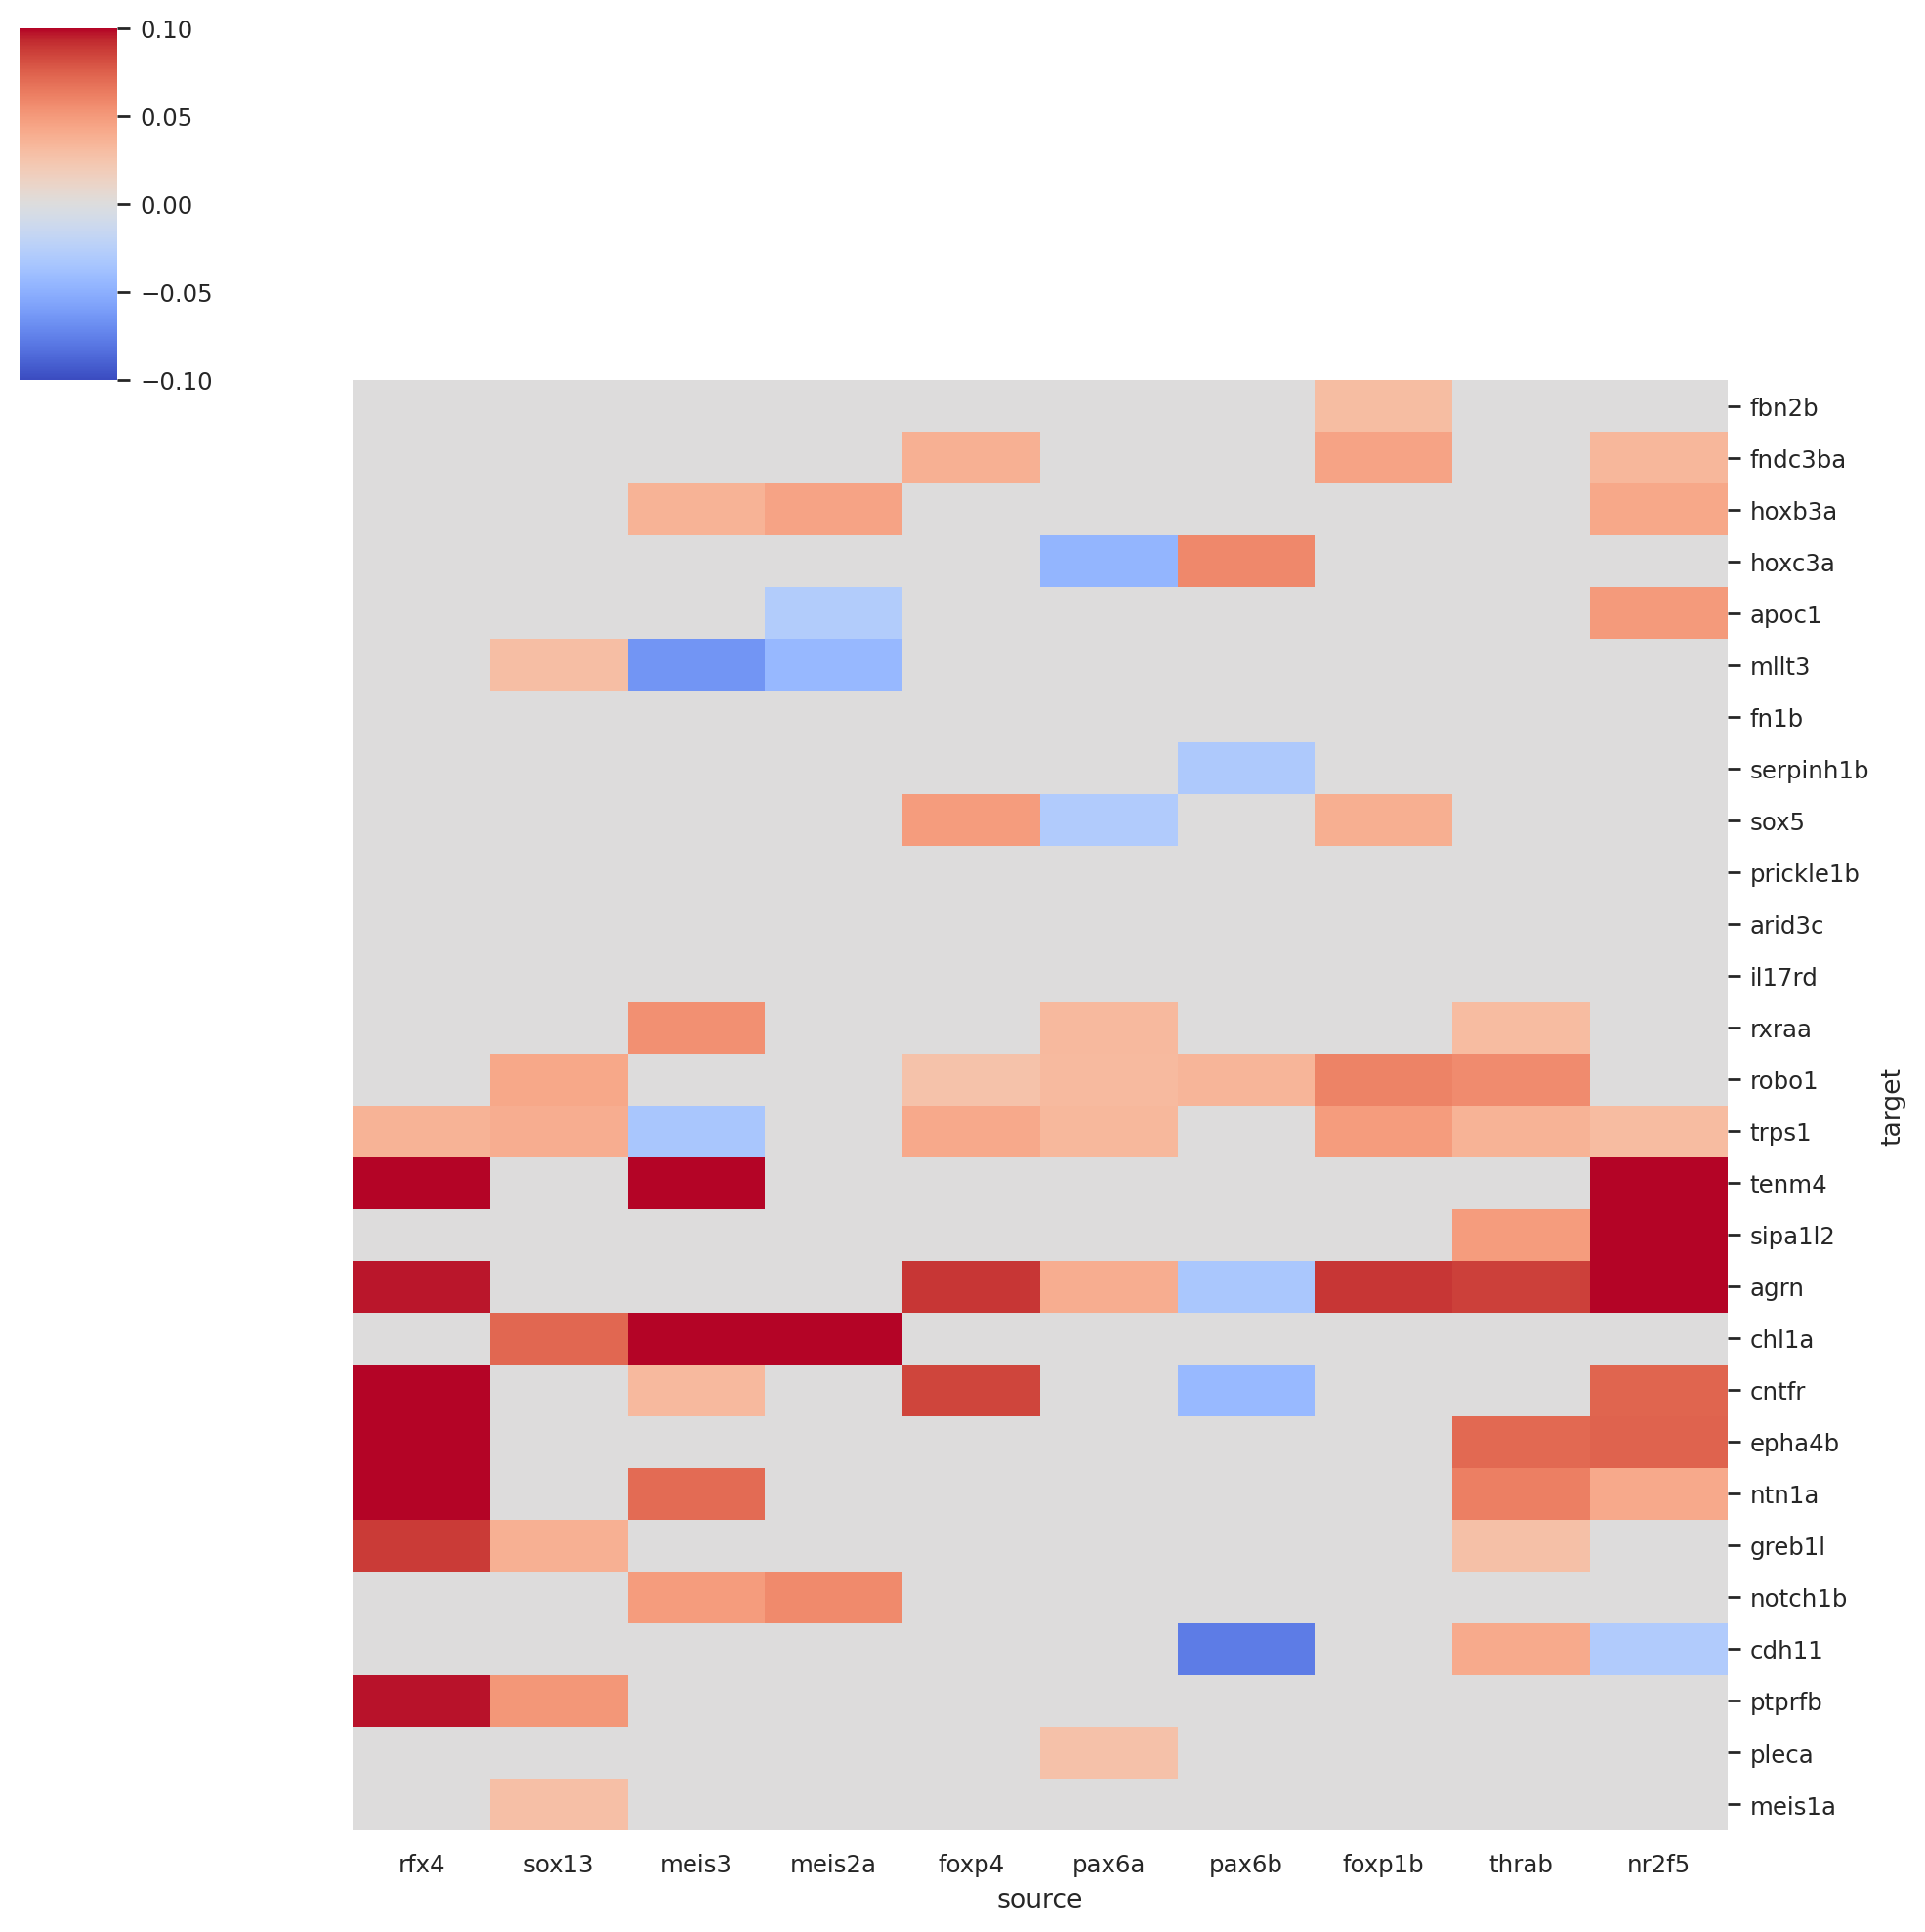

In [170]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_neuronal_upreg, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "neuronal"
stage = "15somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg.png")

plt.show()

### mesodermal cells

In [174]:
# Assuming you have determined your cluster size and its position (last N rows and M columns)
# N = 1  # The number of rows in the cluster, replace with the actual number
# M = 14  # The number of columns in the cluster, replace with the actual number

df_counts = df_counts_union_NMP_lin["somites"]

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g1.dendrogram_row.reordered_ind[0:22]
col_indices = g2.dendrogram_col.reordered_ind[-11:-1]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source         thrab     nr2f5    meis1b    hmga1a     rxraa     rarab  \
target                                                                   
meox1      -0.068702  0.138284  0.000000  0.149807  0.082596 -0.068287   
efemp2b     0.051192  0.173171  0.078684  0.000000  0.000000  0.038040   
kirrel3l    0.000000  0.235416  0.000000  0.000000 -0.068152  0.000000   
pax3a       0.037437  0.128051  0.034542  0.000000  0.000000  0.048039   
itga9       0.055087  0.132417  0.037398  0.000000 -0.053384  0.056490   
zgc:158328  0.107608  0.213657  0.000000  0.000000 -0.075923  0.000000   
eya1        0.039434  0.265876 -0.040926  0.000000 -0.092842  0.070733   
mef2d       0.000000  0.000000  0.000000  0.000000  0.044509  0.000000   
efemp2a     0.000000  0.000000  0.116282  0.000000  0.000000  0.000000   
fgfrl1a     0.000000  0.000000  0.072977  0.000000  0.000000  0.000000   
fstl1b      0.000000  0.000000  0.065441  0.000000  0.000000  0.000000   
rbm24a      0.000000  0.000000  0.0000

In [176]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union_NMP_lin["somites"]

df_counts_mesodermal_upreg = df_counts.loc[row_names, col_names]
df_counts_mesodermal_upreg

source         thrab     nr2f5    meis1b    hmga1a     rxraa     rarab  \
target                                                                   
meox1      -0.068702  0.138284  0.000000  0.149807  0.082596 -0.068287   
efemp2b     0.051192  0.173171  0.078684  0.000000  0.000000  0.038040   
kirrel3l    0.000000  0.235416  0.000000  0.000000 -0.068152  0.000000   
pax3a       0.037437  0.128051  0.034542  0.000000  0.000000  0.048039   
itga9       0.055087  0.132417  0.037398  0.000000 -0.053384  0.056490   
zgc:158328  0.107608  0.213657  0.000000  0.000000 -0.075923  0.000000   
eya1        0.039434  0.265876 -0.040926  0.000000 -0.092842  0.070733   
mef2d       0.000000  0.000000  0.000000  0.000000  0.044509  0.000000   
efemp2a     0.000000  0.000000  0.116282  0.000000  0.000000  0.000000   
fgfrl1a     0.000000  0.000000  0.072977  0.000000  0.000000  0.000000   
fstl1b      0.000000  0.000000  0.065441  0.000000  0.000000  0.000000   
rbm24a      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
enah        0.000000  0.000000  0.061473  0.000000  0.000000  0.000000   
qkia        0.000000  0.000000  0.119439  0.101842  0.000000  0.000000   
bmpr1ba     0.000000  0.093487  0.082709  0.000000  0.000000  0.000000   
tenm3       0.000000  0.123139  0.081815  0.000000  0.000000  0.000000   
lhfpl6      0.000000  0.070788  0.000000  0.000000  0.000000  0.065657   
gse1        0.035152  0.078341  0.075873  0.000000  0.000000  0.049680   
meis1b      0.000000  0.098191  0.000000  0.000000  0.000000  0.000000   
gli2a       0.000000  0.060101  0.102520  0.000000  0.036440  0.034781   
nrp2b       0.000000  0.123035  0.000000  0.000000  0.048578  0.000000   
ripply1     0.000000  0.118057  0.000000  0.000000 -0.032420  0.000000   

source         raraa    meis1a      sox5     meox1  
target                                              
meox1       0.000000  0.000000  0.000000  0.000000  
efemp2b     0.000000  0.063513  0.000000  0.000000  
kirrel3l    0.000000  0.000000  0.000000  0.000000  
pax3a       0.000000  0.051632  0.000000  0.000000  
itga9      -0.045754  0.081453 -0.034399  0.000000  
zgc:158328  0.000000  0.000000  0.000000 -0.056542  
eya1        0.000000  0.143224 -0.050768  0.000000  
mef2d       0.000000  0.088898  0.000000  0.000000  
efemp2a     0.000000  0.080688  0.000000  0.000000  
fgfrl1a     0.000000  0.103822  0.075033  0.035921  
fstl1b      0.000000  0.042117  0.106631  0.051743  
rbm24a      0.000000  0.057936  0.039104  0.000000  
enah        0.000000  0.057656  0.057617  0.000000  
qkia        0.000000  0.084164  0.143177  0.078599  
bmpr1ba     0.000000  0.065201  0.060102  0.061520  
tenm3       0.000000  0.097823  0.045819  0.000000  
lhfpl6      0.000000  0.080362  0.045579  0.000000  
gse1        0.047598  0.074626  0.033398  0.000000  
meis1b      0.000000  0.056300  0.000000  0.063273  
gli2a       0.000000  0.052479  0.085767  0.044108  
nrp2b       0.000000  0.000000  0.000000  0.090469  
ripply1     0.000000  0.000000  0.000000  0.170665

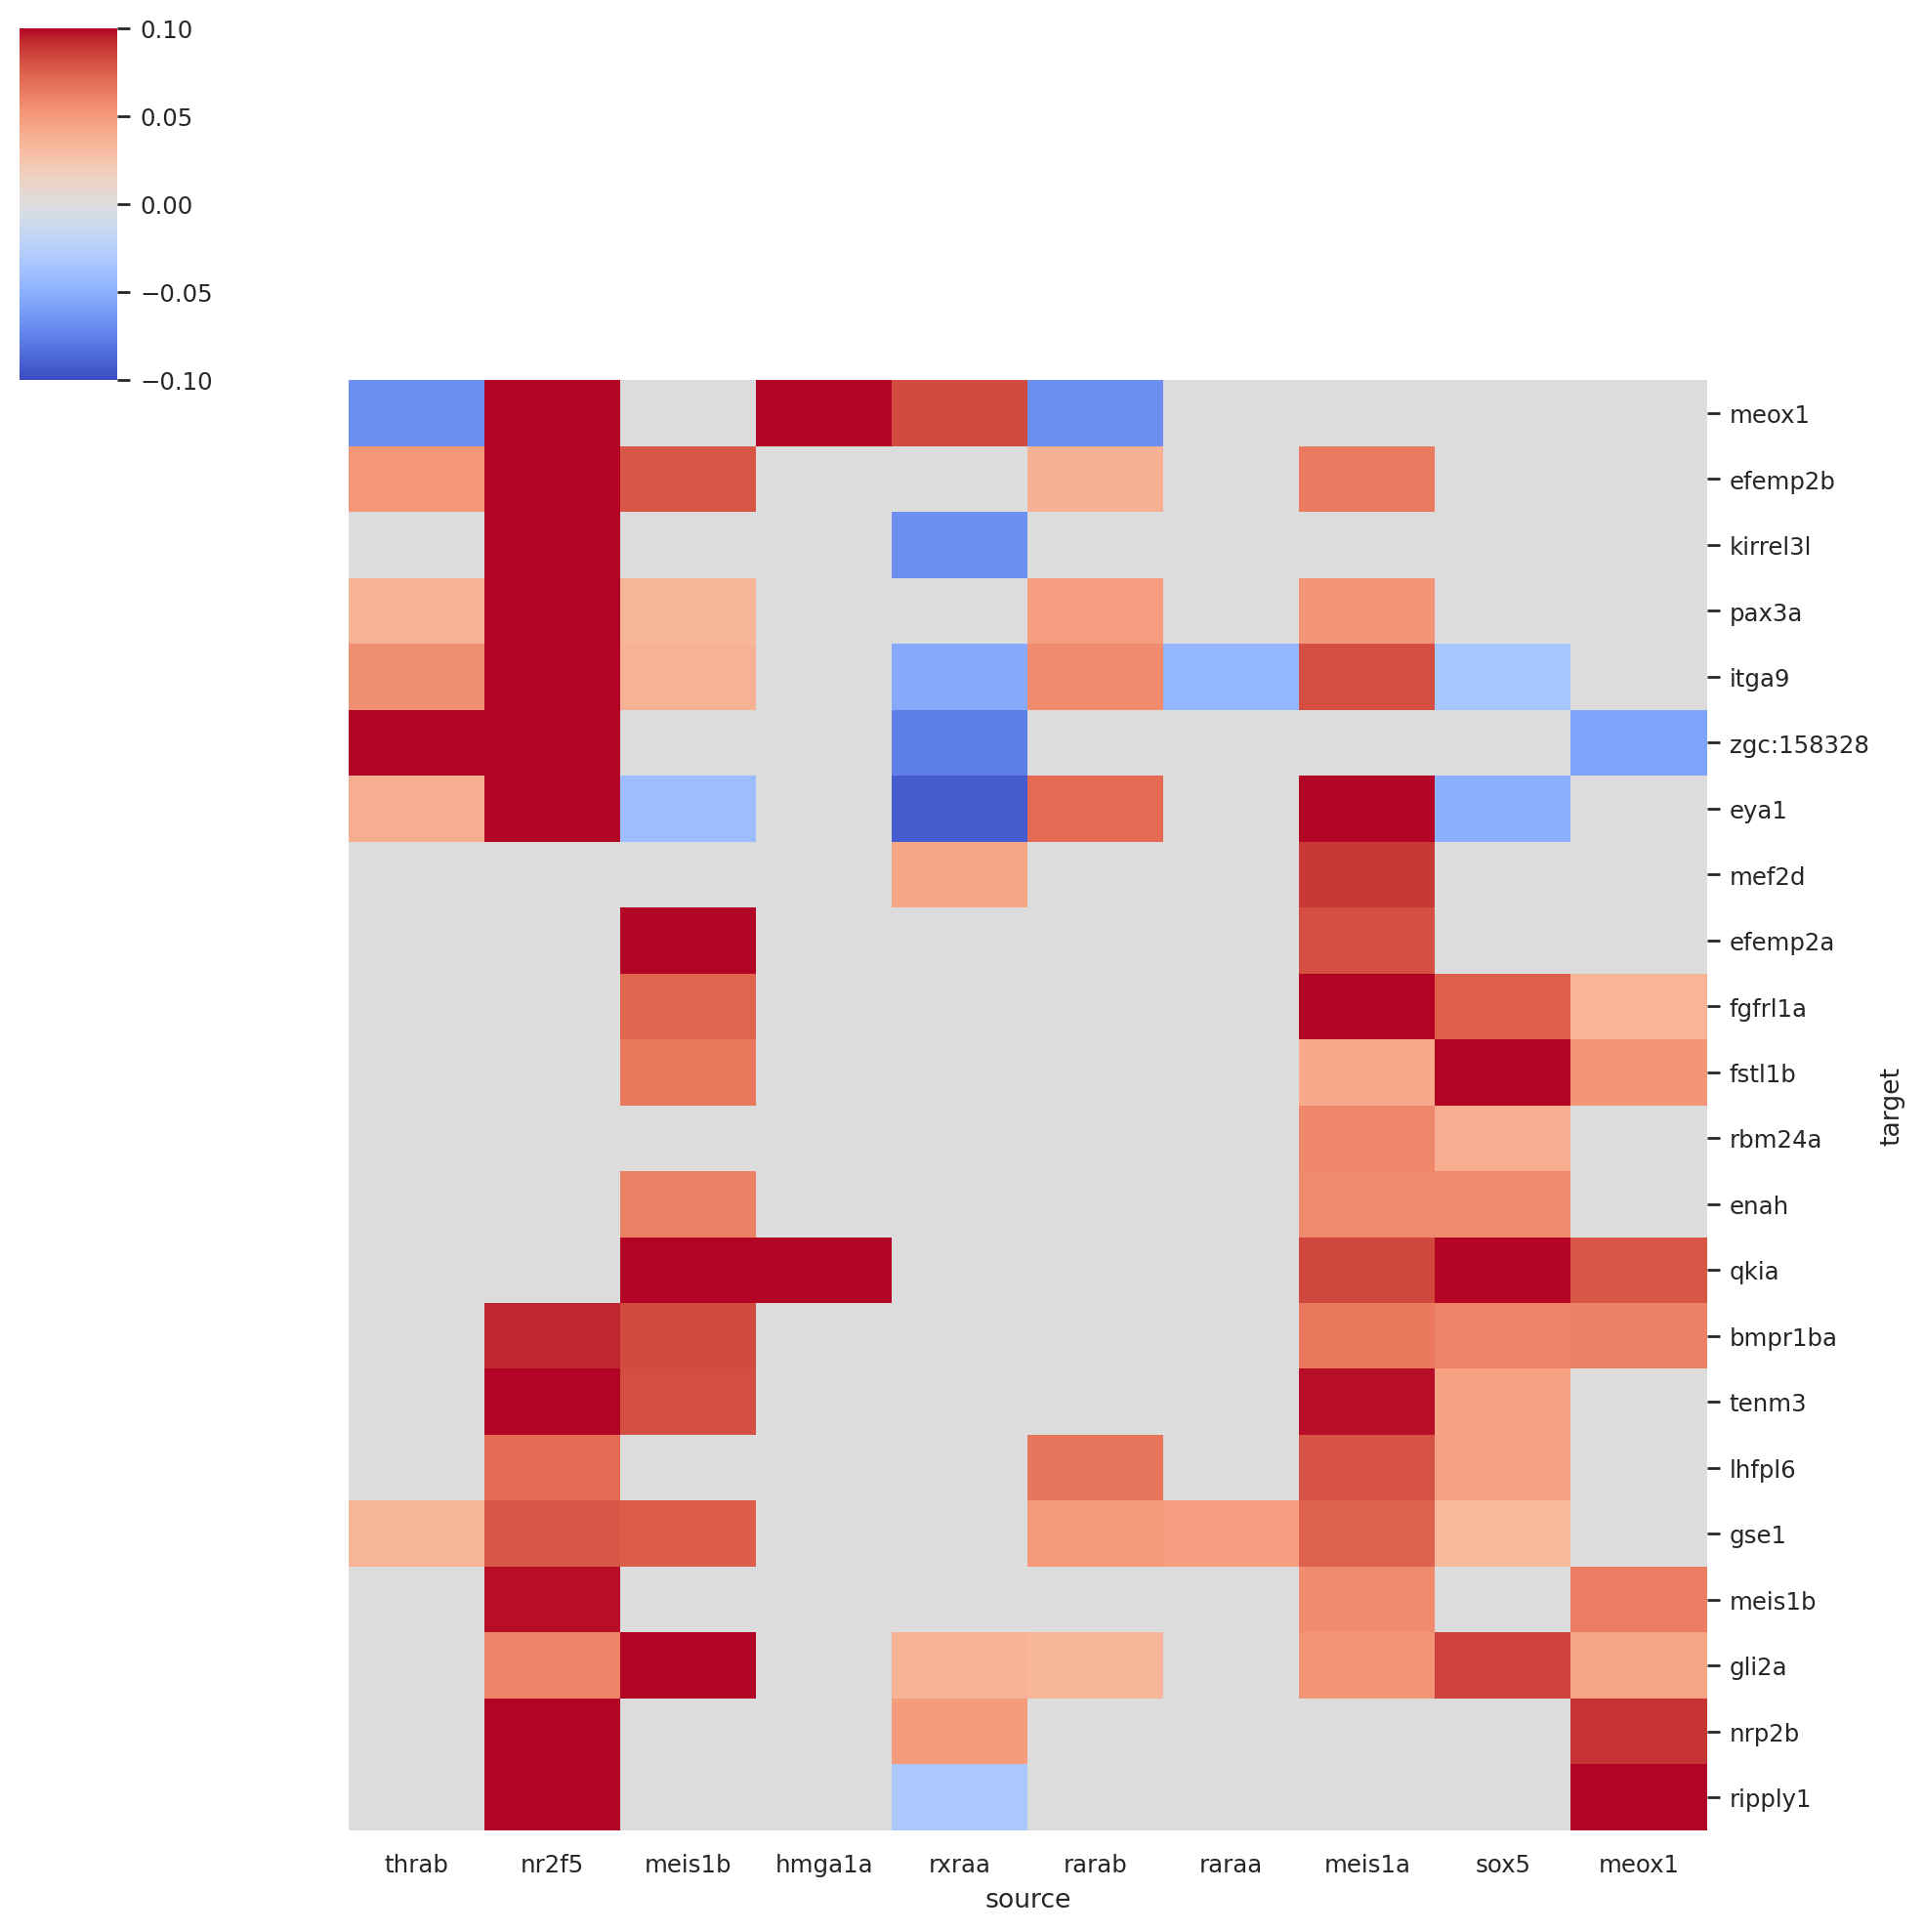

In [177]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_mesodermal_upreg, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "mesodermal"
stage = "15somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}_upreg.png")

plt.show()

## [SI] GRN evolution over celltypes (lineages) at 10hpf (the earliest stage)



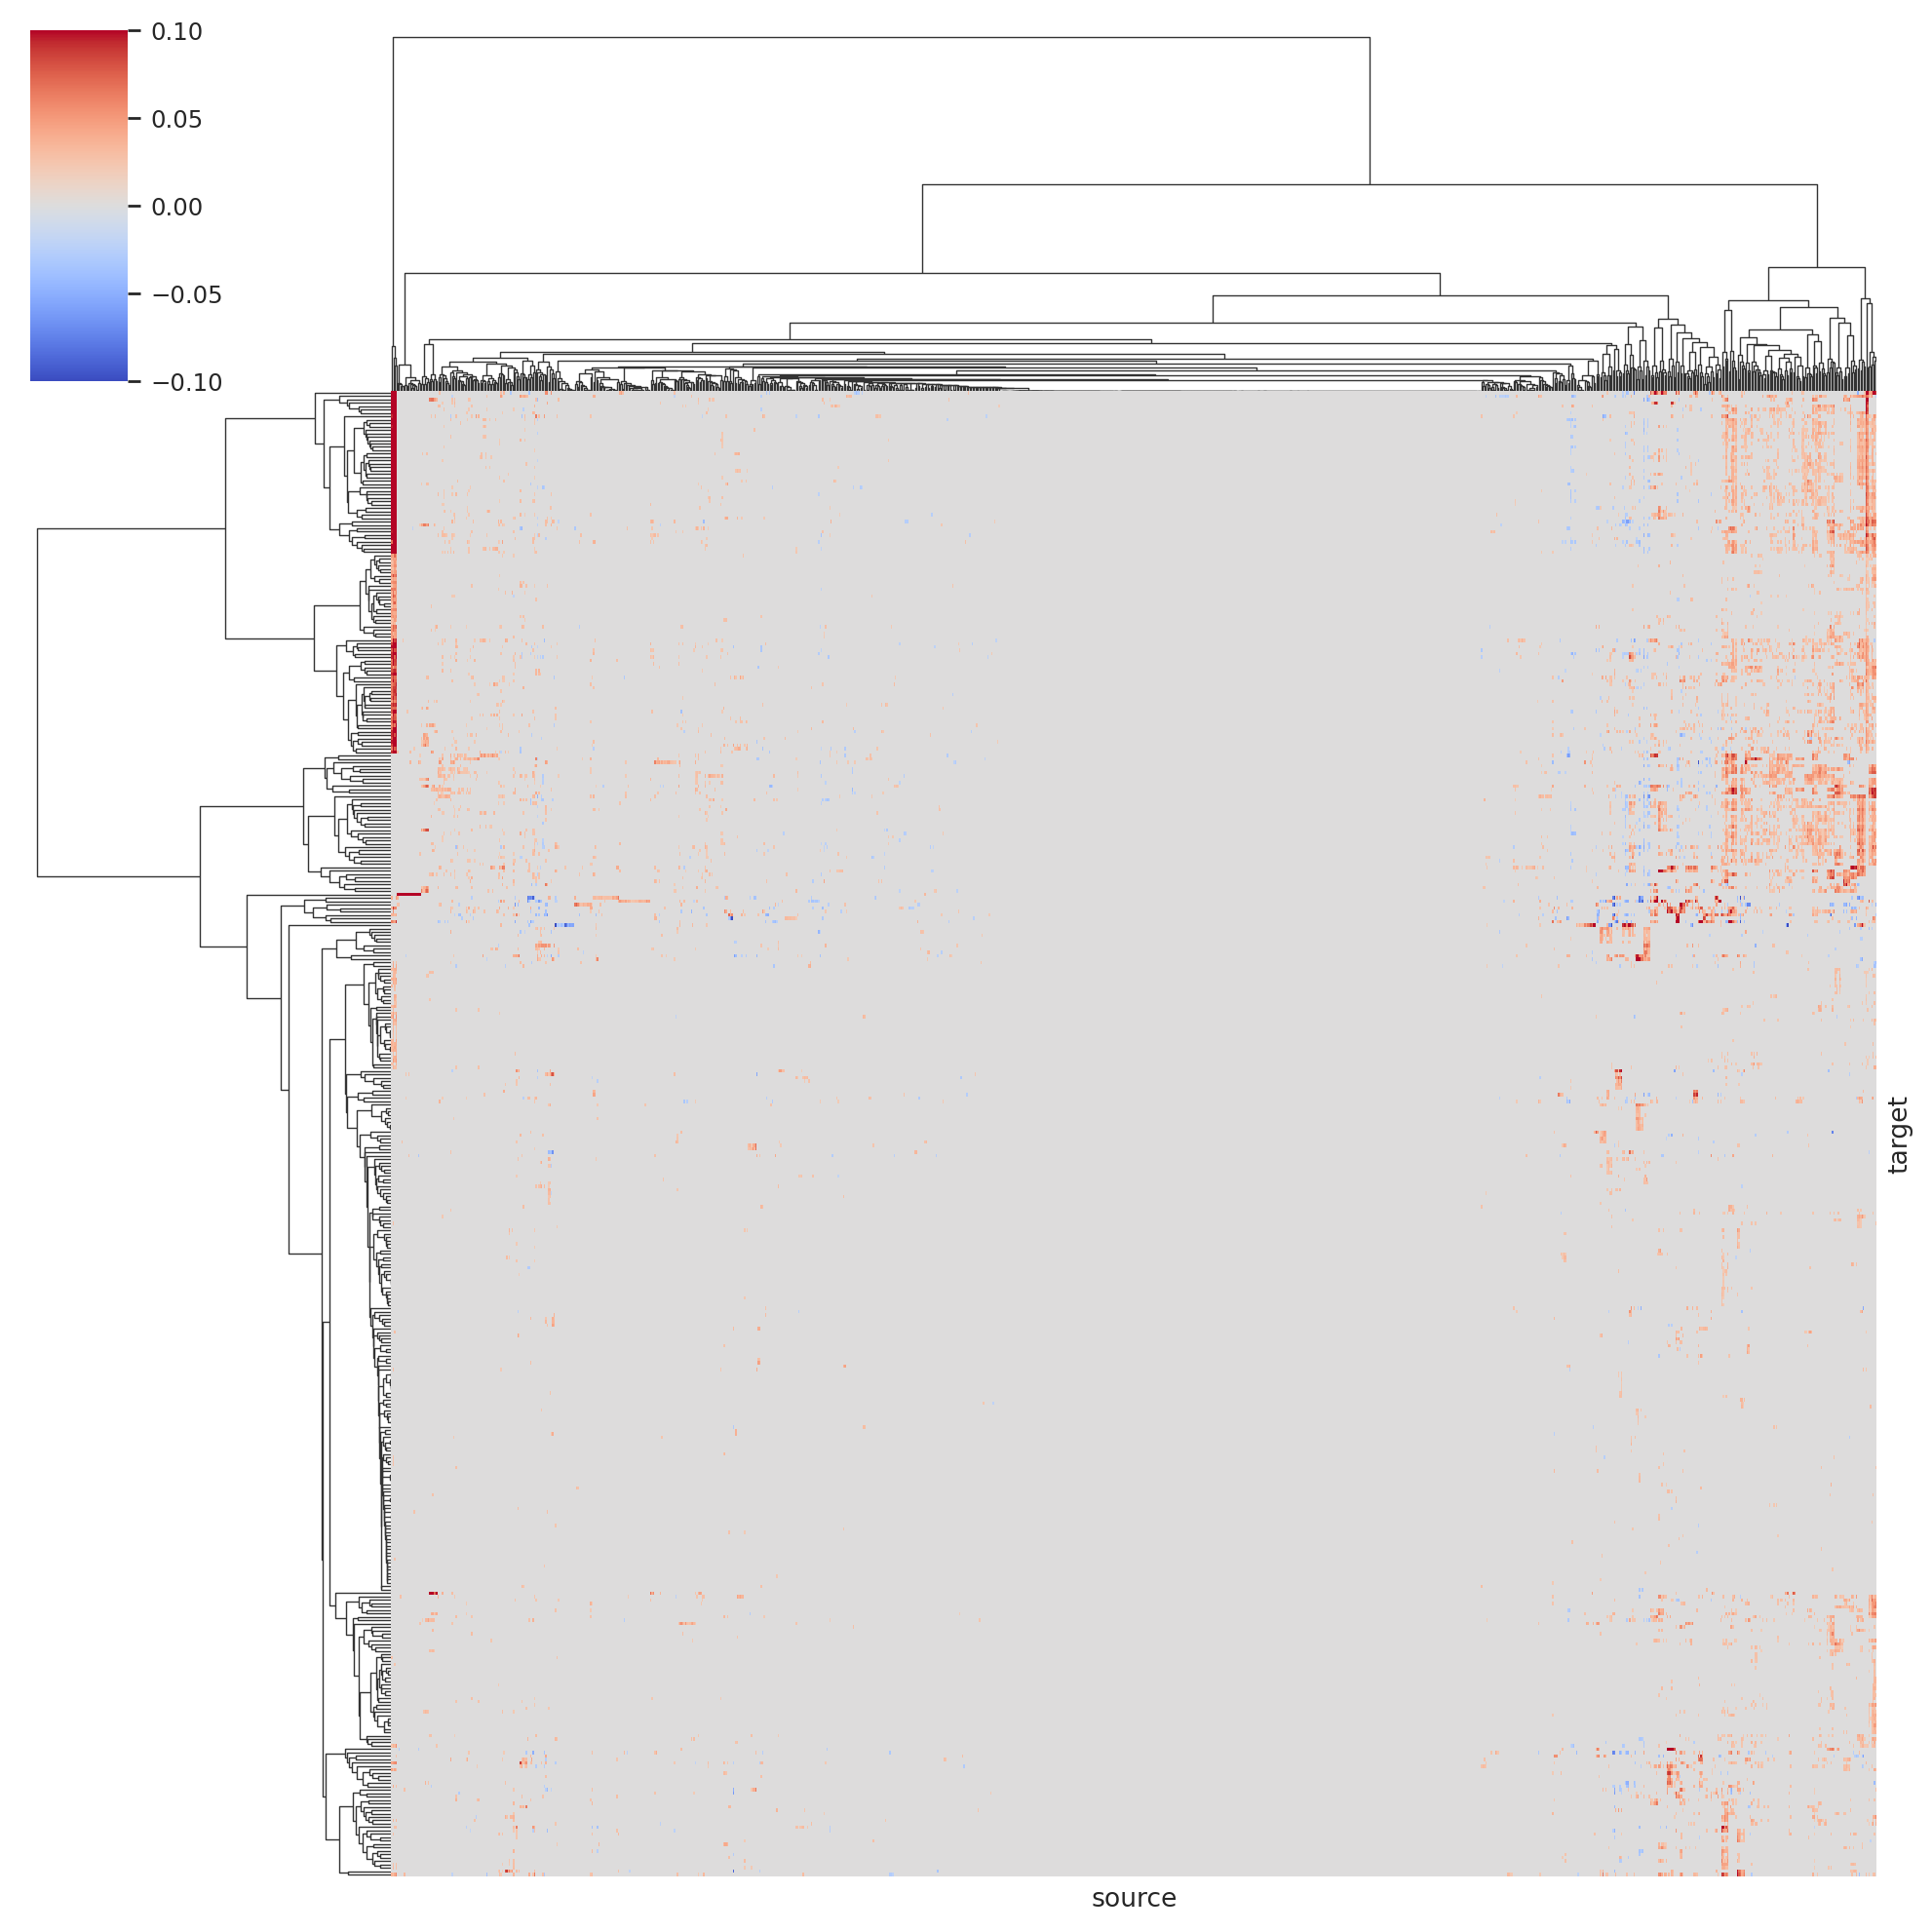

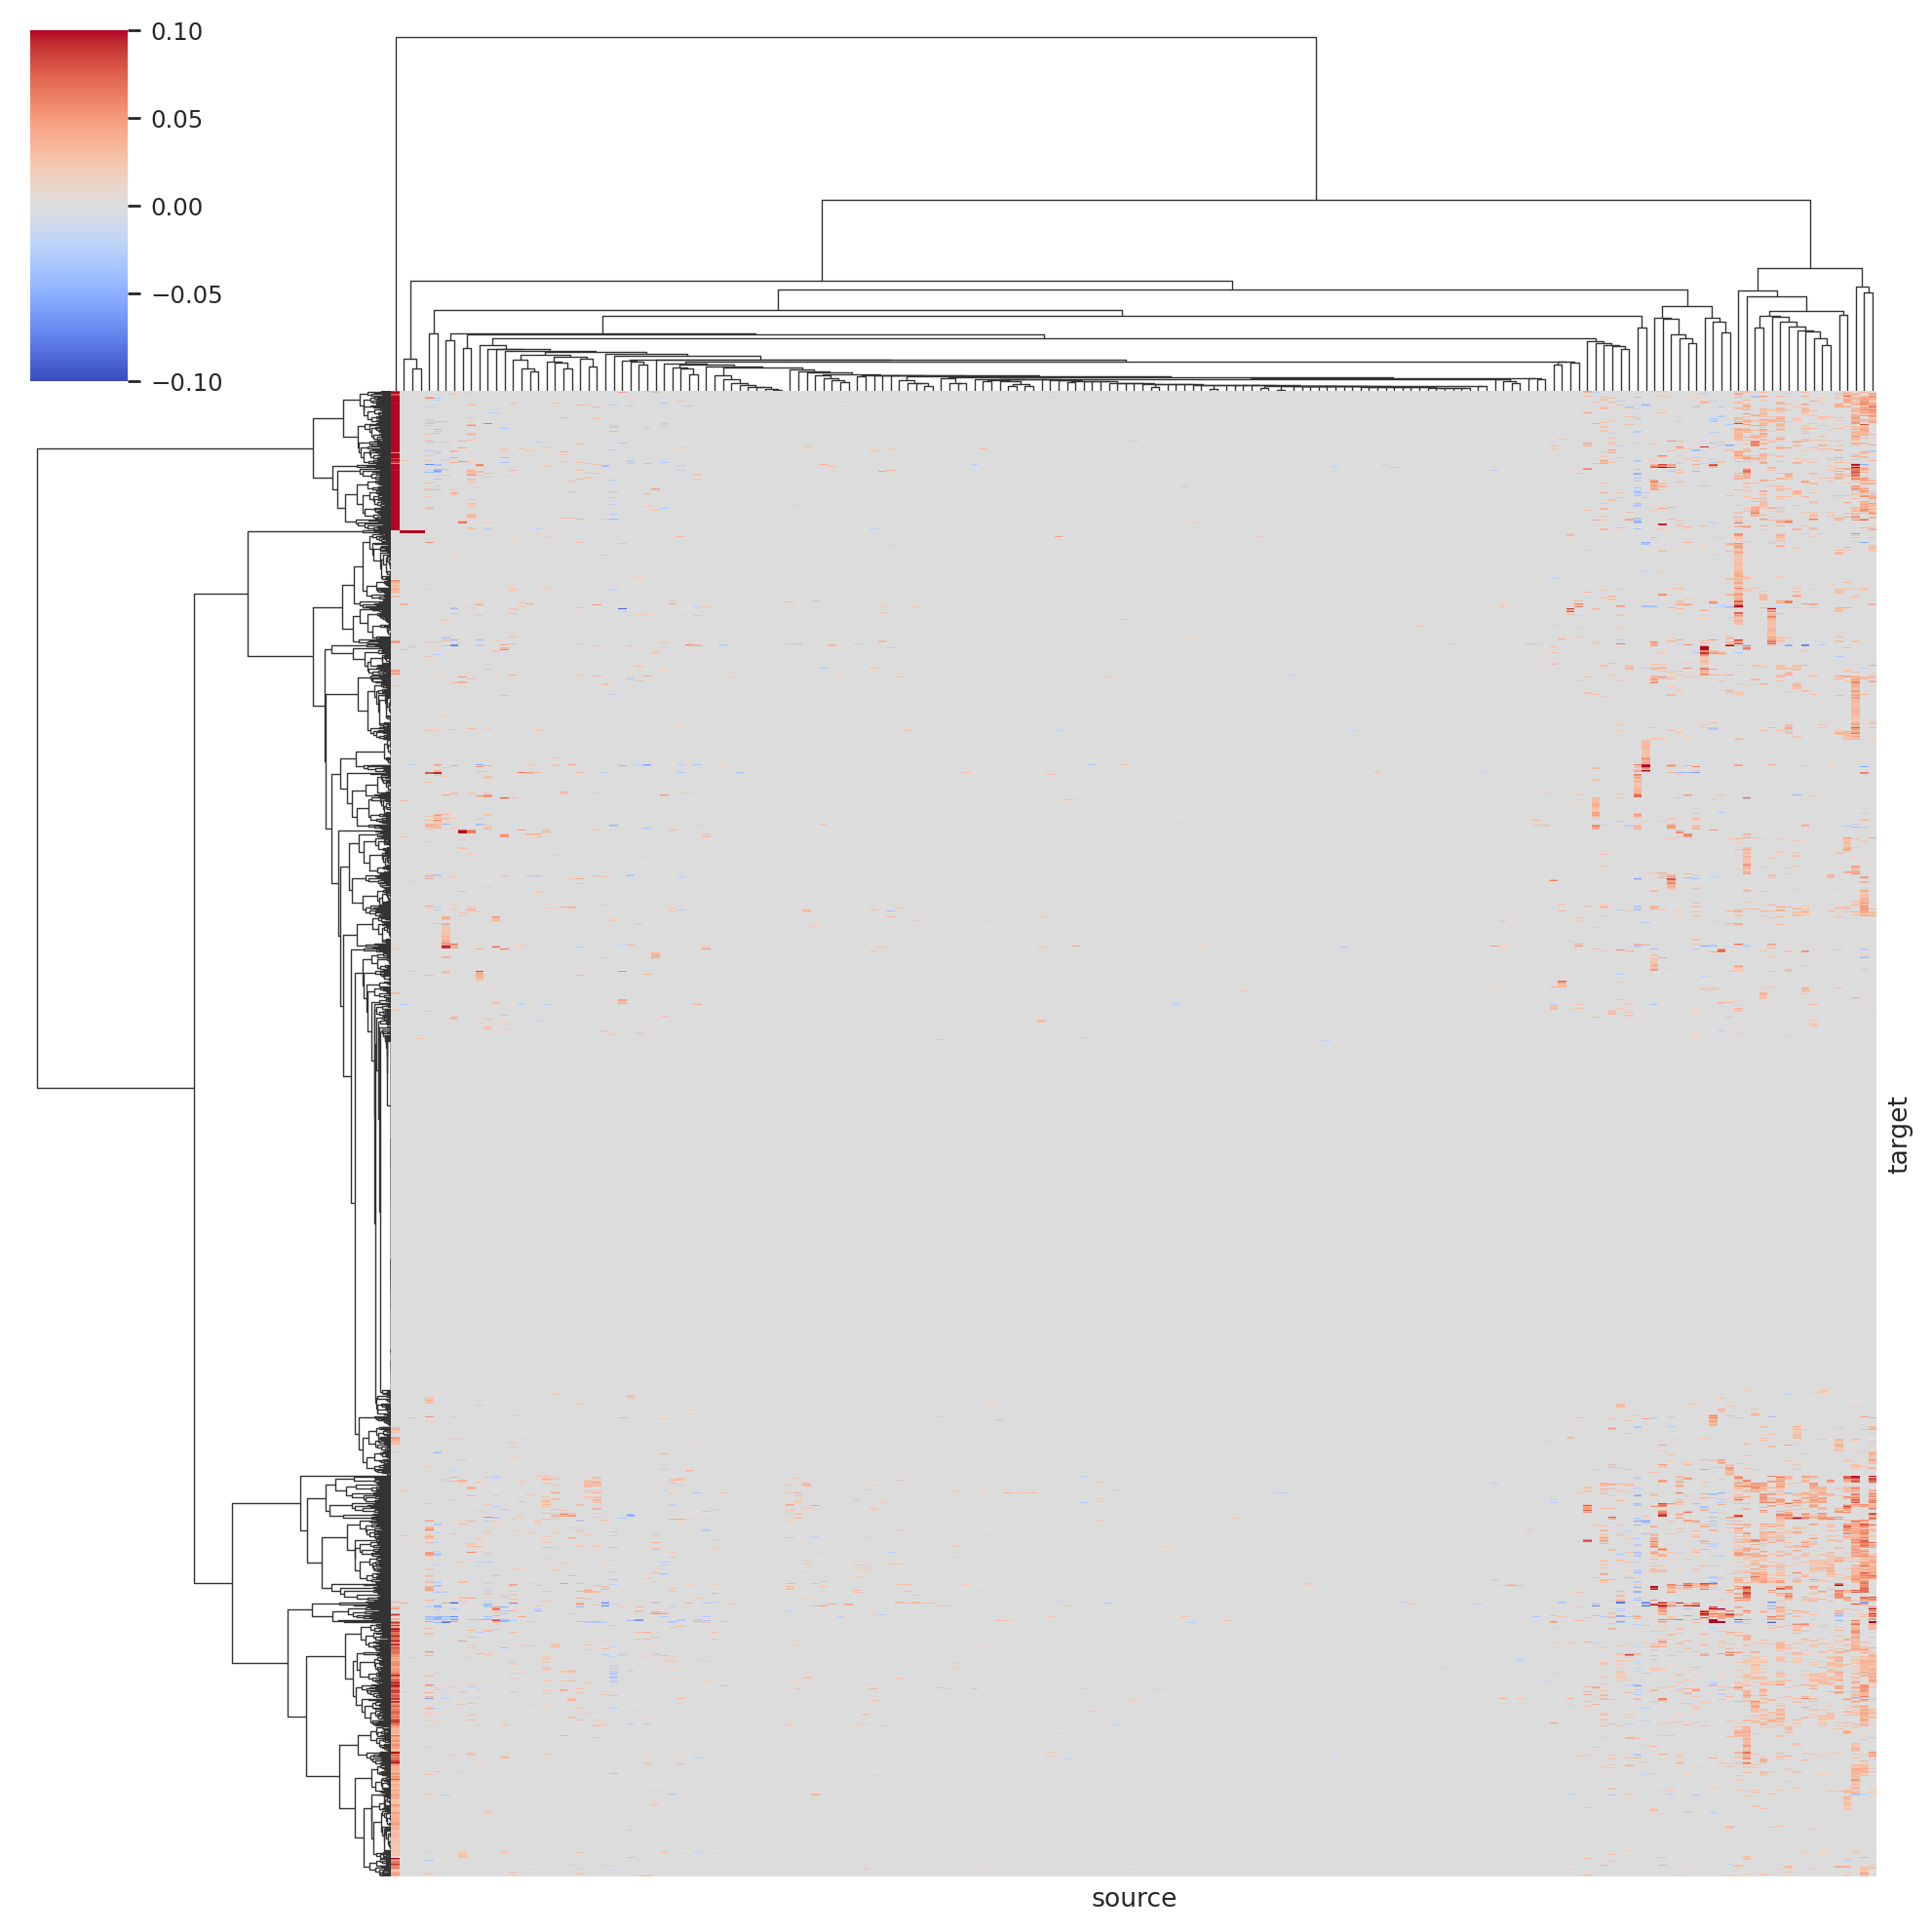

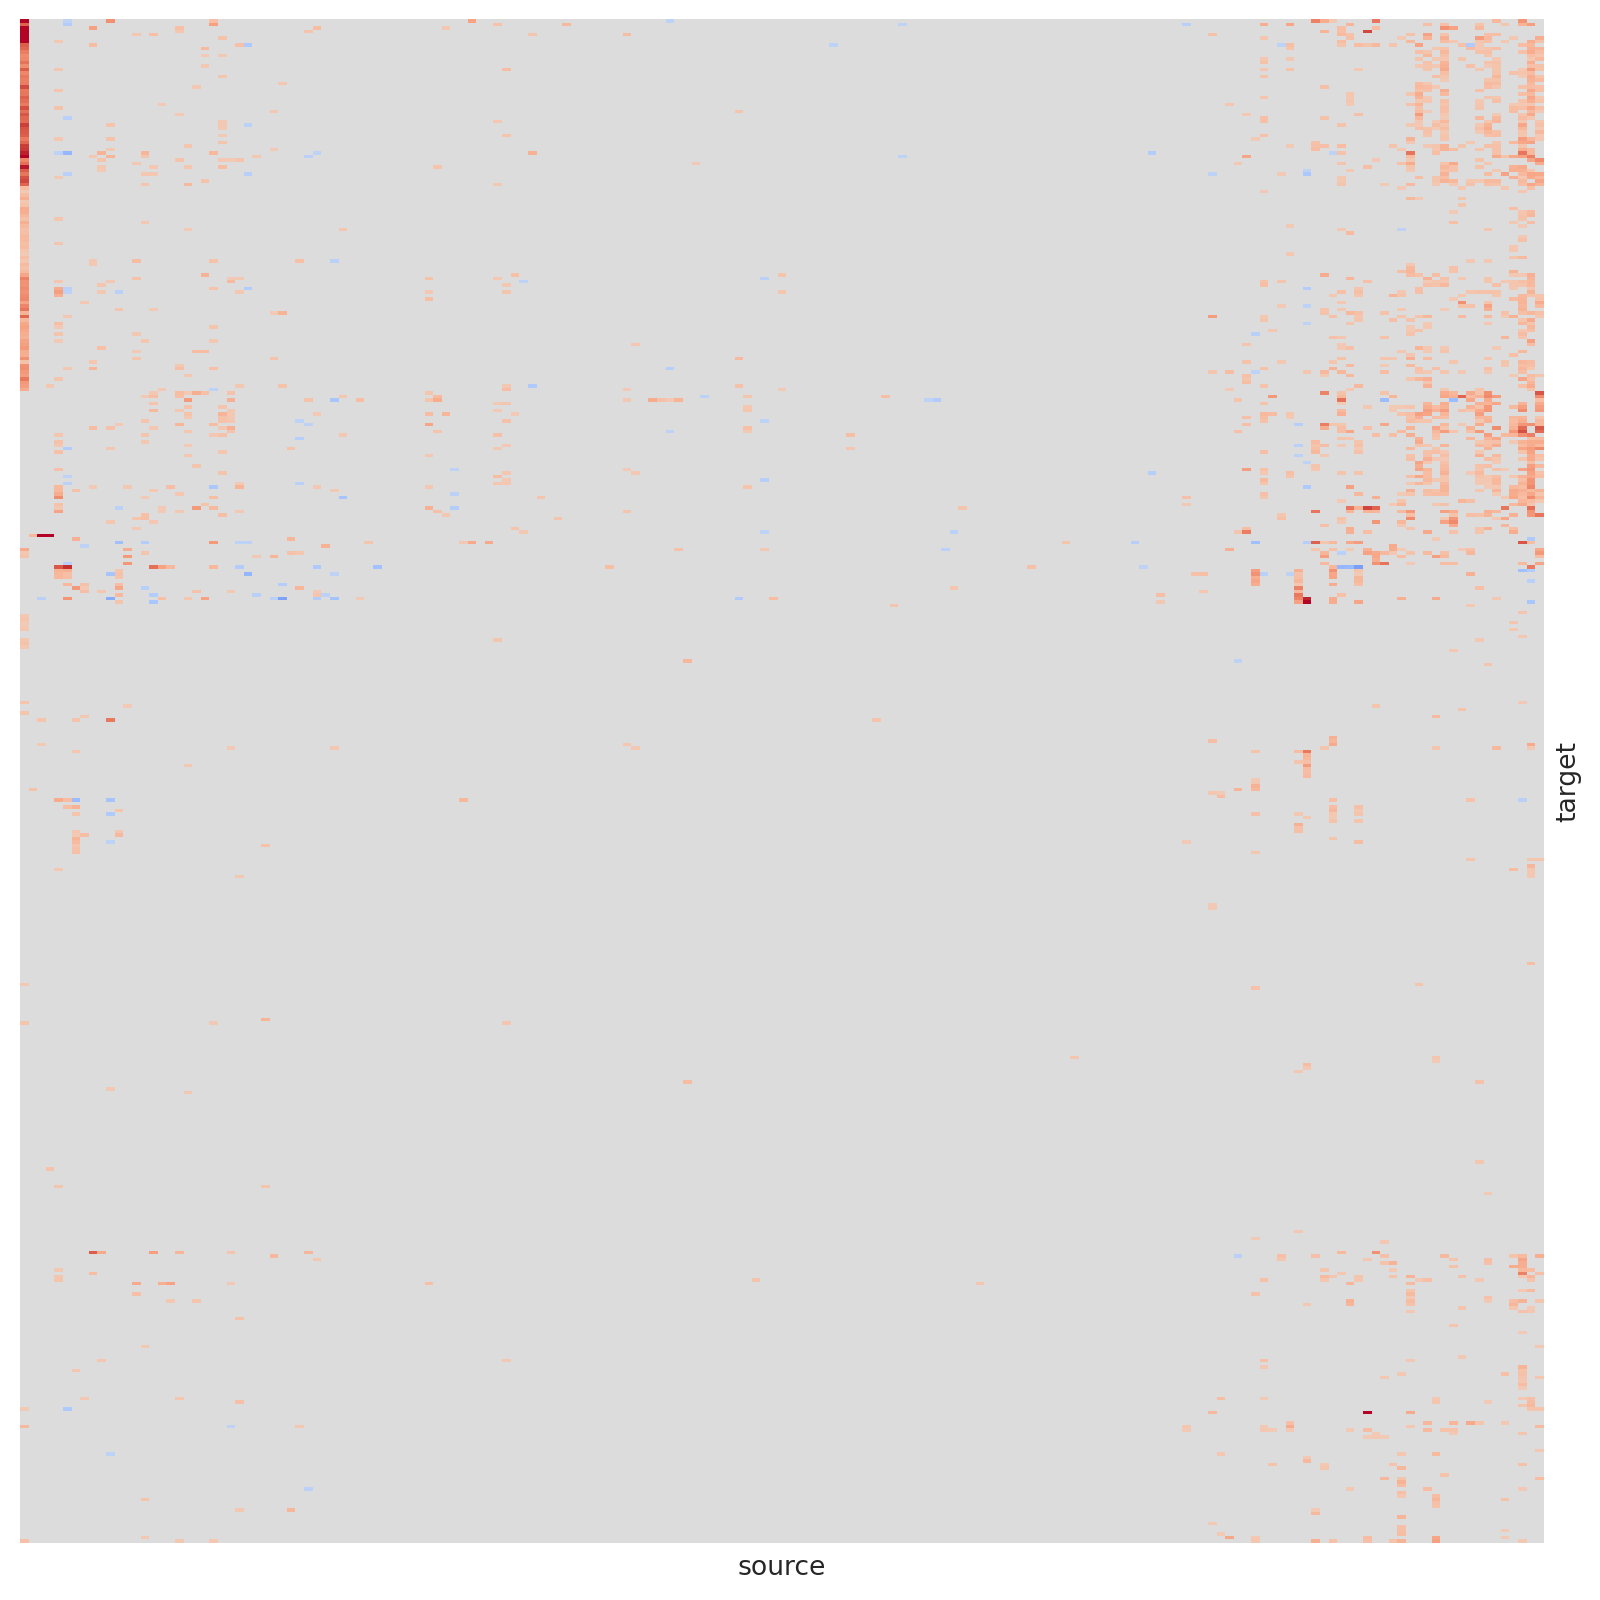

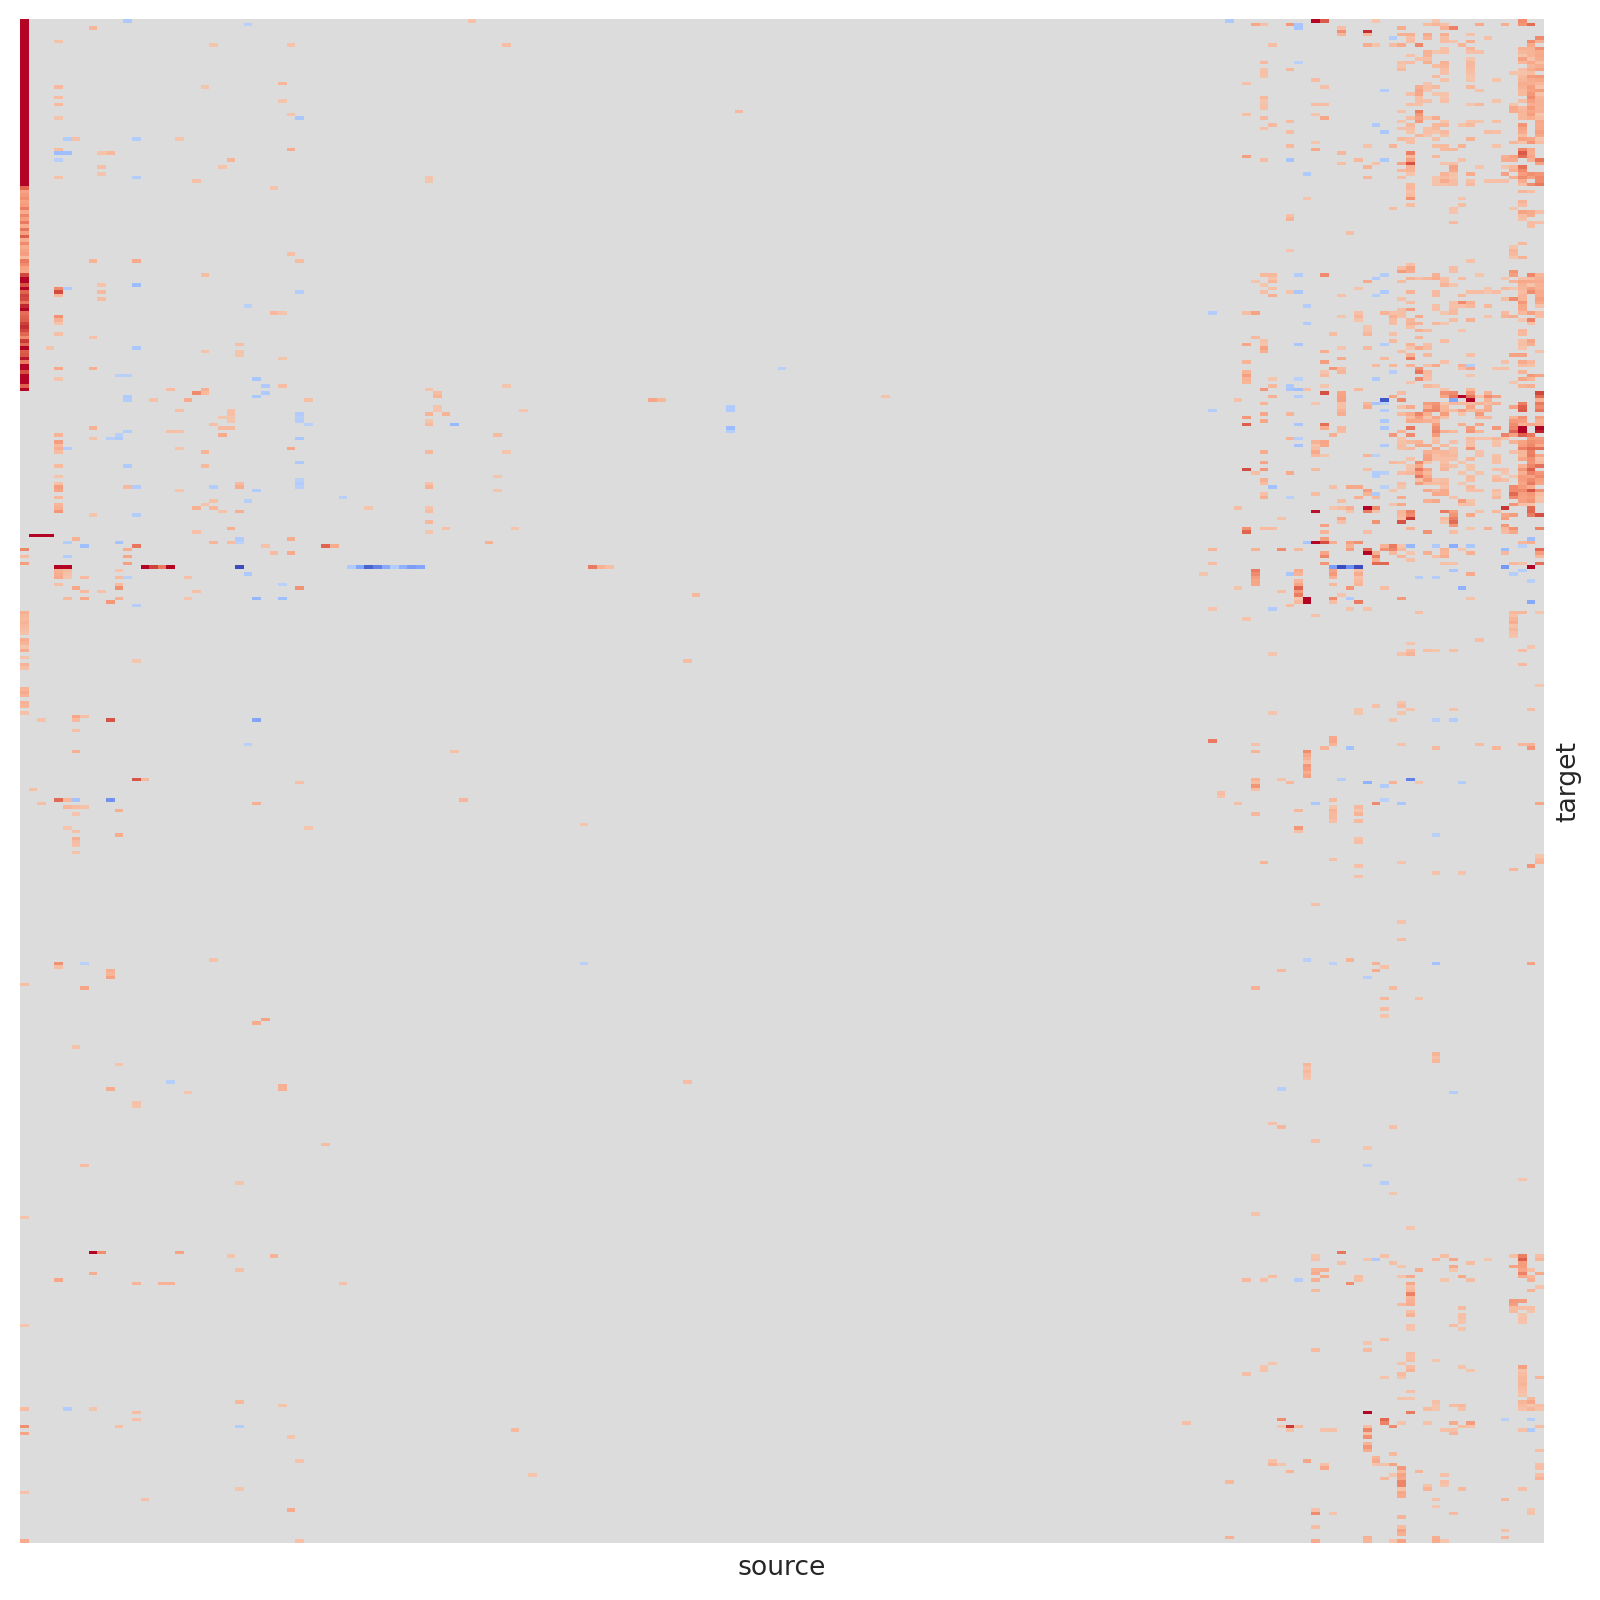

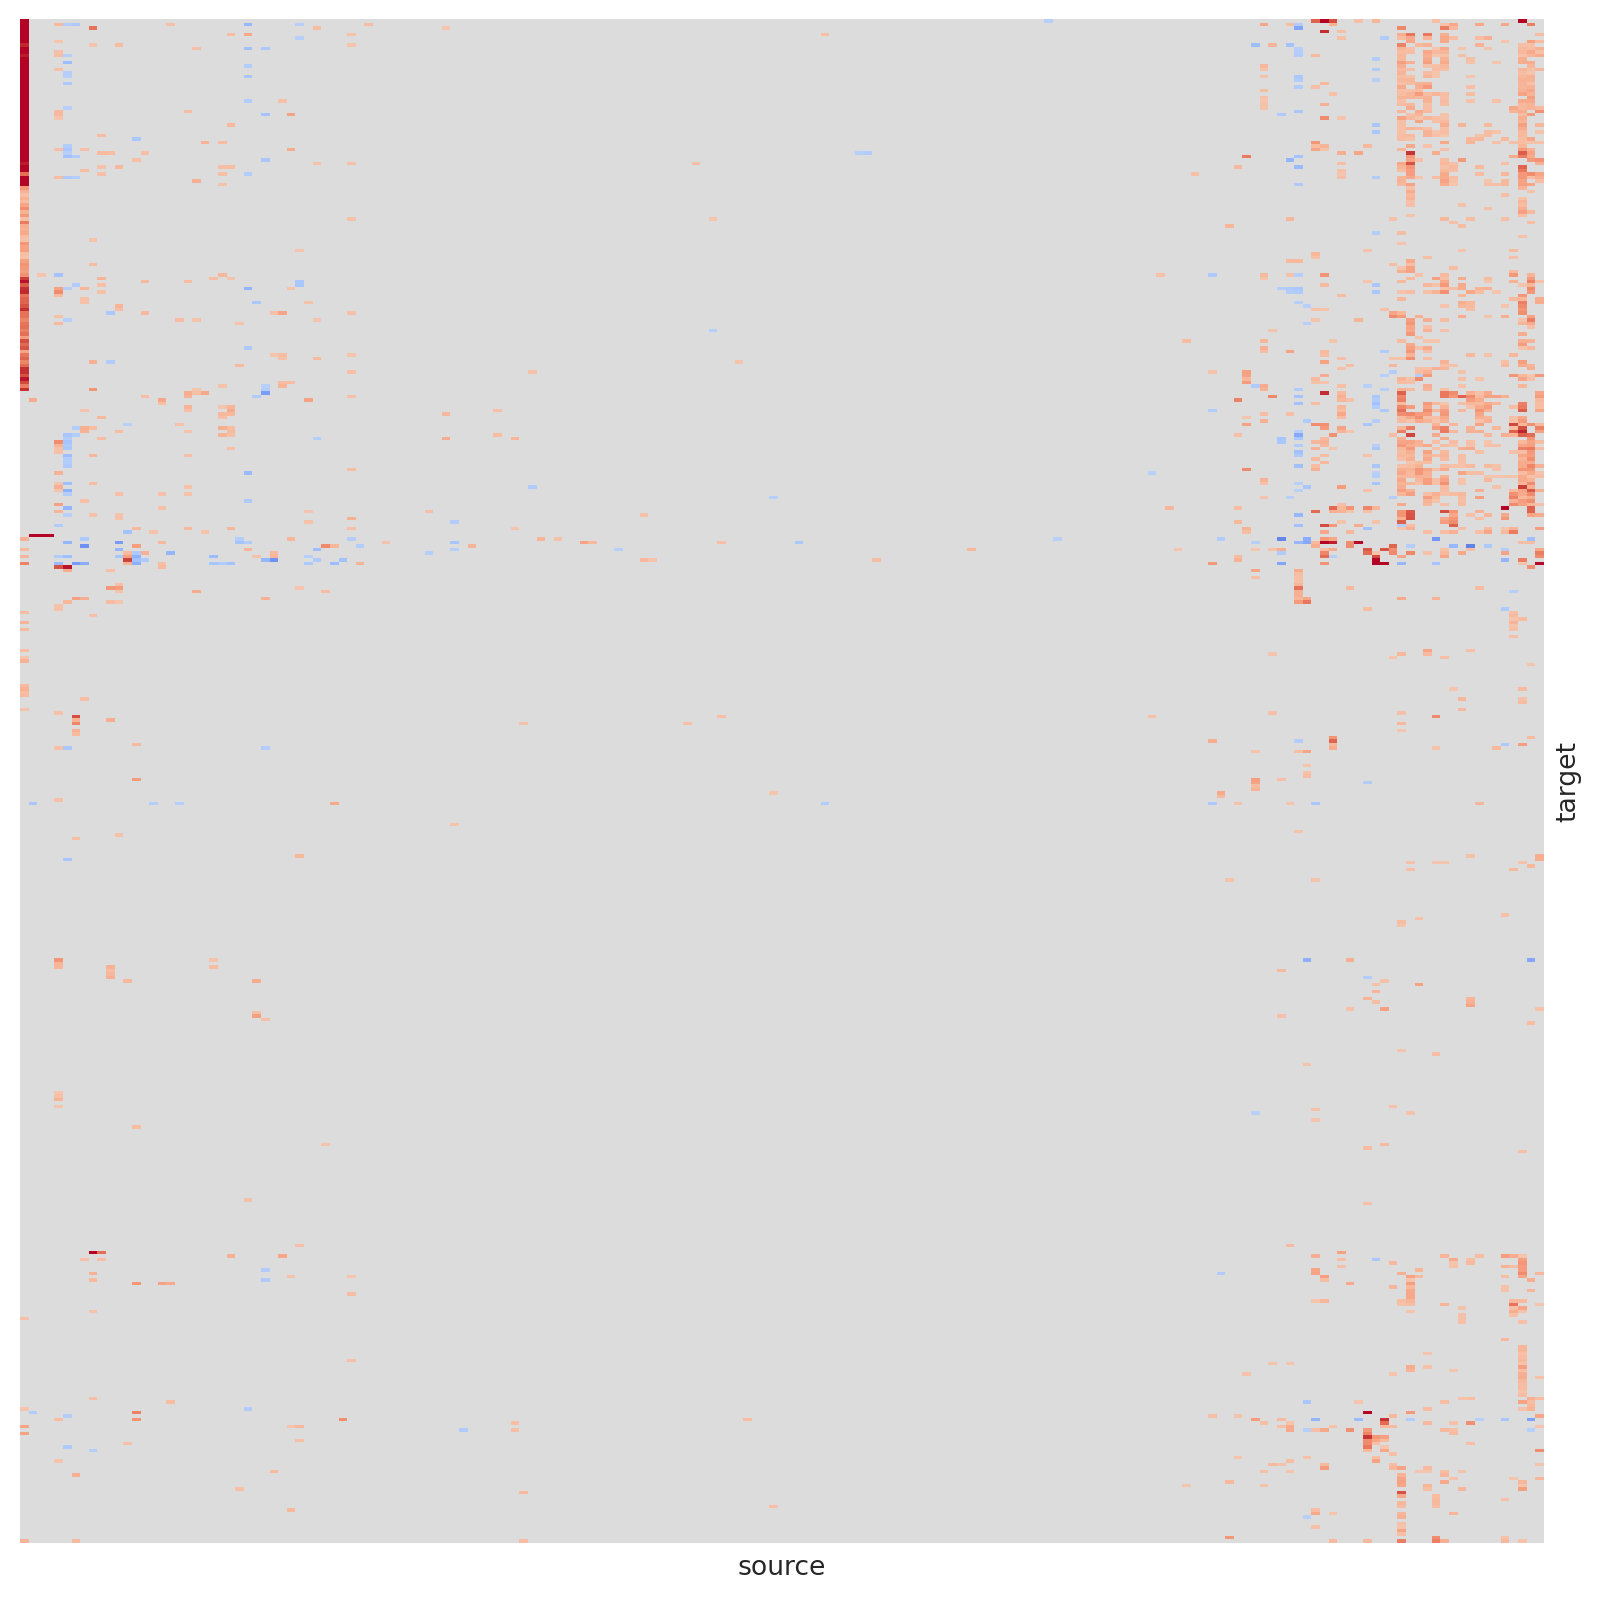

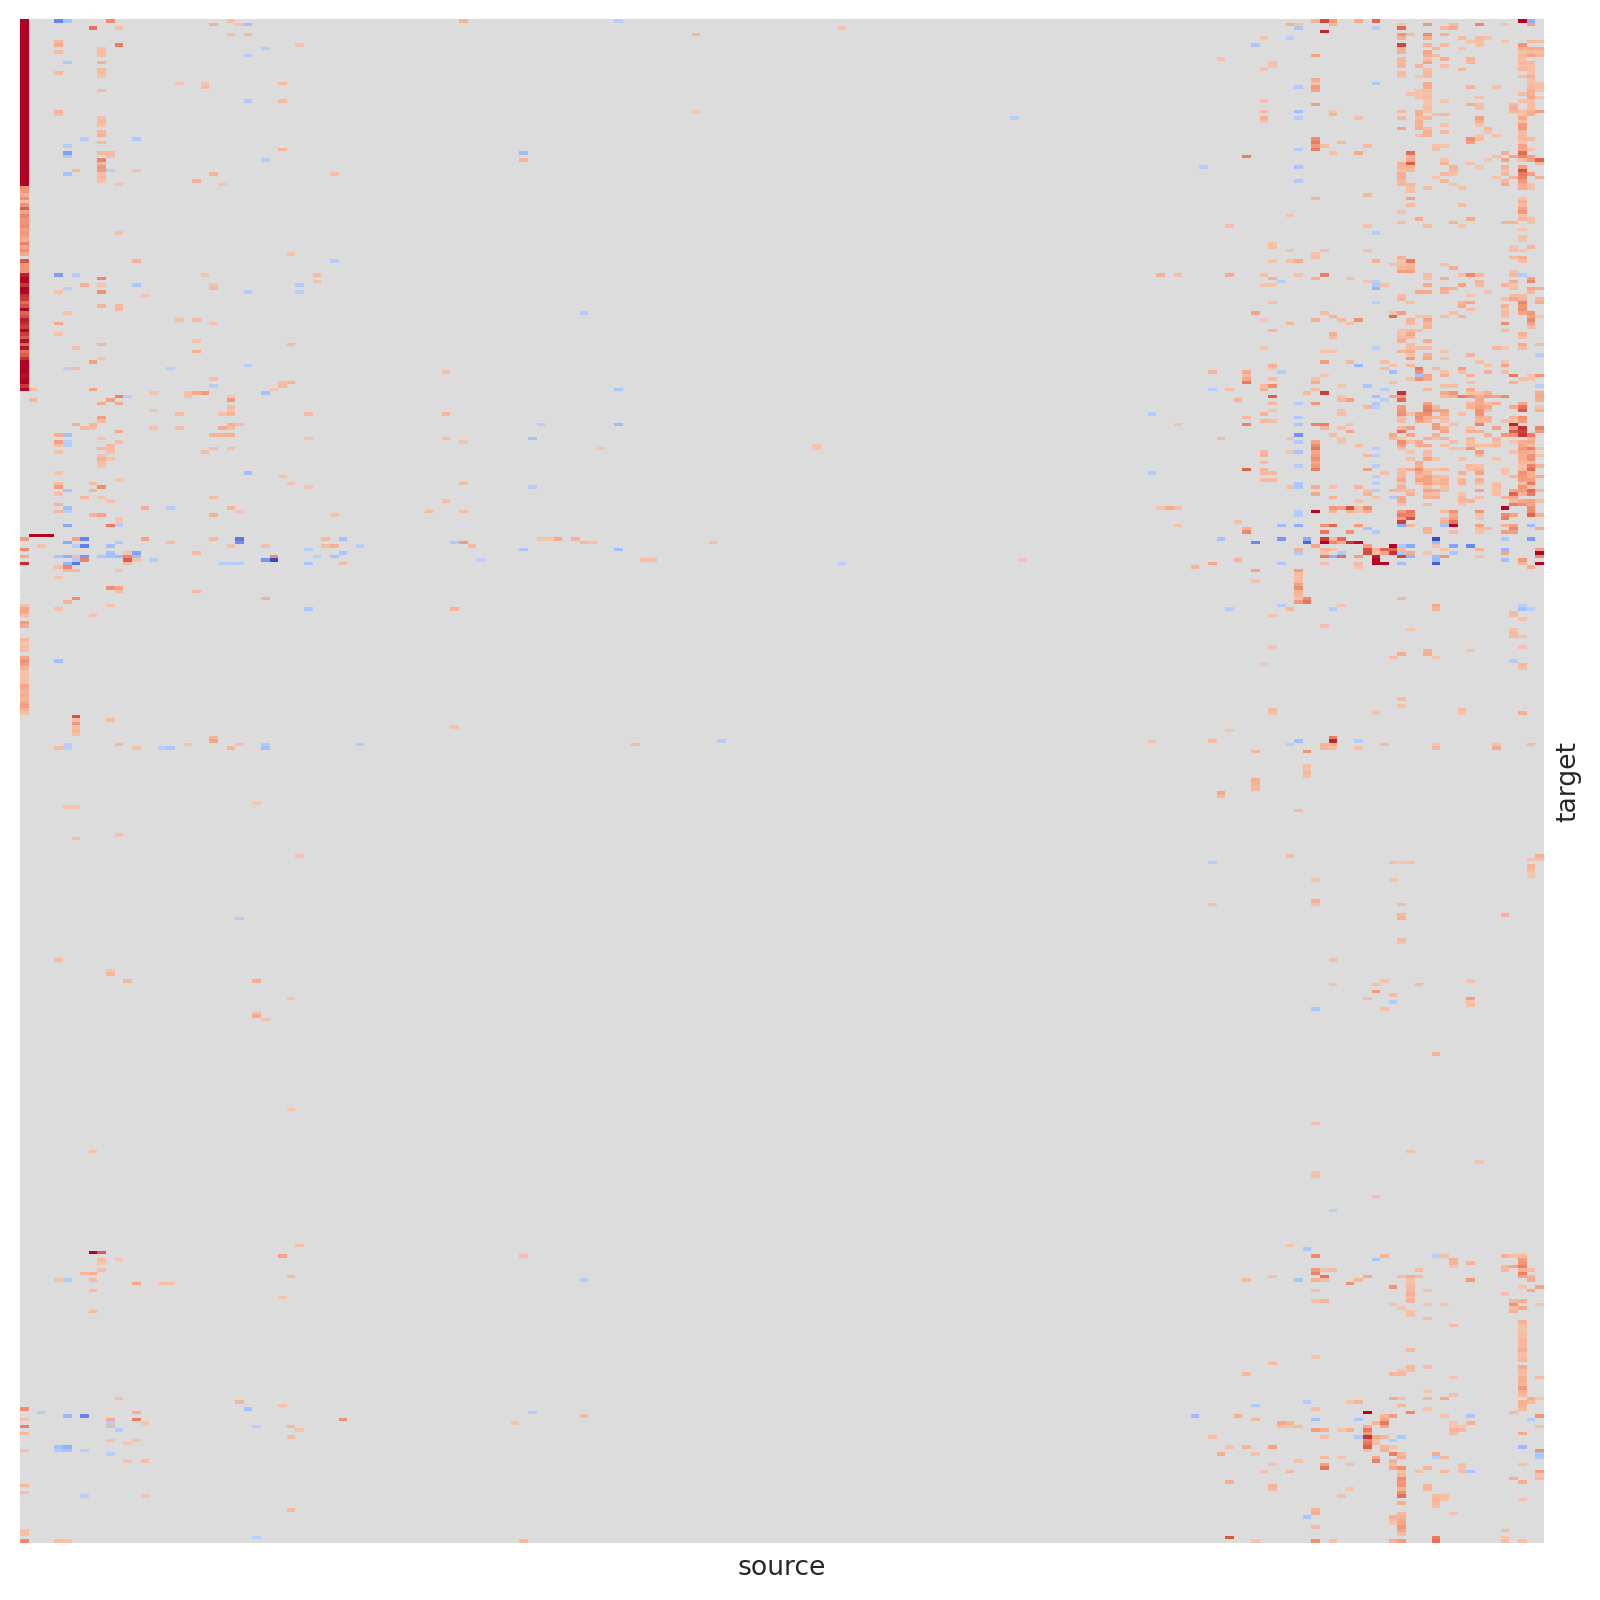

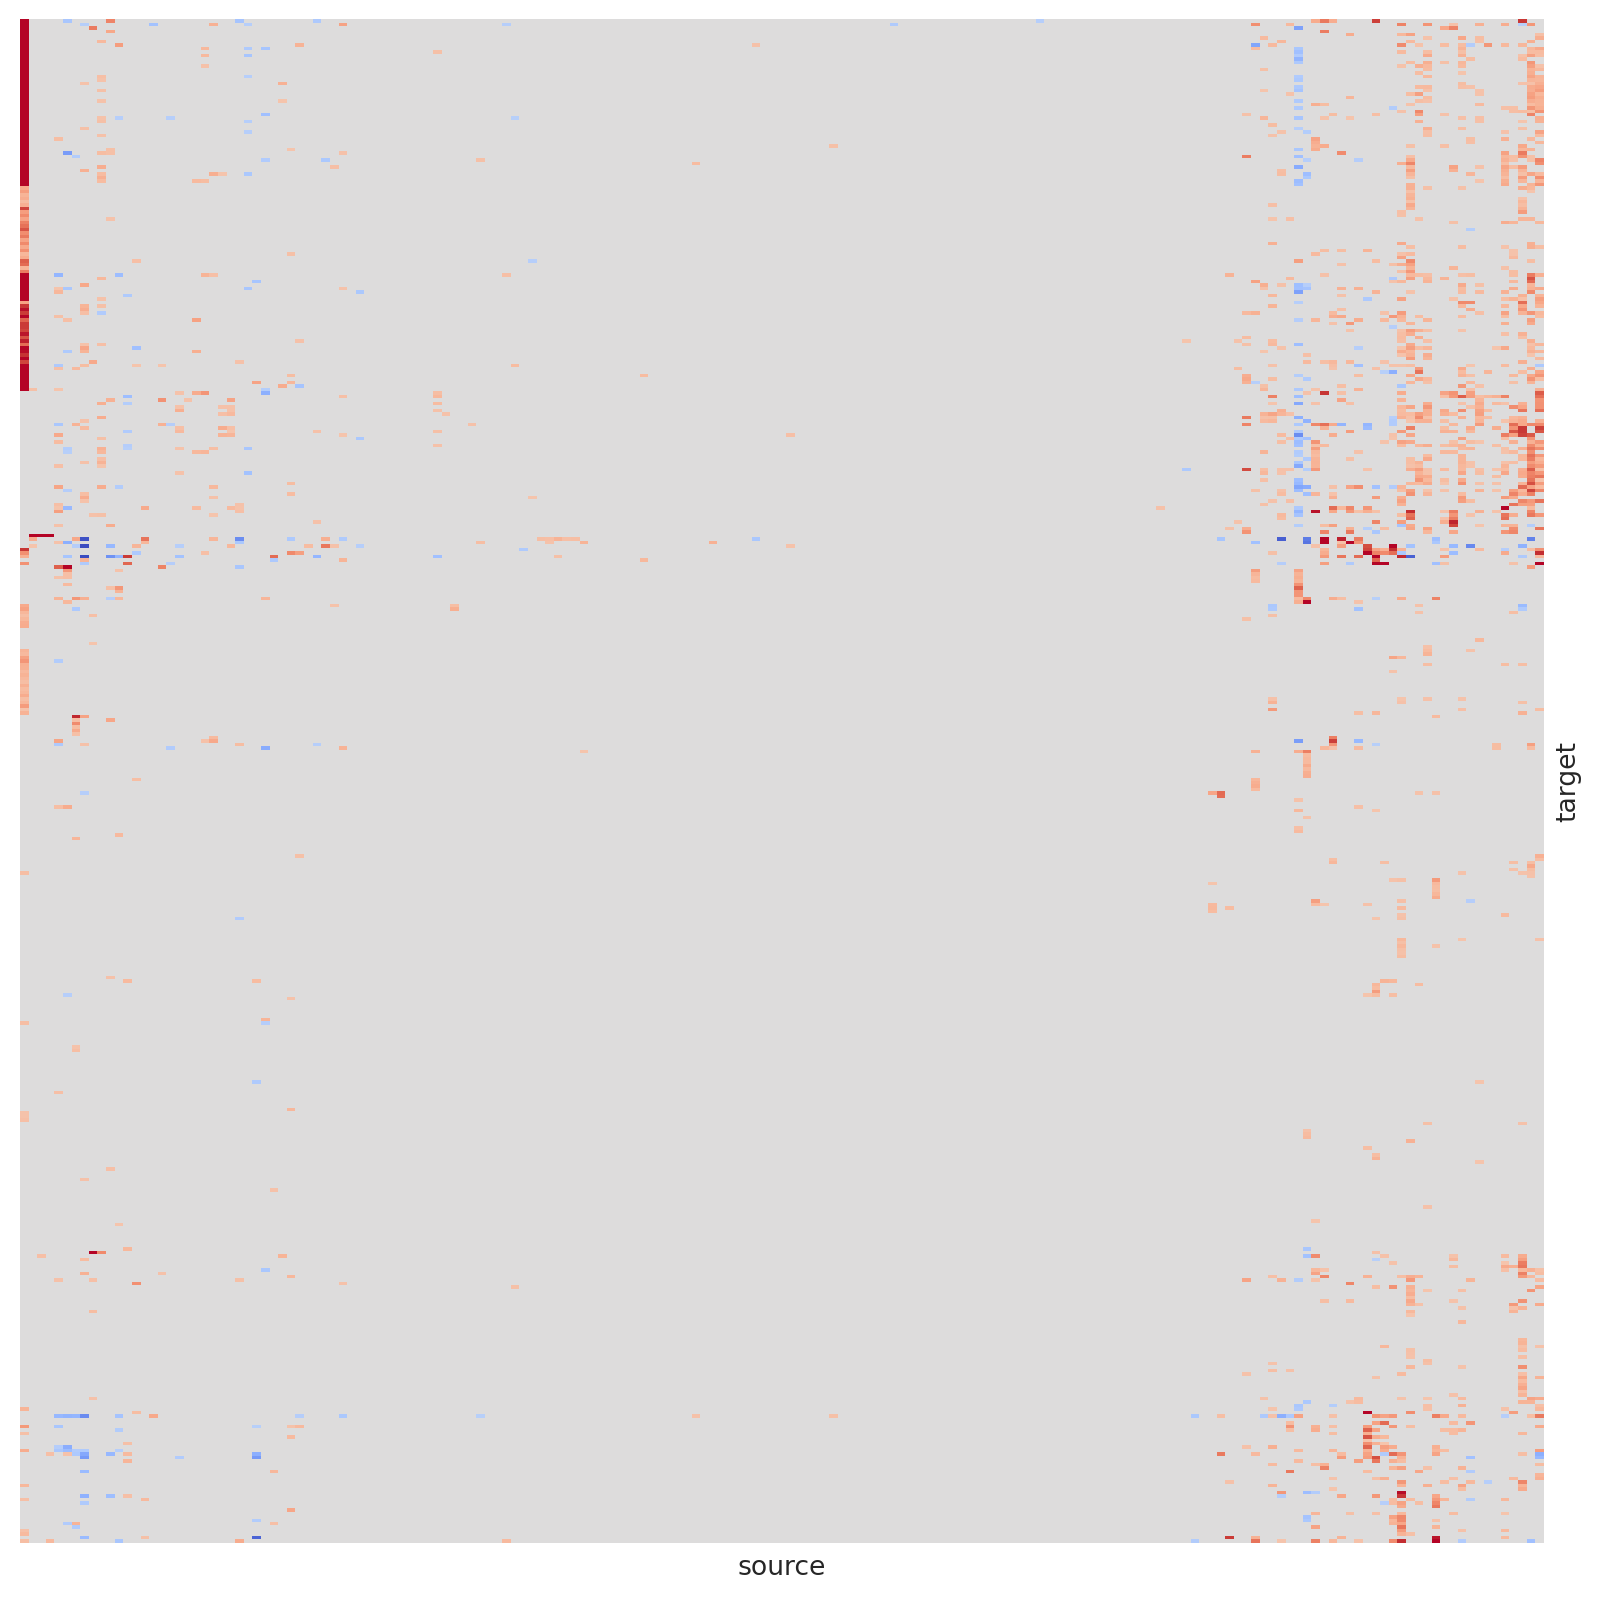

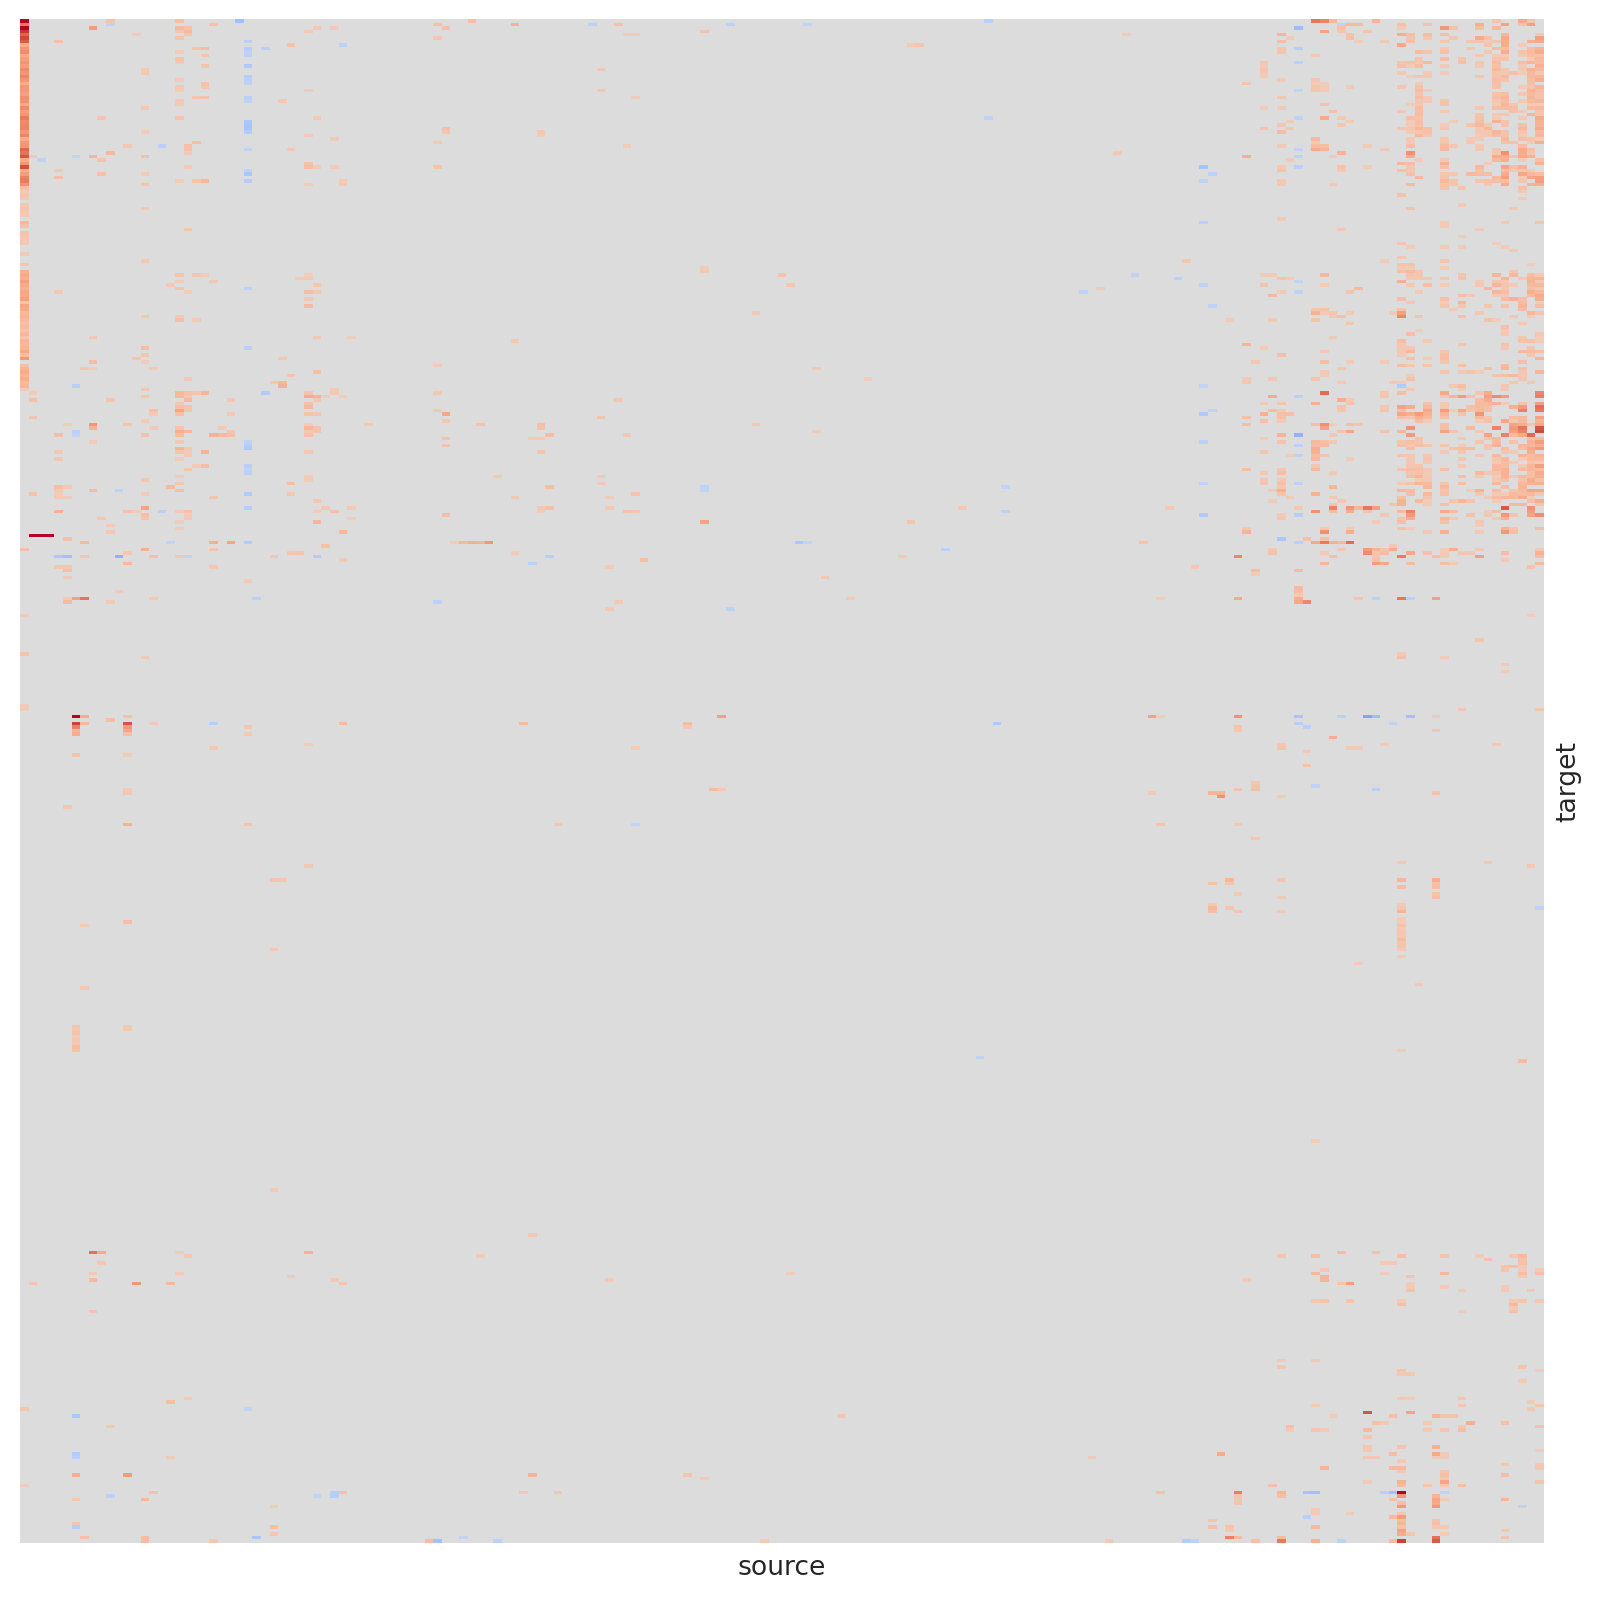

In [16]:
# For loop to plot the GRNs over celltypes (dev trajectories)
# Choose one timepoint and define the "stage"
timepoint = "TDR126"
# define the dev stage
stage = "0somites"
# timepoints = ["TDR126", "TDR127", "TDR128", "TDR118reseq", "TDR125reseq", "TDR124reseq"]
NMP_lineages = ["neural_posterior", "spinal_cord",
                     "NMPs","tail_bud","PSM","somites"]

# Step 1. collect all sources and targets across all celltypes
all_sources = set()
all_targets = set()

for celltype in NMP_lineages:
    df = dict_filtered_GRNs[timepoint][celltype]
    all_sources.update(df['source'].unique())
    all_targets.update(df['target'].unique())
    
# Step 2: Recreate each df_counts DataFrame
df_counts_union_NMP_lin = {}

for celltype in NMP_lineages:
    df = dict_filtered_GRNs[timepoint][celltype]
    # Pivot the original DataFrame
    df_pivot = df.pivot(index='target', columns='source', values='coef_mean').reindex(index=all_targets, columns=all_sources).fillna(0)
    df_counts_union_NMP_lin[celltype] = df_pivot
    
# list of all celltypes
list_celltypes = list(df_counts_union_NMP_lin.keys())

# based on the histogram above, we'll define the vmax/vmin for color scale
vmax = 0.1
vmin = -0.1

# compute the linkages from the first and the last timepoints, by augmenting the "time" components
df_counts1 = df_counts_union_NMP_lin["neural_posterior"]
df_counts2 = df_counts_union_NMP_lin["spinal_cord"]
df_counts3 = df_counts_union_NMP_lin["NMPs"]
df_counts4 = df_counts_union_NMP_lin["tail_bud"]
df_counts5 = df_counts_union_NMP_lin["PSM"]
df_counts6 = df_counts_union_NMP_lin["somites"]

# concatenate over the columns
df_counts_rows = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=1)

# concatenate over the rows
df_counts_cols = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=0)

# create a clustered heatmap for the "rows"
g1 = sns.clustermap(df_counts_rows, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# create a clustered heatmap for the "cols"
g2 = sns.clustermap(df_counts_cols, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# extract the row/col indices
row_linkage = g1.dendrogram_row.linkage
col_linkage = g2.dendrogram_col.linkage

# Loop over all timepoints (using the pre-computed linkages from the first timepoint)
for idx, celltype in enumerate(NMP_lineages):

    df_counts = df_counts_union_NMP_lin[celltype]
    
    # plot the clustermap
    g = sns.clustermap(df_counts, method='ward', metric='euclidean', 
                       cmap='coolwarm', standard_scale=None, 
                       row_cluster=True, col_cluster=True, 
                       xticklabels=False, yticklabels=False, 
                       vmax=vmax, vmin=vmin, 
                       row_linkage=row_linkage, col_linkage=col_linkage)
    
    # hide the dendrograms
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    # hide the colorbar
    g.cax.set_visible(False)
    
    # save the plot
    g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_NMPtraj.pdf") # celltype is defined above where we computed df_counts_union
    g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_NMPtraj.png")
# # Since sns.clustermap uses its own figure by default, we adjust our approach slightly:
# plt.close(g1.fig)  # Close the first plot's figure to prevent it from showing twice

# # Display all heatmaps side by side with consistent clustering
plt.show()

### Sectioning the left-top for "decreasing over time"

In [18]:
df_counts_union_NMP_lin.keys()

dict_keys(['neural_posterior', 'spinal_cord', 'NMPs', 'tail_bud', 'PSM', 'somites'])

In [20]:
# Check the GRN at the first celltype
df_counts = df_counts_union_NMP_lin["neural_posterior"]

# Assuming you have determined your cluster size and its position (last N rows and M columns)
N = 48  # The number of rows in the cluster, replace with the actual number
M = 5  # The number of columns in the cluster, replace with the actual number

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g.dendrogram_row.reordered_ind[0:N]
col_indices = g.dendrogram_col.reordered_ind[0:M]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source              hmga1a  mafba  tfap2a  tfap2c    sox11a
target                                                     
apoc1             0.117391    0.0     0.0     0.0  0.000000
prmt1             0.073496    0.0     0.0     0.0  0.000000
rpl5b             0.156717    0.0     0.0     0.0  0.000000
rrm2              0.118652    0.0     0.0     0.0  0.000000
ncl               0.120991    0.0     0.0     0.0  0.000000
rps13             0.112581    0.0     0.0     0.0  0.000000
cirbpb            0.111215    0.0     0.0     0.0  0.022197
nop58             0.075220    0.0     0.0     0.0  0.000000
rpl35             0.071992    0.0     0.0     0.0  0.000000
rpl13             0.062909    0.0     0.0     0.0  0.000000
rpl24             0.056780    0.0     0.0     0.0  0.000000
hmgn2             0.058545    0.0     0.0     0.0  0.000000
rpl9              0.067866    0.0     0.0     0.0  0.000000
rpl10a            0.055633    0.0     0.0     0.0  0.000000
rpl29             0.076390    0.0     0.

In [21]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union_NMP_lin["neural_posterior"]

df_counts_sectioned = df_counts.loc[row_names, col_names]
df_counts_sectioned

source              hmga1a  mafba  tfap2a  tfap2c    sox11a
target                                                     
apoc1             0.117391    0.0     0.0     0.0  0.000000
prmt1             0.073496    0.0     0.0     0.0  0.000000
rpl5b             0.156717    0.0     0.0     0.0  0.000000
rrm2              0.118652    0.0     0.0     0.0  0.000000
ncl               0.120991    0.0     0.0     0.0  0.000000
rps13             0.112581    0.0     0.0     0.0  0.000000
cirbpb            0.111215    0.0     0.0     0.0  0.022197
nop58             0.075220    0.0     0.0     0.0  0.000000
rpl35             0.071992    0.0     0.0     0.0  0.000000
rpl13             0.062909    0.0     0.0     0.0  0.000000
rpl24             0.056780    0.0     0.0     0.0  0.000000
hmgn2             0.058545    0.0     0.0     0.0  0.000000
rpl9              0.067866    0.0     0.0     0.0  0.000000
rpl10a            0.055633    0.0     0.0     0.0  0.000000
rpl29             0.076390    0.0     0.0     0.0  0.023554
rps2              0.059038    0.0     0.0     0.0  0.000000
rps24             0.065517    0.0     0.0     0.0  0.000000
rps14             0.061836    0.0     0.0     0.0  0.000000
tuba8l4           0.063215    0.0     0.0     0.0  0.000000
eef1a1l1          0.082137    0.0     0.0     0.0  0.000000
rpl28             0.065015    0.0     0.0     0.0  0.025346
khdrbs1a          0.066068    0.0     0.0     0.0  0.000000
ptmab             0.074330    0.0     0.0     0.0  0.000000
hmgb2a            0.069507    0.0     0.0     0.0  0.000000
si:ch73-281n10.2  0.063963    0.0     0.0     0.0  0.000000
hnrnpaba          0.081239    0.0     0.0     0.0  0.026008
npm1a             0.068477    0.0     0.0     0.0  0.000000
hsp90ab1          0.078830    0.0     0.0     0.0  0.000000
rpl4              0.071978    0.0     0.0     0.0  0.000000
rplp2l            0.070445    0.0     0.0     0.0  0.000000
rpl32             0.086120    0.0     0.0     0.0  0.000000
rpl11             0.079380    0.0     0.0     0.0  0.000000
rpl18a            0.077101    0.0     0.0     0.0  0.000000
rpl23a            0.075446    0.0     0.0     0.0  0.000000
bzw1a             0.063904    0.0     0.0     0.0  0.023259
eef2b             0.072267    0.0     0.0     0.0  0.000000
pabpc1a           0.086976    0.0     0.0     0.0  0.000000
rpl12             0.088848    0.0     0.0     0.0  0.000000
snrpg             0.094611    0.0     0.0     0.0 -0.021508
ran               0.112403    0.0     0.0     0.0  0.000000
anp32b            0.059335    0.0     0.0     0.0  0.000000
metap2b           0.068871    0.0     0.0     0.0  0.000000
rps3a             0.096173    0.0     0.0     0.0  0.000000
hmgn6             0.075967    0.0     0.0     0.0  0.000000
tma7              0.065760    0.0     0.0     0.0  0.000000
rps6              0.079741    0.0     0.0     0.0  0.021358
rps19             0.083700    0.0     0.0     0.0  0.000000
rps18             0.072945    0.0     0.0     0.0  0.000000

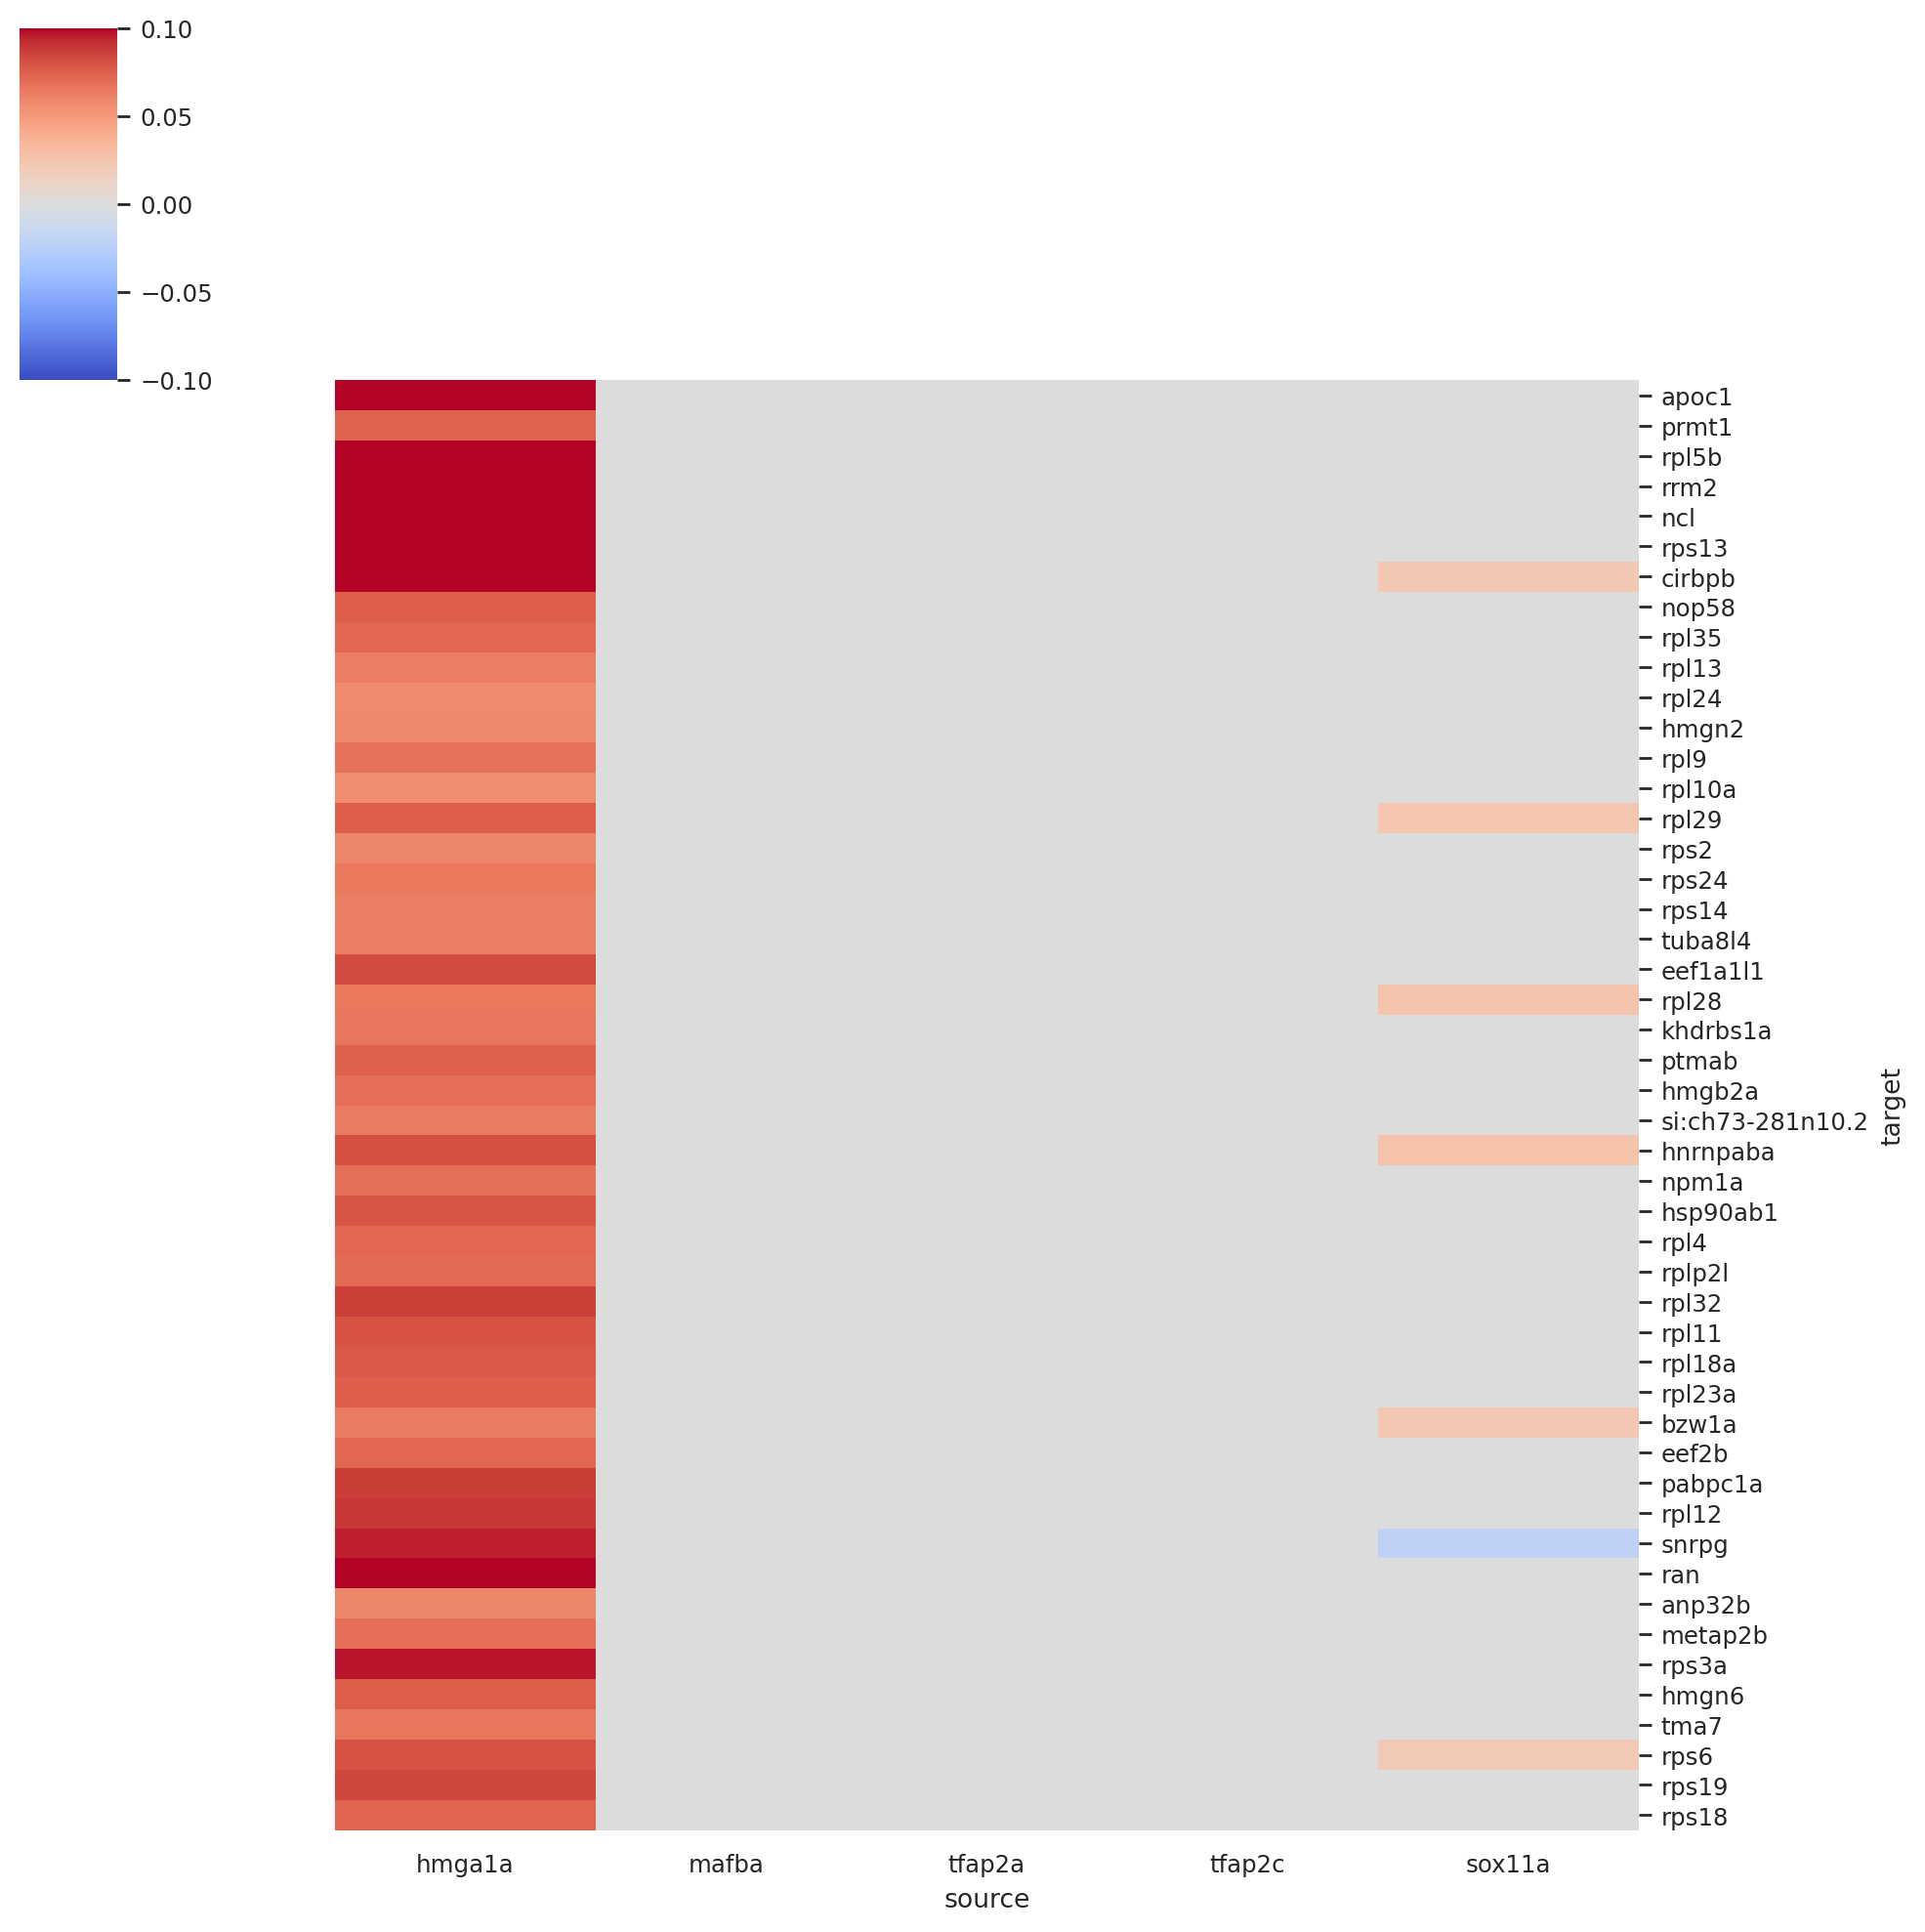

In [22]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_sectioned, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "neural_posterior"
stage = "0somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}.png")

plt.show()

## Step 3. visualizing the whole-embryo level GRN (computed from the whole-embryo at each time point)



In [52]:
oracle_base_dir = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/11_celloracle_whole_embryo_GRNs/"

In [53]:
# # import all adata objects and save as a dictionary
# dict_adata = {}

# for dataset in list_files:
#     adata = sc.read_h5ad(oracle_base_dir + f"{dataset}_nmps_manual_annotation.h5ad")
#     dict_adata[dataset] = adata
    
# dict_adata

In [54]:
# define an empty dictionary
dict_links = {}

# for loop to import all Links objects
for dataset in list_files:
    file_name = f"{dataset}/08_{dataset}_celltype_GRNs.celloracle.links"
    file_path = os.path.join(oracle_base_dir, file_name)
    dict_links[dataset] = co.load_hdf5(file_path)
    
    print("importing ", dataset)
    
dict_links

importing  TDR126
importing  TDR127
importing  TDR128
importing  TDR118
importing  TDR125
importing  TDR124


{'TDR126': <celloracle.network_analysis.links_object.Links at 0x153982848fa0>,
 'TDR127': <celloracle.network_analysis.links_object.Links at 0x1539829788b0>,
 'TDR128': <celloracle.network_analysis.links_object.Links at 0x153982a63df0>,
 'TDR118': <celloracle.network_analysis.links_object.Links at 0x153982a63670>,
 'TDR125': <celloracle.network_analysis.links_object.Links at 0x153982869d30>,
 'TDR124': <celloracle.network_analysis.links_object.Links at 0x153982874a60>}

### Further filtering of weak edges within the GRNs
- By default, we keep 2000 edges for each GRN [celltype, time]. 
- We'd like to filter out the weak edges by (1) edge strength, and (2) p-values

In [55]:
# define a new dict to save the "pruned" links
n_edges = 2000

# define an empty dict
dict_links_pruned = {}

for dataset in dict_links.keys():
    # filter for n_edges
    links = dict_links[dataset]
    links.filter_links(thread_number=n_edges)
    dict_links_pruned[dataset] = links
    
dict_links_pruned

{'TDR126': <celloracle.network_analysis.links_object.Links at 0x153982848fa0>,
 'TDR127': <celloracle.network_analysis.links_object.Links at 0x1539829788b0>,
 'TDR128': <celloracle.network_analysis.links_object.Links at 0x153982a63df0>,
 'TDR118': <celloracle.network_analysis.links_object.Links at 0x153982a63670>,
 'TDR125': <celloracle.network_analysis.links_object.Links at 0x153982869d30>,
 'TDR124': <celloracle.network_analysis.links_object.Links at 0x153982874a60>}

In [56]:
# import the filtered_links from each GRN, and save them into another dictionary
dict_filtered_GRNs = {}

# for loop to import all filtered_GRN dataframes
for dataset in dict_links_pruned.keys():
    # extract the filtered links
    dict_filtered_GRNs[dataset] = dict_links_pruned[dataset].filtered_links
    
    print("importing filtered GRNs", dataset)
    
# dict_filtered_GRNs

importing filtered GRNs TDR126
importing filtered GRNs TDR127
importing filtered GRNs TDR128
importing filtered GRNs TDR118
importing filtered GRNs TDR125
importing filtered GRNs TDR124


In [57]:
# import the merged_scores from each GRN, and save them into another dictionary
dict_merged_score = {}

# for loop to import all filtered_GRN dataframes
for dataset in dict_links_pruned.keys():
    # extract the filtered links
    dict_merged_score[dataset] = dict_links_pruned[dataset].merged_score
    
    print("importing ", dataset)
    
# dict_merged_score

importing  TDR126
importing  TDR127
importing  TDR128
importing  TDR118
importing  TDR125
importing  TDR124


In [60]:
dict_filtered_GRNs["TDR126"]["whole_embryo"]

source      target  coef_mean  coef_abs             p      -logp
132954  hmga1a         ncl   0.476813  0.476813  3.820739e-26  25.417853
168880  hmga1a         ran   0.385091  0.385091  1.430070e-21  20.844643
98742   hmga1a    hsp90ab1   0.380976  0.380976  7.668616e-28  27.115283
9958    hmga1a       apoc1   0.376539  0.376539  1.246622e-15  14.904265
33010   hmga1a      cirbpb   0.356056  0.356056  7.059388e-27  26.151233
...        ...         ...        ...       ...           ...        ...
25809      vox       ccnb1   0.027331  0.027331  1.812389e-18  17.741749
245276  lmx1bb  zgc:174855  -0.027330  0.027330  2.793245e-15  14.553891
46227     irx7     ddx39aa   0.027318  0.027318  1.101461e-10   9.958031
93004    lhx2b      hmgb3a   0.027316  0.027316  1.569097e-10   9.804350
98994     xbp1       hspa5   0.027315  0.027315  1.911150e-18  17.718705

[2000 rows x 6 columns]

In [78]:
df_counts1

source           nkx1.2la  sp8b  tfap2d  foxc1a  uncx4.1  nr5a2  smad1  sox32  \
target                                                                          
draxin                0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
tenm4                 0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
tram1                 0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
efnb2b                0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
celf3a                0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
...                   ...   ...     ...     ...      ...    ...    ...    ...   
metap2b               0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
lpp                   0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
cyt1                  0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
celf5a                0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
si:dkey-67c22.2       0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   

source           gfi1ab  barhl1b  ...  gata4  hoxc3a  pax2a  hoxa9a  hoxd9a  \
target                            ...                                         
draxin              0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
tenm4               0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
tram1               0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
efnb2b              0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
celf3a              0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
...                 ...      ...  ...    ...     ...    ...     ...     ...   
metap2b             0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
lpp                 0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
cyt1                0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
celf5a              0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
si:dkey-67c22.2     0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   

source           pdx1  nfixa  alx4b  vax1      gbx1  
target                                               
draxin            0.0    0.0    0.0   0.0  0.000000  
tenm4             0.0    0.0    0.0   0.0 -0.036503  
tram1             0.0    0.0    0.0   0.0  0.000000  
efnb2b            0.0    0.0    0.0   0.0  0.000000  
celf3a            0.0    0.0    0.0   0.0  0.000000  
...               ...    ...    ...   ...       ...  
metap2b           0.0    0.0    0.0   0.0  0.000000  
lpp               0.0    0.0    0.0   0.0  0.000000  
cyt1              0.0    0.0    0.0   0.0  0.000000  
celf5a            0.0    0.0    0.0   0.0  0.000000  
si:dkey-67c22.2   0.0    0.0    0.0   0.0  0.000000  

[1036 rows x 368 columns]

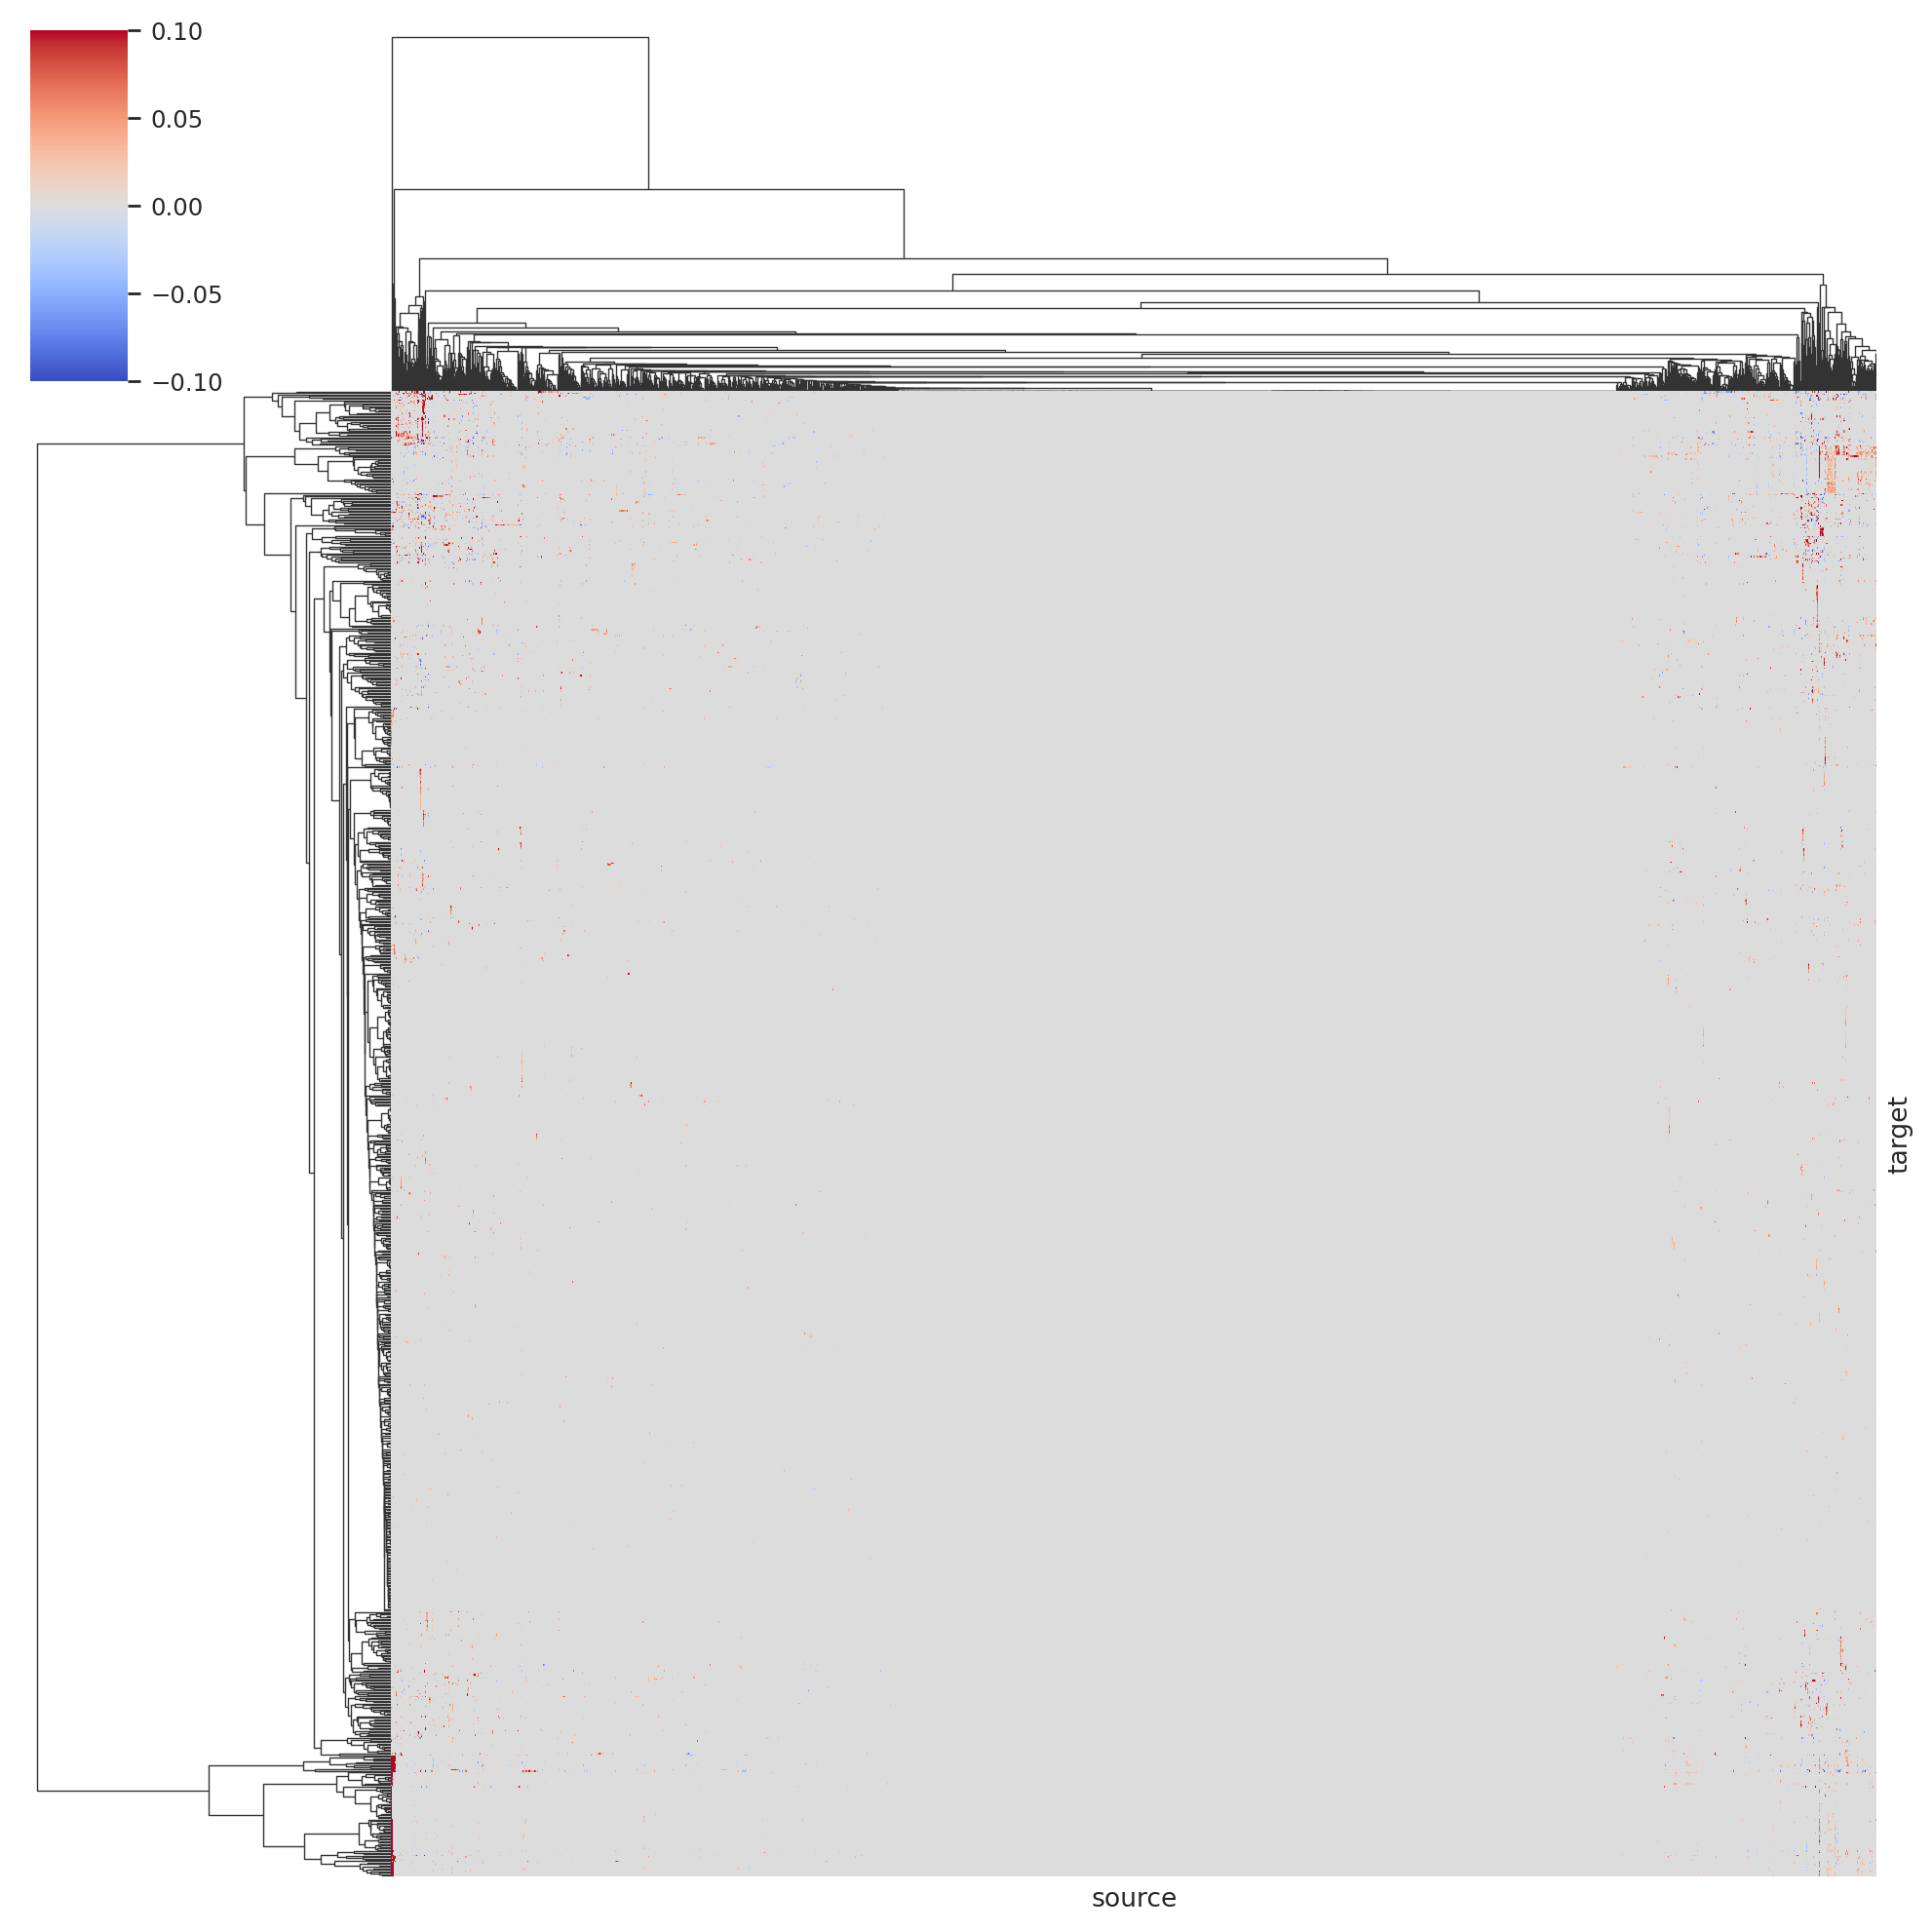

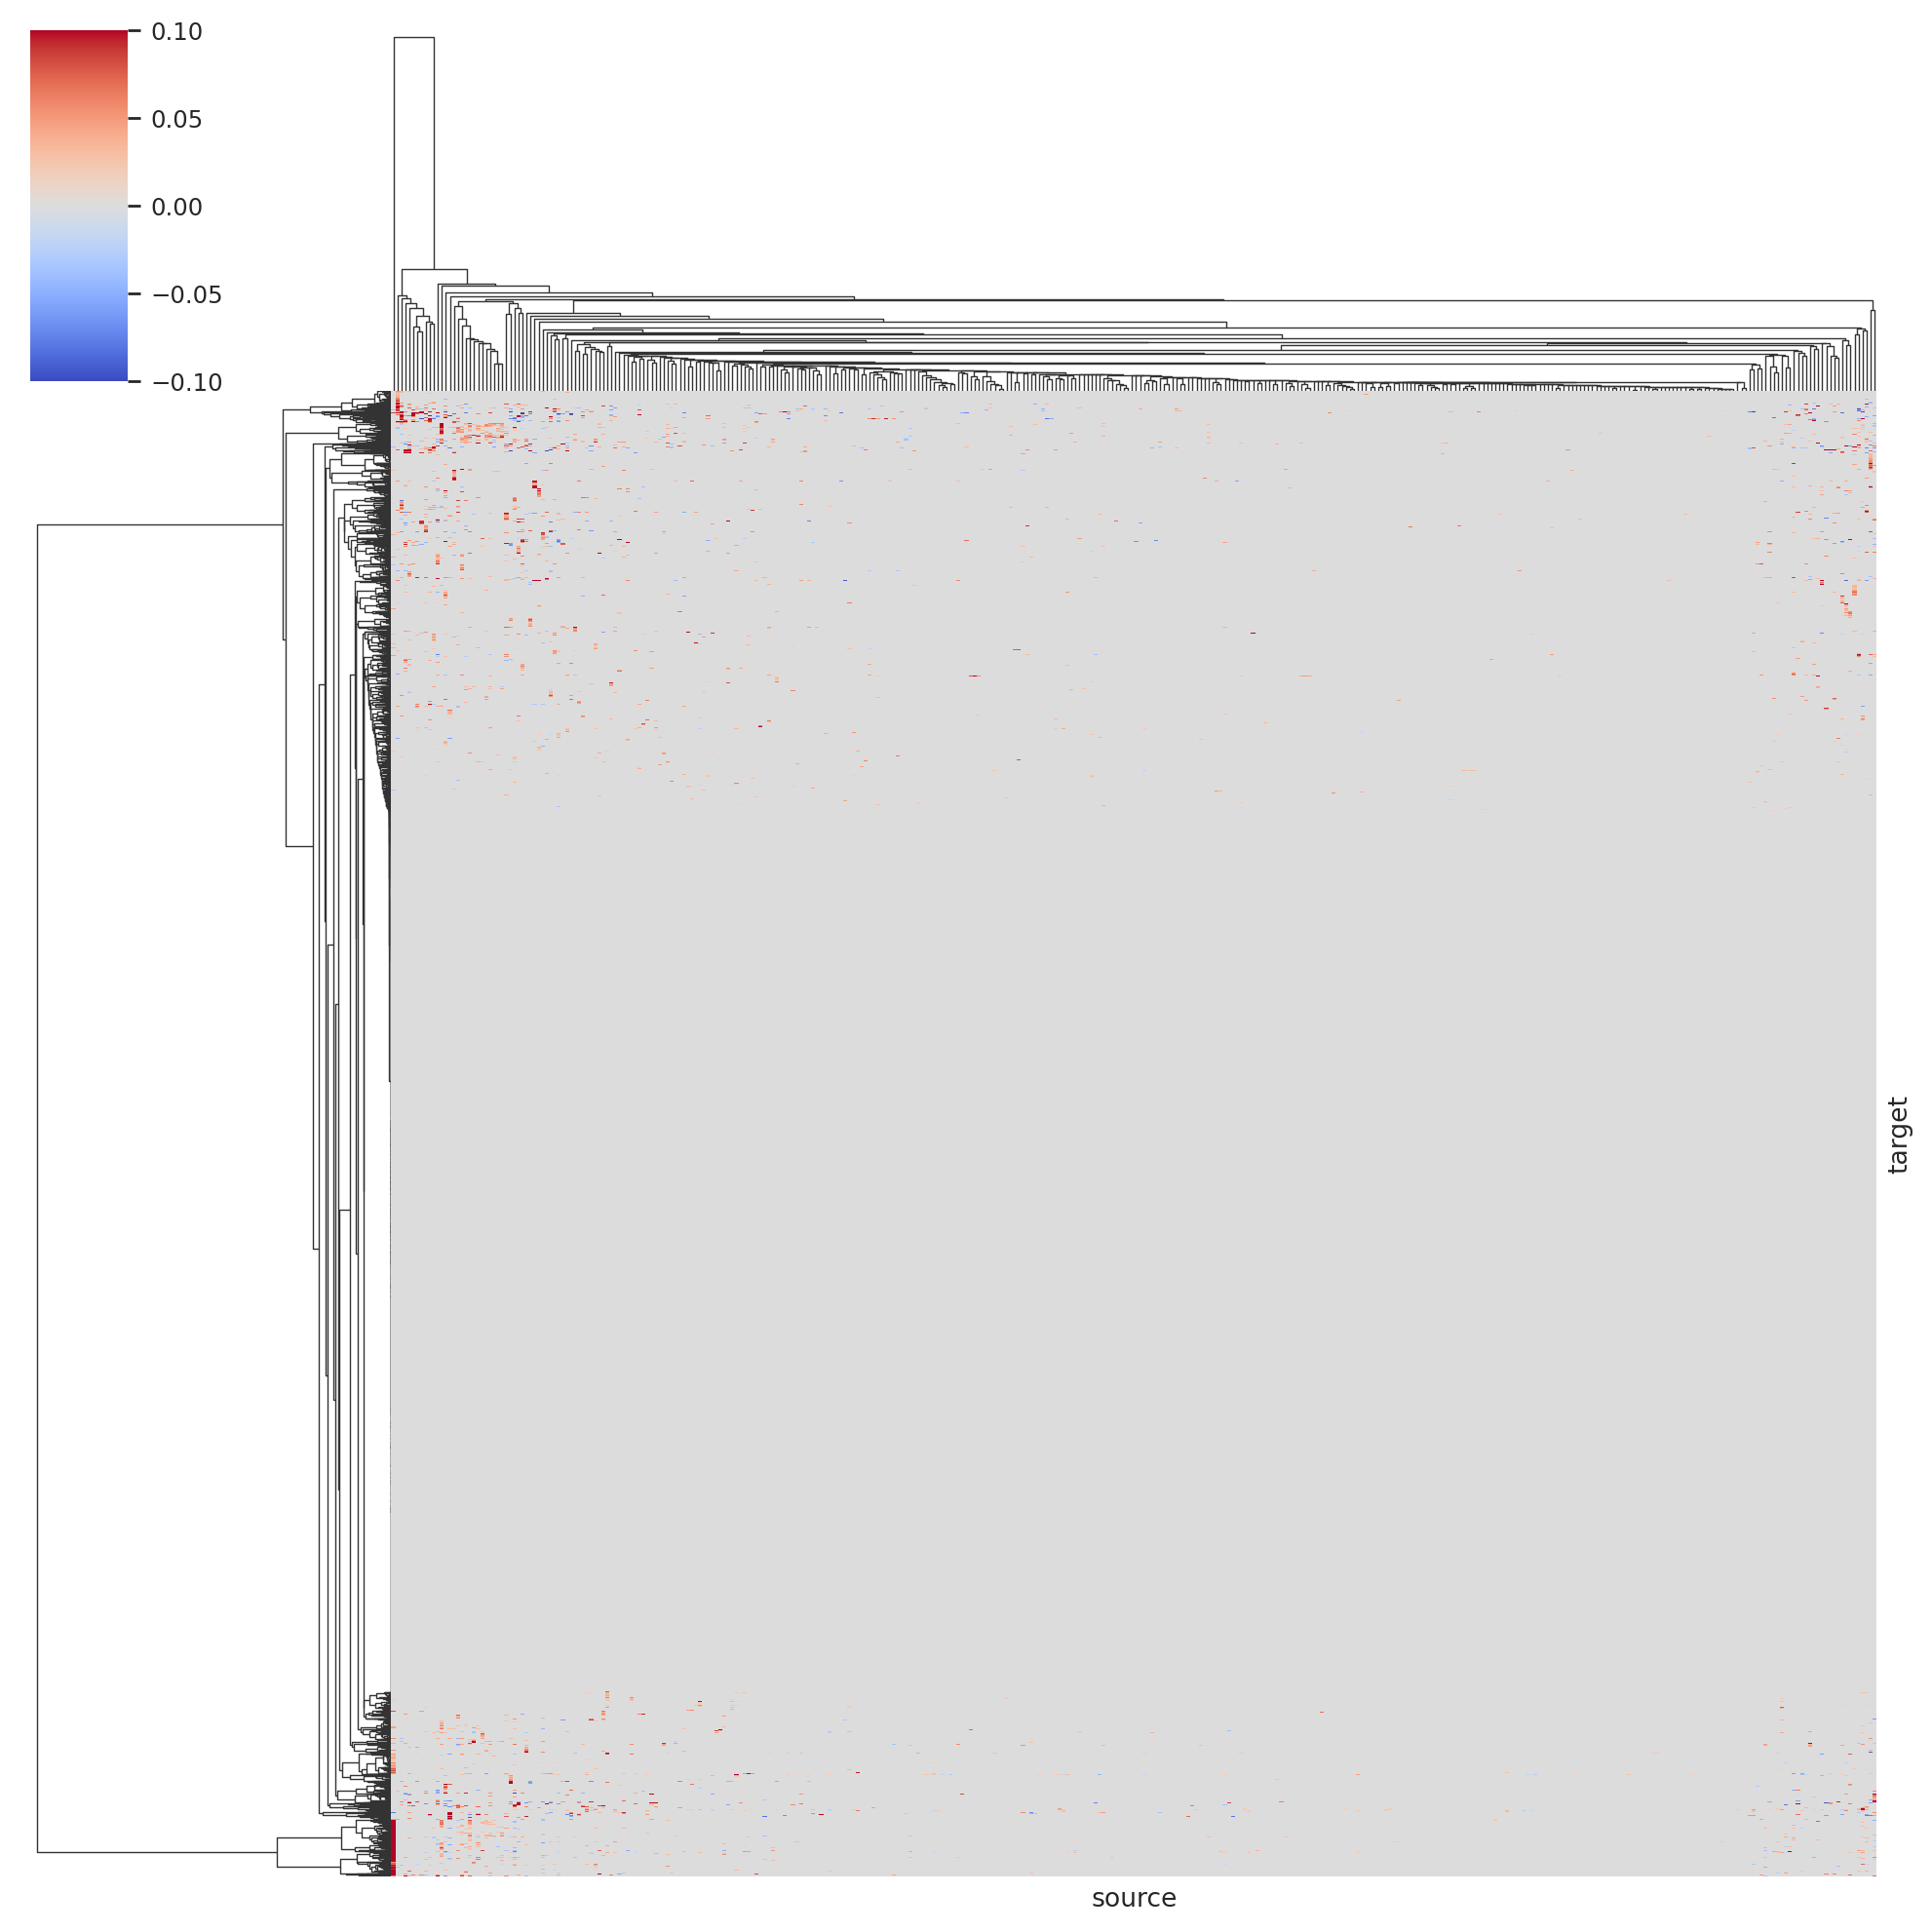

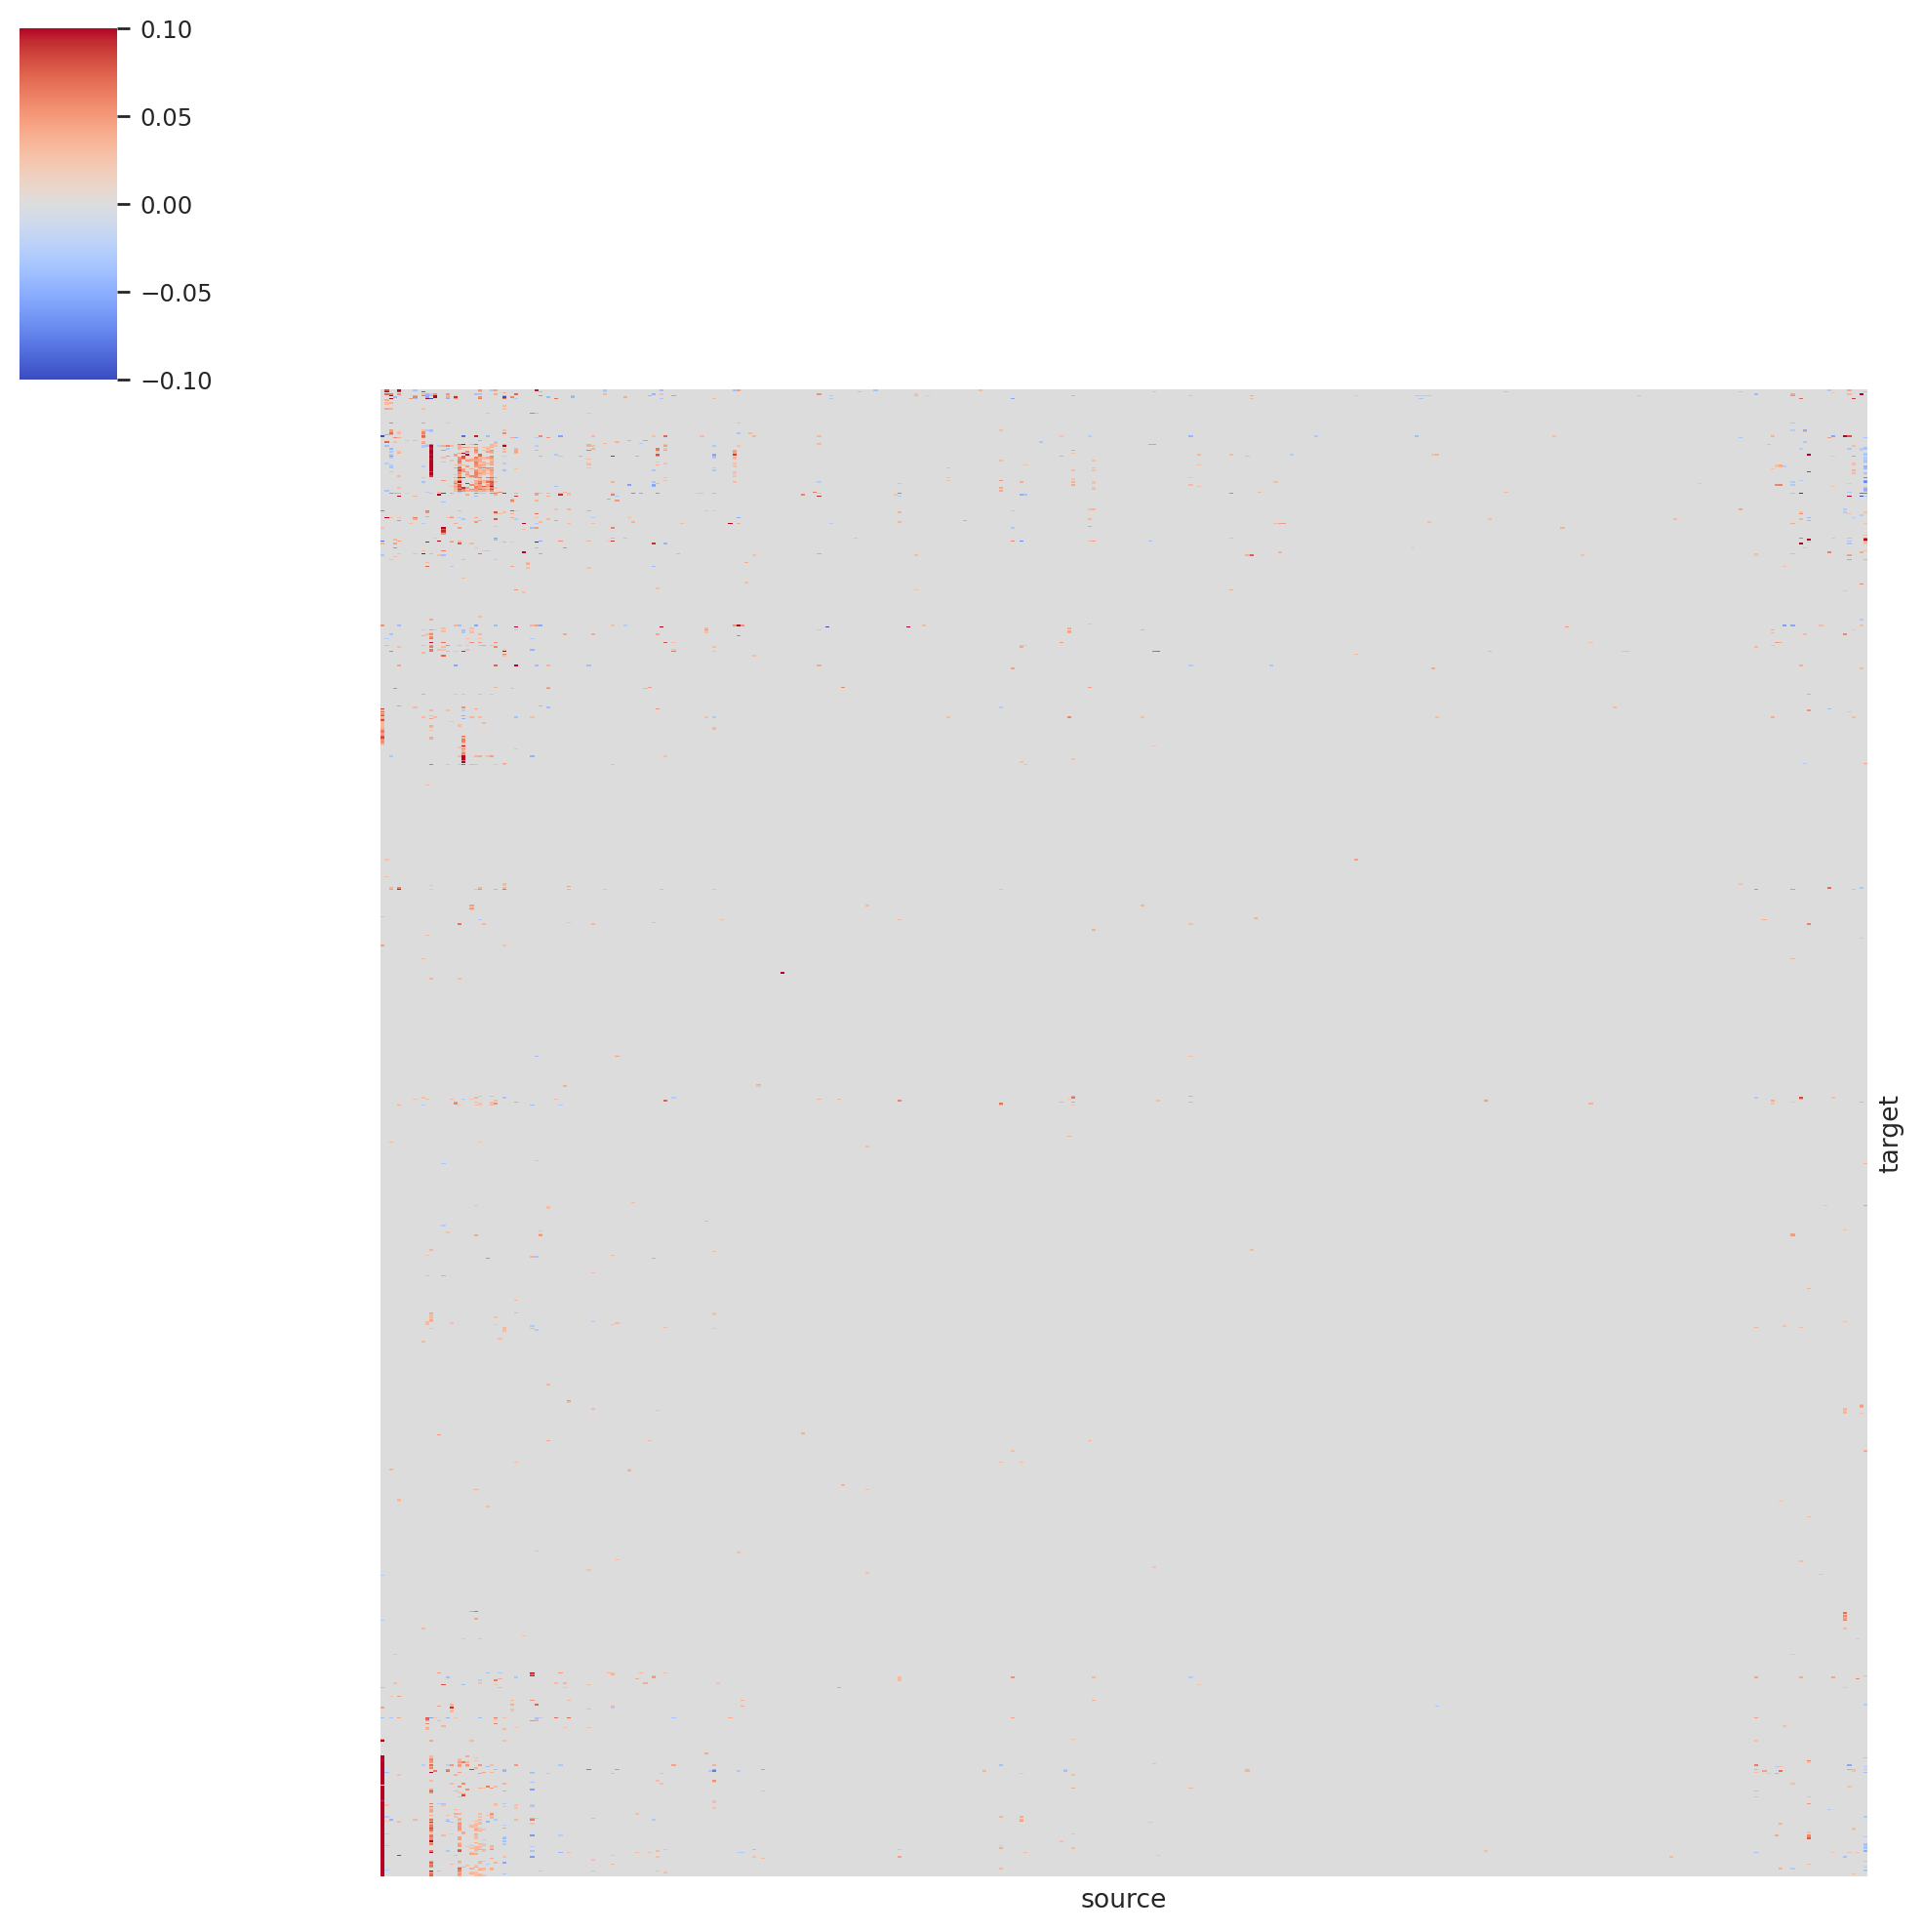

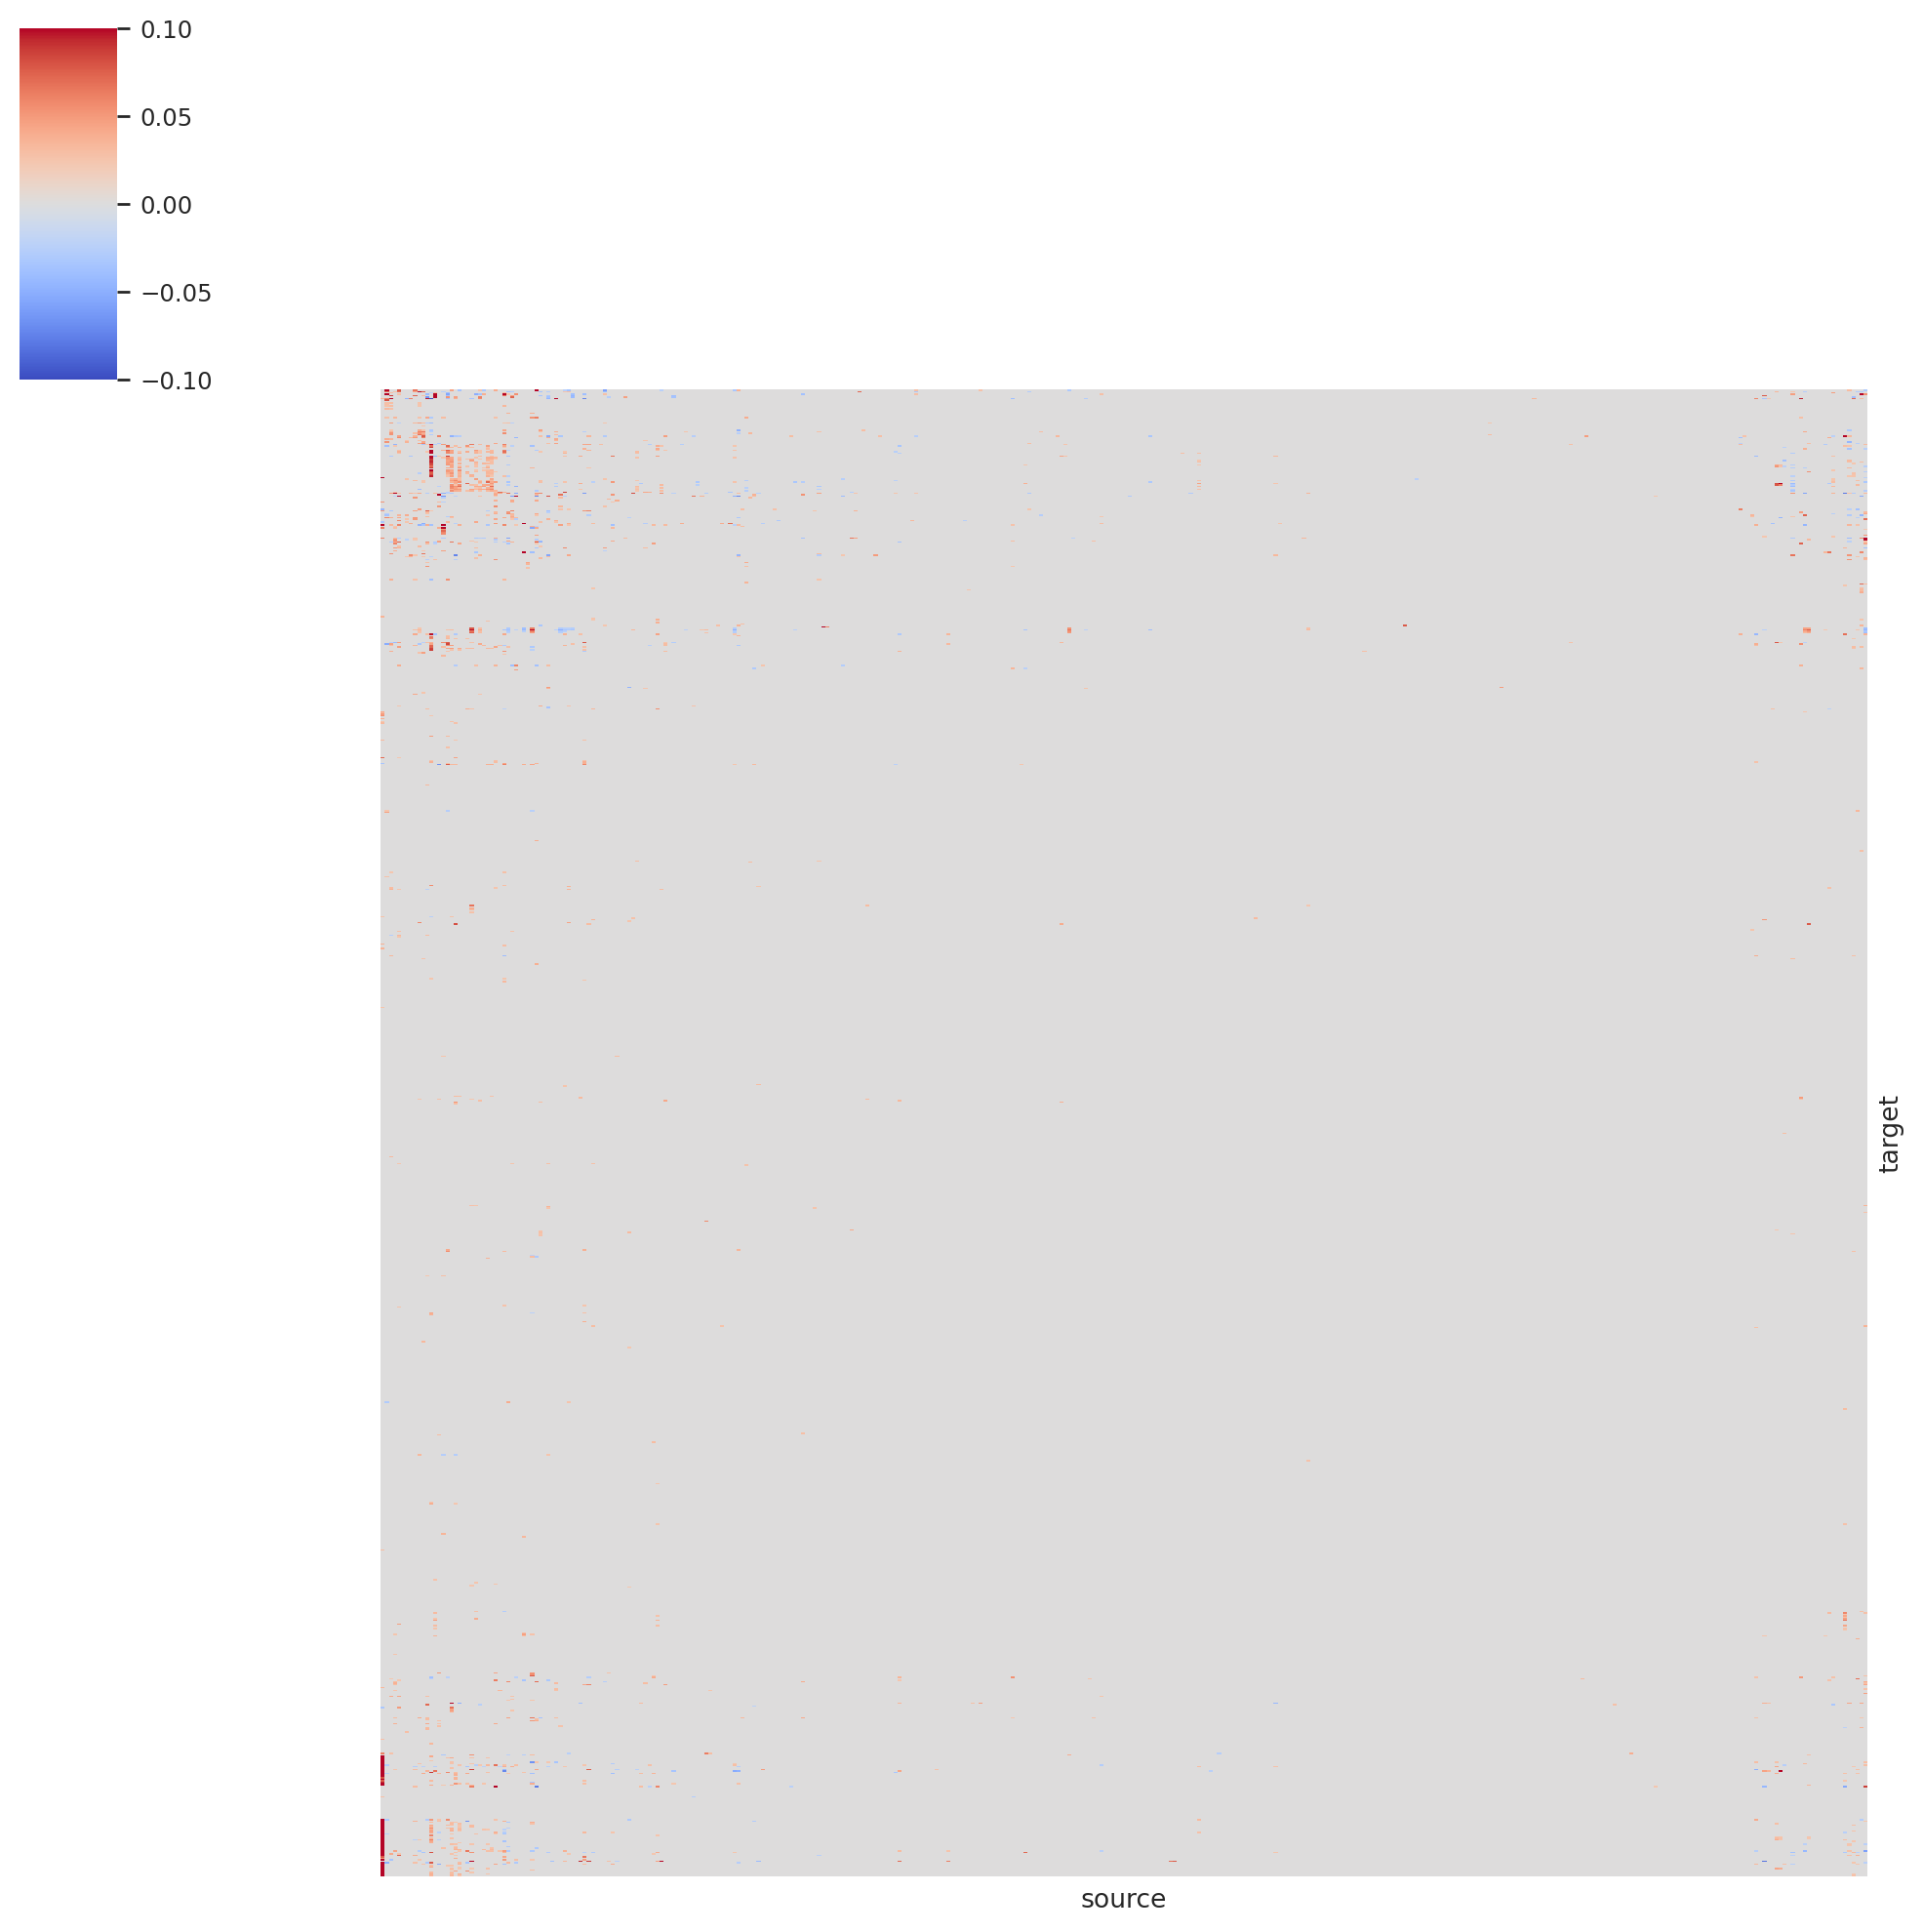

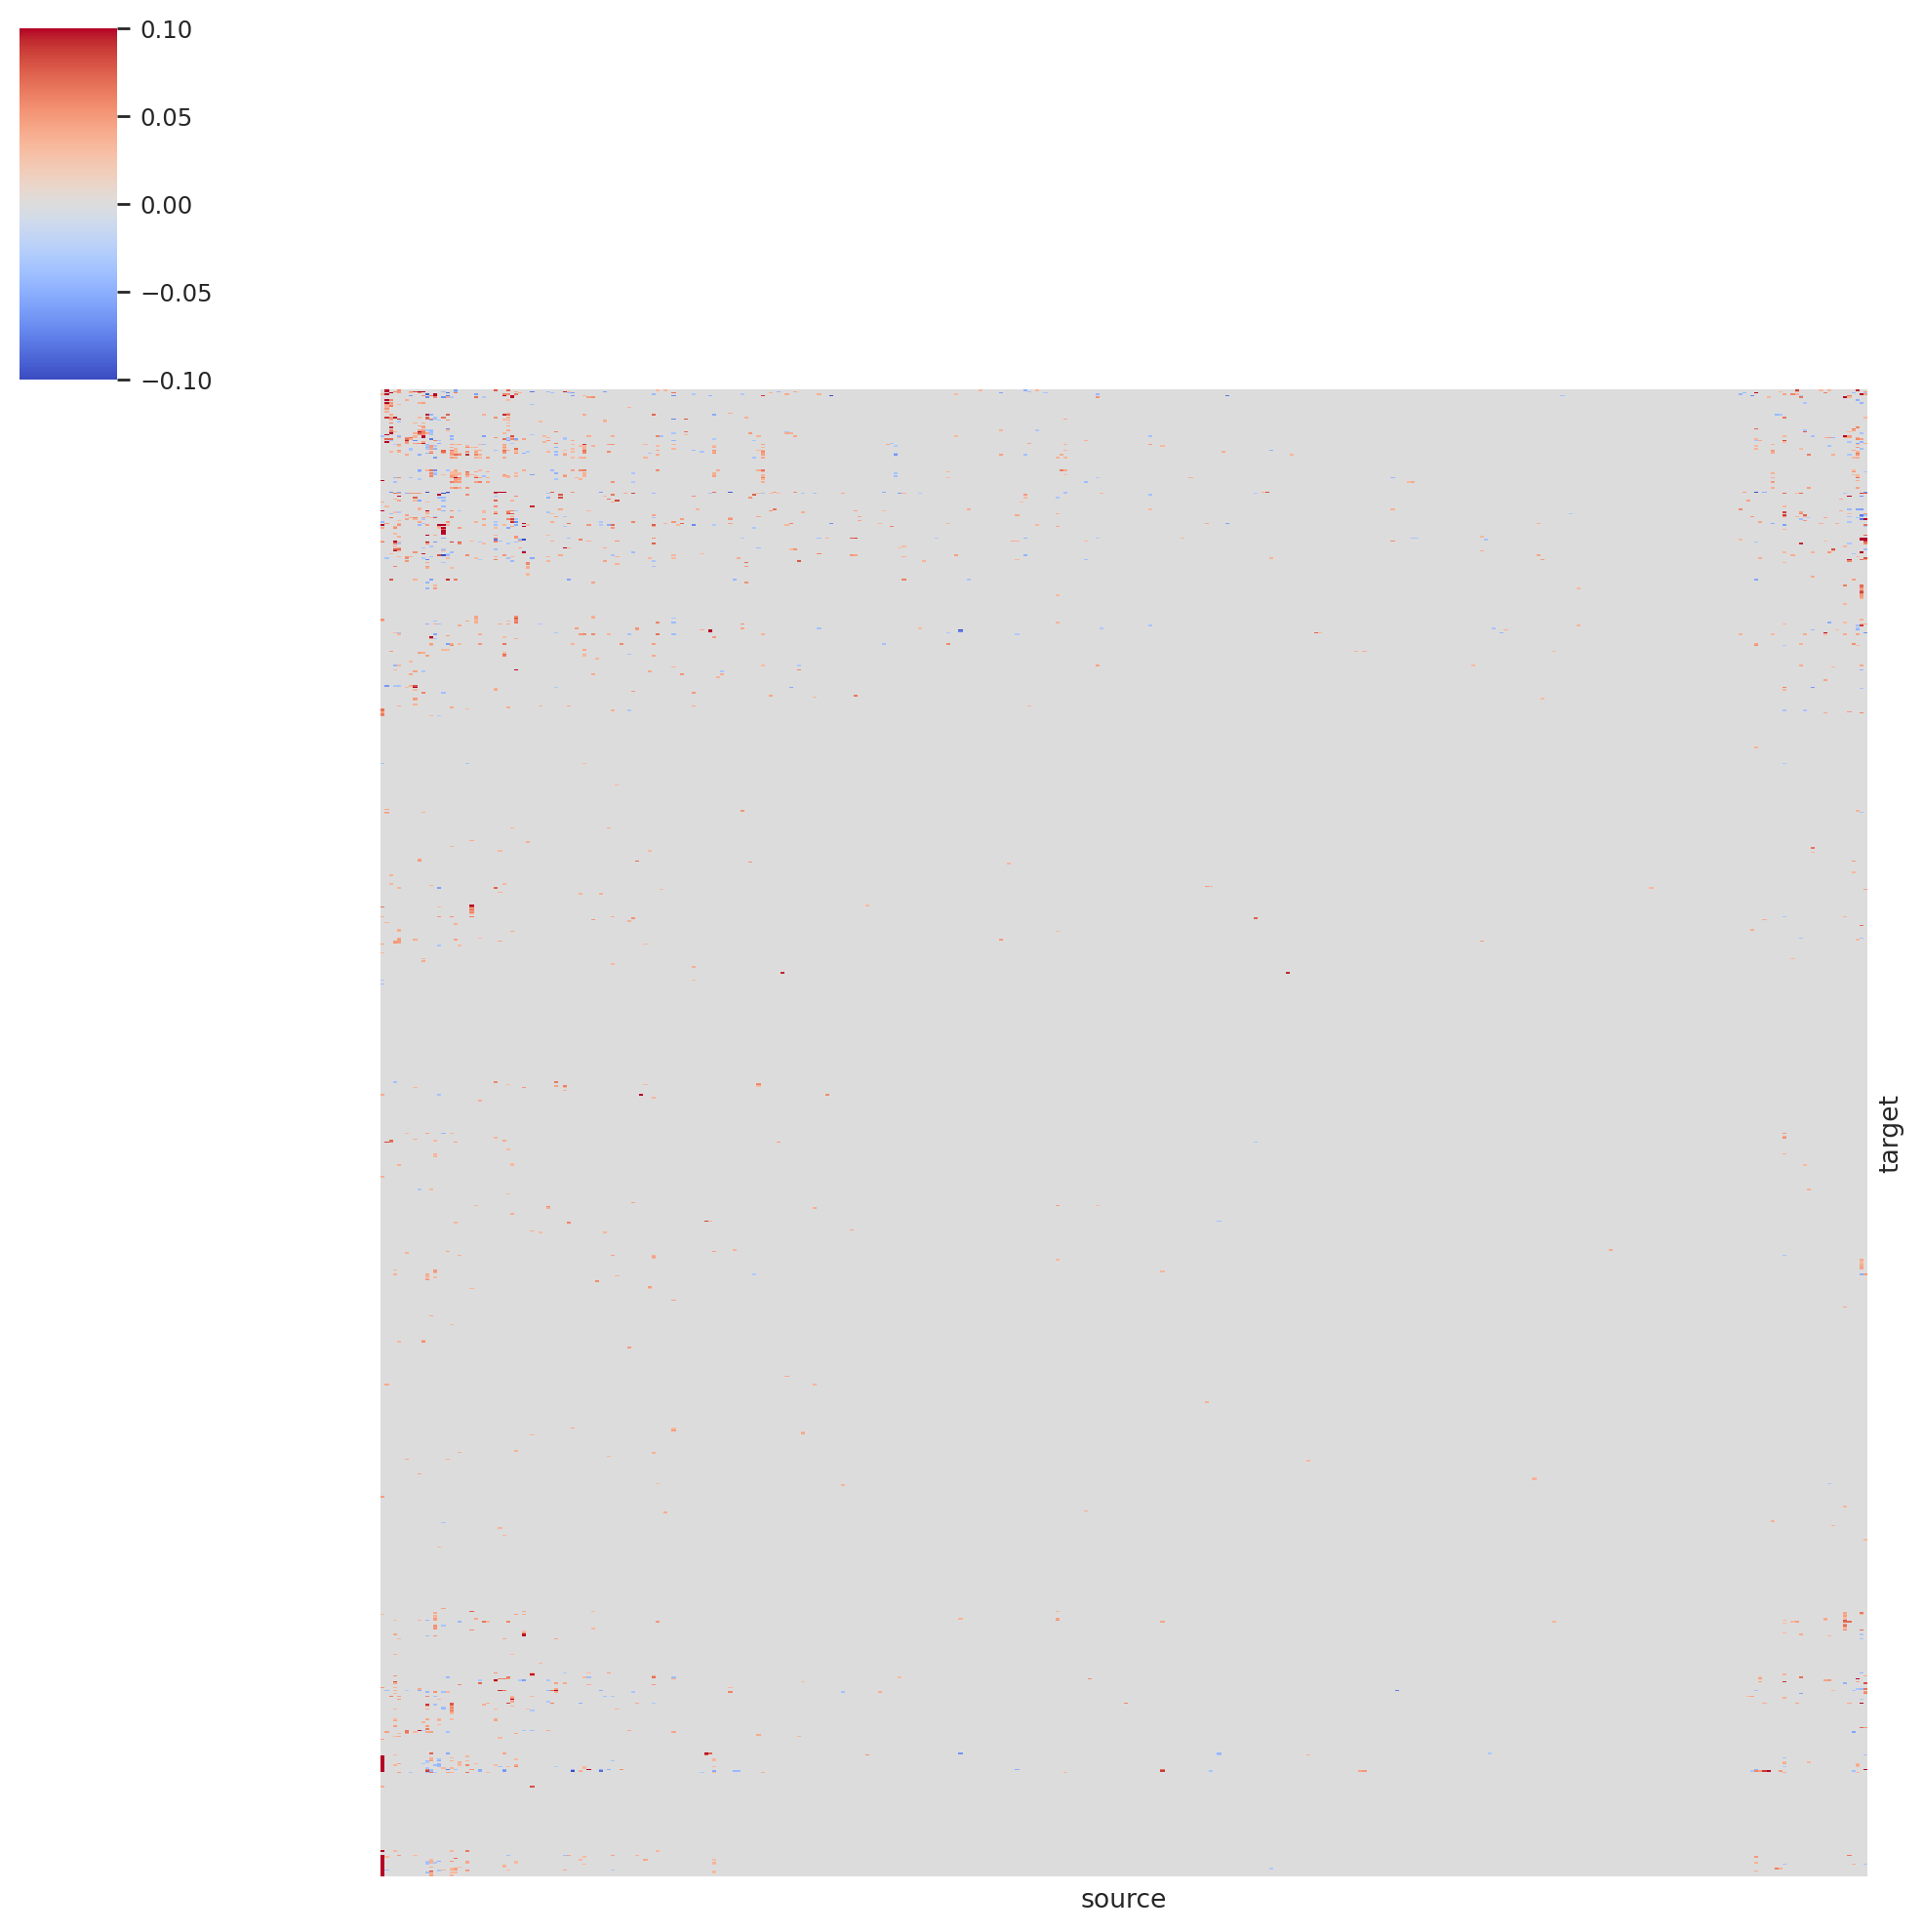

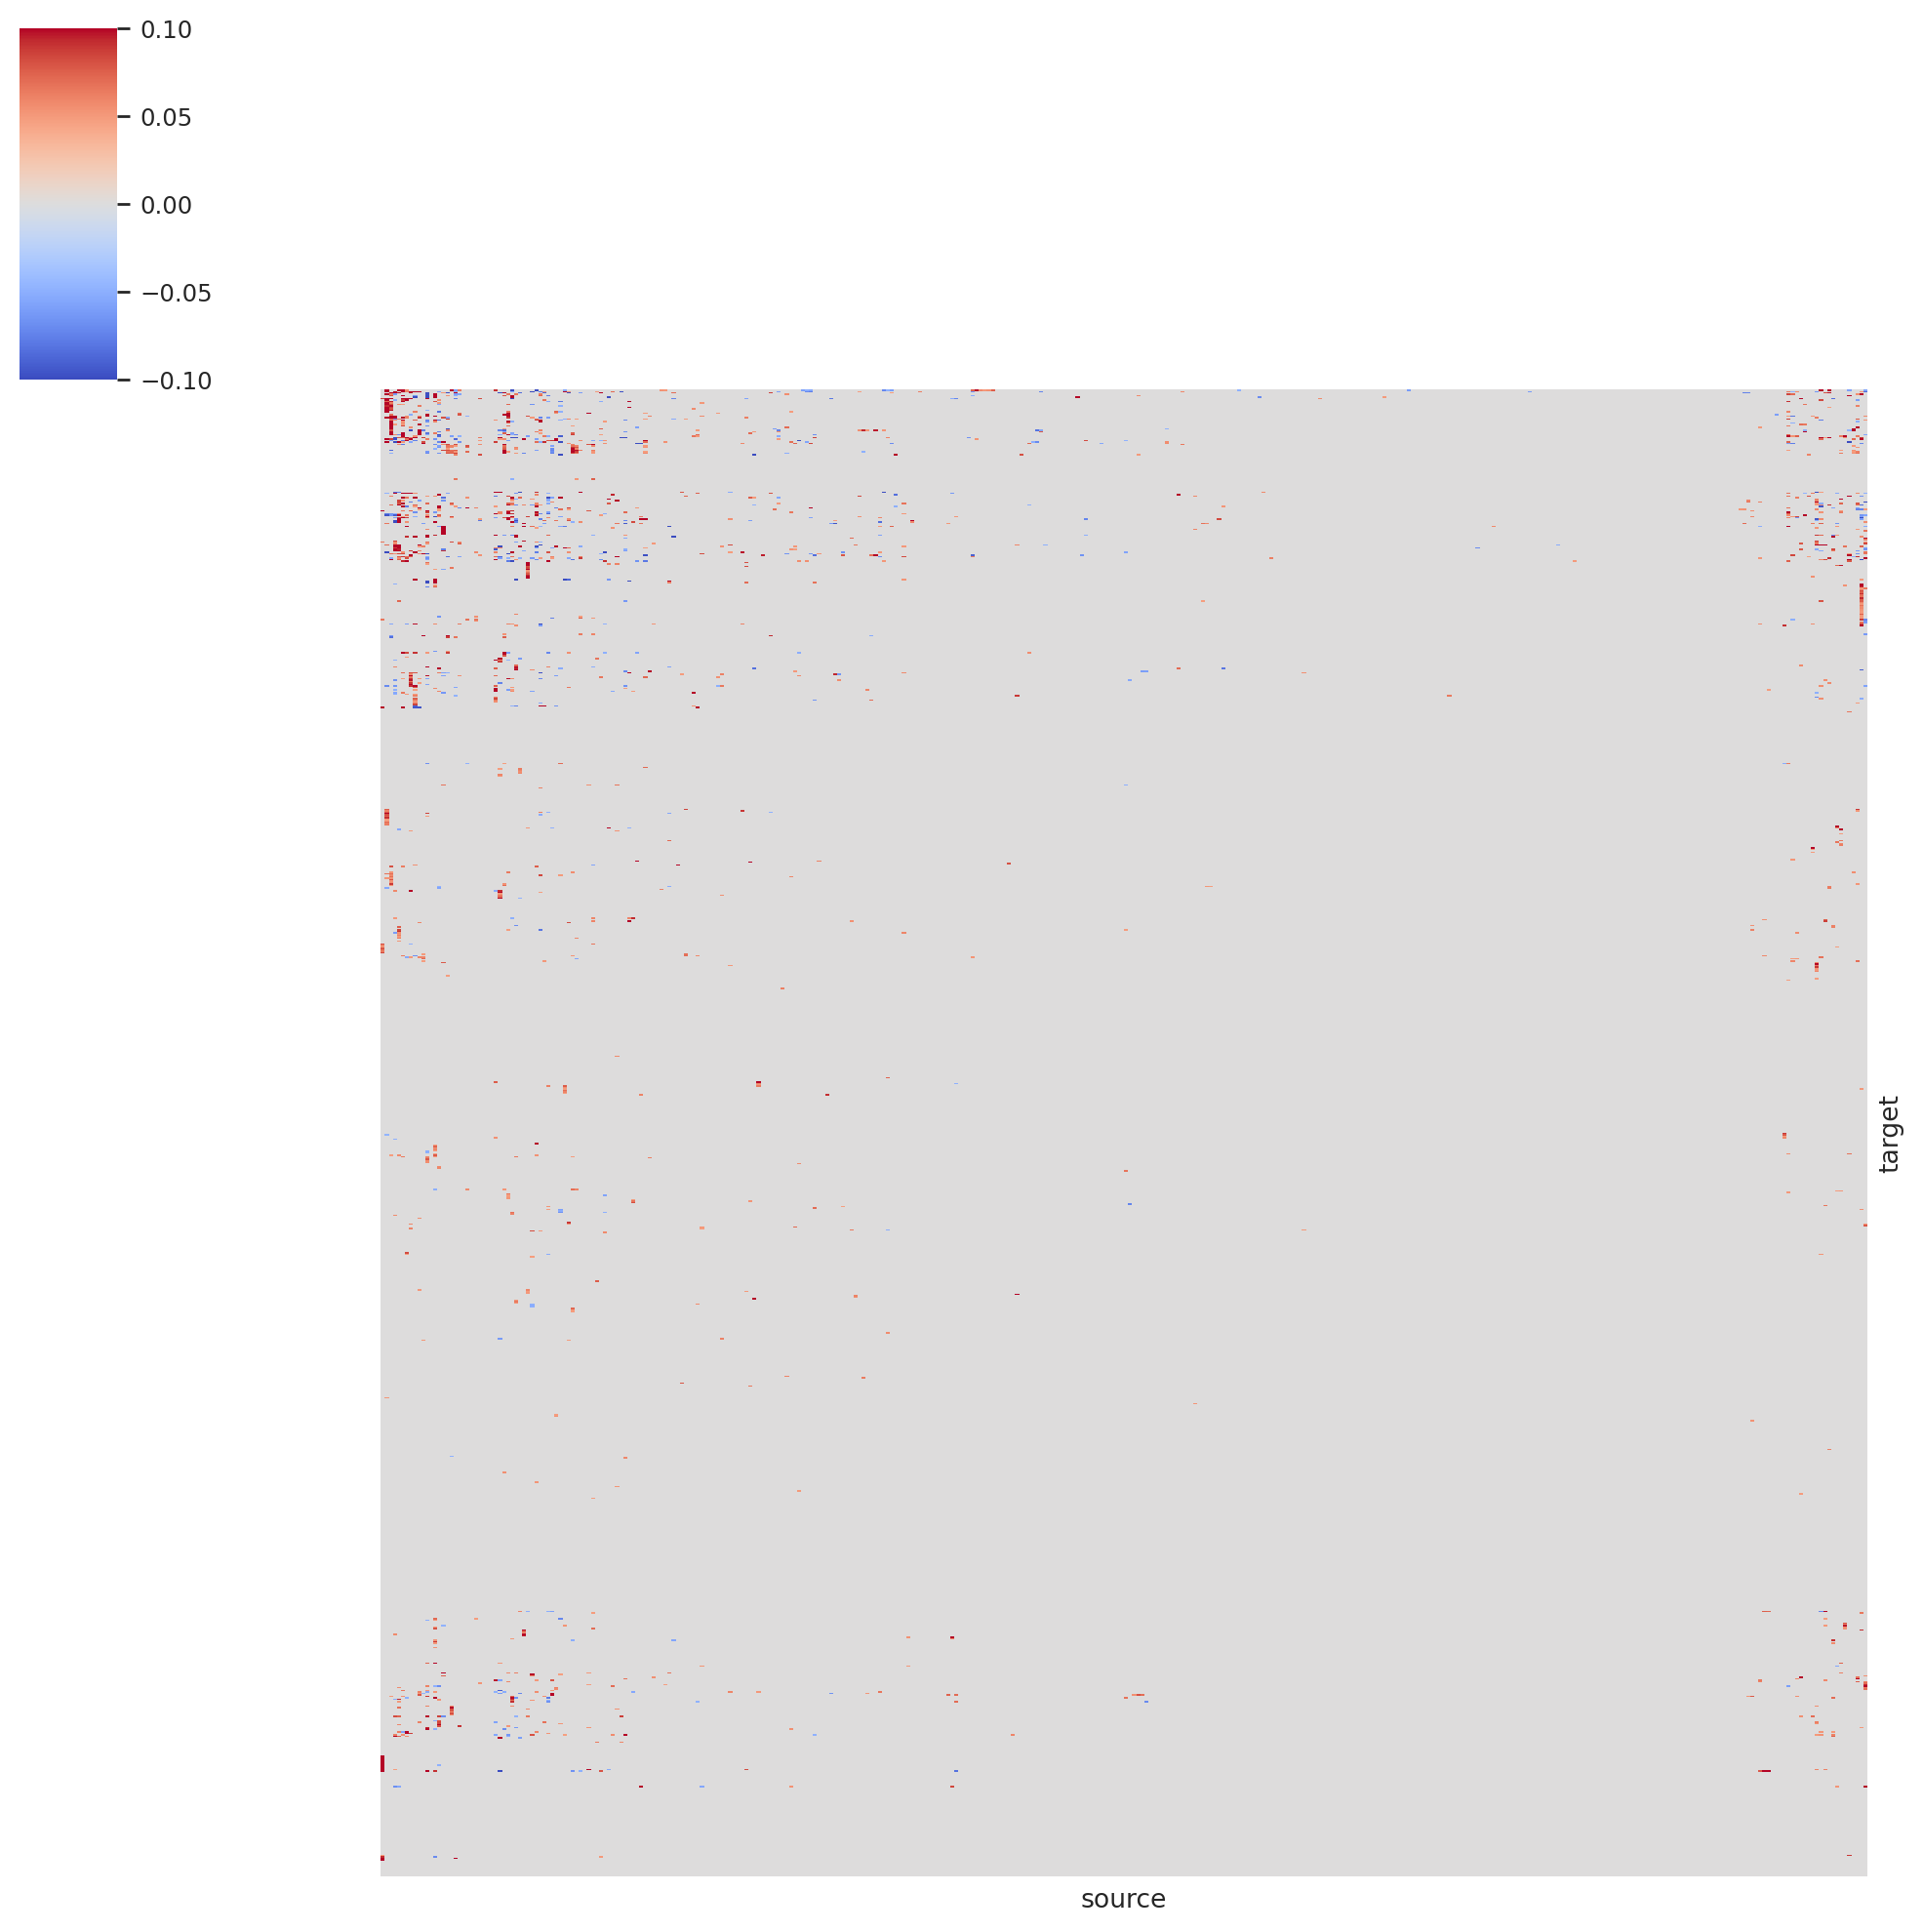

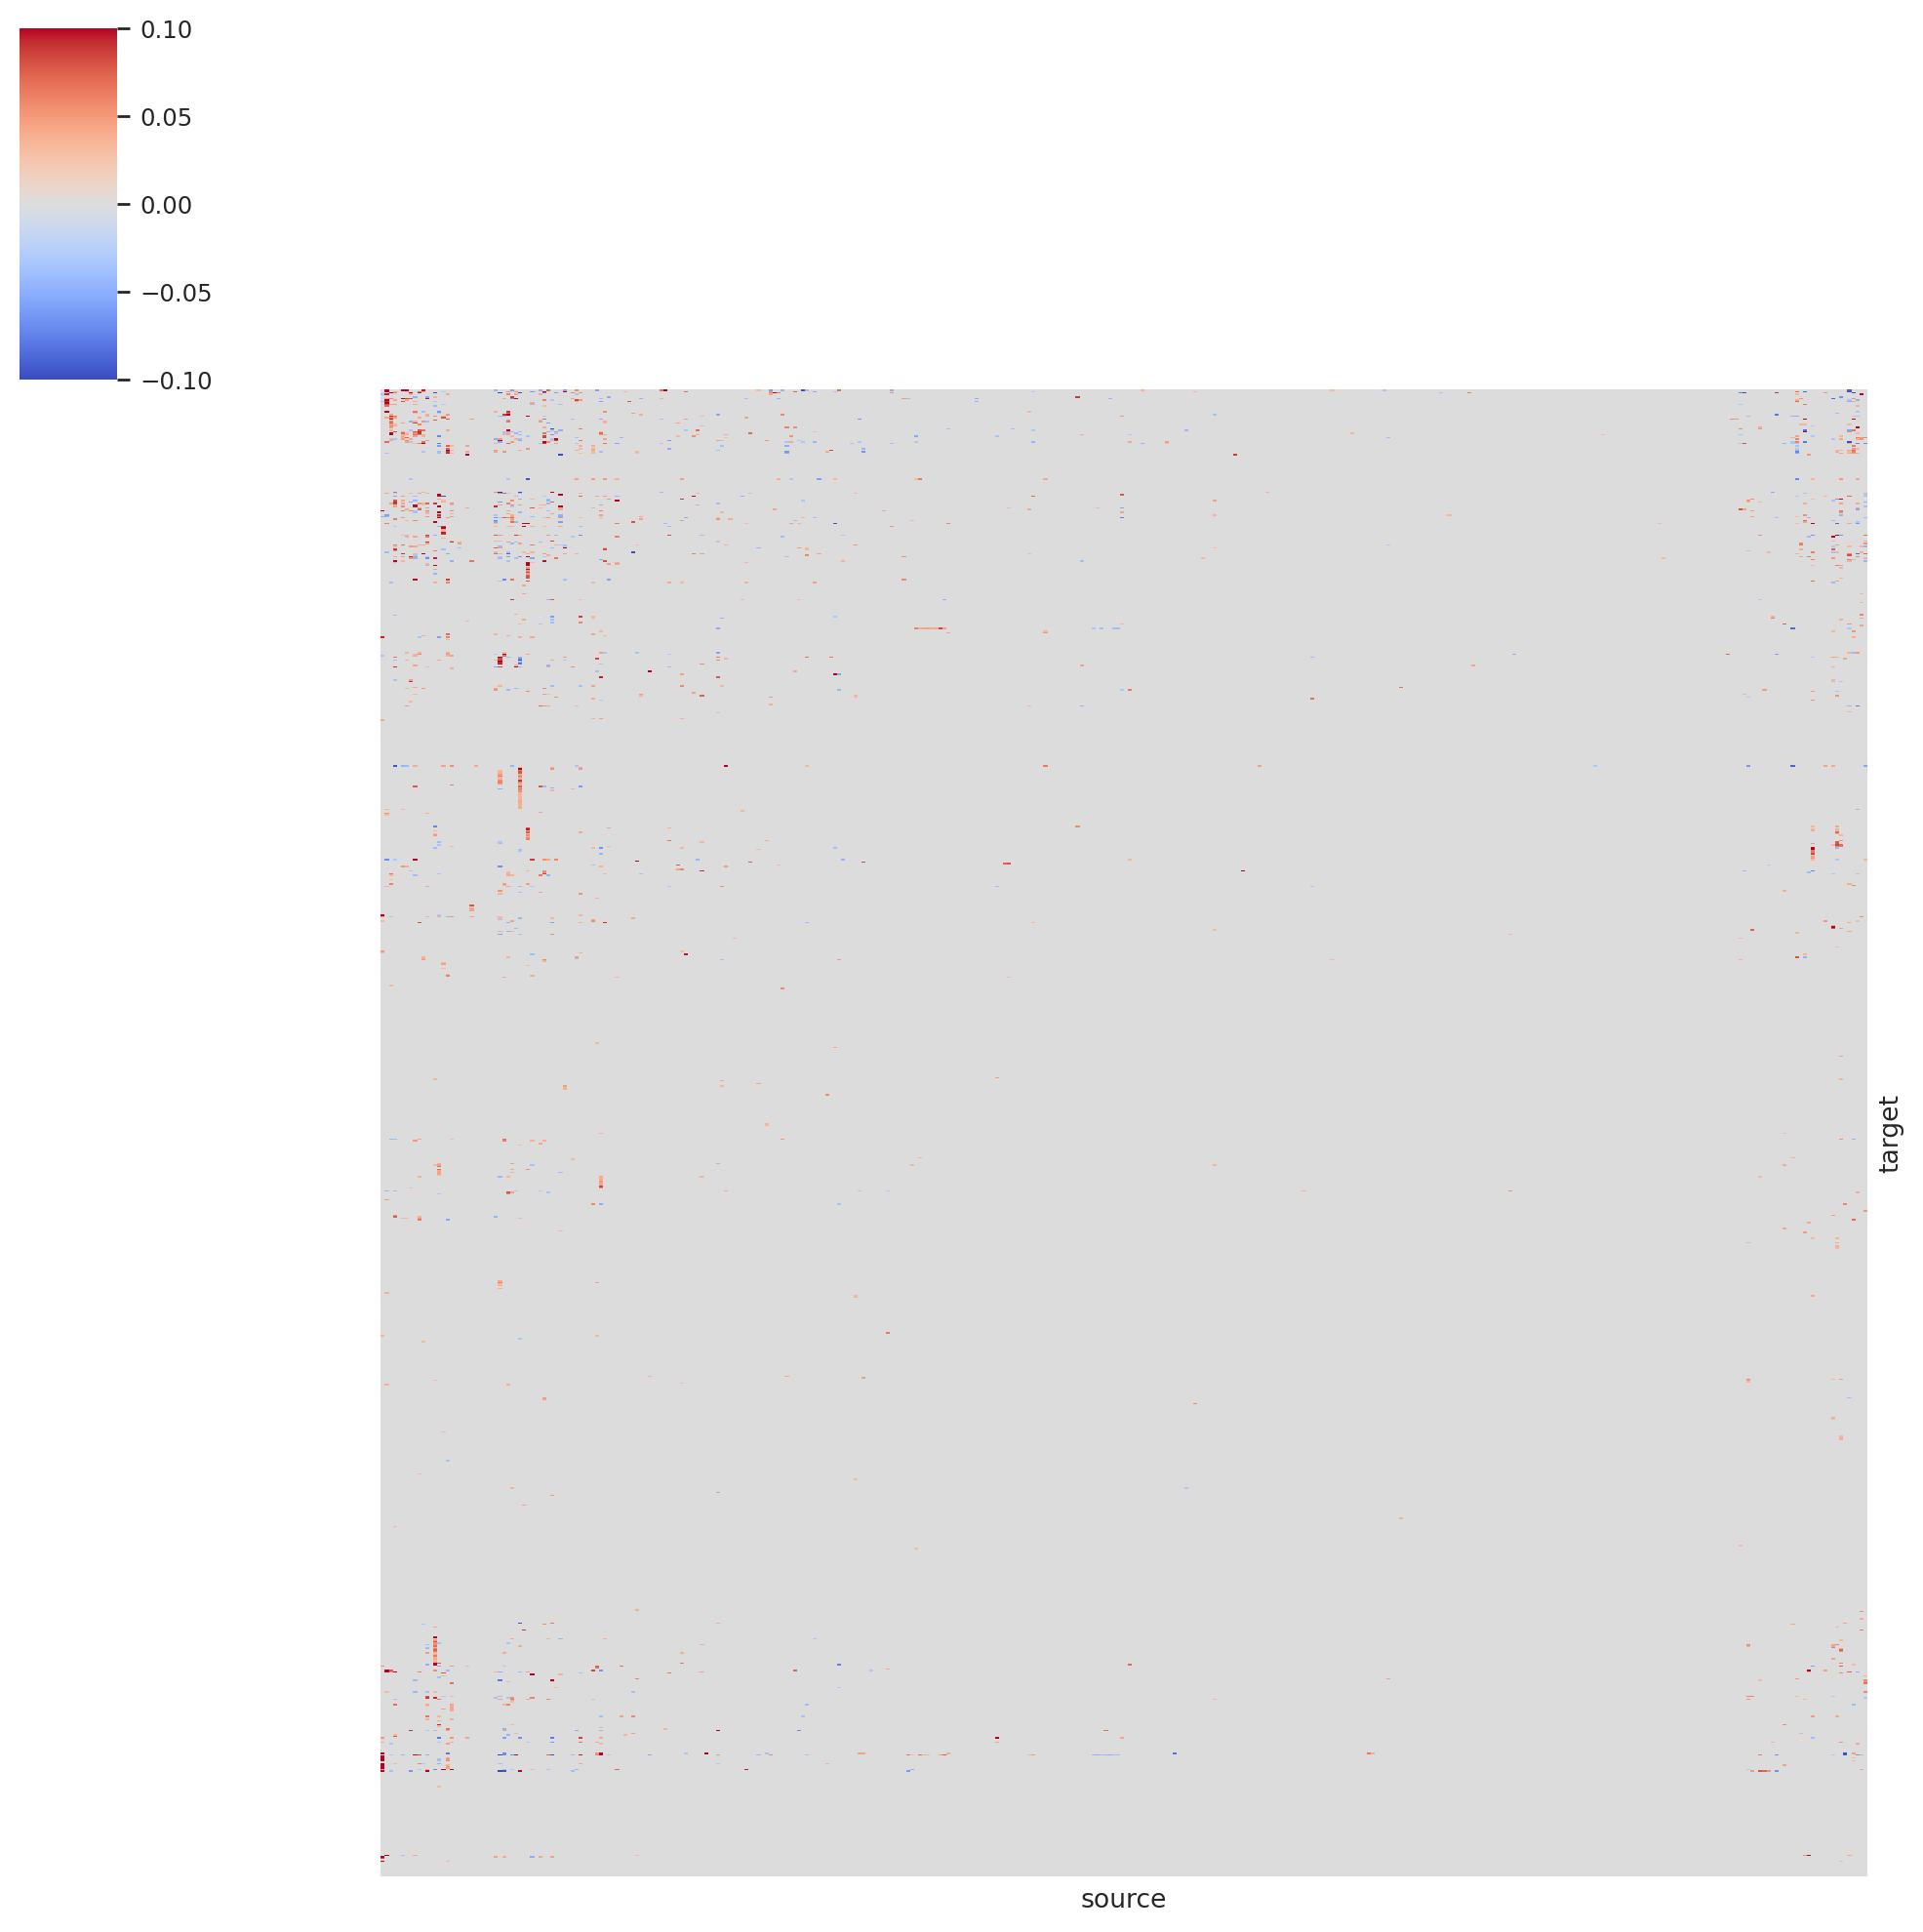

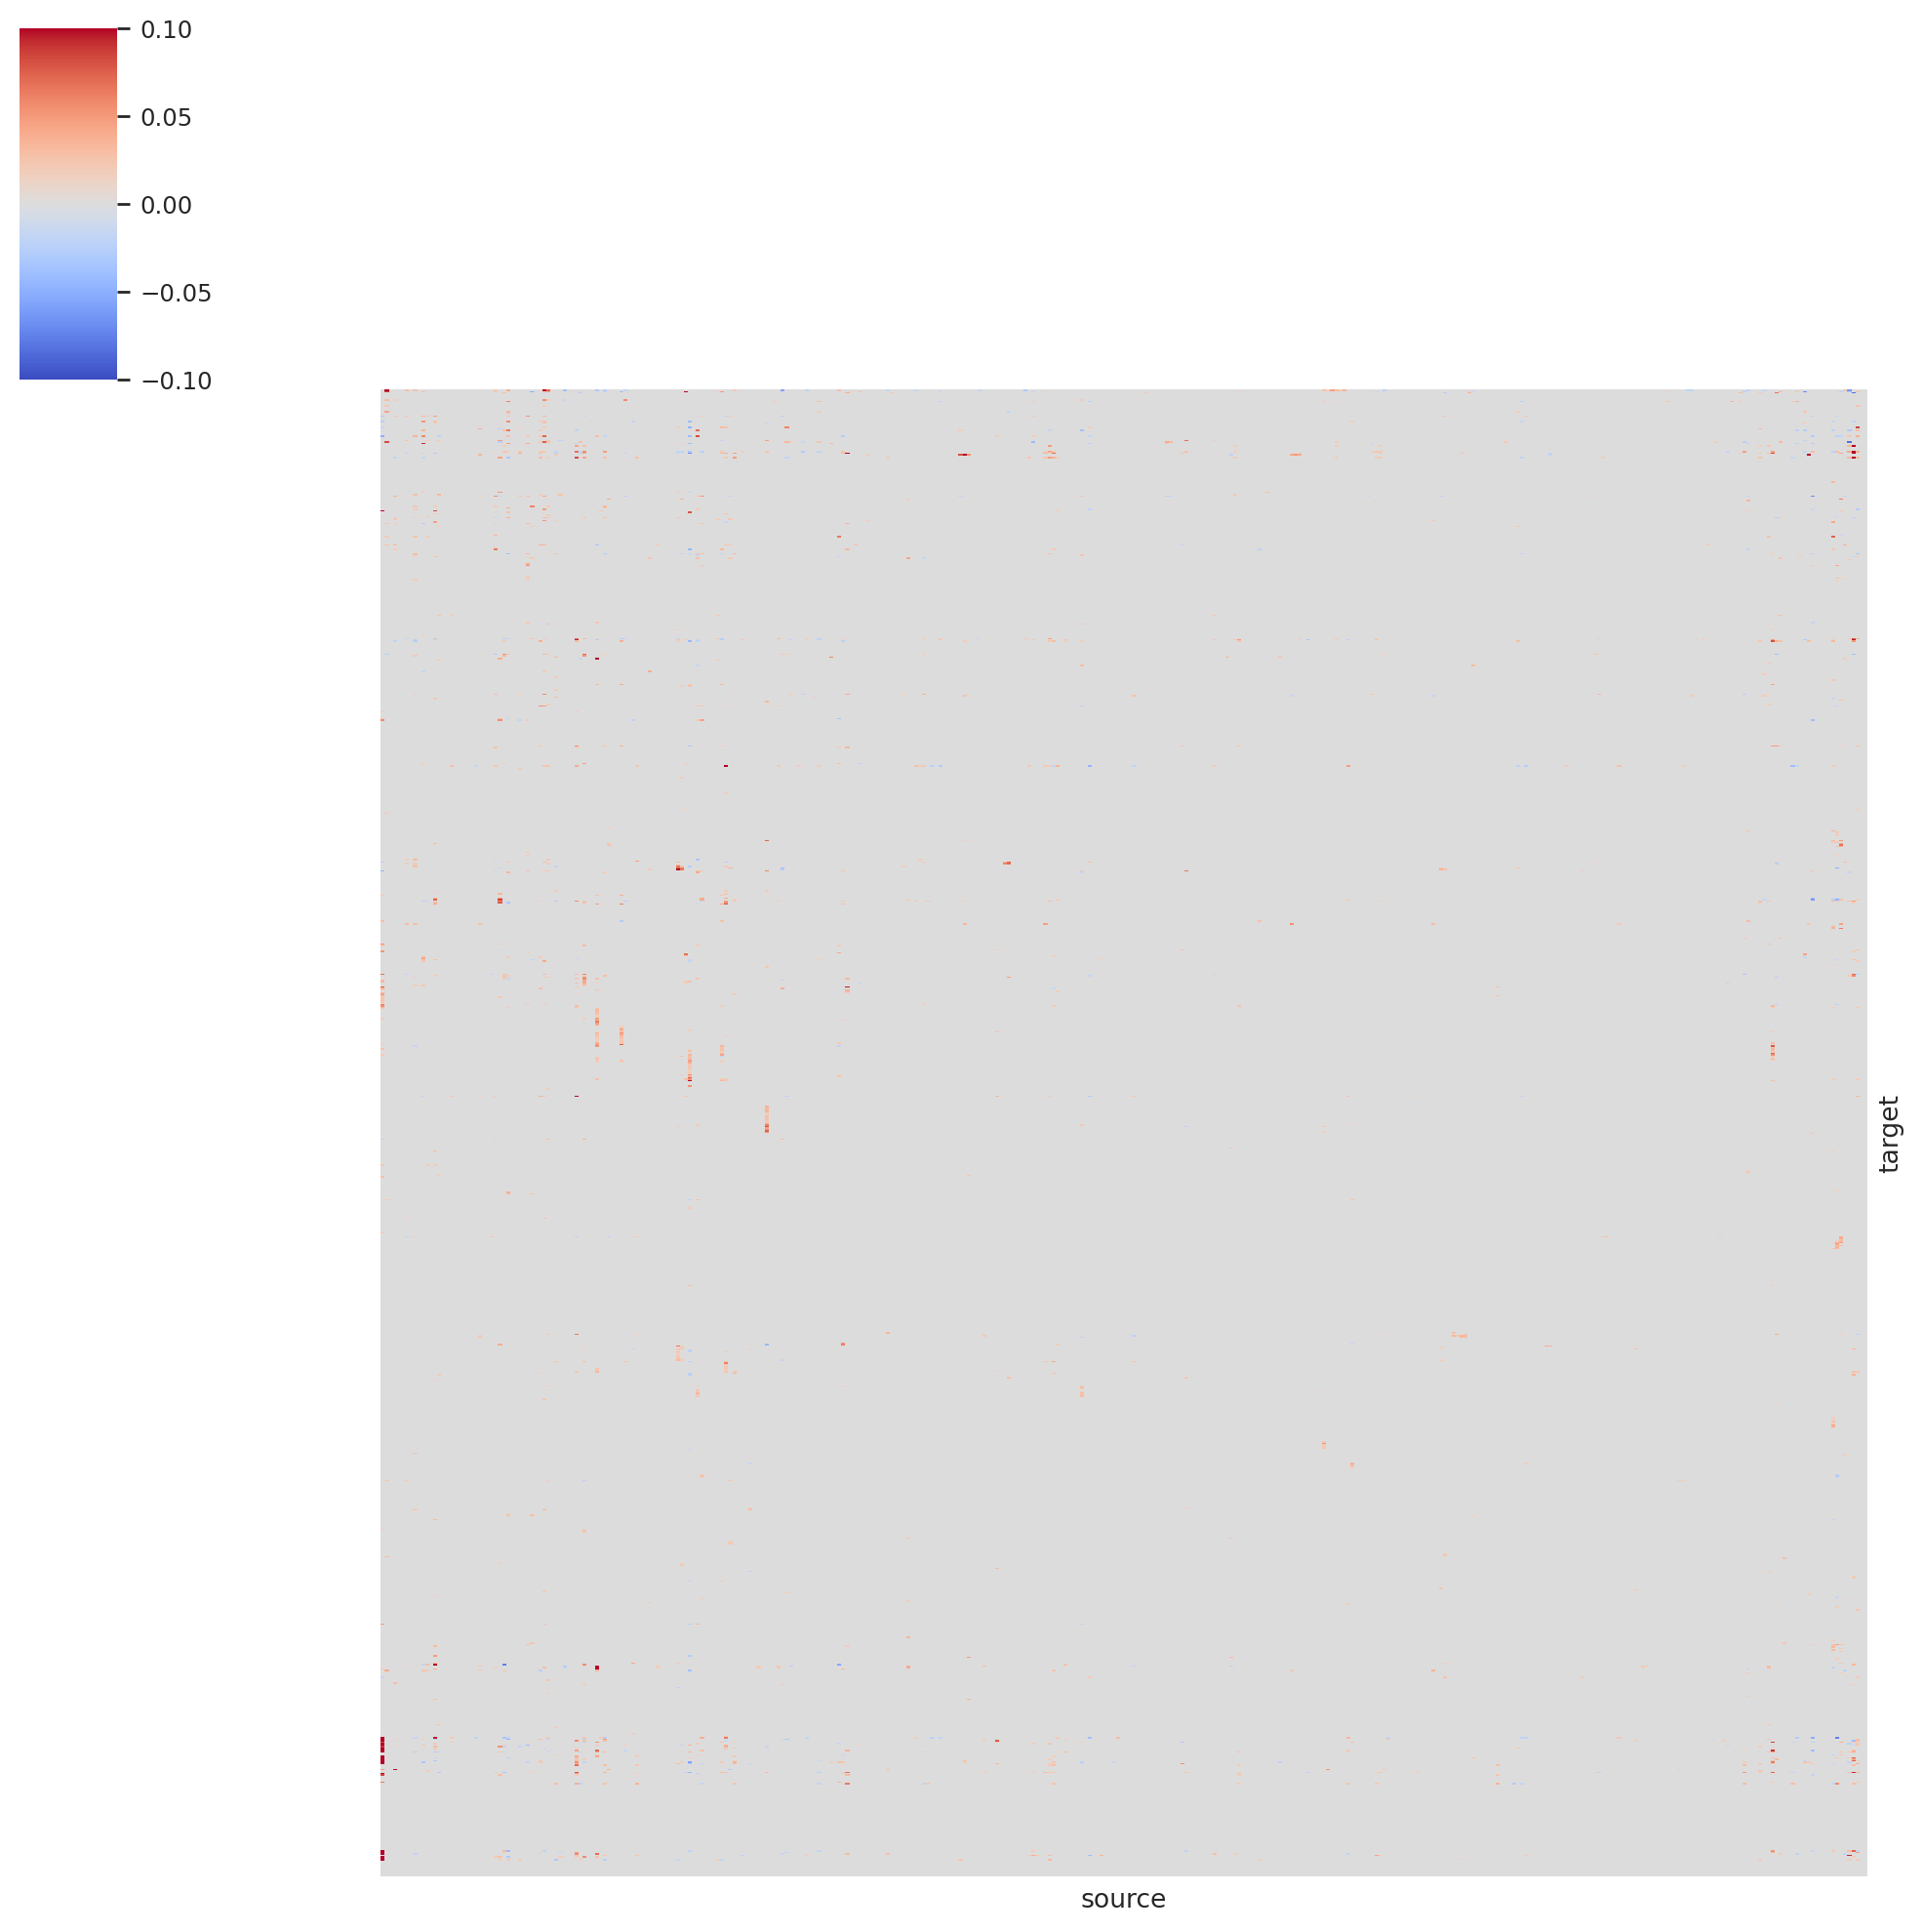

In [76]:
# For loop to plot the GRNs over timepoints
# Choose one celltype
celltype = "whole_embryo"

# for all the rest of the timepoints (0-30 somites)
timepoints = ["TDR126", "TDR127", "TDR128", "TDR118", "TDR125", "TDR124"]
# define the dev stages corresponding to the timepoints list (for dataset IDs)
stages = ["0somites", "5somites", "10somites","15somites","20somites","30somites"]
stages

# Step 1. collect all sources and targets across all timepoints
all_sources = set()
all_targets = set()

for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    all_sources.update(df['source'].unique())
    all_targets.update(df['target'].unique())
    
# Step 2: Recreate each df_counts DataFrame
df_counts_union = {}

for timepoint in timepoints:
    df = dict_filtered_GRNs[timepoint][celltype]
    # Pivot the original DataFrame
    df_pivot = df.pivot(index='target', columns='source', values='coef_mean').reindex(index=all_targets, columns=all_sources).fillna(0)
    df_counts_union[timepoint] = df_pivot
    
# # Assuming df_counts_union is your dictionary of adjusted count matrices
# timepoints = list(df_counts_union.keys())

# based on the histogram above, we'll define the vmax/vmin for color scale
# vmax = 0.15
# vmin = -0.15
vmax = 0.1
vmin = -0.1


# compute the linkages from the first and the last timepoints, by augmenting the "time" components
df_counts1 = df_counts_union["TDR126"]
df_counts2 = df_counts_union["TDR127"]
df_counts3 = df_counts_union["TDR128"]
df_counts4 = df_counts_union["TDR118"]
df_counts5 = df_counts_union["TDR125"]
df_counts6 = df_counts_union["TDR124"]

# concatenate over the columns
df_counts_rows = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=1)

# concatenate over the rows
df_counts_cols = pd.concat([df_counts1, df_counts2, df_counts3,
                            df_counts4, df_counts5, df_counts6], axis=0)

# create a clustered heatmap for the "rows"
g1 = sns.clustermap(df_counts_rows, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# create a clustered heatmap for the "cols"
g2 = sns.clustermap(df_counts_cols, method='ward', metric='euclidean', 
                    cmap='coolwarm', standard_scale=None,
                    row_cluster=True, col_cluster=True, 
                    xticklabels=False, yticklabels=False, 
                    vmax=vmax, vmin=vmin)

# extract the row/col indices
row_linkage = g1.dendrogram_row.linkage
col_linkage = g2.dendrogram_col.linkage

# Loop over all timepoints (using the pre-computed linkages from the first timepoint)
for idx, timepoint in enumerate(timepoints):
    # extract the df_counts at corresponding timepoint
    df_counts = df_counts_union[timepoint]
    
    # plot the clustermap
    g = sns.clustermap(df_counts, method='ward', metric='euclidean', 
                       cmap='coolwarm', standard_scale=None, 
                       row_cluster=True, col_cluster=True, 
                       xticklabels=False, yticklabels=False, 
                       vmax=vmax, vmin=vmin, 
                       row_linkage=row_linkage, col_linkage=col_linkage)
    
    # hide the dendrograms
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    
    # extract the dev stage
    stage=stages[idx]
    # save the plot
    g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_coolwarm.pdf") # celltype is defined above where we computed df_counts_union
    g.savefig(figpath + f"GRN_heatmap_{celltype}_{stage}_coolwarm.png")

# # Display all heatmaps side by side with consistent clustering
plt.show()

### Sectioning the left-top for "decreasing over time"

In [62]:
df_counts_union.keys()

dict_keys(['TDR126', 'TDR127', 'TDR128', 'TDR118', 'TDR125', 'TDR124'])

In [63]:
df_counts_union["TDR126"]

source           nkx1.2la  sp8b  tfap2d  foxc1a  uncx4.1  nr5a2  smad1  sox32  \
target                                                                          
draxin                0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
tenm4                 0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
tram1                 0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
efnb2b                0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
celf3a                0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
...                   ...   ...     ...     ...      ...    ...    ...    ...   
metap2b               0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
lpp                   0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
cyt1                  0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
celf5a                0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   
si:dkey-67c22.2       0.0   0.0     0.0     0.0      0.0    0.0    0.0    0.0   

source           gfi1ab  barhl1b  ...  gata4  hoxc3a  pax2a  hoxa9a  hoxd9a  \
target                            ...                                         
draxin              0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
tenm4               0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
tram1               0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
efnb2b              0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
celf3a              0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
...                 ...      ...  ...    ...     ...    ...     ...     ...   
metap2b             0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
lpp                 0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
cyt1                0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
celf5a              0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   
si:dkey-67c22.2     0.0      0.0  ...    0.0     0.0    0.0     0.0     0.0   

source           pdx1  nfixa  alx4b  vax1      gbx1  
target                                               
draxin            0.0    0.0    0.0   0.0  0.000000  
tenm4             0.0    0.0    0.0   0.0 -0.036503  
tram1             0.0    0.0    0.0   0.0  0.000000  
efnb2b            0.0    0.0    0.0   0.0  0.000000  
celf3a            0.0    0.0    0.0   0.0  0.000000  
...               ...    ...    ...   ...       ...  
metap2b           0.0    0.0    0.0   0.0  0.000000  
lpp               0.0    0.0    0.0   0.0  0.000000  
cyt1              0.0    0.0    0.0   0.0  0.000000  
celf5a            0.0    0.0    0.0   0.0  0.000000  
si:dkey-67c22.2   0.0    0.0    0.0   0.0  0.000000  

[1036 rows x 368 columns]

In [89]:
print(dict_merged_score["TDR126"].sort_values("degree_centrality_all", ascending=False).head(10).index)
print(dict_merged_score["TDR127"].sort_values("degree_centrality_all", ascending=False).head(10).index)
print(dict_merged_score["TDR128"].sort_values("degree_centrality_all", ascending=False).head(10).index)
print(dict_merged_score["TDR118"].sort_values("degree_centrality_all", ascending=False).head(10).index)
print(dict_merged_score["TDR125"].sort_values("degree_centrality_all", ascending=False).head(10).index)
print(dict_merged_score["TDR124"].sort_values("degree_centrality_all", ascending=False).head(10).index)

Index(['hmga1a', 'sox19a', 'vox', 'irx7', 'dlx3b', 'sox11a', 'ctcf', 'rx3',
       'rarga', 'raraa'],
      dtype='object')
Index(['hmga1a', 'sox19a', 'meox1', 'sox3', 'sox11a', 'rarga', 'vox', 'irx1b',
       'hoxc3a', 'xbp1'],
      dtype='object')
Index(['hmga1a', 'sox5', 'tfap2c', 'meox1', 'nr2f5', 'rxraa', 'arid3c',
       'sox19a', 'sox6', 'foxp4'],
      dtype='object')
Index(['sox5', 'sox13', 'rxraa', 'meis1b', 'sox6', 'nr2f5', 'tfap2c', 'hoxb3a',
       'meis1a', 'foxp4'],
      dtype='object')
Index(['fli1b', 'rxraa', 'fli1a', 'sox6', 'hoxb3a', 'hoxc6b', 'mef2d',
       'hmga1a', 'meis1a', 'foxp4'],
      dtype='object')
Index(['hmga1a', 'klf1', 'gata1a', 'sox6', 'sox11b', 'sox21a', 'rx1', 'nr2f1b',
       'hoxb3a', 'foxd3'],
      dtype='object')


In [80]:
dict_merged_score["TDR126"].sort_values("degree_centrality_all", ascending=False).head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
hmga1a         136               0.265625         11              0.021484   
sox19a         114               0.222656          1              0.001953   
vox             84               0.164062          2              0.003906   
irx7            75               0.146484          0              0.000000   
dlx3b           75               0.146484          3              0.005859   

        degree_out  degree_centrality_out  betweenness_centrality  \
hmga1a         125               0.244141                  6294.0   
sox19a         113               0.220703                   294.0   
vox             82               0.160156                  1662.0   
irx7            75               0.146484                     0.0   
dlx3b           72               0.140625                   858.0   

        eigenvector_centrality       cluster  
hmga1a                1.000000  whole_embryo  
sox19a                0.241566  whole_embryo  
vox                   0.105270  whole_embryo  
irx7                  0.048958  whole_embryo  
dlx3b                 0.083592  whole_embryo

In [81]:
df_merged_score_sorted = dict_merged_score["TDR126"].sort_values("degree_centrality_all", ascending=False)
df_merged_score_sorted

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
hmga1a         136               0.265625         11              0.021484   
sox19a         114               0.222656          1              0.001953   
vox             84               0.164062          2              0.003906   
irx7            75               0.146484          0              0.000000   
dlx3b           75               0.146484          3              0.005859   
...            ...                    ...        ...                   ...   
myh9a            1               0.001953          1              0.001953   
tuba1a           1               0.001953          1              0.001953   
six1a            1               0.001953          0              0.000000   
gcm2             1               0.001953          0              0.000000   
hspa5            1               0.001953          1              0.001953   

        degree_out  degree_centrality_out  betweenness_centrality  \
hmga1a         125               0.244141                  6294.0   
sox19a         113               0.220703                   294.0   
vox             82               0.160156                  1662.0   
irx7            75               0.146484                     0.0   
dlx3b           72               0.140625                   858.0   
...            ...                    ...                     ...   
myh9a            0               0.000000                     0.0   
tuba1a           0               0.000000                     0.0   
six1a            1               0.001953                     0.0   
gcm2             1               0.001953                     0.0   
hspa5            0               0.000000                     0.0   

        eigenvector_centrality       cluster  
hmga1a                1.000000  whole_embryo  
sox19a                0.241566  whole_embryo  
vox                   0.105270  whole_embryo  
irx7                  0.048958  whole_embryo  
dlx3b                 0.083592  whole_embryo  
...                        ...           ...  
myh9a                 0.000123  whole_embryo  
tuba1a                0.005928  whole_embryo  
six1a                 0.000004  whole_embryo  
gcm2                  0.000128  whole_embryo  
hspa5                 0.000518  whole_embryo  

[513 rows x 9 columns]

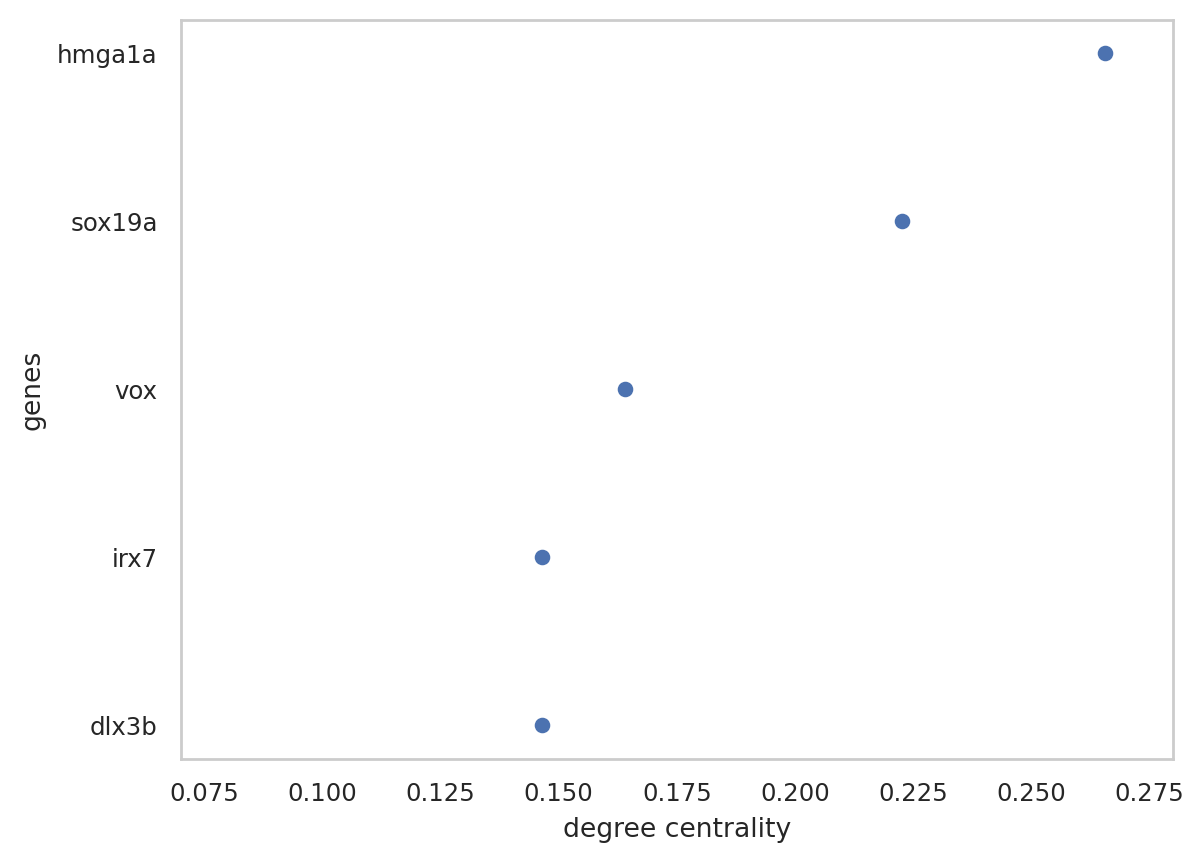

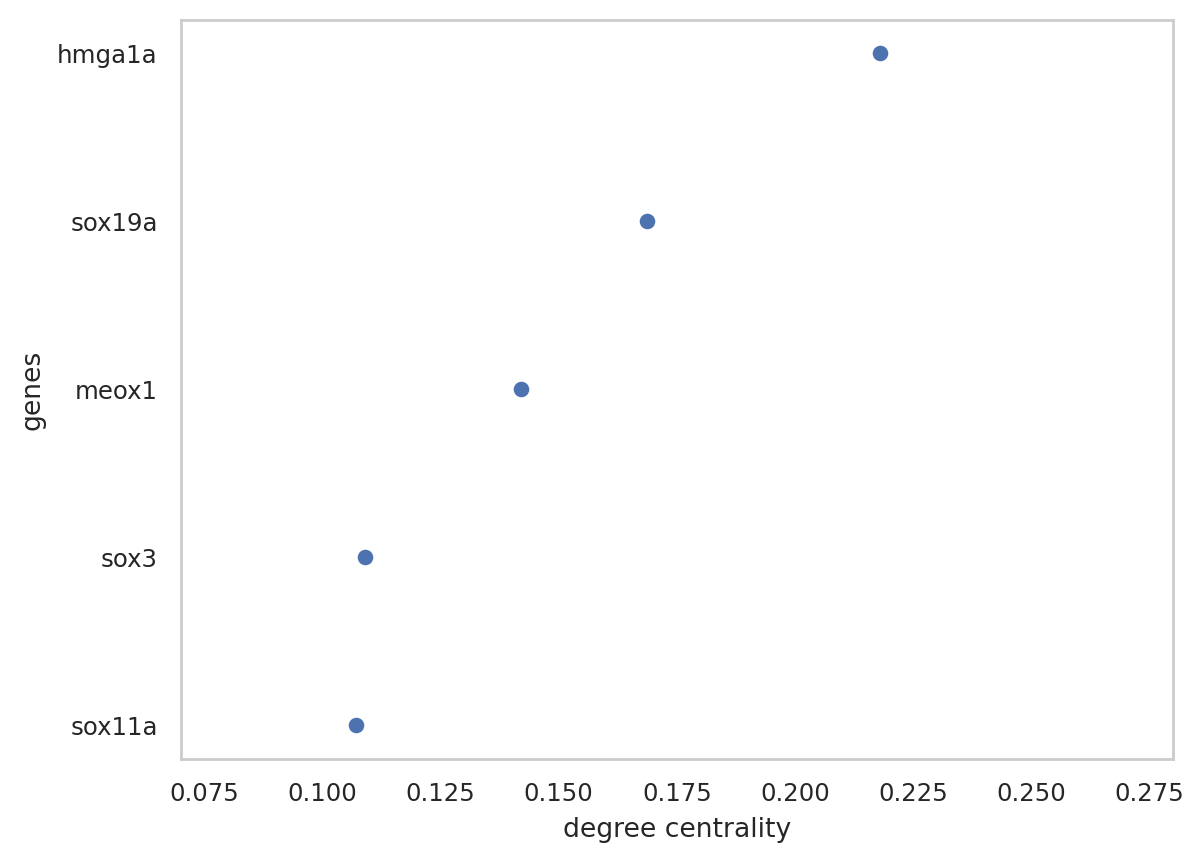

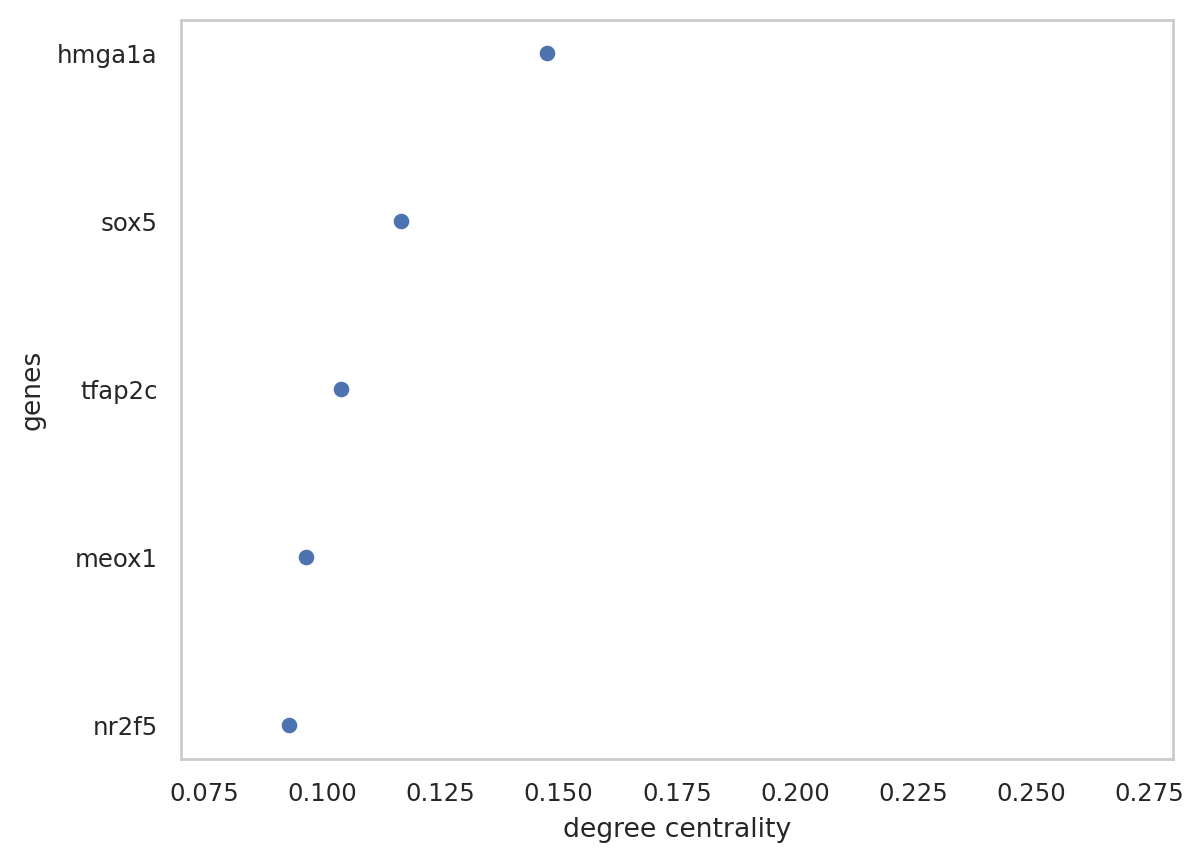

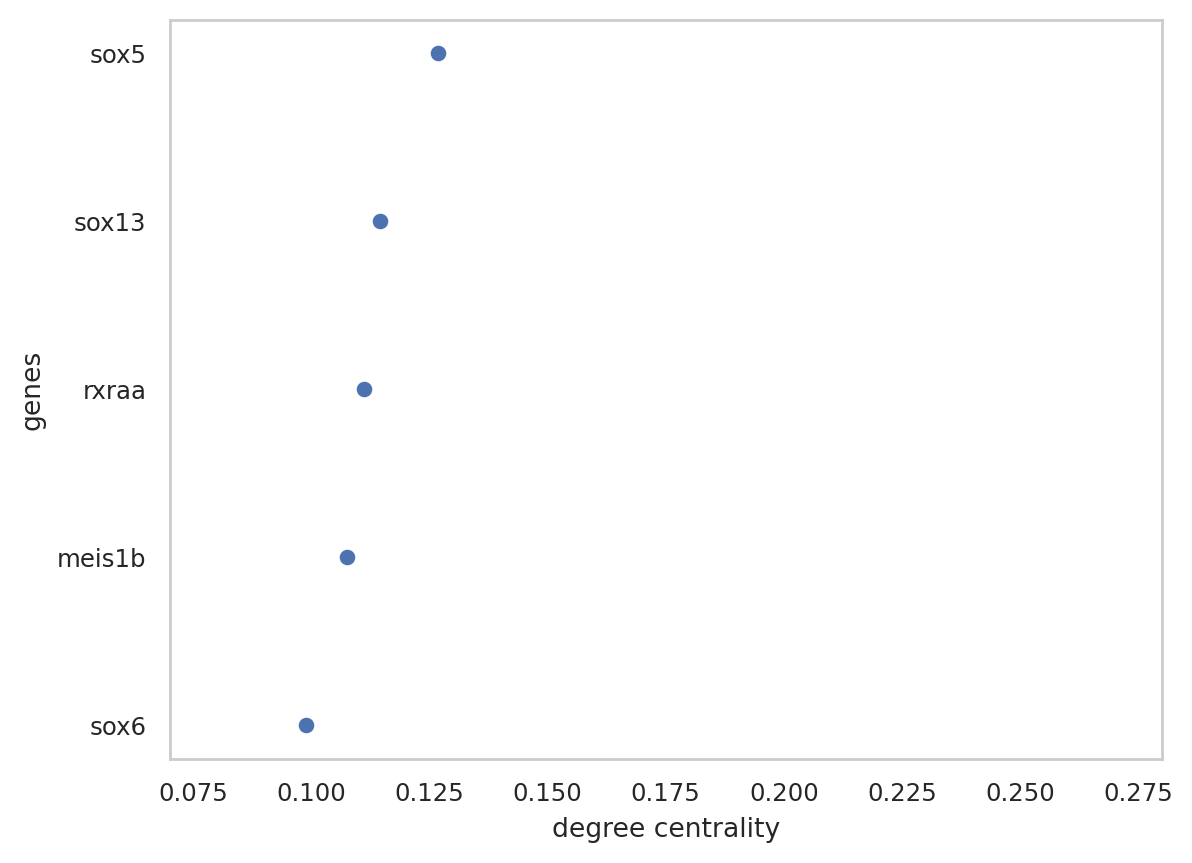

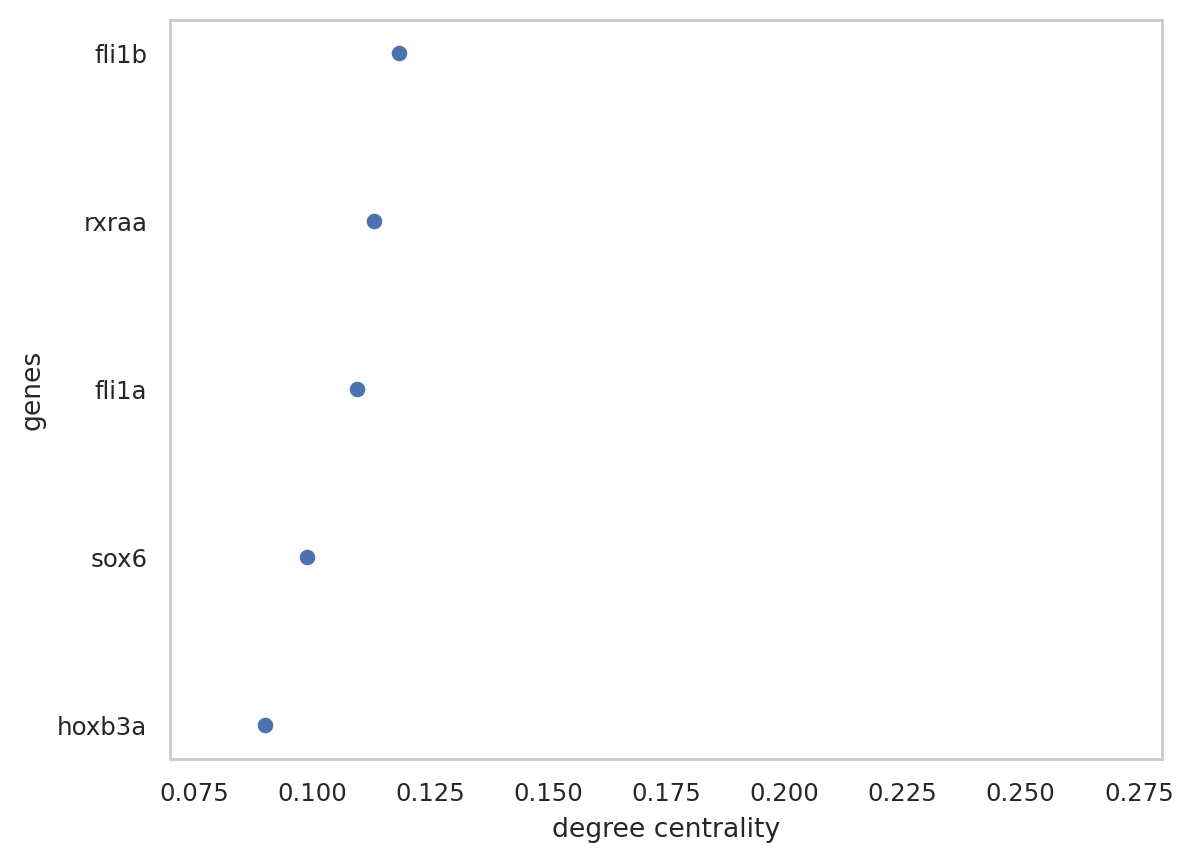

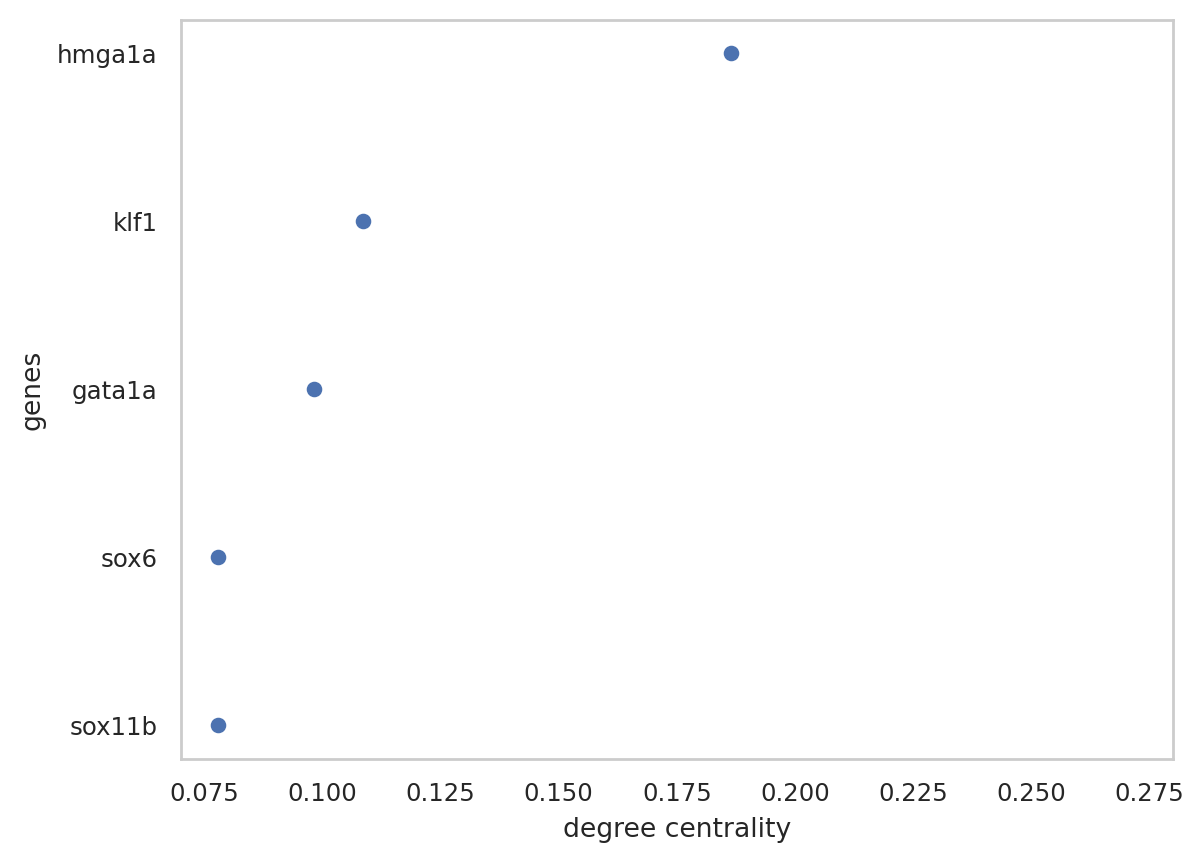

In [96]:
for timepoint in timepoints:
    df_merged_score_sorted = dict_merged_score[timepoint].sort_values("degree_centrality_all", ascending=False)
    plt.scatter(df_merged_score_sorted.head().degree_centrality_all, 
            df_merged_score_sorted.head().index)
    plt.gca().invert_yaxis()
    plt.xlabel('degree centrality')
    plt.ylabel('genes')
    plt.xlim([0.07, 0.28])
    plt.grid(False)
    plt.savefig(figpath + f"degree_centrality_top5_whole_embryo_GRN_{timepoint}.pdf")
    plt.show()

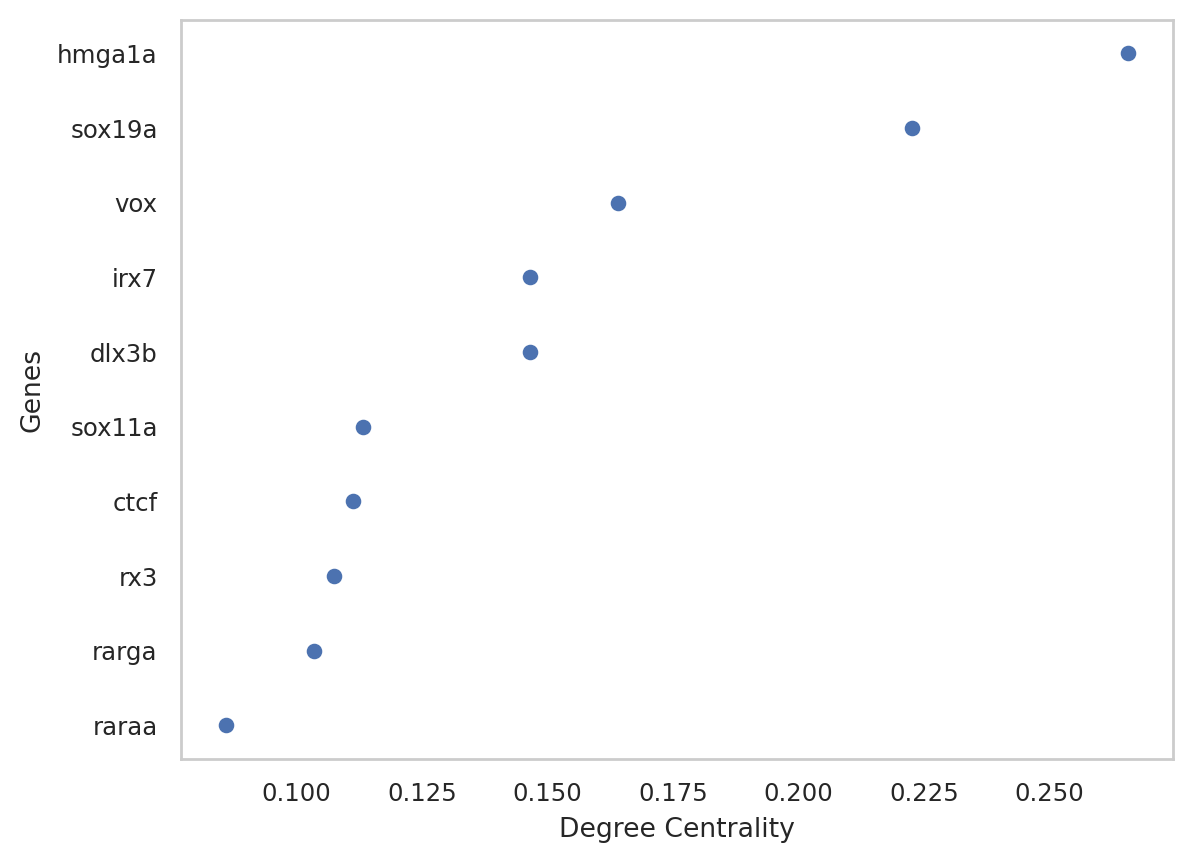

In [91]:
plt.scatter(df_merged_score_sorted.head(5).degree_centrality_all, 
            df_merged_score_sorted.head(5).index)
plt.gca().invert_yaxis()
plt.xlabel('Degree Centrality')
plt.ylabel('Genes')
plt.grid(False)
plt.savefig(figpath + f"")
plt.show()

In [79]:
# Check the GRN at the first timepoint
df_counts = df_counts_union["TDR126"]

# Assuming you have determined your cluster size and its position (last N rows and M columns)
N = 50  # The number of rows in the cluster, replace with the actual number
M = 5  # The number of columns in the cluster, replace with the actual number

# The indices of the rows and columns in the original data that make up the cluster
row_indices = g.dendrogram_row.reordered_ind[20:70]
col_indices = g.dendrogram_col.reordered_ind[10:30]

# Extract the data for this cluster
cluster_data = df_counts.iloc[row_indices, col_indices]

# Print or process the cluster_data as needed
print(cluster_data)

# If you want to look at the labels of the rows and columns in the cluster
row_labels = df_counts.index[row_indices]
col_labels = df_counts.columns[col_indices]

print("Row Labels in the Cluster:", row_labels)
print("Column Labels in the Cluster:", col_labels)

source        pax6a      sox5    sox19a  sox6    hoxc6b     tbx16      sox3  \
target                                                                        
mdka       0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000   
plekhh1    0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000   
ncam1b     0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000   
rfx4       0.047986  0.000000  0.000000   0.0  0.000000  0.000000  0.030697   
znrf3      0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000   
cadm1a     0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000   
efna2a     0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000   
pax7a      0.000000  0.000000  0.000000   0.0  0.000000  0.000000  0.000000   
rnf220a    0.031948 -0.029514 -0.040048   0.0  0.000000  0.000000  0.000000   
gli3       0.056000  0.000000 -0.029129   0.0  0.000000  0.000000  0.000000   
nova2      0.061230  0.000000  0.000000   0.0  0.000

In [113]:
col_names = col_labels
row_names = row_labels

# subset the GRN for the portion that is upregulated in Muscle compared to NMPs
df_counts = df_counts_union["TDR126"]

df_counts_0somites_upreg = df_counts.loc[row_names, col_names]
df_counts_0somites_upreg

source              hmga1a     meox1    sox19a       vox     tbx16
target                                                            
apoc1             0.296917  0.000000  0.000000  0.000000  0.000000
u2af2b            0.097756  0.000000  0.000000  0.000000  0.000000
dut               0.045461  0.000000  0.000000  0.042787  0.000000
bzw1a             0.146815  0.000000  0.032549  0.000000  0.000000
marcksb           0.129412  0.000000  0.000000  0.037676  0.000000
eif5a2            0.094876  0.029633  0.038652  0.000000  0.000000
aldoaa            0.105316  0.025409  0.031386  0.000000  0.000000
anp32e            0.136693  0.000000  0.052257  0.029508  0.000000
fbl               0.090248  0.026377  0.025611  0.000000  0.000000
srrm2             0.128063  0.000000  0.000000  0.031265  0.000000
mdkb              0.079583  0.000000  0.000000  0.000000  0.000000
eif4a1a           0.087982  0.000000  0.041373  0.000000  0.000000
ppp2cb            0.069841  0.000000  0.027314  0.034229  0.000000
anp32a            0.084693  0.026104  0.000000  0.000000  0.000000
ppig              0.041352  0.000000  0.032896  0.000000  0.000000
ube2v2            0.096596  0.028912  0.000000  0.000000  0.000000
metap2b           0.102340  0.038654  0.000000  0.055235  0.000000
rsl1d1            0.107134  0.045762  0.000000  0.047146 -0.031414
cd3eap            0.062700  0.027816  0.000000  0.000000  0.000000
top1l             0.121157  0.000000  0.038587  0.000000  0.000000
dkc1              0.117420  0.000000  0.000000  0.043549  0.000000
nop56             0.099329  0.036328  0.000000  0.031124  0.000000
cnbpb             0.088263  0.048440  0.052207  0.033262  0.000000
hnrnpa1b          0.073647  0.033462  0.047643  0.000000  0.000000
tubb2b            0.127840  0.000000  0.057801  0.000000  0.000000
eef1g             0.150804  0.034266  0.070476  0.000000  0.000000
anp32b            0.124822  0.000000  0.027503  0.059913  0.000000
cbx3a             0.135827  0.000000  0.079586  0.000000  0.000000
rpl5b             0.261669  0.000000  0.000000  0.000000  0.000000
eef1a1l1          0.187946  0.000000  0.039959  0.043298  0.000000
snrpg             0.193163  0.000000  0.000000  0.000000  0.000000
rpl12             0.195000  0.000000  0.035811  0.000000  0.000000
rplp2l            0.198905  0.000000  0.000000  0.036495  0.000000
pabpc1a           0.186085  0.000000  0.000000  0.000000  0.000000
tma7              0.131071  0.000000  0.043753  0.032010  0.000000
rps24             0.158123  0.000000  0.043831  0.035046  0.000000
ubc               0.143738  0.000000  0.034571  0.000000  0.000000
eef2b             0.180978  0.000000  0.000000  0.033310  0.000000
rpl29             0.165861  0.000000  0.035943  0.033493  0.000000
mki67             0.075132  0.000000  0.029440  0.000000  0.000000
rrm2              0.186573  0.000000  0.000000  0.000000  0.000000
nop58             0.146266  0.056569  0.000000  0.000000  0.000000
cfl1              0.122664  0.000000  0.062523  0.038200  0.000000
ncl               0.259855  0.033538  0.000000  0.027434  0.000000
npm1a             0.157469  0.027116  0.027895  0.052923  0.000000
hmgn2             0.198301  0.000000  0.000000  0.000000  0.000000
si:ch73-281n10.2  0.168253  0.000000  0.030901  0.035786  0.000000
hsp90ab1          0.196928  0.000000  0.059903  0.000000  0.000000
ptmab             0.209939  0.000000  0.048333  0.039032  0.000000
hmgb2a            0.189838  0.000000  0.039209  0.036143  0.000000

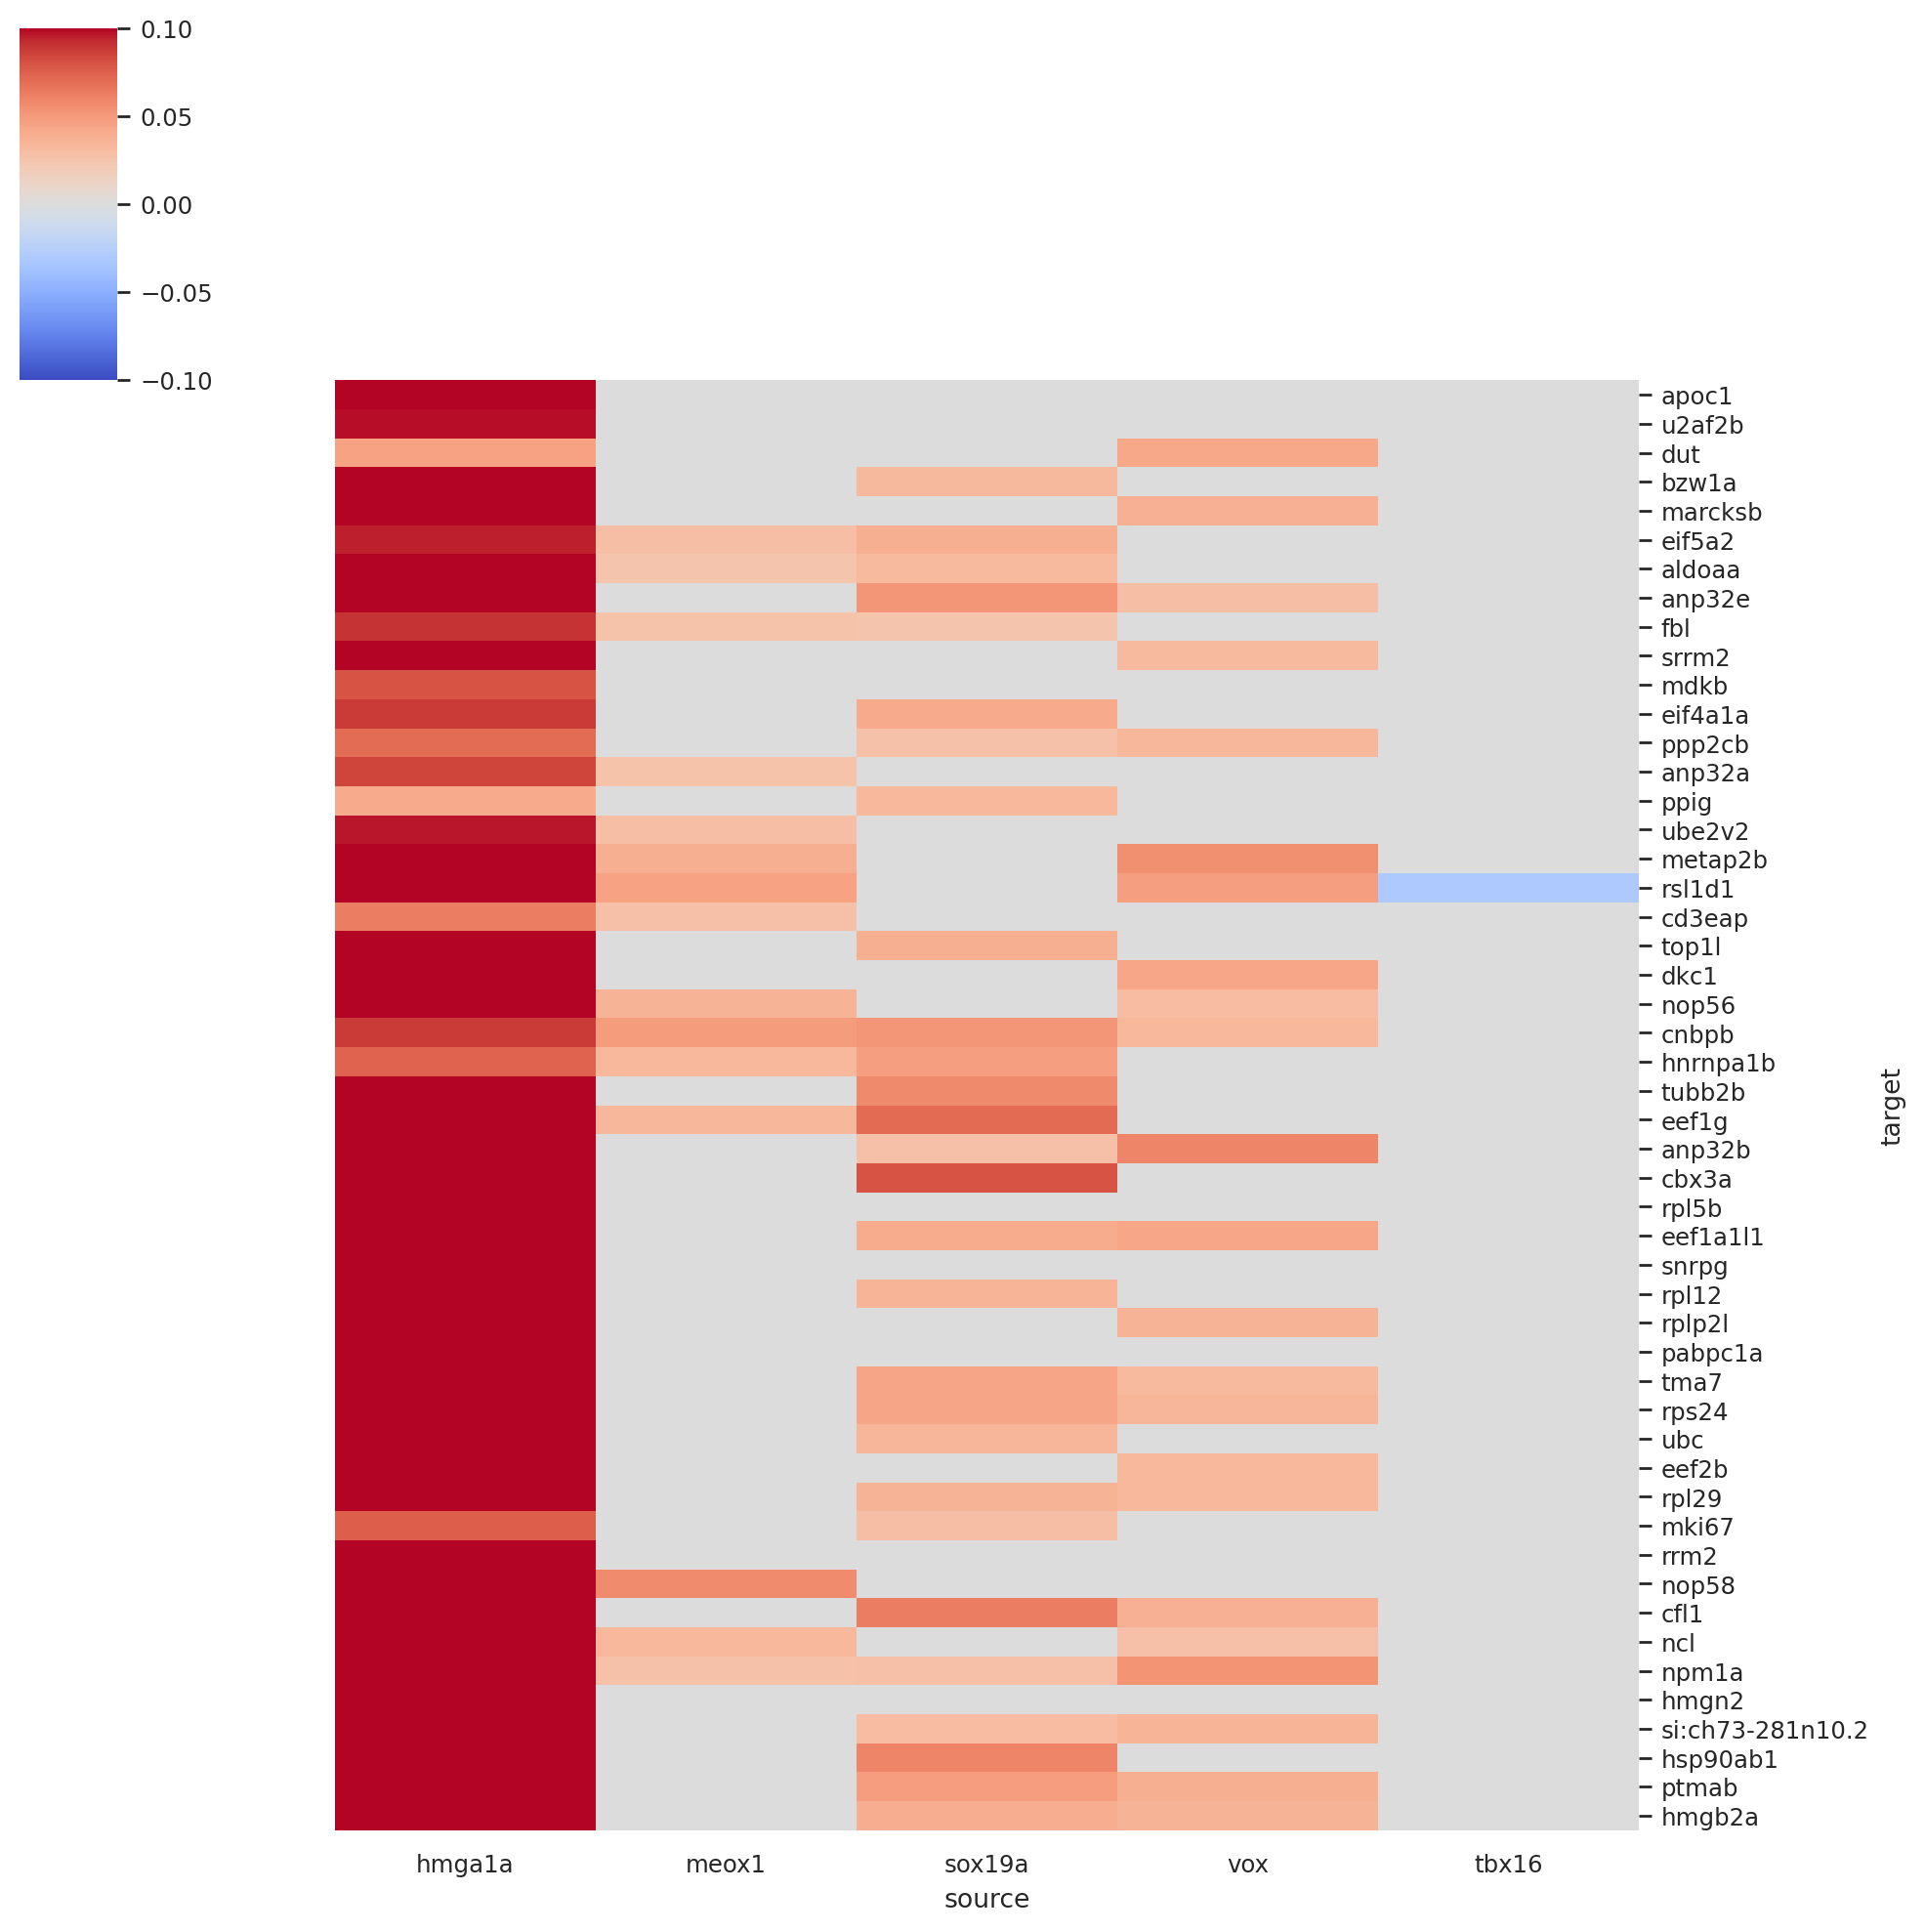

In [114]:
vmax = 0.1
vmin = -0.1

# plot the clustermap
g = sns.clustermap(df_counts_0somites_upreg, method='ward', metric='euclidean', 
                   cmap='coolwarm', standard_scale=None, 
                   row_cluster=False, col_cluster=False, 
                   xticklabels=True, yticklabels=True, 
                   vmax=vmax, vmin=vmin)

# hide the dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# hide the colorbar
g.cax.set_visible(True)

celltype = "PSM"
stage = "0somites"

g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}.pdf") # celltype is defined above where we computed df_counts_union
g.savefig(figpath + f"subGRN_heatmap_{celltype}_{stage}.png")

plt.show()